# Thesis pipeline (merged v6 + v3 features)

Generated for Google Colab.

**Note:** The first install cell ends with a forced runtime restart.


## -*- coding: utf-8 -*-


In [ ]:
# -*- coding: utf-8 -*-
"""thesis version 6.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1KDYPE0MaqlM5-vU6esFgh_a1u1wA9AqB
"""



'thesis version 6.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1KDYPE0MaqlM5-vU6esFgh_a1u1wA9AqB\n'

## 0) CLEAN INSTALL (RUN ONCE) + RESTART


In [ ]:
# =========================
# 0) CLEAN INSTALL (RUN ONCE) + RESTART


## =========================


In [ ]:
# =========================
# If you're on Colab: Runtime -> Restart runtime after this cell (we auto-kill too)

!pip -q uninstall -y torch torchvision torchaudio torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv || true

# --- Fix scientific stack to consistent versions (avoid ABI break + satisfy common deps) ---
!pip -q install --no-cache-dir --force-reinstall \
  "numpy==2.0.2" \
  "scipy==1.14.1" \
  "scikit-learn==1.6.1" \
  "pandas==2.2.2" \
  "matplotlib==3.9.2" \
  "networkx==3.4.2" \
  "pillow==11.3.0"

# --- Install PyTorch CUDA 12.6 build (choose cu126 to match your runtime CUDA 12.6) ---
# If this fails in your environment, tell me the exact error text.
!pip -q install --index-url https://download.pytorch.org/whl/cu126 \
  "torch==2.8.0+cu126" "torchvision==0.23.0+cu126" "torchaudio==2.8.0+cu126"

# --- Install PyG + extensions matching torch/cuda ---
import torch, sys
TORCH_VER = torch.__version__.split('+')[0]  # e.g. 2.8.0
CUDA_VER  = torch.version.cuda              # e.g. 12.6
CUDA_TAG  = f"cu{CUDA_VER.replace('.','')}" if CUDA_VER else "cpu"
print("python:", sys.version)
print("torch:", torch.__version__)
print("cuda:", CUDA_VER, "| tag:", CUDA_TAG)

!pip -q install -U torch_geometric
!pip -q install -U pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
  -f https://data.pyg.org/whl/torch-{TORCH_VER}+{CUDA_TAG}.html

# --- clustering + GO enrichment ---
!pip -q install -U python-louvain gprofiler-official
!pip -q install -U igraph leidenalg || true  # optional (if fails, we fallback)

# --- hard restart (important after ABI changes) ---
import os, signal
os.kill(os.getpid(), signal.SIGKILL)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 228.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 324.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 349.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 280.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 173.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 302.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 499.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 264.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 507.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 387.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30

## 1) IMPORTS + SEEDS + DEVICE


In [ ]:
# =========================
# 1) IMPORTS + SEEDS + DEVICE


In [1]:
# =========================
# GLOBAL RUN FLAGS (paper-friendly)
# - Keep heavy steps OFF by default so "Run all" doesn't take forever.
# =========================
RUN_HEAVY = True          # multi-seed training, big sweeps
RUN_NODE2VEC = True       # node2vec baseline can be slow
RUN_CLUSTER_SWEEP = True  # resolution sweep for Leiden/Louvain
RUN_CLUSTER_COHESION = True  # per-cluster cohesion + correlations (sampling-heavy)

print("RUN_HEAVY =", RUN_HEAVY)
print("RUN_NODE2VEC =", RUN_NODE2VEC)
print("RUN_CLUSTER_SWEEP =", RUN_CLUSTER_SWEEP)
print("RUN_CLUSTER_COHESION =", RUN_CLUSTER_COHESION)

RUN_HEAVY = True
RUN_NODE2VEC = True
RUN_CLUSTER_SWEEP = True
RUN_CLUSTER_COHESION = True


## =========================


In [2]:
# =========================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# quick ABI sanity:
import scipy, sklearn
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sklearn.__version__)
print("torch:", torch.__version__)
print("pyg ok")



device: cpu
numpy: 2.0.2
scipy: 1.14.1
sklearn: 1.6.1
torch: 2.8.0+cu126
pyg ok


## =========================


In [3]:
# =========================
# 1b) PREPROCESSING OPTIONS (merge from version 3)


## =========================


In [4]:
# =========================
# If True, we filter STRING edges by combined_score and keep only the Largest Connected Component (LCC).
# This reduces noise/islands and usually improves both link prediction stability and community structure.
USE_THRESHOLD = True
MIN_SCORE = 700            # STRING combined_score threshold (0..1000). 700 = high-confidence.
USE_LCC = True             # keep largest connected component after thresholding
DO_BASIC_PLOTS = True     # set True if you want extra data distribution plots (degree, edge weights, CC sizes)

# If you want to reproduce version-6 behavior (no threshold/LCC), set:
# USE_THRESHOLD=False; USE_LCC=False



## 2) DOWNLOAD STRING (v11.5) + UNZIP


In [5]:
# =========================
# 2) DOWNLOAD STRING (v11.5) + UNZIP


## =========================


In [6]:
# =========================
import pathlib, gzip, shutil

data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

def maybe_download(url, out_path):
    out_path = pathlib.Path(out_path)
    if out_path.exists():
        print("OK (exists):", out_path)
        return
    print("Downloading:", out_path.name)
    !wget -q -O "{out_path}" "{url}"
    print("Saved:", out_path)

maybe_download(
    "https://stringdb-static.org/download/protein.info.v11.5/9606.protein.info.v11.5.txt.gz",
    data_dir / "9606.protein.info.v11.5.txt.gz"
)
maybe_download(
    "https://stringdb-static.org/download/protein.links.detailed.v11.5/9606.protein.links.detailed.v11.5.txt.gz",
    data_dir / "9606.protein.links.detailed.v11.5.txt.gz"
)

for gz in data_dir.glob("*.gz"):
    out = gz.with_suffix("")
    if not out.exists():
        print("Unzipping:", gz.name)
        with gzip.open(gz, "rb") as f_in, open(out, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
        print("OK:", out)




Downloading: 9606.protein.info.v11.5.txt.gz
Saved: data/9606.protein.info.v11.5.txt.gz
Downloading: 9606.protein.links.detailed.v11.5.txt.gz
Saved: data/9606.protein.links.detailed.v11.5.txt.gz
Unzipping: 9606.protein.links.detailed.v11.5.txt.gz
OK: data/9606.protein.links.detailed.v11.5.txt
Unzipping: 9606.protein.info.v11.5.txt.gz
OK: data/9606.protein.info.v11.5.txt


## 3) LOAD STRING GRAPH -> PyG Data + nodes_annot


In [7]:
# =========================
# 3) LOAD STRING GRAPH -> PyG Data + nodes_annot
#     (merged improvements: optional MIN_SCORE threshold + LCC)


## =========================


[Config] USE_THRESHOLD=True MIN_SCORE=700 USE_LCC=True DO_BASIC_PLOTS=True
Applied MIN_SCORE=700: edges 11938498 -> 505968
Kept LCC: nodes=16584 edges=505666
data_full: Data(x=[16584, 4], edge_index=[2, 252833], edge_weight=[252833], num_nodes=16584)


,node,string_id,preferred_name,annotation,gene_final
0,0,9606.ENSP00000000233,ARF5,ADP-ribosylation factor 5; GTP-binding protein...,ARF5
1,1,9606.ENSP00000000412,M6PR,Cation-dependent mannose-6-phosphate receptor;...,M6PR
2,2,9606.ENSP00000001008,FKBP4,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...,FKBP4
3,3,9606.ENSP00000001146,CYP26B1,Cytochrome P450 26B1; Involved in the metaboli...,CYP26B1
4,4,9606.ENSP00000002125,NDUFAF7,"Protein arginine methyltransferase NDUFAF7, mi...",NDUFAF7


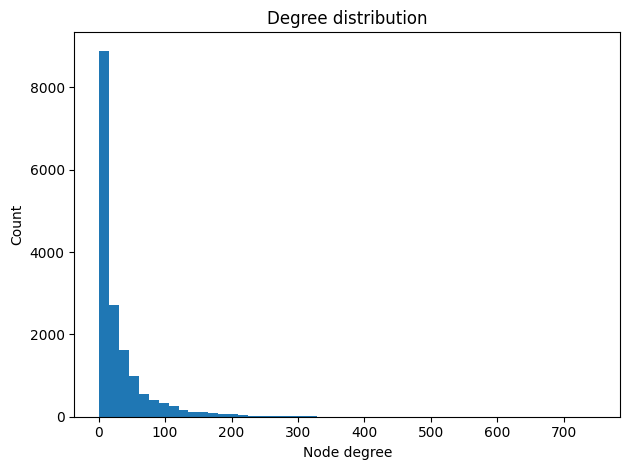

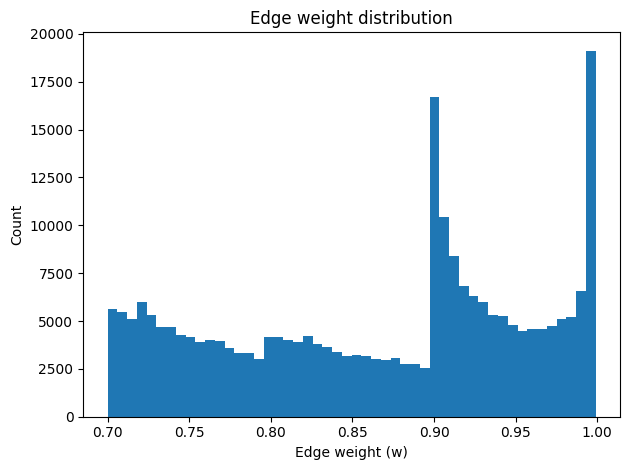

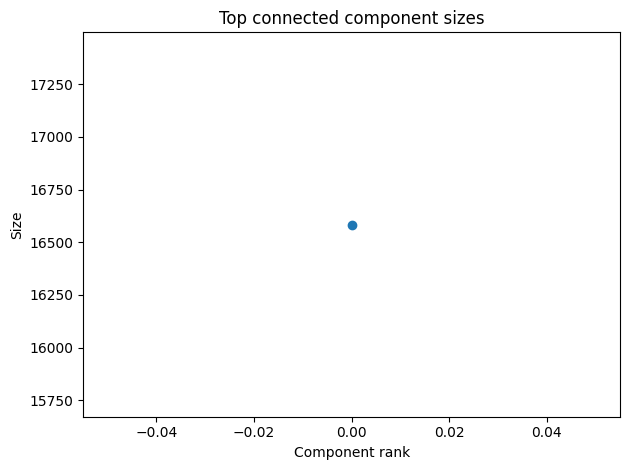

In [8]:
# =========================
# DATA LOADING + FILTERS (safe defaults)
# =========================
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data

# ---- SAFE DEFAULTS (αν δεν υπάρχουν ήδη ορισμένες τιμές) ----
USE_THRESHOLD = globals().get("USE_THRESHOLD", False)   # True/False
MIN_SCORE     = globals().get("MIN_SCORE", 700)         # 0..1000 for STRING combined_score
USE_LCC       = globals().get("USE_LCC", True)          # True/False
DO_BASIC_PLOTS= globals().get("DO_BASIC_PLOTS", False)  # True/False

print(f"[Config] USE_THRESHOLD={USE_THRESHOLD} MIN_SCORE={MIN_SCORE} USE_LCC={USE_LCC} DO_BASIC_PLOTS={DO_BASIC_PLOTS}")

info = pd.read_csv("data/9606.protein.info.v11.5.txt", sep="\t")
info = info.rename(columns={"#string_protein_id": "string_id"})

links = pd.read_csv("data/9606.protein.links.detailed.v11.5.txt", sep=" ")

# --- choose / build a weight column in [0,1] ---
if "combined_score" in links.columns:
    links["combined_score"] = links["combined_score"].astype(float)
    links["w"] = links["combined_score"] / 1000.0
else:
    score_col = [c for c in links.columns if c not in ["protein1", "protein2"]][0]
    links["w"] = links[score_col].astype(float)
    links["w"] = (links["w"] - links["w"].min()) / (links["w"].max() - links["w"].min() + 1e-9)

# --- optional thresholding ---
if USE_THRESHOLD and "combined_score" in links.columns:
    before = len(links)
    links = links[links["combined_score"] >= float(MIN_SCORE)].copy()
    print(f"Applied MIN_SCORE={MIN_SCORE}: edges {before} -> {len(links)}")

# --- optional LCC (largest connected component) ---
if USE_LCC:
    import networkx as nx
    G_tmp = nx.from_pandas_edgelist(
        links, "protein1", "protein2", edge_attr="w", create_using=nx.Graph
    )
    if G_tmp.number_of_nodes() > 0 and G_tmp.number_of_edges() > 0:
        lcc_nodes = max(nx.connected_components(G_tmp), key=len)
        links = links[links["protein1"].isin(lcc_nodes) & links["protein2"].isin(lcc_nodes)].copy()
        print(f"Kept LCC: nodes={len(lcc_nodes)} edges={len(links)}")
    else:
        print("Warning: empty graph after filtering; disabling LCC for this run.")
        USE_LCC = False

# --- map string ids -> 0..N-1 ---
ids = pd.unique(links[["protein1", "protein2"]].values.ravel("K"))
string_ids = ids.astype(str).tolist()
id2idx = {sid: i for i, sid in enumerate(string_ids)}

u = links["protein1"].map(id2idx).to_numpy()
v = links["protein2"].map(id2idx).to_numpy()
w = links["w"].to_numpy().astype(np.float32)

# unique undirected edges, keep max weight
a = np.minimum(u, v)
b = np.maximum(u, v)
df_e = (
    pd.DataFrame({"a": a, "b": b, "w": w})
    .groupby(["a", "b"], as_index=False)["w"]
    .max()
)

edge_index = torch.tensor(df_e[["a", "b"]].to_numpy().T, dtype=torch.long)
edge_weight = torch.tensor(df_e["w"].to_numpy(), dtype=torch.float32)

# weight lookup dict (for recovering weights after RandomLinkSplit)
w_dict = {(int(r.a), int(r.b)): float(r.w) for r in df_e.itertuples(index=False)}

nodes_annot = (
    pd.DataFrame({"node": np.arange(len(string_ids)), "string_id": string_ids})
    .merge(info[["string_id", "preferred_name", "annotation"]], on="string_id", how="left")
)
nodes_annot["gene_final"] = nodes_annot["preferred_name"]

# ---- Node features (stronger than degree-only; still cheap) ----
# We build a small structural feature vector per node:
# 1) log(1+degree)
# 2) degree normalized
# 3) weighted degree (strength) normalized
# 4) mean incident edge weight
num_nodes = len(string_ids)
a_np = df_e["a"].to_numpy()
b_np = df_e["b"].to_numpy()
w_np = df_e["w"].to_numpy().astype(np.float32)

deg = np.zeros(num_nodes, dtype=np.float32)
strength = np.zeros(num_nodes, dtype=np.float32)

# undirected: add to both endpoints
np.add.at(deg, a_np, 1.0); np.add.at(deg, b_np, 1.0)
np.add.at(strength, a_np, w_np); np.add.at(strength, b_np, w_np)

deg_max = float(deg.max() + 1e-9)
str_max = float(strength.max() + 1e-9)
mean_w = strength / (deg + 1e-9)

X = np.vstack([
    np.log1p(deg),
    deg / deg_max,
    strength / str_max,
    mean_w,
]).T.astype(np.float32)

# z-score each feature dim (helps GCN/SAGE)
X = (X - X.mean(axis=0, keepdims=True)) / (X.std(axis=0, keepdims=True) + 1e-6)

x = torch.tensor(X, dtype=torch.float32)

data_full = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)

print("data_full:", data_full)
display(nodes_annot.head())

# --- optional basic plots (paper-friendly) ---
if DO_BASIC_PLOTS:
    import matplotlib.pyplot as plt
    import networkx as nx

    deg_np = deg.reshape(-1)

    plt.figure()
    plt.hist(deg_np, bins=50)
    plt.xlabel("Node degree"); plt.ylabel("Count")
    plt.title("Degree distribution")
    plt.tight_layout(); plt.show()

    plt.figure()
    plt.hist(df_e["w"].to_numpy(), bins=50)
    plt.xlabel("Edge weight (w)"); plt.ylabel("Count")
    plt.title("Edge weight distribution")
    plt.tight_layout(); plt.show()

    G_tmp = nx.Graph()
    G_tmp.add_edges_from(df_e[["a","b"]].to_numpy())
    cc_sizes = sorted([len(c) for c in nx.connected_components(G_tmp)], reverse=True)

    plt.figure()
    plt.plot(cc_sizes[:20], marker="o")
    plt.xlabel("Component rank"); plt.ylabel("Size")
    plt.title("Top connected component sizes")
    plt.tight_layout(); plt.show()


## 4) RandomLinkSplit + edge_weight recovery


In [9]:
# =========================
# 4) RandomLinkSplit + edge_weight recovery


## =========================


In [10]:
# =========================
# 4) RandomLinkSplit + edge_weight recovery + SPLIT CACHING (reproducible)
# Fix for PyTorch>=2.6 weights_only default + robust cache fallback
# =========================
import os
import inspect
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

# ---- Reproducible split seed ----
SPLIT_SEED = 42
torch.manual_seed(SPLIT_SEED)
np.random.seed(SPLIT_SEED)

SPLIT_CACHE_PATH = "data_splits_randomlinksplit.pt"

def _torch_load_compat(path):
    """torch.load that works across torch versions; disables weights_only when supported."""
    kw = {"map_location": "cpu"}
    sig = inspect.signature(torch.load)
    if "weights_only" in sig.parameters:
        kw["weights_only"] = False  # IMPORTANT for PyG Data objects in torch>=2.6
    return torch.load(path, **kw)

def edge_weight_from_dict(edge_index, w_dict, default_w=1.0):
    ei = edge_index.detach().cpu().numpy()
    ws = np.zeros(ei.shape[1], dtype=np.float32)
    for i in range(ei.shape[1]):
        u, v = int(ei[0, i]), int(ei[1, i])
        a, b = (u, v) if u < v else (v, u)
        ws[i] = float(w_dict.get((a, b), default_w))
    return torch.tensor(ws, dtype=torch.float32)

# ---- Try load cached splits ----
loaded = False
if os.path.exists(SPLIT_CACHE_PATH):
    try:
        data_train, data_val, data_test = _torch_load_compat(SPLIT_CACHE_PATH)
        print("✅ Loaded cached splits:", SPLIT_CACHE_PATH)
        loaded = True
    except Exception as e:
        print("⚠️ Cache load failed (will recreate splits):", repr(e))
        try:
            os.remove(SPLIT_CACHE_PATH)
            print("🗑️ Deleted broken/old cache:", SPLIT_CACHE_PATH)
        except Exception as e2:
            print("⚠️ Could not delete cache:", repr(e2))

if not loaded:
    # Build a Data object for splitting
    data_lp = Data(
        x=data_full.x,
        edge_index=data_full.edge_index,
        edge_weight=(data_full.edge_weight if hasattr(data_full, "edge_weight") else None),
        num_nodes=data_full.num_nodes,
    )

    split = RandomLinkSplit(
        num_val=0.10,
        num_test=0.10,
        is_undirected=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=1.0,
    )
    data_train, data_val, data_test = split(data_lp)

    print("Train graph edges:", data_train.edge_index.size(1))
    print("Val keys:", list(data_val.keys()))
    print("Test keys:", list(data_test.keys()))

    # recover weights for the split graphs (only if you had original weights + w_dict)
    if hasattr(data_full, "edge_weight") and data_full.edge_weight is not None and "w_dict" in globals():
        data_train.edge_weight = edge_weight_from_dict(data_train.edge_index, w_dict)
        data_val.edge_weight   = edge_weight_from_dict(data_val.edge_index, w_dict)
        data_test.edge_weight  = edge_weight_from_dict(data_test.edge_index, w_dict)
        print("✅ Recovered edge_weight for train/val/test")
    else:
        print("ℹ️ No edge_weight recovery (graph unweighted or w_dict missing).")

    torch.save((data_train, data_val, data_test), SPLIT_CACHE_PATH)
    print("✅ Saved cached splits:", SPLIT_CACHE_PATH)


Train graph edges: 404534
Val keys: ['edge_weight', 'edge_label_index', 'edge_label', 'edge_index', 'x', 'num_nodes']
Test keys: ['edge_weight', 'edge_label_index', 'edge_label', 'edge_index', 'x', 'num_nodes']
✅ Recovered edge_weight for train/val/test
✅ Saved cached splits: data_splits_randomlinksplit.pt


## 4B) Structural node features from TRAIN graph (no leakage)

This section builds **graph-theoretic node features** from the **TRAIN graph only** (from `data_train.edge_index`) and uses them as `x` for the GNN.
This is useful when the original graph has no informative node attributes (common in PPI).

Core features:
- degree
- log1p(degree)
- local clustering coefficient
- k-core index (core number)

Optional:
- PageRank
- Eigenvector centrality (can be slow; auto-skips on failure)

In [11]:
# =========================
# 4B) STRUCTURAL NODE FEATURES (train-only, no leakage)
# - Builds node features from TRAIN graph only: data_train.edge_index
# - Replaces data_train.x / data_val.x / data_test.x with structural features
# - Keeps a backup of original x as X_BASE (so you can revert)
# - Caches to disk for faster re-runs
# =========================
import os
import numpy as np
import torch
import networkx as nx

assert "data_train" in globals() and "data_val" in globals() and "data_test" in globals(), "Run Section 4 (RandomLinkSplit) first."

USE_STRUCT_FEATURES = True   # <- set False to keep the original x
ADD_PAGERANK = True
ADD_EIGENVECTOR = True      # <- set True if you want to try (may be slower)

CACHE_FEATS_PATH = "node_features_struct_train.npy"

N = int(data_train.num_nodes)

# --- Backup original x (only once) ---
if "X_BASE" not in globals():
    try:
        X_BASE = data_train.x.detach().cpu().clone()
        print("✅ Backed up original x to X_BASE:", tuple(X_BASE.shape))
    except Exception:
        X_BASE = None
        print("ℹ️ Could not backup original x (maybe x not set).")

if not USE_STRUCT_FEATURES:
    print("USE_STRUCT_FEATURES=False -> keeping original x (no changes).")
else:
    # --- Load from cache if available ---
    if os.path.exists(CACHE_FEATS_PATH):
        X = np.load(CACHE_FEATS_PATH)
        assert X.shape[0] == N, f"Cached X rows {X.shape[0]} != N {N}"
        print("✅ Loaded cached structural features:", CACHE_FEATS_PATH, X.shape)
    else:
        # --- Build TRAIN graph (undirected) ---
        ei = data_train.edge_index.detach().cpu().numpy()
        Gtr = nx.Graph()
        Gtr.add_nodes_from(range(N))
        Gtr.add_edges_from(list(zip(ei[0], ei[1])))

        # --- Core features ---
        deg = np.array([d for _, d in Gtr.degree()], dtype=np.float32)
        logdeg = np.log1p(deg).astype(np.float32)

        # local clustering coefficient
        # (returns dict: node -> coeff)
        clust = nx.clustering(Gtr)
        clust = np.array([clust[i] for i in range(N)], dtype=np.float32)

        # k-core index (core number)
        core = nx.core_number(Gtr)
        core = np.array([core[i] for i in range(N)], dtype=np.float32)

        feats = [
            ("degree", deg),
            ("log1p_degree", logdeg),
            ("clustering_coeff", clust),
            ("kcore", core),
        ]

        # --- Optional: PageRank ---
        if ADD_PAGERANK:
            try:
                pr = nx.pagerank(Gtr, alpha=0.85, max_iter=200, tol=1e-06)
                pr = np.array([pr[i] for i in range(N)], dtype=np.float32)
                feats.append(("pagerank", pr))
                print("✅ PageRank computed.")
            except Exception as e:
                print("⚠️ PageRank failed -> skipping:", repr(e))

        # --- Optional: Eigenvector centrality ---
        if ADD_EIGENVECTOR:
            try:
                # Use numpy-based if possible (faster), else power iteration
                try:
                    ev = nx.eigenvector_centrality_numpy(Gtr)
                except Exception:
                    ev = nx.eigenvector_centrality(Gtr, max_iter=500, tol=1e-06)
                ev = np.array([ev[i] for i in range(N)], dtype=np.float32)
                feats.append(("eigenvector", ev))
                print("✅ Eigenvector centrality computed.")
            except Exception as e:
                print("⚠️ Eigenvector centrality failed -> skipping:", repr(e))

        # Stack
        X = np.stack([v for _, v in feats], axis=1).astype(np.float32)
        feat_names = [k for k, _ in feats]
        print("Built structural X:", X.shape, "| features:", feat_names)

        # Normalize (z-score) for stable GNN training
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, keepdims=True) + 1e-8
        X = (X - mu) / sd

        np.save(CACHE_FEATS_PATH, X)
        print("✅ Saved structural features cache:", CACHE_FEATS_PATH)

    # Convert to torch
    X_t = torch.tensor(X, dtype=torch.float32)

    # Assign to all splits (same x for all, derived from TRAIN graph only)
    data_train.x = X_t
    data_val.x   = X_t
    data_test.x  = X_t

    print("✅ Replaced x in data_train/val/test with structural features:", tuple(X_t.shape))

✅ Backed up original x to X_BASE: (16584, 4)
✅ PageRank computed.
✅ Eigenvector centrality computed.
Built structural X: (16584, 6) | features: ['degree', 'log1p_degree', 'clustering_coeff', 'kcore', 'pagerank', 'eigenvector']
✅ Saved structural features cache: node_features_struct_train.npy
✅ Replaced x in data_train/val/test with structural features: (16584, 6)


## 5) Robust edge label getters


In [12]:
# =========================
# 5) Robust edge label getters


## =========================


In [13]:
# =========================
def has_edge_label_format(d):
    return ("edge_label_index" in d.keys()) and ("edge_label" in d.keys())

def has_posneg_format(d):
    return ("pos_edge_label_index" in d.keys()) and ("neg_edge_label_index" in d.keys())

def get_eval_edges(data_split):
    if has_edge_label_format(data_split):
        eidx = data_split.edge_label_index
        y = data_split.edge_label.detach().cpu().numpy().astype(int)
        return eidx, y
    if has_posneg_format(data_split):
        pos = data_split.pos_edge_label_index
        neg = data_split.neg_edge_label_index
        eidx = torch.cat([pos, neg], dim=1)
        y = np.concatenate([np.ones(pos.size(1), dtype=int), np.zeros(neg.size(1), dtype=int)])
        return eidx, y
    raise RuntimeError(f"Unknown split format. Keys: {data_split.keys()}")

def get_train_edges_and_labels(data_train):
    if has_edge_label_format(data_train):
        return data_train.edge_label_index, data_train.edge_label.float()
    if has_posneg_format(data_train):
        pos = data_train.pos_edge_label_index
        neg = data_train.neg_edge_label_index
        eidx = torch.cat([pos, neg], dim=1)
        y = torch.cat([torch.ones(pos.size(1)), torch.zeros(neg.size(1))], dim=0).float()
        return eidx, y
    raise RuntimeError(f"Unknown train format. Keys: {data_train.keys()}")

def eval_scores_to_metrics(y_true, y_score):
    return roc_auc_score(y_true, y_score), average_precision_score(y_true, y_score)

_, yv = get_eval_edges(data_val)
_, yt = get_eval_edges(data_test)
print("Val pos/neg:", int(yv.sum()), int((yv == 0).sum()))
print("Test pos/neg:", int(yt.sum()), int((yt == 0).sum()))




Val pos/neg: 25283 25283
Test pos/neg: 25283 25283


## 6) Baselines on TRAIN graph (CN / Adamic-Adar / Jaccard / Preferential Attachment)


In [14]:
# =========================
# 6) Baselines on TRAIN graph (CN / Adamic-Adar / Jaccard / Preferential Attachment)


## =========================


### 6B) OPTIONAL: Node2Vec baseline (structure-only)  
Runs only if `RUN_NODE2VEC=True`.

In [15]:
# =========================
# 6B) OPTIONAL: Node2Vec baseline (structure-only)  [paper add-on]
# - Trains node embeddings from TRAIN graph only (no leakage)
# - Scores edges by cosine similarity
# - Evaluates on TEST edges/labels (same as other baselines)
# =========================
import numpy as np
import networkx as nx

if not RUN_NODE2VEC:
    print("RUN_NODE2VEC=False (skip). Set RUN_NODE2VEC=True to run Node2Vec baseline.")
else:
    assert "data_train" in globals(), "Need data_train (RandomLinkSplit)."
    assert "data_test" in globals(), "Need data_test (RandomLinkSplit)."
    assert "get_eval_edges" in globals(), "Need get_eval_edges() (from evaluation helper section)."

    # ---- Build TRAIN graph (no leakage) if missing ----
    if "Gtr" not in globals():
        N = int(data_train.num_nodes)
        ei = data_train.edge_index.detach().cpu().numpy()
        Gtr = nx.Graph()
        Gtr.add_nodes_from(range(N))
        Gtr.add_edges_from(list(zip(ei[0], ei[1])))
        print("✅ Auto-built Gtr from data_train:", Gtr.number_of_nodes(), "nodes,", Gtr.number_of_edges(), "edges")
    else:
        print("✅ Using existing Gtr:", Gtr.number_of_nodes(), "nodes,", Gtr.number_of_edges(), "edges")

    # ---- Get TEST edges + labels ----
    eidx_test, y_test_n2v = get_eval_edges(data_test)
    y_test_n2v = np.array(y_test_n2v).astype(int)

    # ---- Compute Node2Vec embeddings ----
    emb = None
    seed0 = int(SEED) if "SEED" in globals() else 0

    # Try NetworkX implementation (if present)
    try:
        from networkx.algorithms.node2vec import Node2Vec
        print("Using NetworkX Node2Vec")

        n2v = Node2Vec(
            Gtr,
            dimensions=64,
            walk_length=30,
            num_walks=10,
            p=1.0,
            q=1.0,
            workers=2,
            seed=seed0,
        )
        w2v = n2v.fit(window=10, min_count=1, batch_words=128)
        emb = {int(n): w2v.wv[str(n)] for n in Gtr.nodes()}

    except Exception as e1:
        print("NetworkX Node2Vec not available or failed:", e1)
        # Try node2vec package
        try:
            from node2vec import Node2Vec
            print("Using node2vec package")

            n2v = Node2Vec(
                Gtr,
                dimensions=64,
                walk_length=30,
                num_walks=10,
                p=1.0,
                q=1.0,
                workers=2,
                seed=seed0,
            )
            w2v = n2v.fit(window=10, min_count=1, batch_words=128)
            emb = {int(n): w2v.wv[str(n)] for n in Gtr.nodes()}
        except Exception as e2:
            print("node2vec package not available/failed:", e2)
            emb = None

    if emb is None:
        print("❌ Could not compute Node2Vec embeddings. (OK to skip.)")
    else:
        # ---- Score edges by cosine similarity ----
        def cos_sim(a, b, eps=1e-12):
            a = np.asarray(a); b = np.asarray(b)
            return float(np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + eps))

        u = eidx_test[0].detach().cpu().numpy()
        v = eidx_test[1].detach().cpu().numpy()
        s = np.array([cos_sim(emb[int(uu)], emb[int(vv)]) for uu, vv in zip(u, v)], dtype=float)

        # normalize to [0,1]
        s_n2v = (s - s.min()) / (s.max() - s.min() + 1e-12)

        from sklearn.metrics import roc_auc_score, average_precision_score
        roc = roc_auc_score(y_test_n2v, s_n2v)
        ap  = average_precision_score(y_test_n2v, s_n2v)
        print(f"[Node2Vec] TEST ROC-AUC={roc:.4f} | AP={ap:.4f}")

        # expose for later plots/tables
        s_n2v_n = s_n2v
        y_test_node2vec = y_test_n2v


✅ Using existing Gtr: 16584 nodes, 202267 edges
NetworkX Node2Vec not available or failed: No module named 'networkx.algorithms.node2vec'
node2vec package not available/failed: No module named 'node2vec'
❌ Could not compute Node2Vec embeddings. (OK to skip.)


In [16]:
# =========================
Gtr = nx.Graph()
ei = data_train.edge_index.detach().cpu().numpy()
Gtr.add_edges_from(list(zip(ei[0], ei[1])))

adj = {u: set(Gtr.neighbors(u)) for u in Gtr.nodes()}
deg = {u: len(adj[u]) for u in adj}

def common_neighbors_score(u, v):
    nu = adj.get(int(u), set())
    nv = adj.get(int(v), set())
    return float(len(nu.intersection(nv)))

def adamic_adar_score(u, v):
    nu = adj.get(int(u), set())
    nv = adj.get(int(v), set())
    cn = nu.intersection(nv)
    s = 0.0
    for w in cn:
        dw = deg.get(w, 0)
        if dw > 1:
            s += 1.0 / np.log(dw)
    return float(s)

def jaccard_score(u, v):
    nu = adj.get(int(u), set())
    nv = adj.get(int(v), set())
    inter = len(nu.intersection(nv))
    union = len(nu.union(nv))
    return float(inter / (union + 1e-9))

def preferential_attachment_score(u, v):
    return float(deg.get(int(u), 0) * deg.get(int(v), 0))

def baseline_scores_for_split(data_split, scorer_fn):
    eidx, y = get_eval_edges(data_split)
    e = eidx.detach().cpu().numpy()
    scores = np.zeros(e.shape[1], dtype=np.float32)
    for i in range(e.shape[1]):
        scores[i] = scorer_fn(int(e[0, i]), int(e[1, i]))
    return y, scores

def minmax01(x):
    x = np.asarray(x, dtype=np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx <= mn + 1e-12:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

y_test, s_cn  = baseline_scores_for_split(data_test, common_neighbors_score)
y_test, s_aa  = baseline_scores_for_split(data_test, adamic_adar_score)
y_test, s_jac = baseline_scores_for_split(data_test, jaccard_score)
y_test, s_pa  = baseline_scores_for_split(data_test, preferential_attachment_score)

# normalize for nicer PR/ROC overlays (ranking is preserved)
s_cn_n  = minmax01(s_cn)
s_aa_n  = minmax01(s_aa)
s_jac_n = minmax01(s_jac)
s_pa_n  = minmax01(s_pa)

roc_cn, ap_cn   = eval_scores_to_metrics(y_test, s_cn_n)
roc_aa, ap_aa   = eval_scores_to_metrics(y_test, s_aa_n)
roc_jac, ap_jac = eval_scores_to_metrics(y_test, s_jac_n)
roc_pa, ap_pa   = eval_scores_to_metrics(y_test, s_pa_n)

print(f"[CN]        ROC-AUC={roc_cn:.4f}  PR-AUC={ap_cn:.4f}")
print(f"[AdamicAA]  ROC-AUC={roc_aa:.4f}  PR-AUC={ap_aa:.4f}")
print(f"[Jaccard]   ROC-AUC={roc_jac:.4f} PR-AUC={ap_jac:.4f}")
print(f"[PrefAttach]ROC-AUC={roc_pa:.4f} PR-AUC={ap_pa:.4f}")



[CN]        ROC-AUC=0.9572  PR-AUC=0.9561
[AdamicAA]  ROC-AUC=0.9580  PR-AUC=0.9580
[Jaccard]   ROC-AUC=0.9573 PR-AUC=0.9572
[PrefAttach]ROC-AUC=0.8747 PR-AUC=0.8821


## 7) APPNP (GNN) link prediction model


In [17]:
# =========================
# 7) APPNP (GNN) link prediction model


## =========================


In [18]:
# =========================
# 4) GNN Link Prediction (APPNP / GCN / GraphSAGE / GAT) + (V)GAE  [PAPER-READY]
# - dot-product decoders for fair baselines
# - one stronger decoder baseline: GCN + Edge-MLP
# - optional VGAE unsupervised baseline (inner-product)
# =========================
import os, gc, time
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from torch_geometric.nn import APPNP, GCNConv, SAGEConv, GATConv, VGAE
from torch_geometric.utils import negative_sampling, dropout_edge

# -------------------------
# Reproducibility + device
# -------------------------
def set_seed(seed: int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -------------------------
# Helpers: train/eval edges
# -------------------------
def _get_pos_edges(data_split):
    # Works with RandomLinkSplit outputs and "plain" Data
    if hasattr(data_split, "pos_edge_label_index") and data_split.pos_edge_label_index is not None:
        return data_split.pos_edge_label_index
    if hasattr(data_split, "edge_label_index") and hasattr(data_split, "edge_label"):
        ei = data_split.edge_label_index
        y = data_split.edge_label
        if ei is not None and y is not None:
            mask = (y == 1)
            return ei[:, mask]
    return data_split.edge_index

def get_train_edges_and_labels(data_train, neg_ratio=1.0):
    pos = _get_pos_edges(data_train)
    num_pos = pos.size(1)
    num_neg = int(num_pos * float(neg_ratio))

    neg = negative_sampling(
        edge_index=data_train.edge_index,
        num_nodes=data_train.num_nodes,
        num_neg_samples=num_neg,
        method="sparse",
    )

    edge_label_index = torch.cat([pos, neg], dim=1)
    edge_label = torch.cat(
        [torch.ones(num_pos, dtype=torch.float32), torch.zeros(num_neg, dtype=torch.float32)],
        dim=0
    )
    return edge_label_index, edge_label

@torch.no_grad()
def get_eval_edges_and_labels(data_split):
    # Prefer fixed eval labels from RandomLinkSplit
    if hasattr(data_split, "edge_label_index") and hasattr(data_split, "edge_label") and data_split.edge_label_index is not None:
        return data_split.edge_label_index, data_split.edge_label.float()

    pos = _get_pos_edges(data_split)
    num_pos = pos.size(1)
    neg = negative_sampling(
        edge_index=data_split.edge_index,
        num_nodes=data_split.num_nodes,
        num_neg_samples=num_pos,
        method="sparse",
    )
    edge_label_index = torch.cat([pos, neg], dim=1)
    edge_label = torch.cat([torch.ones(num_pos), torch.zeros(num_pos)], dim=0).float()
    return edge_label_index, edge_label

def eval_scores_to_metrics(y_true, y_score):
    from sklearn.metrics import roc_auc_score, average_precision_score
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if len(np.unique(y_true)) < 2:
        return float("nan"), float("nan")
    return float(roc_auc_score(y_true, y_score)), float(average_precision_score(y_true, y_score))

# -------------------------
# Decoders
# -------------------------
class DotProductDecoder(torch.nn.Module):
    # Inner-product decoder: score(u,v) = <z_u, z_v>
    def forward(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

class HadamardMLPDecoder(torch.nn.Module):
    # MLP on Hadamard product z_u * z_v
    def __init__(self, emb_dim=64, hidden=64, dropout=0.2):
        super().__init__()
        self.lin1 = torch.nn.Linear(emb_dim, hidden)
        self.lin2 = torch.nn.Linear(hidden, 1)
        self.dropout = dropout

    def forward(self, z, edge_label_index):
        h = z[edge_label_index[0]] * z[edge_label_index[1]]
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = F.relu(self.lin1(h))
        h = F.dropout(h, p=self.dropout, training=self.training)
        return self.lin2(h).view(-1)

class EdgeMLPDecoder(torch.nn.Module):
    # Edge-MLP over [z_u, z_v, |z_u - z_v|, z_u * z_v]
    def __init__(self, emb_dim=64, hidden=128, dropout=0.2):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(emb_dim * 4, hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden, 1),
        )

    def forward(self, z, edge_label_index):
        u = edge_label_index[0]
        v = edge_label_index[1]
        zu = z[u]
        zv = z[v]
        feat = torch.cat([zu, zv, torch.abs(zu - zv), zu * zv], dim=-1)
        return self.net(feat).view(-1)

# -------------------------
# Encoders
# -------------------------
class APPNPEncoder(torch.nn.Module):
    def __init__(self, in_dim, hidden=128, out_dim=64, K=10, alpha=0.1, dropout=0.2):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden)
        self.lin2 = torch.nn.Linear(hidden, out_dim)
        self.prop = APPNP(K=K, alpha=alpha, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        try:
            x = self.prop(x, edge_index, edge_weight=edge_weight)
        except TypeError:
            x = self.prop(x, edge_index)
        return x

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_dim, hidden=128, out_dim=64, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden, add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden, out_dim, add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        try:
            x = self.conv1(x, edge_index, edge_weight=edge_weight) if edge_weight is not None else self.conv1(x, edge_index)
        except TypeError:
            x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        try:
            x = self.conv2(x, edge_index, edge_weight=edge_weight) if edge_weight is not None else self.conv2(x, edge_index)
        except TypeError:
            x = self.conv2(x, edge_index)
        return x

class GraphSAGEEncoder(torch.nn.Module):
    def __init__(self, in_dim, hidden=128, out_dim=64, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GATEncoder(torch.nn.Module):
    def __init__(self, in_dim, hidden=128, out_dim=64, heads=4, dropout=0.2):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden, heads=heads, dropout=dropout, add_self_loops=True)
        self.gat2 = GATConv(hidden * heads, out_dim, heads=1, concat=False, dropout=dropout, add_self_loops=True)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# -------------------------
# Link prediction wrapper
# -------------------------
class LinkPredModel(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def forward(self, x, edge_index, edge_weight, edge_label_index):
        z = self.enc(x, edge_index, edge_weight=edge_weight)
        logits = self.dec(z, edge_label_index)
        return logits, z

def build_lp_model(encoder_name, in_dim, hidden=128, emb_dim=64, dropout=0.2, appnp_K=10, appnp_alpha=0.1,
                   gat_heads=4, decoder_name="dot", dec_hidden=128):
    enc_name = str(encoder_name).lower()
    if enc_name == "appnp":
        enc = APPNPEncoder(in_dim, hidden=hidden, out_dim=emb_dim, K=appnp_K, alpha=appnp_alpha, dropout=dropout)
    elif enc_name == "gcn":
        enc = GCNEncoder(in_dim, hidden=hidden, out_dim=emb_dim, dropout=dropout)
    elif enc_name in ["graphsage", "sage"]:
        enc = GraphSAGEEncoder(in_dim, hidden=hidden, out_dim=emb_dim, dropout=dropout)
    elif enc_name == "gat":
        enc = GATEncoder(in_dim, hidden=hidden, out_dim=emb_dim, heads=gat_heads, dropout=dropout)
    else:
        raise ValueError("Unknown encoder_name: " + str(encoder_name))

    dec_name = str(decoder_name).lower()
    if dec_name in ["dot", "inner", "innerproduct"]:
        dec = DotProductDecoder()
    elif dec_name in ["mlp", "hadamard_mlp"]:
        dec = HadamardMLPDecoder(emb_dim=emb_dim, hidden=dec_hidden, dropout=dropout)
    elif dec_name in ["edge_mlp", "edgemlp"]:
        dec = EdgeMLPDecoder(emb_dim=emb_dim, hidden=dec_hidden, dropout=dropout)
    else:
        raise ValueError("Unknown decoder_name: " + str(decoder_name))

    return LinkPredModel(enc, dec)

# -------------------------
# Training loop (AMP + early stopping + DropEdge)
# -------------------------
def _autocast_ctx(use_amp: bool):
    if device.type != "cuda":
        return torch.cuda.amp.autocast(enabled=False)
    if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
        return torch.amp.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp)
    return torch.cuda.amp.autocast(enabled=use_amp)

def train_linkpred(
    model_name,
    model,
    data_train,
    data_val,
    data_test,
    epochs=200,
    lr=1e-3,
    weight_decay=1e-4,
    neg_ratio=1.0,
    patience=30,
    grad_clip=1.0,
    use_amp=True,
    edge_dropout=0.0,
):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=8)

    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        scaler = torch.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
    else:
        scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))

    # cache train graph tensors on device once
    x = data_train.x.to(device)
    ei_base = data_train.edge_index.to(device)
    ew_base = getattr(data_train, "edge_weight", None)
    ew_base = ew_base.to(device) if ew_base is not None else None

    eidx_val, y_val = get_eval_edges_and_labels(data_val)
    eidx_test, y_test = get_eval_edges_and_labels(data_test)
    eidx_val, y_val = eidx_val.to(device), y_val.to(device)
    eidx_test, y_test = eidx_test.to(device), y_test.to(device)

    best_state = None
    best_val_ap = -1.0
    best_epoch = -1
    bad = 0

    log = {"epoch": [], "loss": [], "val_roc": [], "val_ap": [], "lr": []}

    def _eval(eidx, y):
        model.eval()
        with torch.no_grad():
            with _autocast_ctx(use_amp):
                logits, _ = model(x, ei_base, ew_base, eidx)
            p = torch.sigmoid(logits).detach().cpu().numpy()
            y_np = y.detach().cpu().numpy()
            roc, ap = eval_scores_to_metrics(y_np, p)
        return roc, ap

    for ep in range(1, epochs + 1):
        model.train()
        opt.zero_grad(set_to_none=True)

        eidx_tr, y_tr = get_train_edges_and_labels(data_train, neg_ratio=neg_ratio)
        eidx_tr, y_tr = eidx_tr.to(device), y_tr.to(device)

        if edge_dropout is not None and float(edge_dropout) > 0.0:
            ei_use, keep_mask = dropout_edge(ei_base, p=float(edge_dropout), training=True)
            ew_use = ew_base[keep_mask] if ew_base is not None else None
        else:
            ei_use, ew_use = ei_base, ew_base

        with _autocast_ctx(use_amp):
            logits, _ = model(x, ei_use, ew_use, eidx_tr)
            n_pos = float((y_tr == 1).sum().item() + 1e-9)
            n_neg = float((y_tr == 0).sum().item() + 1e-9)
            pos_w = torch.tensor([n_neg / n_pos], device=y_tr.device)
            loss = F.binary_cross_entropy_with_logits(logits, y_tr, pos_weight=pos_w)

        scaler.scale(loss).backward()
        if grad_clip is not None:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), float(grad_clip))
        scaler.step(opt)
        scaler.update()

        if (ep % 10 == 0) or (ep == 1):
            roc_v, ap_v = _eval(eidx_val, y_val)
            scheduler.step(ap_v if not np.isnan(ap_v) else -1.0)

            cur_lr = float(opt.param_groups[0]["lr"])
            print(f"[{model_name}] ep {ep:03d} | loss={loss.item():.4f} | val ROC={roc_v:.4f} | val AP={ap_v:.4f} | lr={cur_lr:.2e}")

            log["epoch"].append(ep)
            log["loss"].append(float(loss.item()))
            log["val_roc"].append(float(roc_v))
            log["val_ap"].append(float(ap_v))
            log["lr"].append(cur_lr)

            if ap_v > best_val_ap:
                best_val_ap = ap_v
                best_epoch = ep
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    print(f"[{model_name}] Early stop at ep={ep} (best ep={best_epoch}, best val AP={best_val_ap:.4f})")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    roc_t, ap_t = _eval(eidx_test, y_test)

    model.eval()
    with torch.no_grad():
        with _autocast_ctx(use_amp):
            z_train = model.enc(x, ei_base, edge_weight=ew_base)
    z_train = z_train.detach().cpu().numpy()

    print(f"[{model_name} TEST] ROC-AUC={roc_t:.4f} PR-AUC={ap_t:.4f}")
    return model, z_train, {"test_roc_auc": roc_t, "test_ap": ap_t, "best_val_ap": best_val_ap, "best_epoch": best_epoch}, pd.DataFrame(log)

print("✅ Link prediction utilities ready (dot baselines + GAT + Edge-MLP + VGAE hook).")


# -------------------------
# Backward-compatibility aliases (older cells may call build_model)
# Default now is DOT decoder for fair baselines.
# -------------------------
def build_model(model_name, in_dim, hidden=128, emb_dim=64, dropout=0.2, appnp_K=10, appnp_alpha=0.1):
    return build_lp_model(
        encoder_name=model_name,
        in_dim=in_dim,
        hidden=hidden,
        emb_dim=emb_dim,
        dropout=dropout,
        appnp_K=appnp_K,
        appnp_alpha=appnp_alpha,
        decoder_name="dot",
        dec_hidden=hidden,
    )


device: cpu
✅ Link prediction utilities ready (dot baselines + GAT + Edge-MLP + VGAE hook).


## 7B) Additional GNN baselines (GCN, GraphSAGE) + embedding extraction


In [19]:
# =========================
# 4B) Train + compare GNNs (APPNP/GCN/GraphSAGE/GAT) with DOT decoder + GCN+EdgeMLP + VGAE
# - Multi-seed mean±std (paper-ready)
# - Model selection by VAL (NO test leakage)
# - Exports embeddings for downstream clustering
# =========================
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

assert "data_train" in globals() and "data_val" in globals() and "data_test" in globals(), "Missing train/val/test graph splits."
assert hasattr(data_train, "x") and hasattr(data_train, "edge_index"), "data_train must be a PyG Data object."
assert "build_lp_model" in globals(), "Missing build_lp_model(). Run the utilities cell first."
assert "train_linkpred" in globals(), "Missing train_linkpred(). Run the utilities cell first."
assert "get_eval_edges_and_labels" in globals(), "Missing get_eval_edges_and_labels(). Run the utilities cell first."
assert "set_seed" in globals(), "Missing set_seed(). Run the utilities cell first."

# ---- Paper-friendly default hyperparams ----
EPOCHS = 200
PATIENCE = 25
NEG_RATIO = 1.0
HIDDEN = 128
EMB_DIM = 64
DROPOUT = 0.2
LR = 1e-3
WEIGHT_DECAY = 1e-4
USE_AMP = True
EDGE_DROPOUT = 0.1

# APPNP-specific
APPNP_K = 10
APPNP_ALPHA = 0.1

# GAT-specific
GAT_HEADS = 4

# Multi-seed evaluation (set to 5 for paper; 3 for faster dev)
SEEDS = [0, 1, 2, 3, 4]

# Models:
# - DOT decoder baselines (fair)
# - one stronger decoder baseline (GCN + Edge-MLP)
# - VGAE baseline (unsupervised; inner product)
MODELS_TO_RUN = [
    {"key": "gcn_dot",       "encoder": "gcn",       "decoder": "dot",      "name": "GCN (dot)"},
    {"key": "graphsage_dot", "encoder": "graphsage", "decoder": "dot",      "name": "GraphSAGE (dot)"},
    {"key": "appnp_dot",     "encoder": "appnp",     "decoder": "dot",      "name": "APPNP (dot)"},
    {"key": "gat_dot",       "encoder": "gat",       "decoder": "dot",      "name": "GAT (dot)"},
    {"key": "gcn_edgemlp",   "encoder": "gcn",       "decoder": "edge_mlp", "name": "GCN + EdgeMLP"},
    {"key": "vgae",          "encoder": "vgae",      "decoder": "inner",    "name": "VGAE (inner)"},
]

def _cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ------------------------------------------
# VGAE baseline (unsupervised reconstruction)
# ------------------------------------------
from torch_geometric.nn import VGAE
from torch_geometric.nn import GCNConv

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

@torch.no_grad()
def _score_edges_inner(z, edge_index):
    # edge_index: [2, E]
    return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

def train_vgae(data_train, data_val, data_test, epochs=200, lr=1e-3, weight_decay=1e-4,
               patience=25, use_amp=True, dropout=0.0):
    x = data_train.x.to(device)
    ei = data_train.edge_index.to(device)

    enc = VariationalGCNEncoder(data_train.num_node_features, HIDDEN, EMB_DIM, dropout=dropout).to(device)
    model = VGAE(enc).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    eidx_val, y_val = get_eval_edges_and_labels(data_val)
    eidx_test, y_test = get_eval_edges_and_labels(data_test)
    eidx_val, y_val = eidx_val.to(device), y_val.to(device)
    eidx_test, y_test = eidx_test.to(device), y_test.to(device)

    best_state = None
    best_val_ap = -1.0
    best_epoch = -1
    bad = 0

    def _eval(split_eidx, split_y):
        model.eval()
        with torch.no_grad():
            with _autocast_ctx(use_amp):
                z = model.encode(x, ei)  # use TRAIN graph for embeddings
                logits = _score_edges_inner(z, split_eidx)
            p = torch.sigmoid(logits).detach().cpu().numpy()
            y_np = split_y.detach().cpu().numpy()
            roc, ap = eval_scores_to_metrics(y_np, p)
        return roc, ap

    for ep in range(1, epochs + 1):
        model.train()
        opt.zero_grad(set_to_none=True)

        with _autocast_ctx(use_amp):
            z = model.encode(x, ei)
            pos = _get_pos_edges(data_train).to(device)
            loss = model.recon_loss(z, pos) + (1.0 / data_train.num_nodes) * model.kl_loss()

        loss.backward()
        opt.step()

        if (ep % 10 == 0) or (ep == 1):
            roc_v, ap_v = _eval(eidx_val, y_val)
            print(f"[VGAE] ep {ep:03d} | loss={loss.item():.4f} | val ROC={roc_v:.4f} | val AP={ap_v:.4f}")

            if ap_v > best_val_ap:
                best_val_ap = ap_v
                best_epoch = ep
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    print(f"[VGAE] Early stop at ep={ep} (best ep={best_epoch}, best val AP={best_val_ap:.4f})")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    roc_t, ap_t = _eval(eidx_test, y_test)

    model.eval()
    with torch.no_grad():
        with _autocast_ctx(use_amp):
            z_train = model.encode(x, ei).detach().cpu().numpy()

    return model, z_train, {"test_roc_auc": roc_t, "test_ap": ap_t, "best_val_ap": best_val_ap, "best_epoch": best_epoch}

# -------------------------
# Run multi-seed benchmark
# -------------------------
all_rows = []
per_seed_models = {}      # (model_key, seed) -> trained model
per_seed_embeddings = {}  # (model_key, seed) -> np.ndarray

for spec in MODELS_TO_RUN:
    key = spec["key"]
    name = spec["name"]
    print("\n" + "="*90)
    print(f"MODEL: {name}  (key={key})")
    print("="*90)

    for seed in SEEDS:
        _cleanup()
        set_seed(seed)

        if key == "vgae":
            print(f"  seed={seed} -> training VGAE ...")
            m, z_tr, metrics = train_vgae(
                data_train=data_train,
                data_val=data_val,
                data_test=data_test,
                epochs=EPOCHS,
                lr=LR,
                weight_decay=WEIGHT_DECAY,
                patience=PATIENCE,
                use_amp=USE_AMP,
                dropout=DROPOUT,
            )
            per_seed_models[(key, seed)] = m
            per_seed_embeddings[(key, seed)] = z_tr
        else:
            encoder = spec["encoder"]
            decoder = spec["decoder"]
            print(f"  seed={seed} -> training {name} ...")

            model_cur = build_lp_model(
                encoder_name=encoder,
                in_dim=data_train.num_node_features,
                hidden=HIDDEN,
                emb_dim=EMB_DIM,
                dropout=DROPOUT,
                appnp_K=APPNP_K,
                appnp_alpha=APPNP_ALPHA,
                gat_heads=GAT_HEADS,
                decoder_name=decoder,
                dec_hidden=HIDDEN,
            )

            model_cur, z_tr, metrics, _df_log = train_linkpred(
                model_name=f"{name} | seed={seed}",
                model=model_cur,
                data_train=data_train,
                data_val=data_val,
                data_test=data_test,
                epochs=EPOCHS,
                lr=LR,
                weight_decay=WEIGHT_DECAY,
                neg_ratio=NEG_RATIO,
                patience=PATIENCE,
                grad_clip=1.0,
                use_amp=USE_AMP,
                edge_dropout=EDGE_DROPOUT,
            )

            per_seed_models[(key, seed)] = model_cur
            per_seed_embeddings[(key, seed)] = z_tr

        all_rows.append({
            "model": name,
            "model_key": key,
            "seed": seed,
            "test_roc_auc": float(metrics["test_roc_auc"]),
            "test_ap": float(metrics["test_ap"]),
            "best_val_ap": float(metrics["best_val_ap"]),
            "best_epoch": int(metrics["best_epoch"]) if metrics["best_epoch"] is not None else -1,
            "hidden": HIDDEN,
            "emb_dim": EMB_DIM,
            "dropout": DROPOUT,
            "lr": LR,
            "weight_decay": WEIGHT_DECAY,
            "neg_ratio": NEG_RATIO,
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "edge_dropout": EDGE_DROPOUT,
        })

df_trials = pd.DataFrame(all_rows)
display(df_trials.head())

# Aggregate: mean±std per model
agg = df_trials.groupby(["model", "model_key"]).agg(
    val_ap_mean=("best_val_ap", "mean"),
    val_ap_std=("best_val_ap", "std"),
    test_ap_mean=("test_ap", "mean"),
    test_ap_std=("test_ap", "std"),
    test_roc_mean=("test_roc_auc", "mean"),
    test_roc_std=("test_roc_auc", "std"),
).reset_index()

# Model selection strictly by VAL mean (paper-correct)
agg = agg.sort_values(["val_ap_mean", "test_roc_mean"], ascending=False).reset_index(drop=True)
display(agg)

agg.to_csv("gnn_linkpred_multiseed_summary.csv", index=False)
df_trials.to_csv("gnn_linkpred_multiseed_trials.csv", index=False)
print("Saved: gnn_linkpred_multiseed_summary.csv")
print("Saved: gnn_linkpred_multiseed_trials.csv")

BEST_MODEL_KEY = agg.iloc[0]["model_key"]
BEST_MODEL_NAME = agg.iloc[0]["model"]
print("\n✅ Best model by VAL (mean AP):", BEST_MODEL_NAME, f"(key={BEST_MODEL_KEY})")

# Pick the seed with highest VAL AP for the best model (for embeddings downstream)
best_seed_row = df_trials[df_trials["model_key"] == BEST_MODEL_KEY].sort_values("best_val_ap", ascending=False).iloc[0]
BEST_SEED = int(best_seed_row["seed"])
print("✅ Best seed for downstream embeddings (highest VAL AP within best model):", BEST_SEED)

model_best = per_seed_models[(BEST_MODEL_KEY, BEST_SEED)]
z_train_best = per_seed_embeddings[(BEST_MODEL_KEY, BEST_SEED)]

# Backward-compatibility (later cells often use `model` and `z_train`)
model = model_best
z_train = z_train_best

# Save embeddings for downstream clustering / plots (one file per model, using best seed for that model)
for mk in agg["model_key"].tolist():
    dfm = df_trials[df_trials["model_key"] == mk].sort_values("best_val_ap", ascending=False)
    seed_m = int(dfm.iloc[0]["seed"])
    z = per_seed_embeddings[(mk, seed_m)]
    out = f"embeddings_train_{mk}.npy"
    np.save(out, z)
    print(f"Saved: {out} {z.shape} (seed={seed_m})")

print("✅ Ready for downstream pipeline (clustering, CORUM validation, disease enrichment, etc.)")



MODEL: GCN (dot)  (key=gcn_dot)
  seed=0 -> training GCN (dot) ...


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 001 | loss=0.6143 | val ROC=0.8715 | val AP=0.8788 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 010 | loss=0.5237 | val ROC=0.8920 | val AP=0.9027 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 020 | loss=0.5125 | val ROC=0.8873 | val AP=0.9000 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 030 | loss=0.5076 | val ROC=0.8911 | val AP=0.9034 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 040 | loss=0.5046 | val ROC=0.8953 | val AP=0.9073 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 050 | loss=0.5009 | val ROC=0.8974 | val AP=0.9096 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 060 | loss=0.4957 | val ROC=0.9004 | val AP=0.9125 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 070 | loss=0.4926 | val ROC=0.9043 | val AP=0.9162 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 080 | loss=0.4884 | val ROC=0.9072 | val AP=0.9191 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 090 | loss=0.4837 | val ROC=0.9103 | val AP=0.9222 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 100 | loss=0.4812 | val ROC=0.9130 | val AP=0.9249 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 110 | loss=0.4785 | val ROC=0.9149 | val AP=0.9267 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 120 | loss=0.4758 | val ROC=0.9162 | val AP=0.9280 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 130 | loss=0.4745 | val ROC=0.9172 | val AP=0.9291 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 140 | loss=0.4723 | val ROC=0.9178 | val AP=0.9298 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 150 | loss=0.4708 | val ROC=0.9185 | val AP=0.9305 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 160 | loss=0.4708 | val ROC=0.9189 | val AP=0.9310 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 170 | loss=0.4691 | val ROC=0.9191 | val AP=0.9313 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 180 | loss=0.4697 | val ROC=0.9203 | val AP=0.9322 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 190 | loss=0.4678 | val ROC=0.9212 | val AP=0.9330 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=0] ep 200 | loss=0.4660 | val ROC=0.9211 | val AP=0.9330 | lr=1.00e-03
[GCN (dot) | seed=0 TEST] ROC-AUC=0.9204 PR-AUC=0.9317


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=1 -> training GCN (dot) ...
[GCN (dot) | seed=1] ep 001 | loss=0.6466 | val ROC=0.8611 | val AP=0.8681 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 010 | loss=0.5438 | val ROC=0.8794 | val AP=0.8891 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 020 | loss=0.5155 | val ROC=0.8877 | val AP=0.8998 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 030 | loss=0.5140 | val ROC=0.8838 | val AP=0.8974 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 040 | loss=0.5091 | val ROC=0.8912 | val AP=0.9034 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 050 | loss=0.5045 | val ROC=0.8948 | val AP=0.9067 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 060 | loss=0.5028 | val ROC=0.8961 | val AP=0.9079 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 070 | loss=0.4987 | val ROC=0.8987 | val AP=0.9103 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 080 | loss=0.4970 | val ROC=0.9015 | val AP=0.9131 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 090 | loss=0.4938 | val ROC=0.9039 | val AP=0.9157 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 100 | loss=0.4898 | val ROC=0.9069 | val AP=0.9186 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 110 | loss=0.4856 | val ROC=0.9103 | val AP=0.9220 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 120 | loss=0.4823 | val ROC=0.9129 | val AP=0.9246 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 130 | loss=0.4787 | val ROC=0.9144 | val AP=0.9263 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 140 | loss=0.4783 | val ROC=0.9152 | val AP=0.9272 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 150 | loss=0.4757 | val ROC=0.9161 | val AP=0.9282 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 160 | loss=0.4738 | val ROC=0.9169 | val AP=0.9289 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 170 | loss=0.4721 | val ROC=0.9177 | val AP=0.9297 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 180 | loss=0.4709 | val ROC=0.9180 | val AP=0.9302 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 190 | loss=0.4699 | val ROC=0.9187 | val AP=0.9308 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=1] ep 200 | loss=0.4693 | val ROC=0.9191 | val AP=0.9313 | lr=1.00e-03
[GCN (dot) | seed=1 TEST] ROC-AUC=0.9188 PR-AUC=0.9303


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=2 -> training GCN (dot) ...
[GCN (dot) | seed=2] ep 001 | loss=0.6414 | val ROC=0.8671 | val AP=0.8779 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 010 | loss=0.5258 | val ROC=0.8864 | val AP=0.8985 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 020 | loss=0.5133 | val ROC=0.8884 | val AP=0.9010 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 030 | loss=0.5103 | val ROC=0.8905 | val AP=0.9030 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 040 | loss=0.5056 | val ROC=0.8951 | val AP=0.9073 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 050 | loss=0.5001 | val ROC=0.8989 | val AP=0.9108 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 060 | loss=0.4966 | val ROC=0.9025 | val AP=0.9144 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 070 | loss=0.4923 | val ROC=0.9068 | val AP=0.9184 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 080 | loss=0.4873 | val ROC=0.9097 | val AP=0.9213 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 090 | loss=0.4826 | val ROC=0.9124 | val AP=0.9239 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 100 | loss=0.4809 | val ROC=0.9139 | val AP=0.9256 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 110 | loss=0.4783 | val ROC=0.9146 | val AP=0.9264 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 120 | loss=0.4765 | val ROC=0.9155 | val AP=0.9274 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 130 | loss=0.4760 | val ROC=0.9162 | val AP=0.9282 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 140 | loss=0.4720 | val ROC=0.9167 | val AP=0.9288 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 150 | loss=0.4721 | val ROC=0.9171 | val AP=0.9292 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 160 | loss=0.4706 | val ROC=0.9174 | val AP=0.9297 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 170 | loss=0.4704 | val ROC=0.9181 | val AP=0.9303 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 180 | loss=0.4695 | val ROC=0.9184 | val AP=0.9307 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 190 | loss=0.4681 | val ROC=0.9191 | val AP=0.9312 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=2] ep 200 | loss=0.4684 | val ROC=0.9198 | val AP=0.9319 | lr=1.00e-03
[GCN (dot) | seed=2 TEST] ROC-AUC=0.9192 PR-AUC=0.9307


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=3 -> training GCN (dot) ...
[GCN (dot) | seed=3] ep 001 | loss=0.6354 | val ROC=0.8707 | val AP=0.8798 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 010 | loss=0.5248 | val ROC=0.8903 | val AP=0.9019 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 020 | loss=0.5133 | val ROC=0.8874 | val AP=0.9006 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 030 | loss=0.5100 | val ROC=0.8894 | val AP=0.9021 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 040 | loss=0.5046 | val ROC=0.8941 | val AP=0.9065 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 050 | loss=0.5006 | val ROC=0.8977 | val AP=0.9100 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 060 | loss=0.4969 | val ROC=0.9007 | val AP=0.9128 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 070 | loss=0.4938 | val ROC=0.9039 | val AP=0.9158 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 080 | loss=0.4889 | val ROC=0.9071 | val AP=0.9186 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 090 | loss=0.4865 | val ROC=0.9100 | val AP=0.9214 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 100 | loss=0.4821 | val ROC=0.9124 | val AP=0.9237 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 110 | loss=0.4810 | val ROC=0.9137 | val AP=0.9252 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 120 | loss=0.4782 | val ROC=0.9150 | val AP=0.9266 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 130 | loss=0.4772 | val ROC=0.9157 | val AP=0.9275 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 140 | loss=0.4755 | val ROC=0.9163 | val AP=0.9282 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 150 | loss=0.4739 | val ROC=0.9171 | val AP=0.9291 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 160 | loss=0.4727 | val ROC=0.9178 | val AP=0.9299 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 170 | loss=0.4719 | val ROC=0.9180 | val AP=0.9302 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 180 | loss=0.4708 | val ROC=0.9182 | val AP=0.9305 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 190 | loss=0.4690 | val ROC=0.9189 | val AP=0.9311 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=3] ep 200 | loss=0.4691 | val ROC=0.9196 | val AP=0.9317 | lr=1.00e-03
[GCN (dot) | seed=3 TEST] ROC-AUC=0.9192 PR-AUC=0.9307


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=4 -> training GCN (dot) ...
[GCN (dot) | seed=4] ep 001 | loss=0.6426 | val ROC=0.8703 | val AP=0.8776 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 010 | loss=0.5370 | val ROC=0.8815 | val AP=0.8925 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 020 | loss=0.5173 | val ROC=0.8891 | val AP=0.9011 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 030 | loss=0.5106 | val ROC=0.8857 | val AP=0.8990 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 040 | loss=0.5071 | val ROC=0.8912 | val AP=0.9036 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 050 | loss=0.5035 | val ROC=0.8955 | val AP=0.9073 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 060 | loss=0.4997 | val ROC=0.8981 | val AP=0.9098 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 070 | loss=0.4978 | val ROC=0.9001 | val AP=0.9120 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 080 | loss=0.4948 | val ROC=0.9029 | val AP=0.9147 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 090 | loss=0.4919 | val ROC=0.9060 | val AP=0.9178 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 100 | loss=0.4871 | val ROC=0.9091 | val AP=0.9208 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 110 | loss=0.4841 | val ROC=0.9125 | val AP=0.9240 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 120 | loss=0.4800 | val ROC=0.9147 | val AP=0.9262 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 130 | loss=0.4769 | val ROC=0.9160 | val AP=0.9276 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 140 | loss=0.4762 | val ROC=0.9167 | val AP=0.9284 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 150 | loss=0.4747 | val ROC=0.9174 | val AP=0.9292 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 160 | loss=0.4727 | val ROC=0.9181 | val AP=0.9299 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 170 | loss=0.4713 | val ROC=0.9185 | val AP=0.9303 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 180 | loss=0.4713 | val ROC=0.9190 | val AP=0.9309 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 190 | loss=0.4693 | val ROC=0.9193 | val AP=0.9311 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN (dot) | seed=4] ep 200 | loss=0.4696 | val ROC=0.9198 | val AP=0.9316 | lr=1.00e-03
[GCN (dot) | seed=4 TEST] ROC-AUC=0.9194 PR-AUC=0.9306

MODEL: GraphSAGE (dot)  (key=graphsage_dot)


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=0 -> training GraphSAGE (dot) ...
[GraphSAGE (dot) | seed=0] ep 001 | loss=2.7765 | val ROC=0.8151 | val AP=0.8180 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 010 | loss=0.6031 | val ROC=0.8823 | val AP=0.8886 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 020 | loss=0.5327 | val ROC=0.8969 | val AP=0.9063 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 030 | loss=0.5082 | val ROC=0.9052 | val AP=0.9150 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 040 | loss=0.4974 | val ROC=0.9119 | val AP=0.9209 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 050 | loss=0.4913 | val ROC=0.9143 | val AP=0.9240 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 060 | loss=0.4866 | val ROC=0.9174 | val AP=0.9267 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 070 | loss=0.4844 | val ROC=0.9170 | val AP=0.9270 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 080 | loss=0.4813 | val ROC=0.9199 | val AP=0.9295 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 090 | loss=0.4794 | val ROC=0.9192 | val AP=0.9294 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 100 | loss=0.4759 | val ROC=0.9210 | val AP=0.9309 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 110 | loss=0.4754 | val ROC=0.9215 | val AP=0.9316 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 120 | loss=0.4728 | val ROC=0.9217 | val AP=0.9320 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 130 | loss=0.4717 | val ROC=0.9232 | val AP=0.9333 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 140 | loss=0.4713 | val ROC=0.9237 | val AP=0.9339 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 150 | loss=0.4697 | val ROC=0.9240 | val AP=0.9342 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 160 | loss=0.4689 | val ROC=0.9244 | val AP=0.9347 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 170 | loss=0.4676 | val ROC=0.9248 | val AP=0.9351 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 180 | loss=0.4666 | val ROC=0.9253 | val AP=0.9356 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 190 | loss=0.4655 | val ROC=0.9251 | val AP=0.9357 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=0] ep 200 | loss=0.4656 | val ROC=0.9267 | val AP=0.9369 | lr=1.00e-03
[GraphSAGE (dot) | seed=0 TEST] ROC-AUC=0.9265 PR-AUC=0.9363


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=1 -> training GraphSAGE (dot) ...
[GraphSAGE (dot) | seed=1] ep 001 | loss=3.1925 | val ROC=0.8067 | val AP=0.8062 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 010 | loss=0.6197 | val ROC=0.8605 | val AP=0.8715 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 020 | loss=0.5421 | val ROC=0.8909 | val AP=0.9009 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 030 | loss=0.5172 | val ROC=0.8971 | val AP=0.9077 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 040 | loss=0.5035 | val ROC=0.9080 | val AP=0.9176 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 050 | loss=0.4956 | val ROC=0.9103 | val AP=0.9202 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 060 | loss=0.4912 | val ROC=0.9139 | val AP=0.9235 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 070 | loss=0.4861 | val ROC=0.9146 | val AP=0.9247 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 080 | loss=0.4836 | val ROC=0.9161 | val AP=0.9262 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 090 | loss=0.4817 | val ROC=0.9166 | val AP=0.9270 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 100 | loss=0.4795 | val ROC=0.9183 | val AP=0.9286 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 110 | loss=0.4788 | val ROC=0.9177 | val AP=0.9285 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 120 | loss=0.4761 | val ROC=0.9199 | val AP=0.9304 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 130 | loss=0.4756 | val ROC=0.9203 | val AP=0.9310 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 140 | loss=0.4735 | val ROC=0.9215 | val AP=0.9321 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 150 | loss=0.4723 | val ROC=0.9211 | val AP=0.9318 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 160 | loss=0.4718 | val ROC=0.9227 | val AP=0.9333 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 170 | loss=0.4692 | val ROC=0.9234 | val AP=0.9339 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 180 | loss=0.4699 | val ROC=0.9226 | val AP=0.9335 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 190 | loss=0.4687 | val ROC=0.9246 | val AP=0.9351 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=1] ep 200 | loss=0.4668 | val ROC=0.9242 | val AP=0.9350 | lr=1.00e-03
[GraphSAGE (dot) | seed=1 TEST] ROC-AUC=0.9243 PR-AUC=0.9346


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=2 -> training GraphSAGE (dot) ...
[GraphSAGE (dot) | seed=2] ep 001 | loss=3.2836 | val ROC=0.8252 | val AP=0.8265 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 010 | loss=0.6590 | val ROC=0.8493 | val AP=0.8644 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 020 | loss=0.5423 | val ROC=0.8916 | val AP=0.9023 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 030 | loss=0.5181 | val ROC=0.9053 | val AP=0.9149 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 040 | loss=0.5035 | val ROC=0.9091 | val AP=0.9187 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 050 | loss=0.4962 | val ROC=0.9135 | val AP=0.9232 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 060 | loss=0.4910 | val ROC=0.9154 | val AP=0.9251 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 070 | loss=0.4855 | val ROC=0.9168 | val AP=0.9267 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 080 | loss=0.4841 | val ROC=0.9181 | val AP=0.9282 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 090 | loss=0.4807 | val ROC=0.9199 | val AP=0.9298 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 100 | loss=0.4807 | val ROC=0.9196 | val AP=0.9300 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 110 | loss=0.4777 | val ROC=0.9209 | val AP=0.9311 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 120 | loss=0.4763 | val ROC=0.9216 | val AP=0.9318 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 130 | loss=0.4732 | val ROC=0.9220 | val AP=0.9323 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 140 | loss=0.4732 | val ROC=0.9229 | val AP=0.9331 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 150 | loss=0.4723 | val ROC=0.9222 | val AP=0.9329 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 160 | loss=0.4705 | val ROC=0.9232 | val AP=0.9337 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 170 | loss=0.4693 | val ROC=0.9242 | val AP=0.9345 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 180 | loss=0.4678 | val ROC=0.9244 | val AP=0.9348 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 190 | loss=0.4675 | val ROC=0.9249 | val AP=0.9353 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=2] ep 200 | loss=0.4676 | val ROC=0.9244 | val AP=0.9351 | lr=1.00e-03
[GraphSAGE (dot) | seed=2 TEST] ROC-AUC=0.9244 PR-AUC=0.9345


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=3 -> training GraphSAGE (dot) ...
[GraphSAGE (dot) | seed=3] ep 001 | loss=5.0344 | val ROC=0.7879 | val AP=0.7850 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 010 | loss=0.6963 | val ROC=0.8602 | val AP=0.8690 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 020 | loss=0.5562 | val ROC=0.8893 | val AP=0.8989 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 030 | loss=0.5242 | val ROC=0.8966 | val AP=0.9075 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 040 | loss=0.5061 | val ROC=0.9063 | val AP=0.9164 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 050 | loss=0.4986 | val ROC=0.9109 | val AP=0.9209 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 060 | loss=0.4898 | val ROC=0.9151 | val AP=0.9249 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 070 | loss=0.4859 | val ROC=0.9160 | val AP=0.9263 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 080 | loss=0.4832 | val ROC=0.9186 | val AP=0.9287 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 090 | loss=0.4808 | val ROC=0.9187 | val AP=0.9292 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 100 | loss=0.4792 | val ROC=0.9200 | val AP=0.9306 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 110 | loss=0.4772 | val ROC=0.9207 | val AP=0.9314 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 120 | loss=0.4744 | val ROC=0.9206 | val AP=0.9316 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 130 | loss=0.4736 | val ROC=0.9224 | val AP=0.9329 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 140 | loss=0.4715 | val ROC=0.9228 | val AP=0.9337 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 150 | loss=0.4705 | val ROC=0.9233 | val AP=0.9340 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 160 | loss=0.4705 | val ROC=0.9238 | val AP=0.9345 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 170 | loss=0.4677 | val ROC=0.9238 | val AP=0.9348 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 180 | loss=0.4667 | val ROC=0.9242 | val AP=0.9350 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 190 | loss=0.4656 | val ROC=0.9256 | val AP=0.9362 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=3] ep 200 | loss=0.4646 | val ROC=0.9246 | val AP=0.9356 | lr=1.00e-03
[GraphSAGE (dot) | seed=3 TEST] ROC-AUC=0.9250 PR-AUC=0.9352


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=4 -> training GraphSAGE (dot) ...
[GraphSAGE (dot) | seed=4] ep 001 | loss=4.9377 | val ROC=0.7923 | val AP=0.7740 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 010 | loss=0.6825 | val ROC=0.8537 | val AP=0.8626 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 020 | loss=0.5532 | val ROC=0.8870 | val AP=0.8973 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 030 | loss=0.5203 | val ROC=0.9024 | val AP=0.9113 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 040 | loss=0.5050 | val ROC=0.9086 | val AP=0.9174 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 050 | loss=0.4943 | val ROC=0.9123 | val AP=0.9212 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 060 | loss=0.4886 | val ROC=0.9158 | val AP=0.9250 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 070 | loss=0.4863 | val ROC=0.9176 | val AP=0.9270 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 080 | loss=0.4836 | val ROC=0.9192 | val AP=0.9286 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 090 | loss=0.4803 | val ROC=0.9194 | val AP=0.9292 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 100 | loss=0.4785 | val ROC=0.9188 | val AP=0.9291 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 110 | loss=0.4771 | val ROC=0.9203 | val AP=0.9304 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 120 | loss=0.4759 | val ROC=0.9211 | val AP=0.9315 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 130 | loss=0.4737 | val ROC=0.9213 | val AP=0.9318 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 140 | loss=0.4732 | val ROC=0.9218 | val AP=0.9322 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 150 | loss=0.4730 | val ROC=0.9228 | val AP=0.9333 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 160 | loss=0.4711 | val ROC=0.9229 | val AP=0.9334 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 170 | loss=0.4694 | val ROC=0.9244 | val AP=0.9348 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 180 | loss=0.4689 | val ROC=0.9232 | val AP=0.9341 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 190 | loss=0.4676 | val ROC=0.9246 | val AP=0.9352 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GraphSAGE (dot) | seed=4] ep 200 | loss=0.4666 | val ROC=0.9245 | val AP=0.9353 | lr=1.00e-03
[GraphSAGE (dot) | seed=4 TEST] ROC-AUC=0.9245 PR-AUC=0.9347

MODEL: APPNP (dot)  (key=appnp_dot)


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=0 -> training APPNP (dot) ...
[APPNP (dot) | seed=0] ep 001 | loss=8018.0474 | val ROC=0.8731 | val AP=0.8800 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 010 | loss=424.7022 | val ROC=0.8717 | val AP=0.8806 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 020 | loss=326.5559 | val ROC=0.8698 | val AP=0.8787 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 030 | loss=499.9337 | val ROC=0.8725 | val AP=0.8813 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 040 | loss=1456.2151 | val ROC=0.8705 | val AP=0.8797 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 050 | loss=806.1251 | val ROC=0.8702 | val AP=0.8799 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 060 | loss=1469.2302 | val ROC=0.8712 | val AP=0.8807 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 070 | loss=208.9833 | val ROC=0.8703 | val AP=0.8799 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 080 | loss=4936.4907 | val ROC=0.8712 | val AP=0.8808 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 090 | loss=167.1012 | val ROC=0.8707 | val AP=0.8804 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 100 | loss=15765.8994 | val ROC=0.8685 | val AP=0.8789 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 110 | loss=5654.3428 | val ROC=0.8688 | val AP=0.8789 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 120 | loss=373.7977 | val ROC=0.8698 | val AP=0.8800 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 130 | loss=14962.4023 | val ROC=0.8699 | val AP=0.8804 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 140 | loss=6593.8159 | val ROC=0.8696 | val AP=0.8800 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 150 | loss=2705.6096 | val ROC=0.8696 | val AP=0.8801 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 160 | loss=10913.1211 | val ROC=0.8704 | val AP=0.8807 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 170 | loss=303.1852 | val ROC=0.8699 | val AP=0.8805 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 180 | loss=7426.8579 | val ROC=0.8710 | val AP=0.8814 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 190 | loss=80.1567 | val ROC=0.8700 | val AP=0.8806 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0] ep 200 | loss=7211.1406 | val ROC=0.8704 | val AP=0.8808 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=0 TEST] ROC-AUC=0.8706 PR-AUC=0.8803
  seed=1 -> training APPNP (dot) ...
[APPNP (dot) | seed=1] ep 001 | loss=338708.9062 | val ROC=0.8747 | val AP=0.8810 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 010 | loss=14907.9033 | val ROC=0.8693 | val AP=0.8747 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 020 | loss=494.8586 | val ROC=0.8688 | val AP=0.8740 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 030 | loss=16545.1777 | val ROC=0.8690 | val AP=0.8751 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 040 | loss=4225.5718 | val ROC=0.8697 | val AP=0.8767 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 050 | loss=28542.5078 | val ROC=0.8704 | val AP=0.8776 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 060 | loss=314.3428 | val ROC=0.8682 | val AP=0.8757 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 070 | loss=9695.9111 | val ROC=0.8676 | val AP=0.8749 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 080 | loss=199.0252 | val ROC=0.8663 | val AP=0.8735 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 090 | loss=6955.0347 | val ROC=0.8650 | val AP=0.8724 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 100 | loss=2605.8933 | val ROC=0.8657 | val AP=0.8732 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 110 | loss=100.7572 | val ROC=0.8663 | val AP=0.8741 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 120 | loss=7837.8940 | val ROC=0.8664 | val AP=0.8744 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 130 | loss=4002.6770 | val ROC=0.8665 | val AP=0.8746 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 140 | loss=3979.7432 | val ROC=0.8664 | val AP=0.8746 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 150 | loss=72.7077 | val ROC=0.8666 | val AP=0.8750 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 160 | loss=168.0715 | val ROC=0.8659 | val AP=0.8746 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 170 | loss=6111.4165 | val ROC=0.8663 | val AP=0.8749 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 180 | loss=11179.0977 | val ROC=0.8656 | val AP=0.8744 | lr=2.50e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 190 | loss=1980.0376 | val ROC=0.8656 | val AP=0.8745 | lr=2.50e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1] ep 200 | loss=112.7010 | val ROC=0.8656 | val AP=0.8745 | lr=2.50e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=1 TEST] ROC-AUC=0.8728 PR-AUC=0.8793
  seed=2 -> training APPNP (dot) ...
[APPNP (dot) | seed=2] ep 001 | loss=471879.4062 | val ROC=0.8690 | val AP=0.8796 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 010 | loss=7473.7754 | val ROC=0.8728 | val AP=0.8819 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 020 | loss=13880.1445 | val ROC=0.8708 | val AP=0.8801 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 030 | loss=28242.9863 | val ROC=0.8738 | val AP=0.8823 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 040 | loss=11829.3135 | val ROC=0.8701 | val AP=0.8792 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 050 | loss=234.2010 | val ROC=0.8706 | val AP=0.8798 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 060 | loss=3112.9307 | val ROC=0.8722 | val AP=0.8812 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 070 | loss=6805.8672 | val ROC=0.8683 | val AP=0.8785 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 080 | loss=193.5666 | val ROC=0.8703 | val AP=0.8806 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 090 | loss=291.8642 | val ROC=0.8713 | val AP=0.8816 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 100 | loss=13493.6406 | val ROC=0.8685 | val AP=0.8793 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 110 | loss=10388.2158 | val ROC=0.8714 | val AP=0.8816 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 120 | loss=7476.9570 | val ROC=0.8697 | val AP=0.8808 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 130 | loss=189.4683 | val ROC=0.8702 | val AP=0.8811 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 140 | loss=13985.2852 | val ROC=0.8700 | val AP=0.8809 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 150 | loss=103.8845 | val ROC=0.8698 | val AP=0.8809 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 160 | loss=4837.7822 | val ROC=0.8702 | val AP=0.8814 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 170 | loss=7535.7114 | val ROC=0.8709 | val AP=0.8821 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 180 | loss=16956.8105 | val ROC=0.8701 | val AP=0.8815 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 190 | loss=3048.7791 | val ROC=0.8702 | val AP=0.8816 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2] ep 200 | loss=2811.5974 | val ROC=0.8706 | val AP=0.8820 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=2 TEST] ROC-AUC=0.8731 PR-AUC=0.8809
  seed=3 -> training APPNP (dot) ...
[APPNP (dot) | seed=3] ep 001 | loss=137351.2969 | val ROC=0.8749 | val AP=0.8797 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 010 | loss=20688.3301 | val ROC=0.8705 | val AP=0.8771 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 020 | loss=8668.9844 | val ROC=0.8720 | val AP=0.8787 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 030 | loss=620.9701 | val ROC=0.8727 | val AP=0.8795 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 040 | loss=10120.3486 | val ROC=0.8703 | val AP=0.8780 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 050 | loss=335.1751 | val ROC=0.8708 | val AP=0.8787 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 060 | loss=12533.3027 | val ROC=0.8719 | val AP=0.8796 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 070 | loss=6393.6548 | val ROC=0.8714 | val AP=0.8794 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 080 | loss=178.3317 | val ROC=0.8705 | val AP=0.8788 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 090 | loss=5969.2422 | val ROC=0.8715 | val AP=0.8801 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 100 | loss=28138.4199 | val ROC=0.8700 | val AP=0.8791 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 110 | loss=1113.7988 | val ROC=0.8706 | val AP=0.8796 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 120 | loss=11159.9697 | val ROC=0.8709 | val AP=0.8799 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 130 | loss=678.1384 | val ROC=0.8705 | val AP=0.8799 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 140 | loss=5111.3179 | val ROC=0.8694 | val AP=0.8790 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 150 | loss=8192.0244 | val ROC=0.8701 | val AP=0.8795 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 160 | loss=122.2291 | val ROC=0.8686 | val AP=0.8782 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 170 | loss=2998.6772 | val ROC=0.8706 | val AP=0.8799 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 180 | loss=1059.7612 | val ROC=0.8696 | val AP=0.8790 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 190 | loss=1445.3685 | val ROC=0.8692 | val AP=0.8788 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3] ep 200 | loss=14121.0742 | val ROC=0.8704 | val AP=0.8799 | lr=5.00e-04


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=3 TEST] ROC-AUC=0.8711 PR-AUC=0.8787
  seed=4 -> training APPNP (dot) ...
[APPNP (dot) | seed=4] ep 001 | loss=191480.9688 | val ROC=0.8728 | val AP=0.8782 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 010 | loss=22700.5332 | val ROC=0.8674 | val AP=0.8714 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 020 | loss=17338.7383 | val ROC=0.8670 | val AP=0.8707 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 030 | loss=16350.6377 | val ROC=0.8670 | val AP=0.8714 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 040 | loss=786.3231 | val ROC=0.8675 | val AP=0.8725 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 050 | loss=4634.7554 | val ROC=0.8662 | val AP=0.8710 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 060 | loss=1509.5148 | val ROC=0.8673 | val AP=0.8737 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 070 | loss=4061.7058 | val ROC=0.8684 | val AP=0.8763 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 080 | loss=227.0126 | val ROC=0.8694 | val AP=0.8782 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 090 | loss=8792.2139 | val ROC=0.8692 | val AP=0.8787 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 100 | loss=9922.3789 | val ROC=0.8711 | val AP=0.8805 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 110 | loss=128.5694 | val ROC=0.8696 | val AP=0.8789 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 120 | loss=9879.0078 | val ROC=0.8700 | val AP=0.8792 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 130 | loss=199.7632 | val ROC=0.8702 | val AP=0.8797 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 140 | loss=715.4421 | val ROC=0.8700 | val AP=0.8802 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 150 | loss=13890.0547 | val ROC=0.8700 | val AP=0.8800 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 160 | loss=5356.8081 | val ROC=0.8701 | val AP=0.8800 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 170 | loss=673.1001 | val ROC=0.8697 | val AP=0.8798 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 180 | loss=18777.5586 | val ROC=0.8712 | val AP=0.8816 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 190 | loss=3111.5759 | val ROC=0.8708 | val AP=0.8817 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4] ep 200 | loss=133.8427 | val ROC=0.8701 | val AP=0.8810 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[APPNP (dot) | seed=4 TEST] ROC-AUC=0.8705 PR-AUC=0.8805

MODEL: GAT (dot)  (key=gat_dot)
  seed=0 -> training GAT (dot) ...
[GAT (dot) | seed=0] ep 001 | loss=1.2377 | val ROC=0.8259 | val AP=0.8305 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 010 | loss=0.5589 | val ROC=0.8689 | val AP=0.8748 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 020 | loss=0.5390 | val ROC=0.8653 | val AP=0.8724 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 030 | loss=0.5330 | val ROC=0.8702 | val AP=0.8773 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 040 | loss=0.5305 | val ROC=0.8761 | val AP=0.8822 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 050 | loss=0.5276 | val ROC=0.8797 | val AP=0.8854 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 060 | loss=0.5229 | val ROC=0.8834 | val AP=0.8890 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 070 | loss=0.5244 | val ROC=0.8876 | val AP=0.8928 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 080 | loss=0.5211 | val ROC=0.8914 | val AP=0.8963 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 090 | loss=0.5182 | val ROC=0.8923 | val AP=0.8973 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 100 | loss=0.5172 | val ROC=0.8952 | val AP=0.9001 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 110 | loss=0.5196 | val ROC=0.8961 | val AP=0.9010 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 120 | loss=0.5171 | val ROC=0.8986 | val AP=0.9045 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 130 | loss=0.5152 | val ROC=0.9000 | val AP=0.9058 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 140 | loss=0.5158 | val ROC=0.8963 | val AP=0.9025 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 150 | loss=0.5125 | val ROC=0.9034 | val AP=0.9097 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 160 | loss=0.5152 | val ROC=0.9039 | val AP=0.9097 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 170 | loss=0.5054 | val ROC=0.9048 | val AP=0.9116 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 180 | loss=0.5077 | val ROC=0.9045 | val AP=0.9110 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 190 | loss=0.5112 | val ROC=0.9054 | val AP=0.9134 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0] ep 200 | loss=0.5050 | val ROC=0.9036 | val AP=0.9105 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=0 TEST] ROC-AUC=0.9051 PR-AUC=0.9132
  seed=1 -> training GAT (dot) ...
[GAT (dot) | seed=1] ep 001 | loss=2.0708 | val ROC=0.8204 | val AP=0.8289 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 010 | loss=0.5582 | val ROC=0.8700 | val AP=0.8762 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 020 | loss=0.5421 | val ROC=0.8623 | val AP=0.8701 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 030 | loss=0.5355 | val ROC=0.8706 | val AP=0.8780 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 040 | loss=0.5296 | val ROC=0.8770 | val AP=0.8835 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 050 | loss=0.5282 | val ROC=0.8815 | val AP=0.8875 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 060 | loss=0.5250 | val ROC=0.8854 | val AP=0.8910 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 070 | loss=0.5219 | val ROC=0.8894 | val AP=0.8947 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 080 | loss=0.5199 | val ROC=0.8913 | val AP=0.8964 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 090 | loss=0.5195 | val ROC=0.8897 | val AP=0.8951 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 100 | loss=0.5205 | val ROC=0.8946 | val AP=0.9000 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 110 | loss=0.5203 | val ROC=0.8951 | val AP=0.9003 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 120 | loss=0.5161 | val ROC=0.8950 | val AP=0.9005 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 130 | loss=0.5177 | val ROC=0.8963 | val AP=0.9019 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 140 | loss=0.5209 | val ROC=0.8976 | val AP=0.9033 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 150 | loss=0.5112 | val ROC=0.8998 | val AP=0.9054 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 160 | loss=0.5138 | val ROC=0.9014 | val AP=0.9075 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 170 | loss=0.5123 | val ROC=0.8989 | val AP=0.9052 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 180 | loss=0.5122 | val ROC=0.9011 | val AP=0.9074 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 190 | loss=0.5096 | val ROC=0.8982 | val AP=0.9045 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1] ep 200 | loss=0.5101 | val ROC=0.9009 | val AP=0.9071 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=1 TEST] ROC-AUC=0.9016 PR-AUC=0.9076
  seed=2 -> training GAT (dot) ...
[GAT (dot) | seed=2] ep 001 | loss=1.0649 | val ROC=0.8338 | val AP=0.8424 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 010 | loss=0.5594 | val ROC=0.8667 | val AP=0.8732 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 020 | loss=0.5424 | val ROC=0.8628 | val AP=0.8700 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 030 | loss=0.5350 | val ROC=0.8704 | val AP=0.8778 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 040 | loss=0.5292 | val ROC=0.8772 | val AP=0.8834 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 050 | loss=0.5249 | val ROC=0.8824 | val AP=0.8881 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 060 | loss=0.5242 | val ROC=0.8890 | val AP=0.8944 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 070 | loss=0.5186 | val ROC=0.8923 | val AP=0.8974 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 080 | loss=0.5177 | val ROC=0.8960 | val AP=0.9011 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 090 | loss=0.5165 | val ROC=0.8944 | val AP=0.8997 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 100 | loss=0.5179 | val ROC=0.8979 | val AP=0.9034 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 110 | loss=0.5148 | val ROC=0.8998 | val AP=0.9051 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 120 | loss=0.5158 | val ROC=0.9000 | val AP=0.9059 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 130 | loss=0.5137 | val ROC=0.8996 | val AP=0.9057 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 140 | loss=0.5122 | val ROC=0.9002 | val AP=0.9068 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 150 | loss=0.5100 | val ROC=0.9008 | val AP=0.9067 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 160 | loss=0.5166 | val ROC=0.9026 | val AP=0.9088 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 170 | loss=0.5080 | val ROC=0.9035 | val AP=0.9103 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 180 | loss=0.5136 | val ROC=0.9036 | val AP=0.9108 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 190 | loss=0.5078 | val ROC=0.9014 | val AP=0.9084 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2] ep 200 | loss=0.5068 | val ROC=0.9036 | val AP=0.9107 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=2 TEST] ROC-AUC=0.9036 PR-AUC=0.9107
  seed=3 -> training GAT (dot) ...
[GAT (dot) | seed=3] ep 001 | loss=0.8906 | val ROC=0.8368 | val AP=0.8448 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 010 | loss=0.5570 | val ROC=0.8626 | val AP=0.8696 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 020 | loss=0.5396 | val ROC=0.8646 | val AP=0.8722 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 030 | loss=0.5336 | val ROC=0.8717 | val AP=0.8783 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 040 | loss=0.5287 | val ROC=0.8779 | val AP=0.8836 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 050 | loss=0.5277 | val ROC=0.8823 | val AP=0.8876 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 060 | loss=0.5231 | val ROC=0.8866 | val AP=0.8912 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 070 | loss=0.5238 | val ROC=0.8893 | val AP=0.8940 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 080 | loss=0.5200 | val ROC=0.8912 | val AP=0.8957 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 090 | loss=0.5201 | val ROC=0.8927 | val AP=0.8971 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 100 | loss=0.5192 | val ROC=0.8947 | val AP=0.8993 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 110 | loss=0.5183 | val ROC=0.8961 | val AP=0.9005 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 120 | loss=0.5204 | val ROC=0.8940 | val AP=0.8989 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 130 | loss=0.5188 | val ROC=0.8971 | val AP=0.9019 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 140 | loss=0.5151 | val ROC=0.8982 | val AP=0.9027 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 150 | loss=0.5161 | val ROC=0.8982 | val AP=0.9024 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 160 | loss=0.5175 | val ROC=0.9000 | val AP=0.9052 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 170 | loss=0.5246 | val ROC=0.8990 | val AP=0.9041 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 180 | loss=0.5206 | val ROC=0.8968 | val AP=0.9024 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 190 | loss=0.5133 | val ROC=0.8977 | val AP=0.9033 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3] ep 200 | loss=0.5147 | val ROC=0.8983 | val AP=0.9039 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=3 TEST] ROC-AUC=0.9003 PR-AUC=0.9057
  seed=4 -> training GAT (dot) ...
[GAT (dot) | seed=4] ep 001 | loss=1.0675 | val ROC=0.8300 | val AP=0.8339 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 010 | loss=0.5585 | val ROC=0.8649 | val AP=0.8712 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 020 | loss=0.5385 | val ROC=0.8656 | val AP=0.8730 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 030 | loss=0.5330 | val ROC=0.8710 | val AP=0.8776 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 040 | loss=0.5302 | val ROC=0.8764 | val AP=0.8825 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 050 | loss=0.5261 | val ROC=0.8805 | val AP=0.8865 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 060 | loss=0.5219 | val ROC=0.8842 | val AP=0.8900 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 070 | loss=0.5227 | val ROC=0.8904 | val AP=0.8956 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 080 | loss=0.5200 | val ROC=0.8927 | val AP=0.8976 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 090 | loss=0.5207 | val ROC=0.8933 | val AP=0.8979 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 100 | loss=0.5171 | val ROC=0.8949 | val AP=0.8993 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 110 | loss=0.5135 | val ROC=0.8943 | val AP=0.9000 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 120 | loss=0.5128 | val ROC=0.8995 | val AP=0.9053 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 130 | loss=0.5114 | val ROC=0.9023 | val AP=0.9080 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 140 | loss=0.5111 | val ROC=0.9011 | val AP=0.9070 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 150 | loss=0.5184 | val ROC=0.8996 | val AP=0.9064 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 160 | loss=0.5078 | val ROC=0.9006 | val AP=0.9074 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 170 | loss=0.5211 | val ROC=0.9035 | val AP=0.9102 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 180 | loss=0.5074 | val ROC=0.9025 | val AP=0.9092 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 190 | loss=0.5054 | val ROC=0.9043 | val AP=0.9108 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4] ep 200 | loss=0.5138 | val ROC=0.9057 | val AP=0.9126 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GAT (dot) | seed=4 TEST] ROC-AUC=0.9048 PR-AUC=0.9120

MODEL: GCN + EdgeMLP  (key=gcn_edgemlp)
  seed=0 -> training GCN + EdgeMLP ...
[GCN + EdgeMLP | seed=0] ep 001 | loss=0.6780 | val ROC=0.8313 | val AP=0.8321 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 010 | loss=0.5128 | val ROC=0.8827 | val AP=0.8944 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 020 | loss=0.4190 | val ROC=0.8781 | val AP=0.8933 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 030 | loss=0.4057 | val ROC=0.8858 | val AP=0.9009 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 040 | loss=0.3868 | val ROC=0.8965 | val AP=0.9100 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 050 | loss=0.3632 | val ROC=0.9072 | val AP=0.9188 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 060 | loss=0.3342 | val ROC=0.9176 | val AP=0.9282 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 070 | loss=0.3122 | val ROC=0.9244 | val AP=0.9342 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 080 | loss=0.2996 | val ROC=0.9278 | val AP=0.9373 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 090 | loss=0.2886 | val ROC=0.9307 | val AP=0.9398 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 100 | loss=0.2818 | val ROC=0.9330 | val AP=0.9415 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 110 | loss=0.2752 | val ROC=0.9347 | val AP=0.9430 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 120 | loss=0.2670 | val ROC=0.9362 | val AP=0.9443 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 130 | loss=0.2630 | val ROC=0.9377 | val AP=0.9457 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 140 | loss=0.2573 | val ROC=0.9391 | val AP=0.9470 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 150 | loss=0.2518 | val ROC=0.9404 | val AP=0.9482 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 160 | loss=0.2482 | val ROC=0.9414 | val AP=0.9492 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 170 | loss=0.2442 | val ROC=0.9423 | val AP=0.9501 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 180 | loss=0.2421 | val ROC=0.9430 | val AP=0.9507 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 190 | loss=0.2397 | val ROC=0.9436 | val AP=0.9513 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=0] ep 200 | loss=0.2363 | val ROC=0.9441 | val AP=0.9518 | lr=1.00e-03
[GCN + EdgeMLP | seed=0 TEST] ROC-AUC=0.9432 PR-AUC=0.9505


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=1 -> training GCN + EdgeMLP ...
[GCN + EdgeMLP | seed=1] ep 001 | loss=0.6893 | val ROC=0.8794 | val AP=0.8900 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 010 | loss=0.5315 | val ROC=0.8799 | val AP=0.8896 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 020 | loss=0.4271 | val ROC=0.8745 | val AP=0.8888 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 030 | loss=0.4150 | val ROC=0.8821 | val AP=0.8959 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 040 | loss=0.3973 | val ROC=0.8910 | val AP=0.9046 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 050 | loss=0.3750 | val ROC=0.9015 | val AP=0.9132 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 060 | loss=0.3479 | val ROC=0.9129 | val AP=0.9238 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 070 | loss=0.3222 | val ROC=0.9215 | val AP=0.9318 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 080 | loss=0.3097 | val ROC=0.9254 | val AP=0.9352 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 090 | loss=0.2979 | val ROC=0.9288 | val AP=0.9380 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 100 | loss=0.2893 | val ROC=0.9311 | val AP=0.9399 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 110 | loss=0.2825 | val ROC=0.9328 | val AP=0.9413 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 120 | loss=0.2749 | val ROC=0.9344 | val AP=0.9426 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 130 | loss=0.2701 | val ROC=0.9359 | val AP=0.9440 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 140 | loss=0.2632 | val ROC=0.9374 | val AP=0.9453 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 150 | loss=0.2580 | val ROC=0.9388 | val AP=0.9465 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 160 | loss=0.2540 | val ROC=0.9399 | val AP=0.9477 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 170 | loss=0.2493 | val ROC=0.9409 | val AP=0.9486 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 180 | loss=0.2456 | val ROC=0.9416 | val AP=0.9493 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 190 | loss=0.2423 | val ROC=0.9422 | val AP=0.9500 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=1] ep 200 | loss=0.2414 | val ROC=0.9429 | val AP=0.9506 | lr=1.00e-03
[GCN + EdgeMLP | seed=1 TEST] ROC-AUC=0.9420 PR-AUC=0.9493


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=2 -> training GCN + EdgeMLP ...
[GCN + EdgeMLP | seed=2] ep 001 | loss=0.7116 | val ROC=0.5593 | val AP=0.6235 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 010 | loss=0.5583 | val ROC=0.8791 | val AP=0.8913 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 020 | loss=0.4240 | val ROC=0.8779 | val AP=0.8921 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 030 | loss=0.4182 | val ROC=0.8820 | val AP=0.8965 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 040 | loss=0.3944 | val ROC=0.8923 | val AP=0.9056 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 050 | loss=0.3770 | val ROC=0.9018 | val AP=0.9137 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 060 | loss=0.3498 | val ROC=0.9115 | val AP=0.9224 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 070 | loss=0.3239 | val ROC=0.9226 | val AP=0.9324 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 080 | loss=0.3043 | val ROC=0.9270 | val AP=0.9364 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 090 | loss=0.2948 | val ROC=0.9297 | val AP=0.9385 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 100 | loss=0.2857 | val ROC=0.9322 | val AP=0.9405 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 110 | loss=0.2785 | val ROC=0.9340 | val AP=0.9421 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 120 | loss=0.2719 | val ROC=0.9355 | val AP=0.9434 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 130 | loss=0.2665 | val ROC=0.9370 | val AP=0.9448 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 140 | loss=0.2610 | val ROC=0.9384 | val AP=0.9461 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 150 | loss=0.2560 | val ROC=0.9397 | val AP=0.9472 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 160 | loss=0.2524 | val ROC=0.9406 | val AP=0.9481 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 170 | loss=0.2491 | val ROC=0.9415 | val AP=0.9489 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 180 | loss=0.2453 | val ROC=0.9421 | val AP=0.9495 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 190 | loss=0.2432 | val ROC=0.9427 | val AP=0.9501 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2] ep 200 | loss=0.2416 | val ROC=0.9432 | val AP=0.9506 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=2 TEST] ROC-AUC=0.9423 PR-AUC=0.9494
  seed=3 -> training GCN + EdgeMLP ...
[GCN + EdgeMLP | seed=3] ep 001 | loss=0.6793 | val ROC=0.8136 | val AP=0.8100 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 010 | loss=0.5190 | val ROC=0.8780 | val AP=0.8896 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 020 | loss=0.4263 | val ROC=0.8763 | val AP=0.8916 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 030 | loss=0.4125 | val ROC=0.8832 | val AP=0.8983 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 040 | loss=0.3917 | val ROC=0.8931 | val AP=0.9064 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 050 | loss=0.3712 | val ROC=0.9035 | val AP=0.9151 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 060 | loss=0.3459 | val ROC=0.9136 | val AP=0.9243 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 070 | loss=0.3200 | val ROC=0.9226 | val AP=0.9325 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 080 | loss=0.3056 | val ROC=0.9261 | val AP=0.9358 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 090 | loss=0.2940 | val ROC=0.9290 | val AP=0.9384 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 100 | loss=0.2845 | val ROC=0.9317 | val AP=0.9406 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 110 | loss=0.2775 | val ROC=0.9338 | val AP=0.9423 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 120 | loss=0.2705 | val ROC=0.9357 | val AP=0.9439 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 130 | loss=0.2644 | val ROC=0.9373 | val AP=0.9454 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 140 | loss=0.2588 | val ROC=0.9388 | val AP=0.9467 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 150 | loss=0.2534 | val ROC=0.9401 | val AP=0.9479 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 160 | loss=0.2498 | val ROC=0.9411 | val AP=0.9489 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 170 | loss=0.2457 | val ROC=0.9420 | val AP=0.9497 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 180 | loss=0.2429 | val ROC=0.9427 | val AP=0.9504 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 190 | loss=0.2413 | val ROC=0.9433 | val AP=0.9510 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3] ep 200 | loss=0.2379 | val ROC=0.9439 | val AP=0.9515 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=3 TEST] ROC-AUC=0.9428 PR-AUC=0.9501
  seed=4 -> training GCN + EdgeMLP ...
[GCN + EdgeMLP | seed=4] ep 001 | loss=0.6929 | val ROC=0.8381 | val AP=0.8419 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 010 | loss=0.5336 | val ROC=0.8816 | val AP=0.8916 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 020 | loss=0.4291 | val ROC=0.8754 | val AP=0.8894 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 030 | loss=0.4139 | val ROC=0.8827 | val AP=0.8961 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 040 | loss=0.3967 | val ROC=0.8906 | val AP=0.9041 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 050 | loss=0.3788 | val ROC=0.8989 | val AP=0.9114 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 060 | loss=0.3529 | val ROC=0.9096 | val AP=0.9215 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 070 | loss=0.3292 | val ROC=0.9183 | val AP=0.9294 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 080 | loss=0.3135 | val ROC=0.9230 | val AP=0.9335 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 090 | loss=0.2998 | val ROC=0.9273 | val AP=0.9370 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 100 | loss=0.2914 | val ROC=0.9307 | val AP=0.9398 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 110 | loss=0.2825 | val ROC=0.9332 | val AP=0.9417 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 120 | loss=0.2751 | val ROC=0.9350 | val AP=0.9432 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 130 | loss=0.2682 | val ROC=0.9368 | val AP=0.9447 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 140 | loss=0.2621 | val ROC=0.9383 | val AP=0.9462 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 150 | loss=0.2560 | val ROC=0.9397 | val AP=0.9475 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 160 | loss=0.2509 | val ROC=0.9407 | val AP=0.9485 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 170 | loss=0.2455 | val ROC=0.9418 | val AP=0.9494 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 180 | loss=0.2435 | val ROC=0.9426 | val AP=0.9502 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 190 | loss=0.2415 | val ROC=0.9430 | val AP=0.9507 | lr=1.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN + EdgeMLP | seed=4] ep 200 | loss=0.2388 | val ROC=0.9436 | val AP=0.9512 | lr=1.00e-03
[GCN + EdgeMLP | seed=4 TEST] ROC-AUC=0.9426 PR-AUC=0.9498


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)



MODEL: VGAE (inner)  (key=vgae)
  seed=0 -> training VGAE ...
[VGAE] ep 001 | loss=6.4575 | val ROC=0.8709 | val AP=0.8772


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 010 | loss=4.7798 | val ROC=0.8727 | val AP=0.8773


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 020 | loss=3.8717 | val ROC=0.8660 | val AP=0.8738


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 030 | loss=3.0752 | val ROC=0.8573 | val AP=0.8689


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 040 | loss=2.4585 | val ROC=0.8727 | val AP=0.8851


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 050 | loss=1.9877 | val ROC=0.8874 | val AP=0.8999


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 060 | loss=1.6779 | val ROC=0.8907 | val AP=0.9035


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 070 | loss=1.4612 | val ROC=0.8955 | val AP=0.9077


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 080 | loss=1.3215 | val ROC=0.8969 | val AP=0.9089


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 090 | loss=1.2371 | val ROC=0.8979 | val AP=0.9101


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 100 | loss=1.1750 | val ROC=0.9001 | val AP=0.9123


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 110 | loss=1.1334 | val ROC=0.9021 | val AP=0.9142


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 120 | loss=1.1085 | val ROC=0.9034 | val AP=0.9155


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 130 | loss=1.0863 | val ROC=0.9053 | val AP=0.9173


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 140 | loss=1.0671 | val ROC=0.9063 | val AP=0.9183


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 150 | loss=1.0523 | val ROC=0.9078 | val AP=0.9196


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 160 | loss=1.0410 | val ROC=0.9081 | val AP=0.9201


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 170 | loss=1.0376 | val ROC=0.9096 | val AP=0.9215


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 180 | loss=1.0287 | val ROC=0.9114 | val AP=0.9230


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 190 | loss=1.0187 | val ROC=0.9115 | val AP=0.9233


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 200 | loss=1.0175 | val ROC=0.9123 | val AP=0.9241


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=1 -> training VGAE ...
[VGAE] ep 001 | loss=7.4966 | val ROC=0.8636 | val AP=0.8738


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 010 | loss=5.1396 | val ROC=0.8721 | val AP=0.8767


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 020 | loss=4.1737 | val ROC=0.8707 | val AP=0.8770


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 030 | loss=3.3253 | val ROC=0.8615 | val AP=0.8726


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 040 | loss=2.6823 | val ROC=0.8674 | val AP=0.8799


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 050 | loss=2.1599 | val ROC=0.8840 | val AP=0.8971


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 060 | loss=1.8098 | val ROC=0.8881 | val AP=0.9017


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 070 | loss=1.5777 | val ROC=0.8949 | val AP=0.9077


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 080 | loss=1.4027 | val ROC=0.8993 | val AP=0.9114


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 090 | loss=1.2862 | val ROC=0.8998 | val AP=0.9119


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 100 | loss=1.2183 | val ROC=0.9006 | val AP=0.9127


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 110 | loss=1.1693 | val ROC=0.9028 | val AP=0.9146


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 120 | loss=1.1352 | val ROC=0.9029 | val AP=0.9148


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 130 | loss=1.1086 | val ROC=0.9044 | val AP=0.9162


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 140 | loss=1.0882 | val ROC=0.9066 | val AP=0.9181


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 150 | loss=1.0711 | val ROC=0.9080 | val AP=0.9193


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 160 | loss=1.0559 | val ROC=0.9088 | val AP=0.9201


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 170 | loss=1.0467 | val ROC=0.9102 | val AP=0.9214


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 180 | loss=1.0386 | val ROC=0.9103 | val AP=0.9217


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 190 | loss=1.0352 | val ROC=0.9117 | val AP=0.9230


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 200 | loss=1.0249 | val ROC=0.9119 | val AP=0.9233


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=2 -> training VGAE ...
[VGAE] ep 001 | loss=8.2963 | val ROC=0.8644 | val AP=0.8737


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 010 | loss=5.4237 | val ROC=0.8695 | val AP=0.8717


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 020 | loss=4.4400 | val ROC=0.8675 | val AP=0.8719


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 030 | loss=3.4767 | val ROC=0.8603 | val AP=0.8692


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 040 | loss=2.7739 | val ROC=0.8677 | val AP=0.8789


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 050 | loss=2.2620 | val ROC=0.8818 | val AP=0.8943


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 060 | loss=1.9053 | val ROC=0.8872 | val AP=0.9002


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 070 | loss=1.6496 | val ROC=0.8942 | val AP=0.9066


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 080 | loss=1.4677 | val ROC=0.8974 | val AP=0.9094


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 090 | loss=1.3408 | val ROC=0.8971 | val AP=0.9093


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 100 | loss=1.2571 | val ROC=0.8971 | val AP=0.9097


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 110 | loss=1.2035 | val ROC=0.8977 | val AP=0.9104


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 120 | loss=1.1635 | val ROC=0.8984 | val AP=0.9112


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 130 | loss=1.1318 | val ROC=0.8979 | val AP=0.9108


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 140 | loss=1.1094 | val ROC=0.8986 | val AP=0.9115


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 150 | loss=1.0939 | val ROC=0.8995 | val AP=0.9123


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 160 | loss=1.0785 | val ROC=0.8995 | val AP=0.9124


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 170 | loss=1.0687 | val ROC=0.9007 | val AP=0.9135


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 180 | loss=1.0596 | val ROC=0.9022 | val AP=0.9147


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 190 | loss=1.0474 | val ROC=0.9032 | val AP=0.9156


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 200 | loss=1.0433 | val ROC=0.9048 | val AP=0.9170


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=3 -> training VGAE ...
[VGAE] ep 001 | loss=7.3343 | val ROC=0.8680 | val AP=0.8749


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 010 | loss=5.1544 | val ROC=0.8702 | val AP=0.8735


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 020 | loss=4.1367 | val ROC=0.8682 | val AP=0.8745


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 030 | loss=3.2390 | val ROC=0.8626 | val AP=0.8729


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 040 | loss=2.6029 | val ROC=0.8727 | val AP=0.8844


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 050 | loss=2.1108 | val ROC=0.8828 | val AP=0.8955


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 060 | loss=1.7921 | val ROC=0.8868 | val AP=0.9001


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 070 | loss=1.5601 | val ROC=0.8941 | val AP=0.9066


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 080 | loss=1.4055 | val ROC=0.8978 | val AP=0.9098


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 090 | loss=1.2941 | val ROC=0.8980 | val AP=0.9102


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 100 | loss=1.2281 | val ROC=0.8992 | val AP=0.9115


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 110 | loss=1.1775 | val ROC=0.9014 | val AP=0.9134


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 120 | loss=1.1393 | val ROC=0.9035 | val AP=0.9153


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 130 | loss=1.1112 | val ROC=0.9040 | val AP=0.9159


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 140 | loss=1.0946 | val ROC=0.9052 | val AP=0.9170


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 150 | loss=1.0729 | val ROC=0.9073 | val AP=0.9189


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 160 | loss=1.0635 | val ROC=0.9080 | val AP=0.9195


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 170 | loss=1.0488 | val ROC=0.9089 | val AP=0.9203


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 180 | loss=1.0430 | val ROC=0.9095 | val AP=0.9209


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 190 | loss=1.0348 | val ROC=0.9109 | val AP=0.9223


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 200 | loss=1.0293 | val ROC=0.9112 | val AP=0.9227


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


  seed=4 -> training VGAE ...
[VGAE] ep 001 | loss=7.5567 | val ROC=0.8695 | val AP=0.8806


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 010 | loss=5.1254 | val ROC=0.8724 | val AP=0.8799


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 020 | loss=4.2126 | val ROC=0.8692 | val AP=0.8777


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 030 | loss=3.4390 | val ROC=0.8599 | val AP=0.8723


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 040 | loss=2.8058 | val ROC=0.8639 | val AP=0.8774


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 050 | loss=2.2814 | val ROC=0.8797 | val AP=0.8927


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 060 | loss=1.9105 | val ROC=0.8877 | val AP=0.9004


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 070 | loss=1.6277 | val ROC=0.8927 | val AP=0.9050


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 080 | loss=1.4279 | val ROC=0.8960 | val AP=0.9077


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 090 | loss=1.3197 | val ROC=0.8966 | val AP=0.9083


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 100 | loss=1.2230 | val ROC=0.8968 | val AP=0.9088


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 110 | loss=1.1787 | val ROC=0.9000 | val AP=0.9118


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 120 | loss=1.1408 | val ROC=0.9002 | val AP=0.9122


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 130 | loss=1.1096 | val ROC=0.9022 | val AP=0.9142


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 140 | loss=1.0923 | val ROC=0.9038 | val AP=0.9156


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 150 | loss=1.0750 | val ROC=0.9052 | val AP=0.9169


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 160 | loss=1.0598 | val ROC=0.9064 | val AP=0.9182


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 170 | loss=1.0490 | val ROC=0.9075 | val AP=0.9192


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 180 | loss=1.0379 | val ROC=0.9084 | val AP=0.9200


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 190 | loss=1.0310 | val ROC=0.9093 | val AP=0.9209


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[VGAE] ep 200 | loss=1.0240 | val ROC=0.9097 | val AP=0.9214


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


,model,model_key,seed,test_roc_auc,test_ap,best_val_ap,best_epoch,hidden,emb_dim,dropout,lr,weight_decay,neg_ratio,epochs,patience,edge_dropout
0,GCN (dot),gcn_dot,0,0.920354,0.931712,0.932977,200,128,64,0.2,0.001,0.0001,1.0,200,25,0.1
1,GCN (dot),gcn_dot,1,0.918805,0.930306,0.931269,200,128,64,0.2,0.001,0.0001,1.0,200,25,0.1
2,GCN (dot),gcn_dot,2,0.919188,0.930664,0.931878,200,128,64,0.2,0.001,0.0001,1.0,200,25,0.1
3,GCN (dot),gcn_dot,3,0.919226,0.930652,0.931685,200,128,64,0.2,0.001,0.0001,1.0,200,25,0.1
4,GCN (dot),gcn_dot,4,0.919439,0.930550,0.931578,200,128,64,0.2,0.001,0.0001,1.0,200,25,0.1


,model,model_key,val_ap_mean,val_ap_std,test_ap_mean,test_ap_std,test_roc_mean,test_roc_std
0,GCN + EdgeMLP,gcn_edgemlp,0.951159,0.000544,0.949813,0.000486,0.942580,0.000472
1,GraphSAGE (dot),graphsage_dot,0.935760,0.000778,0.935077,0.000765,0.924948,0.000897
2,GCN (dot),gcn_dot,0.931877,0.000653,0.930777,0.000542,0.919402,0.000579
3,VGAE (inner),vgae,0.921694,0.002831,0.921082,0.002779,0.910082,0.003057
4,GAT (dot),gat_dot,0.909866,0.003461,0.909836,0.003120,0.903072,0.002059
5,APPNP (dot),appnp_dot,0.881316,0.000812,0.879929,0.000894,0.871633,0.001242


Saved: gnn_linkpred_multiseed_summary.csv
Saved: gnn_linkpred_multiseed_trials.csv

✅ Best model by VAL (mean AP): GCN + EdgeMLP (key=gcn_edgemlp)
✅ Best seed for downstream embeddings (highest VAL AP within best model): 0
Saved: embeddings_train_gcn_edgemlp.npy (16584, 64) (seed=0)
Saved: embeddings_train_graphsage_dot.npy (16584, 64) (seed=0)
Saved: embeddings_train_gcn_dot.npy (16584, 64) (seed=0)
Saved: embeddings_train_vgae.npy (16584, 64) (seed=0)
Saved: embeddings_train_gat_dot.npy (16584, 64) (seed=0)
Saved: embeddings_train_appnp_dot.npy (16584, 64) (seed=2)
✅ Ready for downstream pipeline (clustering, CORUM validation, disease enrichment, etc.)


In [20]:
# =========================
# 4B.1) PAPER PLAN: Clustering on embeddings for EVERY LP model (+ tuned GCN+EdgeMLP)
# - Creates df_clusters columns like: lp_gcn_dot_kmeans, lp_gat_dot_kmeans, ...
# - Optional: Louvain/Leiden on kNN graph built from embeddings
# - Uses K_FINAL if defined; else chooses a reasonable default
# =========================
import os, re, glob
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ---- toggles ----
RUN_EMB_KMEANS  = True
RUN_EMB_LOUVAIN = True     # runs Louvain on kNN graph in embedding space (no igraph required)
RUN_EMB_LEIDEN  = False    # requires igraph + leidenalg; optional

KNN_K = 15                 # neighbors for kNN graph in embedding space
KMEANS_N_INIT = 20
EMB_WHITEN = True          # Standardize embeddings before KMeans / kNN
DEFAULT_K = 50             # if K_FINAL not defined

# ---- figure out K ----
K_USE = int(globals().get("K_FINAL", DEFAULT_K) or DEFAULT_K)
print("K_USE:", K_USE)

# ---- get / create df_clusters ----
if "df_clusters" not in globals() or df_clusters is None or not isinstance(df_clusters, pd.DataFrame):
    df_clusters = pd.DataFrame({"node": np.arange(int(data_train.num_nodes))})
    print("Created df_clusters with 'node' only. (gene/protein mapping will be handled by later bio2 cells.)")

# Ensure node index alignment
if "node" not in df_clusters.columns:
    df_clusters["node"] = np.arange(int(data_train.num_nodes))
df_clusters = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)

# ---- collect embeddings from files created by 4B ----
emb_files = sorted(glob.glob("embeddings_train_*.npy"))
emb_map = {}
for f in emb_files:
    key = os.path.basename(f).replace("embeddings_train_", "").replace(".npy","")
    try:
        emb_map[key] = np.load(f)
    except Exception as e:
        print("⚠️ could not load", f, "->", e)

# also add tuned GCN+EdgeMLP if present
if os.path.exists("embeddings_train_gcn_edgemlp_tuned.npy"):
    emb_map["gcn_edgemlp_tuned"] = np.load("embeddings_train_gcn_edgemlp_tuned.npy")

print("Embeddings loaded:", list(emb_map.keys()))

# ---- optional: build Louvain / Leiden on kNN graph ----
def _knn_graph_from_emb(Z, k=15, metric="cosine"):
    from sklearn.neighbors import NearestNeighbors
    import networkx as nx

    nbrs = NearestNeighbors(n_neighbors=int(k)+1, metric=metric, n_jobs=-1)
    nbrs.fit(Z)
    dists, idxs = nbrs.kneighbors(Z)
    # drop self neighbor at position 0
    idxs = idxs[:, 1:]
    dists = dists[:, 1:]

    G = nx.Graph()
    n = Z.shape[0]
    G.add_nodes_from(range(n))
    for i in range(n):
        for j, dist in zip(idxs[i], dists[i]):
            if i == int(j):
                continue
            # convert distance to similarity weight (monotonic)
            w = 1.0 / (1.0 + float(dist))
            if G.has_edge(i, int(j)):
                # keep max weight
                if w > G[i][int(j)]["weight"]:
                    G[i][int(j)]["weight"] = w
            else:
                G.add_edge(i, int(j), weight=w)
    return G

def _louvain_labels(G):
    import networkx as nx
    # Prefer nx built-in louvain if available; else fallback to greedy modularity
    if hasattr(nx.algorithms.community, "louvain_communities"):
        comms = nx.algorithms.community.louvain_communities(G, weight="weight", seed=0)
    else:
        comms = nx.algorithms.community.greedy_modularity_communities(G, weight="weight")
    labels = np.full(G.number_of_nodes(), -1, dtype=int)
    for cid, C in enumerate(comms):
        for u in C:
            labels[int(u)] = cid
    return labels

def _leiden_labels(G):
    import igraph as ig
    import leidenalg
    # build igraph
    edges = list(G.edges())
    weights = [float(G[u][v].get("weight", 1.0)) for (u,v) in edges]
    igg = ig.Graph(n=G.number_of_nodes(), edges=edges, directed=False)
    part = leidenalg.find_partition(igg, leidenalg.RBConfigurationVertexPartition, weights=weights)
    labels = np.array(part.membership, dtype=int)
    return labels

# ---- run clustering per embedding ----
for key, Z in emb_map.items():
    print("\n=== Clustering embeddings:", key, "Z shape:", Z.shape, "===")
    Z_use = Z.astype(np.float32, copy=False)

    if EMB_WHITEN:
        Z_use = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_use)

    # 1) KMeans
    if RUN_EMB_KMEANS:
        km = KMeans(n_clusters=int(K_USE), n_init=int(KMEANS_N_INIT), random_state=0)
        lab = km.fit_predict(Z_use)
        col = f"lp_{key}_kmeans"
        df_clusters[col] = lab
        print("  saved:", col, "unique:", len(np.unique(lab)))

    # 2) Louvain on kNN graph
    if RUN_EMB_LOUVAIN:
        try:
            Gk = _knn_graph_from_emb(Z_use, k=KNN_K, metric="cosine")
            lab = _louvain_labels(Gk)
            col = f"lp_{key}_knn_louvain"
            df_clusters[col] = lab
            print("  saved:", col, "unique:", len(np.unique(lab)))
        except Exception as e:
            print("  ⚠️ Louvain failed for", key, "->", e)

    # 3) Leiden on kNN graph (optional)
    if RUN_EMB_LEIDEN:
        try:
            Gk = _knn_graph_from_emb(Z_use, k=KNN_K, metric="cosine")
            lab = _leiden_labels(Gk)
            col = f"lp_{key}_knn_leiden"
            df_clusters[col] = lab
            print("  saved:", col, "unique:", len(np.unique(lab)))
        except Exception as e:
            print("  ⚠️ Leiden failed for", key, "->", e)

print("\n✅ df_clusters updated with LP-embedding clustering columns.")
print("Tip: Now re-run CORUM / disease / GO cells; they will include new columns if configured to auto-detect.")


K_USE: 50
Created df_clusters with 'node' only. (gene/protein mapping will be handled by later bio2 cells.)
Embeddings loaded: ['appnp_dot', 'gat_dot', 'gcn_dot', 'gcn_edgemlp', 'graphsage_dot', 'vgae']

=== Clustering embeddings: appnp_dot Z shape: (16584, 64) ===
  saved: lp_appnp_dot_kmeans unique: 50
  saved: lp_appnp_dot_knn_louvain unique: 24

=== Clustering embeddings: gat_dot Z shape: (16584, 64) ===
  saved: lp_gat_dot_kmeans unique: 50
  saved: lp_gat_dot_knn_louvain unique: 27

=== Clustering embeddings: gcn_dot Z shape: (16584, 64) ===
  saved: lp_gcn_dot_kmeans unique: 50
  saved: lp_gcn_dot_knn_louvain unique: 25

=== Clustering embeddings: gcn_edgemlp Z shape: (16584, 64) ===
  saved: lp_gcn_edgemlp_kmeans unique: 50
  saved: lp_gcn_edgemlp_knn_louvain unique: 27

=== Clustering embeddings: graphsage_dot Z shape: (16584, 64) ===
  saved: lp_graphsage_dot_kmeans unique: 50
  saved: lp_graphsage_dot_knn_louvain unique: 25

=== Clustering embeddings: vgae Z shape: (16584, 6

In [ ]:
# =========================
# 4C) FINAL: Keep only the best GCN+EdgeMLP (best config + best seed)
# - Optional: quick random-search on VAL AP to pick best_cfg (NO test selection)
# - Confirm best_cfg with multi-seed runs
# - Keeps ONLY:
#     model  : best-seed trained model (highest VAL AP)
#     z_train: embeddings from that model (train graph)
# - Exports:
#     gcn_edgemlp_tuning_trials.csv (if DO_TUNE)
#     gcn_edgemlp_confirm_multiseed.csv
#     embeddings_train_gcn_edgemlp_tuned.npy
# =========================

import gc, itertools, numpy as np, pandas as pd, torch

assert all(k in globals() for k in ["data_train","data_val","data_test","build_lp_model","train_linkpred","set_seed"]), \
    "Missing required globals. Run the utilities + split cells first."

def _cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# -------------------------
# Controls
# -------------------------
DO_TUNE = False  # <- set True if you want to re-run random search

# If DO_TUNE=False, paste your best cfg here (from your screenshot):
BEST_CFG_MANUAL = {
    "hidden": 256,
    "dropout": 0.2,
    "dec_hidden": 128,
    "lr": 0.002,
    "weight_decay": 0.0,
    "neg_ratio": 5.0,
    "edge_dropout": 0.1,
}

# Tuning budget (only used if DO_TUNE=True)
TUNE_SEED = 0
N_TRIALS = 30
TUNE_EPOCHS = 120
TUNE_PATIENCE = 12

# Confirm budget (paper-ready)
CONFIRM_SEEDS = [0, 1, 2, 3, 4]
CONFIRM_EPOCHS = 200
CONFIRM_PATIENCE = 25

# Fixed protocol (align with your benchmark cell)
USE_AMP = True
EMB_DIM = 64
APPNP_K = 10
APPNP_ALPHA = 0.1
GAT_HEADS = 4  # not used, but build_lp_model signature expects it

# Search space (only used if DO_TUNE=True)
search_space = {
    "hidden":       [128, 256],
    "dropout":      [0.0, 0.2, 0.5],
    "dec_hidden":   [64, 128, 256],
    "lr":           [5e-4, 1e-3, 2e-3],
    "weight_decay": [0.0, 1e-4, 5e-4],
    "neg_ratio":    [1.0, 2.0, 5.0],
    "edge_dropout": [0.0, 0.1, 0.2],
}

# -------------------------
# (A) Optional tuning: pick best_cfg by VAL AP
# -------------------------
if DO_TUNE:
    keys = list(search_space.keys())
    all_cfgs = list(itertools.product(*[search_space[k] for k in keys]))
    rng = np.random.default_rng(0)
    if N_TRIALS >= len(all_cfgs):
        sampled = all_cfgs
    else:
        idx = rng.choice(len(all_cfgs), size=N_TRIALS, replace=False)
        sampled = [all_cfgs[i] for i in idx]

    rows = []
    best_cfg = None
    best_val_ap = -1.0

    print(f"[TUNE] GCN+EdgeMLP random search: trials={len(sampled)} seed={TUNE_SEED}")

    for t, vals in enumerate(sampled, 1):
        _cleanup()
        set_seed(TUNE_SEED)
        cfg = dict(zip(keys, vals))

        model_cur = build_lp_model(
            encoder_name="gcn",
            in_dim=data_train.num_node_features,
            hidden=int(cfg["hidden"]),
            emb_dim=int(EMB_DIM),
            dropout=float(cfg["dropout"]),
            appnp_K=APPNP_K,
            appnp_alpha=APPNP_ALPHA,
            gat_heads=GAT_HEADS,
            decoder_name="edge_mlp",
            dec_hidden=int(cfg["dec_hidden"]),
        )

        model_cur, _z_tr, metrics, _ = train_linkpred(
            model_name=f"GCN+EdgeMLP TUNE | trial={t}",
            model=model_cur,
            data_train=data_train,
            data_val=data_val,
            data_test=data_test,  # not used for selection
            epochs=int(TUNE_EPOCHS),
            lr=float(cfg["lr"]),
            weight_decay=float(cfg["weight_decay"]),
            neg_ratio=float(cfg["neg_ratio"]),
            patience=int(TUNE_PATIENCE),
            grad_clip=1.0,
            use_amp=USE_AMP,
            edge_dropout=float(cfg["edge_dropout"]),
        )

        row = {
            "trial": t,
            **cfg,
            "val_ap": float(metrics["best_val_ap"]),
            "best_epoch": int(metrics["best_epoch"]),
            "test_ap": float(metrics["test_ap"]),
            "test_roc_auc": float(metrics["test_roc_auc"]),
        }
        rows.append(row)

        if row["val_ap"] > best_val_ap + 1e-6:
            best_val_ap = row["val_ap"]
            best_cfg = cfg
            print(f"  ✅ new best @trial {t}: val_ap={best_val_ap:.4f} cfg={best_cfg}")

        # free asap
        del model_cur, _z_tr
        _cleanup()

    df_tune = pd.DataFrame(rows).sort_values(["val_ap"], ascending=False).reset_index(drop=True)
    display(df_tune.head(15))
    df_tune.to_csv("gcn_edgemlp_tuning_trials.csv", index=False)
    print("Saved: gcn_edgemlp_tuning_trials.csv")
else:
    best_cfg = BEST_CFG_MANUAL
    print("[TUNE] Skipped. Using BEST_CFG_MANUAL:", best_cfg)

# -------------------------
# (B) Confirm best_cfg (multi-seed) and keep ONLY best seed by VAL AP
# -------------------------
confirm_rows = []
best_seed = None
best_seed_val_ap = -1.0
best_seed_model = None
best_seed_z = None

print("\n[CONFIRM] best_cfg with multi-seed:", CONFIRM_SEEDS)

for sd in CONFIRM_SEEDS:
    _cleanup()
    set_seed(int(sd))

    model_cur = build_lp_model(
        encoder_name="gcn",
        in_dim=data_train.num_node_features,
        hidden=int(best_cfg["hidden"]),
        emb_dim=int(EMB_DIM),
        dropout=float(best_cfg["dropout"]),
        appnp_K=APPNP_K,
        appnp_alpha=APPNP_ALPHA,
        gat_heads=GAT_HEADS,
        decoder_name="edge_mlp",
        dec_hidden=int(best_cfg["dec_hidden"]),
    )

    model_cur, z_tr, metrics, _ = train_linkpred(
        model_name=f"GCN+EdgeMLP BESTCFG | seed={sd}",
        model=model_cur,
        data_train=data_train,
        data_val=data_val,
        data_test=data_test,
        epochs=int(CONFIRM_EPOCHS),
        lr=float(best_cfg["lr"]),
        weight_decay=float(best_cfg["weight_decay"]),
        neg_ratio=float(best_cfg["neg_ratio"]),
        patience=int(CONFIRM_PATIENCE),
        grad_clip=1.0,
        use_amp=USE_AMP,
        edge_dropout=float(best_cfg["edge_dropout"]),
    )

    row = {
        "seed": int(sd),
        **best_cfg,
        "val_ap": float(metrics["best_val_ap"]),
        "best_epoch": int(metrics["best_epoch"]),
        "test_ap": float(metrics["test_ap"]),
        "test_roc_auc": float(metrics["test_roc_auc"]),
    }
    confirm_rows.append(row)

    # keep only best seed by VAL AP
    if row["val_ap"] > best_seed_val_ap + 1e-6:
        # drop previous best to free memory
        best_seed_model = model_cur
        best_seed_z = z_tr
        best_seed = int(sd)
        best_seed_val_ap = row["val_ap"]
        print(f"  ✅ new best seed={best_seed} | val_ap={best_seed_val_ap:.4f}")
    else:
        # free non-best run immediately
        del model_cur, z_tr
        _cleanup()

df_confirm = pd.DataFrame(confirm_rows).sort_values("val_ap", ascending=False).reset_index(drop=True)
display(df_confirm)

summary = {
    "val_ap_mean": float(df_confirm["val_ap"].mean()),
    "val_ap_std": float(df_confirm["val_ap"].std(ddof=1)) if len(df_confirm) > 1 else 0.0,
    "test_ap_mean": float(df_confirm["test_ap"].mean()),
    "test_ap_std": float(df_confirm["test_ap"].std(ddof=1)) if len(df_confirm) > 1 else 0.0,
    "test_roc_mean": float(df_confirm["test_roc_auc"].mean()),
    "test_roc_std": float(df_confirm["test_roc_auc"].std(ddof=1)) if len(df_confirm) > 1 else 0.0,
}
print("\nCONFIRM SUMMARY (mean±std):", summary)

df_confirm.to_csv("gcn_edgemlp_confirm_multiseed.csv", index=False)
print("Saved: gcn_edgemlp_confirm_multiseed.csv")

# -------------------------
# (C) Final outputs for downstream pipeline
# -------------------------
model = best_seed_model
z_train = best_seed_z
np.save("embeddings_train_gcn_edgemlp_tuned.npy", z_train)

print(f"\n✅ FINAL kept: seed={best_seed} (highest VAL AP).")
print("Saved: embeddings_train_gcn_edgemlp_tuned.npy", z_train.shape)


[TUNE] Skipped. Using BEST_CFG_MANUAL: {'hidden': 256, 'dropout': 0.2, 'dec_hidden': 128, 'lr': 0.002, 'weight_decay': 0.0, 'neg_ratio': 5.0, 'edge_dropout': 0.1}

[CONFIRM] best_cfg with multi-seed: [0, 1, 2, 3, 4]


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 001 | loss=1.1557 | val ROC=0.8731 | val AP=0.8827 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 010 | loss=0.7171 | val ROC=0.8706 | val AP=0.8862 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 020 | loss=0.6775 | val ROC=0.8843 | val AP=0.8986 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 030 | loss=0.6447 | val ROC=0.8972 | val AP=0.9098 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 040 | loss=0.5707 | val ROC=0.9161 | val AP=0.9273 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 050 | loss=0.5256 | val ROC=0.9236 | val AP=0.9333 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 060 | loss=0.4930 | val ROC=0.9292 | val AP=0.9385 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 070 | loss=0.4704 | val ROC=0.9332 | val AP=0.9415 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 080 | loss=0.4492 | val ROC=0.9364 | val AP=0.9443 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 090 | loss=0.4333 | val ROC=0.9391 | val AP=0.9468 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 100 | loss=0.4179 | val ROC=0.9415 | val AP=0.9491 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 110 | loss=0.4059 | val ROC=0.9430 | val AP=0.9506 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 120 | loss=0.3988 | val ROC=0.9441 | val AP=0.9517 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 130 | loss=0.3918 | val ROC=0.9449 | val AP=0.9525 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 140 | loss=0.3856 | val ROC=0.9456 | val AP=0.9532 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 150 | loss=0.3814 | val ROC=0.9462 | val AP=0.9539 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 160 | loss=0.3758 | val ROC=0.9467 | val AP=0.9544 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 170 | loss=0.3725 | val ROC=0.9472 | val AP=0.9548 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 180 | loss=0.3697 | val ROC=0.9477 | val AP=0.9553 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 190 | loss=0.3642 | val ROC=0.9480 | val AP=0.9556 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0] ep 200 | loss=0.3614 | val ROC=0.9484 | val AP=0.9559 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=0 TEST] ROC-AUC=0.9475 PR-AUC=0.9547
  ✅ new best seed=0 | val_ap=0.9559
[GCN+EdgeMLP BESTCFG | seed=1] ep 001 | loss=1.1511 | val ROC=0.8532 | val AP=0.8646 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 010 | loss=0.7146 | val ROC=0.8730 | val AP=0.8880 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 020 | loss=0.6690 | val ROC=0.8876 | val AP=0.9023 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 030 | loss=0.6153 | val ROC=0.9045 | val AP=0.9170 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 040 | loss=0.5483 | val ROC=0.9185 | val AP=0.9299 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 050 | loss=0.5115 | val ROC=0.9259 | val AP=0.9360 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 060 | loss=0.4816 | val ROC=0.9313 | val AP=0.9401 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 070 | loss=0.4612 | val ROC=0.9344 | val AP=0.9426 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 080 | loss=0.4455 | val ROC=0.9371 | val AP=0.9450 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 090 | loss=0.4291 | val ROC=0.9396 | val AP=0.9473 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 100 | loss=0.4159 | val ROC=0.9414 | val AP=0.9492 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 110 | loss=0.4057 | val ROC=0.9430 | val AP=0.9507 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 120 | loss=0.3976 | val ROC=0.9440 | val AP=0.9518 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 130 | loss=0.3921 | val ROC=0.9449 | val AP=0.9528 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 140 | loss=0.3861 | val ROC=0.9456 | val AP=0.9534 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 150 | loss=0.3812 | val ROC=0.9462 | val AP=0.9540 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 160 | loss=0.3760 | val ROC=0.9466 | val AP=0.9543 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 170 | loss=0.3715 | val ROC=0.9470 | val AP=0.9548 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 180 | loss=0.3694 | val ROC=0.9474 | val AP=0.9551 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 190 | loss=0.3654 | val ROC=0.9478 | val AP=0.9555 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1] ep 200 | loss=0.3612 | val ROC=0.9478 | val AP=0.9556 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=1 TEST] ROC-AUC=0.9470 PR-AUC=0.9544
[GCN+EdgeMLP BESTCFG | seed=2] ep 001 | loss=1.1511 | val ROC=0.8370 | val AP=0.8484 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 010 | loss=0.7206 | val ROC=0.8708 | val AP=0.8865 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 020 | loss=0.6713 | val ROC=0.8871 | val AP=0.9012 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 030 | loss=0.6230 | val ROC=0.9028 | val AP=0.9149 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 040 | loss=0.5505 | val ROC=0.9194 | val AP=0.9301 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 050 | loss=0.5113 | val ROC=0.9264 | val AP=0.9364 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 060 | loss=0.4820 | val ROC=0.9316 | val AP=0.9404 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 070 | loss=0.4578 | val ROC=0.9351 | val AP=0.9432 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 080 | loss=0.4412 | val ROC=0.9379 | val AP=0.9457 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 090 | loss=0.4256 | val ROC=0.9402 | val AP=0.9480 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 100 | loss=0.4111 | val ROC=0.9421 | val AP=0.9499 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 110 | loss=0.4030 | val ROC=0.9436 | val AP=0.9514 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 120 | loss=0.3951 | val ROC=0.9444 | val AP=0.9522 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 130 | loss=0.3902 | val ROC=0.9454 | val AP=0.9532 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 140 | loss=0.3846 | val ROC=0.9457 | val AP=0.9536 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 150 | loss=0.3802 | val ROC=0.9463 | val AP=0.9542 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 160 | loss=0.3758 | val ROC=0.9467 | val AP=0.9545 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 170 | loss=0.3709 | val ROC=0.9473 | val AP=0.9551 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 180 | loss=0.3681 | val ROC=0.9477 | val AP=0.9555 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 190 | loss=0.3636 | val ROC=0.9480 | val AP=0.9558 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2] ep 200 | loss=0.3615 | val ROC=0.9481 | val AP=0.9560 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)
/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=2 TEST] ROC-AUC=0.9473 PR-AUC=0.9547
  ✅ new best seed=2 | val_ap=0.9560
[GCN+EdgeMLP BESTCFG | seed=3] ep 001 | loss=1.1500 | val ROC=0.8593 | val AP=0.8674 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 010 | loss=0.7305 | val ROC=0.8695 | val AP=0.8845 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 020 | loss=0.6846 | val ROC=0.8832 | val AP=0.8977 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 030 | loss=0.6486 | val ROC=0.8949 | val AP=0.9078 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 040 | loss=0.5794 | val ROC=0.9134 | val AP=0.9245 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 050 | loss=0.5255 | val ROC=0.9229 | val AP=0.9332 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 060 | loss=0.4889 | val ROC=0.9306 | val AP=0.9391 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 070 | loss=0.4636 | val ROC=0.9340 | val AP=0.9422 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 080 | loss=0.4451 | val ROC=0.9366 | val AP=0.9448 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 090 | loss=0.4282 | val ROC=0.9397 | val AP=0.9475 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 100 | loss=0.4140 | val ROC=0.9419 | val AP=0.9497 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


[GCN+EdgeMLP BESTCFG | seed=3] ep 110 | loss=0.4041 | val ROC=0.9434 | val AP=0.9513 | lr=2.00e-03


/tmp/ipython-input-2175096599.py:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=False)


## 8) PAPER PLOTS


In [ ]:
# =========================
# 8) PAPER PLOTS


## =========================


### 8D) Top-K evaluation (Precision@K / Recall@K) on TEST  
Useful for 'top predicted links' reporting.

In [ ]:
# =========================
# 8D) TOP-K evaluation on TEST (Precision@K / Recall@K)  [paper add-on]
# Works on the *existing* test set (pos+neg) from RandomLinkSplit.
# This is NOT "top edges over all pairs" (which is huge), but it's still a standard ranking eval.
# Saves: topk_metrics_test.csv
# =========================
import numpy as np
import pandas as pd

def topk_metrics(y_true, scores, K_list=(100, 500, 1000, 5000, 10000)):
    y_true = np.asarray(y_true).astype(int)
    scores = np.asarray(scores).astype(float)
    order = np.argsort(-scores)
    y_sorted = y_true[order]
    total_pos = int(y_true.sum())

    rows = []
    for K in K_list:
        K = int(min(K, len(y_true)))
        tp = int(y_sorted[:K].sum())
        prec = tp / max(1, K)
        rec = tp / max(1, total_pos)
        rows.append({"K": K, "precision_at_K": prec, "recall_at_K": rec, "tp_at_K": tp, "total_pos": total_pos})
    return pd.DataFrame(rows)

# pick reference y_true
if "y_ref" in globals():
    yT = np.array(y_ref).astype(int)
elif "y_test" in globals():
    yT = np.array(y_test).astype(int)
elif "y_gcn" in globals():
    yT = np.array(y_gcn).astype(int)
else:
    raise RuntimeError("Could not find test labels (y_ref / y_test / y_gcn). Run link prediction evaluation cells first.")

# collect available score vectors
score_dict = {}
for name, var in [
    ("APPNP", "p_appnp"),
    ("GCN", "p_gcn"),
    ("GraphSAGE", "p_sage"),
    ("CN", "s_cn_n"),
    ("AdamicAdar", "s_aa_n"),
    ("Jaccard", "s_jac_n"),
    ("PrefAttach", "s_pa_n"),
    ("Node2Vec", "s_n2v_n"),
]:
    if var in globals():
        score_dict[name] = np.array(globals()[var]).astype(float).reshape(-1)

K_LIST = (100, 500, 1000, 5000, 10000)

all_rows = []
for name, s in score_dict.items():
    dfk = topk_metrics(yT, s, K_list=K_LIST)
    dfk.insert(0, "model", name)
    all_rows.append(dfk)

df_topk = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
display(df_topk.head(20))

df_topk.to_csv("topk_metrics_test.csv", index=False)
print("Saved: topk_metrics_test.csv")

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

def plot_pr_roc(y_true, score_dict, title_prefix="", out_prefix=""):
    plt.figure()
    for name, s in score_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, s)
        plt.plot(rec, prec, label=name)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{out_prefix}pr_curve.png" if out_prefix else "pr_curve.png", dpi=300)
    plt.show()

    plt.figure()
    for name, s in score_dict.items():
        fpr, tpr, _ = roc_curve(y_true, s)
        plt.plot(fpr, tpr, label=name)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title_prefix} ROC")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{out_prefix}roc_curve.png" if out_prefix else "roc_curve.png", dpi=300)
    plt.show()

# -----------------------
# Pick the GNN you want
# -----------------------
# If you ran the improved compare cell, you should have:
# BEST_MODEL_NAME in {"appnp","gcn","graphsage"} and test_preds dict.
assert "test_preds" in globals(), "Missing test_preds. Run the 'Train + compare GNNs' cell first."

best = BEST_MODEL_NAME.lower() if "BEST_MODEL_NAME" in globals() else "graphsage"
assert best in test_preds, f"Best model '{best}' not found in test_preds keys: {list(test_preds.keys())}"

y_best, p_best = test_preds[best]

# -----------------------
# Baselines vs BEST GNN
# -----------------------
score_dict = {
    "CN": s_cn_n,
    "Adamic-Adar": s_aa_n,
    "Jaccard": s_jac_n,
    "PrefAttach": s_pa_n,
    f"{best.upper()} (GNN)": p_best,
}

plot_pr_roc(y_best, score_dict, title_prefix="TEST:", out_prefix=f"{best}_")

rows = [
    ("CN", roc_cn, ap_cn),
    ("Adamic-Adar", roc_aa, ap_aa),
    ("Jaccard", roc_jac, ap_jac),
    ("PrefAttach", roc_pa, ap_pa),
    (f"{best.upper()} (GNN)", roc_auc_score(y_best, p_best), average_precision_score(y_best, p_best)),
]
df_lp = pd.DataFrame(rows, columns=["method", "ROC_AUC", "PR_AUC"])
display(df_lp)

plt.figure(figsize=(7,4))
plt.bar(df_lp["method"], df_lp["PR_AUC"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("PR-AUC (TEST)")
plt.title("Link Prediction: PR-AUC vs baselines")
plt.tight_layout()
plt.savefig(f"pr_auc_barplot_{best}.png", dpi=300)
plt.show()

df_lp.to_csv(f"linkpred_baselines_vs_{best}.csv", index=False)
print(f"Saved: linkpred_baselines_vs_{best}.csv")

# -----------------------
# Training curves (BEST)
# -----------------------
# In the improved notebook, `train_log` is set to the best model log.
assert "train_log" in globals(), "Missing train_log. It should be set in the compare cell."

plt.figure()
plt.plot(train_log["epoch"], train_log["loss"])
plt.xlabel("Epoch"); plt.ylabel("Train loss")
plt.title(f"Training loss (best={best.upper()})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"train_loss_curve_{best}.png", dpi=300)
plt.show()

plt.figure()
plt.plot(train_log["epoch"], train_log["val_ap"])
plt.xlabel("Epoch"); plt.ylabel("Val AP")
plt.title(f"Validation AP (best={best.upper()})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"val_ap_curve_{best}.png", dpi=300)
plt.show()


## 8B) PR/ROC comparison of GNNs on TEST (APPNP vs GCN vs GraphSAGE)


In [ ]:
# =========================
# 8B) PR/ROC comparison of GNNs on TEST (APPNP vs GCN vs GraphSAGE)
#     Saves separate figures to avoid overwriting your baseline plots.
# =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

assert "p_gcn" in globals() and "p_sage" in globals(), "Run Section 7B first."
assert "y_gcn" in globals() and "y_sage" in globals()

# Use the test labels from any model (they should match)
y_ref = np.array(y_gcn).astype(int)

score_dict = {}
if "p_appnp" in globals():
    score_dict["APPNP"] = np.array(p_appnp)
score_dict["GCN"] = np.array(p_gcn)
score_dict["GraphSAGE"] = np.array(p_sage)

# PR curve
plt.figure()
for name, s in score_dict.items():
    prec, rec, _ = precision_recall_curve(y_ref, s)
    plt.plot(rec, prec, label=name)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("TEST Precision–Recall (GNN comparison)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("pr_curve_gnn_comparison.png", dpi=300)
plt.show()
print("Saved: pr_curve_gnn_comparison.png")

# ROC curve
plt.figure()
for name, s in score_dict.items():
    fpr, tpr, _ = roc_curve(y_ref, s)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("TEST ROC (GNN comparison)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve_gnn_comparison.png", dpi=300)
plt.show()
print("Saved: roc_curve_gnn_comparison.png")


## 8C) Probability calibration (reliability) on TEST (best GNN)


In [ ]:
# =========================
# 8C) Probability calibration (reliability) on TEST (best GNN)
# - Uses y_true / p_pred from the selected best model in Section 4B
# - Saves: calibration_reliability.png, calibration_bins.csv
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score

assert "test_preds" in globals() and "BEST_MODEL_NAME" in globals(), "Run Section 4B first (train + compare GNNs)."

y_true, p_pred = test_preds[BEST_MODEL_NAME]
y_true = np.asarray(y_true).astype(int)
p_pred = np.asarray(p_pred).astype(float)

# basic sanity
print("Best model:", BEST_MODEL_NAME)
print("TEST ROC:", roc_auc_score(y_true, p_pred))
print("TEST AP :", average_precision_score(y_true, p_pred))
print("Brier   :", brier_score_loss(y_true, p_pred))

# Expected Calibration Error (ECE)
def expected_calibration_error(y, p, n_bins=15):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    N = len(y)
    rows = []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (p >= lo) & (p < hi) if i < n_bins - 1 else (p >= lo) & (p <= hi)
        if m.sum() == 0:
            continue
        acc = float(y[m].mean())
        conf = float(p[m].mean())
        w = float(m.sum()) / max(1, N)
        ece += w * abs(acc - conf)
        rows.append({"bin_lo": lo, "bin_hi": hi, "n": int(m.sum()), "acc": acc, "conf": conf, "abs_gap": abs(acc-conf)})
    return float(ece), pd.DataFrame(rows)

ece, df_bins = expected_calibration_error(y_true, p_pred, n_bins=15)
print("ECE:", ece)

# reliability curve
frac_pos, mean_pred = calibration_curve(y_true, p_pred, n_bins=15, strategy="uniform")

plt.figure(figsize=(5.5, 5))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title(f"Reliability diagram (TEST) — {BEST_MODEL_NAME}\nBrier={brier_score_loss(y_true,p_pred):.4f}, ECE={ece:.4f}")
plt.tight_layout()
plt.savefig("calibration_reliability.png", dpi=300)
plt.show()

df_bins.to_csv("calibration_bins.csv", index=False)
print("Saved: calibration_reliability.png")
print("Saved: calibration_bins.csv")


## 8C2) Hard-negative evaluation (2-hop negatives) on TEST (best GNN)


In [ ]:
# =========================
# 8C2) Hard-negative evaluation (2-hop negatives) on TEST (best GNN)
# - Hard negatives: node pairs at distance 2 in TRAIN graph, but not directly connected
# - This tests if your model really learned structure (harder than random negatives)
# Saves:
#  - hard_negative_metrics.csv
#  - hard_negative_pr_curve.png
# =========================
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

assert "data_train" in globals() and "data_test" in globals(), "Need data_train/data_test from RandomLinkSplit."
assert "model" in globals(), "Need trained model."

# --- device ---
try:
    device = next(model.parameters()).device
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- (1) Compute embeddings on TRAIN graph (no leakage) ---
model.eval()
with torch.no_grad():
    try:
        if hasattr(data_train, "edge_weight") and data_train.edge_weight is not None:
            z_train_hn = model.enc(data_train.x.to(device), data_train.edge_index.to(device), data_train.edge_weight.to(device))
        else:
            z_train_hn = model.enc(data_train.x.to(device), data_train.edge_index.to(device))
    except TypeError:
        # enc signature without edge_weight
        z_train_hn = model.enc(data_train.x.to(device), data_train.edge_index.to(device))

# --- helpers to get test positives ---
def _get_pos_edges(data):
    if hasattr(data, "pos_edge_label_index") and data.pos_edge_label_index is not None:
        return data.pos_edge_label_index
    if hasattr(data, "edge_label_index") and hasattr(data, "edge_label"):
        m = (data.edge_label == 1)
        return data.edge_label_index[:, m]
    raise ValueError("Could not find positive test edges in data_test.")

pos_eidx = _get_pos_edges(data_test).detach().cpu()
n_pos = pos_eidx.size(1)
print("Test positives:", n_pos)

# --- (2) Build TRAIN adjacency (undirected) ---
N = int(data_train.num_nodes)
ei = data_train.edge_index.detach().cpu().numpy()
edge_set = set()
nbrs = [set() for _ in range(N)]
for u, v in zip(ei[0], ei[1]):
    a, b = int(u), int(v)
    if a == b:
        continue
    x, y = (a, b) if a < b else (b, a)
    edge_set.add((x, y))
    nbrs[a].add(b)
    nbrs[b].add(a)

deg = np.array([len(s) for s in nbrs], dtype=int)
nodes_deg = np.where(deg > 0)[0]
assert len(nodes_deg) > 0, "Train graph appears empty."

# --- (3) Sample 2-hop hard negatives ---
rng = np.random.default_rng(0)

target = min(n_pos, 100000)  # cap for speed
hard = set()
tries = 0
max_tries = target * 50

while len(hard) < target and tries < max_tries:
    tries += 1
    u = int(rng.choice(nodes_deg))
    if len(nbrs[u]) == 0:
        continue
    n1 = int(rng.choice(list(nbrs[u])))
    if len(nbrs[n1]) == 0:
        continue
    v = int(rng.choice(list(nbrs[n1])))
    if v == u:
        continue
    a, b = (u, v) if u < v else (v, u)
    if (a, b) in edge_set:
        continue
    hard.add((a, b))

hard = np.array(list(hard), dtype=np.int64)
print(f"Hard negatives sampled: {len(hard)} (target={target}) | tries={tries}")

# align sizes
pos_use = pos_eidx[:, :len(hard)]
neg_use = torch.tensor(hard.T, dtype=torch.long)

# --- (4) Score edges with decoder ---
def _score(eidx_cpu):
    eidx = eidx_cpu.to(device)
    with torch.no_grad():
        logits = model.dec(z_train_hn, eidx).view(-1)
        p = torch.sigmoid(logits).detach().cpu().numpy().astype(float)
    return p

p_pos = _score(pos_use)
p_neg = _score(neg_use)

y = np.concatenate([np.ones_like(p_pos), np.zeros_like(p_neg)])
p = np.concatenate([p_pos, p_neg])

roc = roc_auc_score(y, p)
ap  = average_precision_score(y, p)
print(f"[HardNeg] ROC-AUC={roc:.4f} | AP={ap:.4f} | n_pos={len(p_pos)} | n_neg={len(p_neg)}")

df_hard = pd.DataFrame([{
    "n_pos": int(len(p_pos)),
    "n_neg": int(len(p_neg)),
    "roc_auc": float(roc),
    "average_precision": float(ap),
    "neg_type": "2-hop (hard)",
}])
df_hard.to_csv("hard_negative_metrics.csv", index=False)
print("Saved: hard_negative_metrics.csv")

# --- PR curve plot ---
prec, rec, _ = precision_recall_curve(y, p)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR curve (test positives vs 2-hop hard negatives)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("hard_negative_pr_curve.png", dpi=300)
plt.show()
print("Saved: hard_negative_pr_curve.png")



## 9) TOP-N STRICT (NO LEAKAGE) — uses TRAIN GRAPH embeddings only


In [ ]:
# =========================
# 9) TOP-N STRICT (NO LEAKAGE) — uses TRAIN GRAPH embeddings only
#     Solution A: all tensors on same device


## =========================


In [ ]:
# =========================
model.eval()
with torch.no_grad():
    z_train = model.enc(
        data_train.x.to(device),
        data_train.edge_index.to(device),
        data_train.edge_weight.to(device)
    )

# existing edges in TRAIN graph (undirected)
Eset_train = set()
ei_tr = data_train.edge_index.detach().cpu().numpy()
for u, v in zip(ei_tr[0], ei_tr[1]):
    a, b = int(u), int(v)
    if a > b: a, b = b, a
    Eset_train.add((a, b))

# candidate sampling
rng = np.random.default_rng(SEED)
N = int(data_train.num_nodes)
NUM_CAND = 300000
pairs = rng.integers(0, N, size=(NUM_CAND, 2), dtype=np.int64)
pairs = pairs[pairs[:,0] != pairs[:,1]]

cand = []
for u, v in pairs:
    a, b = int(u), int(v)
    if a > b: a, b = b, a
    if (a, b) not in Eset_train:
        cand.append((a, b))
    if len(cand) >= 200000:
        break

cand = np.array(cand, dtype=np.int64)
edge_cand = torch.tensor(cand.T, dtype=torch.long, device=device)

with torch.no_grad():
    logits = model.dec(z_train, edge_cand).detach().cpu().numpy()
prob = 1.0 / (1.0 + np.exp(-logits))

topk = 200
idx = np.argsort(-prob)[:topk]
top_edges = cand[idx]
top_prob  = prob[idx]

def cn_explain(u, v):
    nu = adj.get(int(u), set())
    nv = adj.get(int(v), set())
    return len(nu.intersection(nv))

out = []
for (u, v), p in zip(top_edges, top_prob):
    out.append({
        "u": int(u), "v": int(v),
        "string_u": string_ids[int(u)],
        "string_v": string_ids[int(v)],
        "prob": float(p),
        "cn_train": int(cn_explain(u, v)),
        "gene_u": nodes_annot.loc[int(u), "gene_final"],
        "gene_v": nodes_annot.loc[int(v), "gene_final"],
    })

df_top = pd.DataFrame(out).sort_values("prob", ascending=False)
df_top.to_csv("top_predictions_strict_train_graph.csv", index=False)
print("Saved: top_predictions_strict_train_graph.csv")
display(df_top.head(10))



## =========================


In [ ]:
# =========================
# 9b) OPTIONAL: Bootstrap uncertainty on Top predicted edges (merge from version 3)
#     Train a small ensemble (different seeds) and compute mean/std on the SAME top edges.


## 8C3) MC-Dropout uncertainty on TOP predicted edges (best GNN, optional)


In [ ]:
# =========================
# 8C3) MC-Dropout uncertainty on TOP predicted edges (best GNN, optional)
# - Lightweight alternative to the multi-seed ensemble
# - Requires df_top from the TOP-N prediction section
# Saves:
#  - top_edges_mc_dropout.csv
#  - mc_dropout_mean_vs_std.png
# =========================
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

if "df_top" not in globals():
    print("df_top not found -> skip MC-Dropout. (Run TOP-N prediction cell first.)")
else:
    assert "data_train" in globals(), "Need data_train."
    assert "model" in globals(), "Need trained model."
    try:
        device = next(model.parameters()).device
    except Exception:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # compute embeddings on TRAIN graph once
    model.eval()
    with torch.no_grad():
        try:
            if hasattr(data_train, "edge_weight") and data_train.edge_weight is not None:
                z_mc = model.enc(data_train.x.to(device), data_train.edge_index.to(device), data_train.edge_weight.to(device))
            else:
                z_mc = model.enc(data_train.x.to(device), data_train.edge_index.to(device))
        except TypeError:
            z_mc = model.enc(data_train.x.to(device), data_train.edge_index.to(device))

    # edges
    N_EDGES = min(20000, len(df_top))  # cap for speed
    uv = df_top[["u","v"]].head(N_EDGES).astype(int).values
    eidx = torch.tensor(uv.T, dtype=torch.long, device=device)

    T = 30
    probs = []

    # enable dropout sampling
    model.train()
    with torch.no_grad():
        for t in range(T):
            logits = model.dec(z_mc, eidx).view(-1)
            probs.append(torch.sigmoid(logits).detach().cpu().numpy().astype(np.float32))
    model.eval()

    P = np.stack(probs, axis=0)  # [T, E]
    mean = P.mean(axis=0)
    std  = P.std(axis=0)

    out = df_top.head(N_EDGES).copy()
    out["mc_prob_mean"] = mean
    out["mc_prob_std"]  = std
    out.to_csv("top_edges_mc_dropout.csv", index=False)
    print("Saved: top_edges_mc_dropout.csv")

    # plot
    plt.figure(figsize=(5,4))
    plt.scatter(out["mc_prob_mean"], out["mc_prob_std"], s=6)
    plt.xlabel("MC mean prob")
    plt.ylabel("MC std (uncertainty)")
    plt.title("MC-Dropout uncertainty on top predicted edges")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("mc_dropout_mean_vs_std.png", dpi=300)
    plt.show()
    print("Saved: mc_dropout_mean_vs_std.png")




## 26D) Stronger link decoder: GNN encoder + Edge MLP decoder (with tuning)

Dot-product decoders are simple and fast, but for harder link prediction they can underfit.
Here we use an MLP edge-decoder over pair embeddings (concat, abs-diff, hadamard), and we **tune** key hyperparameters using the validation split:

- Encoder: hidden dim, dropout
- Decoder: depth, hidden sizes, dropout, activation
- Optimizer: lr, weight decay
- Training: negative sampling ratio, early stopping

Selection criterion: **validation AP** (tie-break: validation AUC).


## Edge-MLP embeddings → Clustering → CORUM/GO/Disease

Run in this order:
1) Train Edge-MLP decoder (produces `z_lp_mlp`)
2) KMeans clustering on `z_lp_mlp` (produces `labels_mlp`)
3) Register to `df_clusters` as `edge_mlp_kmeans`
4) Run CORUM (cell 15), Disease enrichment (cell 16), GO enrichment (cell 28A)

Notes:
- CORUM/GO/Disease require `df_clusters['gene_final']`. The cell **30D-bio2** tries to create it safely if missing.


In [ ]:
# =========================
# 26D) Tuned link prediction: GNN encoder + Edge-MLP decoder (grid search + early stopping)
# - Robust to RandomLinkSplit outputs (edge_label_index / pos_edge_label_index)
# - Tunes: encoder hidden, decoder depth/hidden/dropout, lr, weight_decay, neg_ratio
# - Selects best config by VAL AP (tie-break: VAL AUC)
# =========================

import math
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from torch_geometric.nn import GCNConv
    from torch_geometric.utils import negative_sampling as pyg_negative_sampling
except Exception as e:
    raise ImportError("Need torch_geometric (GCNConv, negative_sampling) for Edge-MLP tuning.") from e


def _get_pos_edge_index_for_loss(data):
    """Return positive edges for supervision."""
    if hasattr(data, 'pos_edge_label_index') and data.pos_edge_label_index is not None:
        return data.pos_edge_label_index
    if hasattr(data, 'edge_label_index') and data.edge_label_index is not None:
        # edge_label_index may include both pos & neg; try to filter if edge_label exists
        if hasattr(data, 'edge_label') and data.edge_label is not None:
            y = data.edge_label
            return data.edge_label_index[:, y == 1]
        return data.edge_label_index
    return data.edge_index


def _get_neg_edge_index_for_loss(data, num_nodes, num_neg, device):
    """Return negative edges for supervision."""
    if hasattr(data, 'neg_edge_label_index') and data.neg_edge_label_index is not None:
        return data.neg_edge_label_index
    if hasattr(data, 'edge_label_index') and hasattr(data, 'edge_label'):
        if data.edge_label_index is not None and data.edge_label is not None:
            y = data.edge_label
            neg = data.edge_label_index[:, y == 0]
            if neg.numel() > 0:
                return neg
    # fallback sampling
    return pyg_negative_sampling(
        edge_index=_get_pos_edge_index_for_loss(data),
        num_nodes=num_nodes,
        num_neg_samples=int(num_neg),
        method='sparse'
    ).to(device)


class SimpleGCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=64, dropout=0.0):
        super().__init__()
        self.c1 = GCNConv(in_dim, hidden_dim)
        self.c2 = GCNConv(hidden_dim, out_dim)
        self.dropout = float(dropout)

    def forward(self, x, edge_index):
        x = self.c1(x, edge_index)
        x = F.relu(x)
        if self.dropout > 0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.c2(x, edge_index)
        return x


class EdgeMLPDecoder(nn.Module):
    """Edge decoder over pair features: [zi, zj, |zi-zj|, zi*zj]."""
    def __init__(self, z_dim, hidden_dims=(128,), dropout=0.1, activation='relu'):
        super().__init__()
        act = {'relu': nn.ReLU, 'gelu': nn.GELU, 'elu': nn.ELU}.get(str(activation).lower(), nn.ReLU)

        layers = []
        in_dim = z_dim * 4
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, int(h)), act()]
            if dropout and float(dropout) > 0:
                layers += [nn.Dropout(float(dropout))]
            in_dim = int(h)
        layers += [nn.Linear(in_dim, 1)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, z, edge_index):
        src, dst = edge_index
        zs, zd = z[src], z[dst]
        feat = torch.cat([zs, zd, torch.abs(zs - zd), zs * zd], dim=-1)
        return self.mlp(feat).view(-1)


@torch.no_grad()
def _eval_lp(enc, dec, data_mp, data_eval):
    """Evaluate with pos edges from data_eval and negatives either provided or sampled."""
    enc.eval(); dec.eval()
    z = enc(data_mp.x, data_mp.edge_index)

    pos_e = _get_pos_edge_index_for_loss(data_eval)
    # use provided negatives if available, else sample same count
    if hasattr(data_eval, 'neg_edge_label_index') and data_eval.neg_edge_label_index is not None:
        neg_e = data_eval.neg_edge_label_index
    else:
        neg_e = pyg_negative_sampling(
            edge_index=pos_e,
            num_nodes=data_mp.num_nodes,
            num_neg_samples=pos_e.size(1),
            method='sparse'
        ).to(pos_e.device)

    pos_s = torch.sigmoid(dec(z, pos_e)).detach().cpu().numpy()
    neg_s = torch.sigmoid(dec(z, neg_e)).detach().cpu().numpy()

    y_true = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
    y_score = np.concatenate([pos_s, neg_s])

    from sklearn.metrics import roc_auc_score, average_precision_score
    return {
        'auc': float(roc_auc_score(y_true, y_score)),
        'ap': float(average_precision_score(y_true, y_score))
    }


def train_edge_mlp_one_run(
    data_train,
    data_val,
    *,
    z_dim=64,
    enc_hidden=128,
    enc_dropout=0.0,
    dec_hidden_dims=(128,),
    dec_dropout=0.1,
    dec_activation='relu',
    lr=1e-3,
    weight_decay=1e-4,
    neg_ratio=1.0,
    epochs=300,
    patience=30,
    seed=0,
    verbose=False,
):
    """Train on train supervision, early-stop on val AP."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = data_train.x.device
    enc = SimpleGCNEncoder(data_train.num_node_features, hidden_dim=enc_hidden, out_dim=z_dim, dropout=enc_dropout).to(device)
    dec = EdgeMLPDecoder(z_dim=z_dim, hidden_dims=dec_hidden_dims, dropout=dec_dropout, activation=dec_activation).to(device)
    opt = torch.optim.AdamW(list(enc.parameters()) + list(dec.parameters()), lr=lr, weight_decay=weight_decay)

    pos_e = _get_pos_edge_index_for_loss(data_train)
    num_pos = int(pos_e.size(1))

    best = {'ap': -1.0, 'auc': -1.0, 'epoch': 0}
    best_state = None
    bad = 0

    for ep in range(1, int(epochs) + 1):
        enc.train(); dec.train(); opt.zero_grad()

        z = enc(data_train.x, data_train.edge_index)

        neg_e = _get_neg_edge_index_for_loss(
            data_train,
            num_nodes=data_train.num_nodes,
            num_neg=int(math.ceil(num_pos * float(neg_ratio))),
            device=device
        )

        pos_logits = dec(z, pos_e)
        neg_logits = dec(z, neg_e)

        logits = torch.cat([pos_logits, neg_logits], dim=0)
        y = torch.cat([torch.ones_like(pos_logits), torch.zeros_like(neg_logits)], dim=0)

        # imbalance-aware if neg_ratio != 1
        if float(neg_ratio) != 1.0:
            pos_weight = torch.tensor([float(neg_ratio)], device=device)
            loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(enc.parameters()) + list(dec.parameters()), 1.0)
        opt.step()

        # validate
        val = _eval_lp(enc, dec, data_train, data_val)

        improved = (val['ap'] > best['ap'] + 1e-6) or (abs(val['ap'] - best['ap']) <= 1e-6 and val['auc'] > best['auc'] + 1e-6)
        if improved:
            best = {**val, 'epoch': ep}
            best_state = {
                'enc': {k: v.detach().cpu() for k, v in enc.state_dict().items()},
                'dec': {k: v.detach().cpu() for k, v in dec.state_dict().items()},
            }
            bad = 0
        else:
            bad += 1

        if verbose and (ep % 25 == 0 or ep == 1):
            print(f"[EdgeMLP] ep {ep:03d} | loss {loss.item():.4f} | val AP {val['ap']:.4f} | val AUC {val['auc']:.4f}")

        if bad >= int(patience):
            break

    # restore best
    if best_state is not None:
        enc.load_state_dict(best_state['enc'])
        dec.load_state_dict(best_state['dec'])

    return enc, dec, best


def tune_edge_mlp_lp(
    data_train,
    data_val,
    data_test,
    *,
    z_dim=64,
    seeds=(0, 1, 2),
    param_grid=None,
    epochs=300,
    patience=30,
    verbose=False,
):
    """Grid-search configs; score = mean VAL AP across seeds (tie-break mean VAL AUC)."""
    if param_grid is None:
        param_grid = {
            'enc_hidden': [64, 128, 256],
            'enc_dropout': [0.0, 0.2],
            'dec_hidden_dims': [(64,), (128,), (256,), (256, 128)],
            'dec_dropout': [0.0, 0.1, 0.3],
            'dec_activation': ['relu', 'gelu'],
            'lr': [5e-4, 1e-3, 2e-3],
            'weight_decay': [0.0, 1e-4, 5e-4],
            'neg_ratio': [1.0, 2.0],
        }

    keys = list(param_grid.keys())
    combos = list(itertools.product(*[param_grid[k] for k in keys]))

    rows = []
    best_cfg = None
    best_mean = (-1.0, -1.0)

    for t, values in enumerate(combos, 1):
        cfg = dict(zip(keys, values))
        ap_list, auc_list, best_ep = [], [], []

        for sd in seeds:
            enc, dec, best = train_edge_mlp_one_run(
                data_train,
                data_val,
                z_dim=z_dim,
                epochs=epochs,
                patience=patience,
                seed=int(sd),
                verbose=False,
                **cfg,
            )
            ap_list.append(best['ap']); auc_list.append(best['auc']); best_ep.append(best['epoch'])

        mean_ap = float(np.mean(ap_list))
        mean_auc = float(np.mean(auc_list))

        row = {**cfg,
               'trial': t,
               'val_ap_mean': mean_ap,
               'val_auc_mean': mean_auc,
               'best_epoch_mean': float(np.mean(best_ep))}
        rows.append(row)

        if verbose:
            print(f"Trial {t:03d}/{len(combos)} | val AP {mean_ap:.4f} | val AUC {mean_auc:.4f} | cfg={cfg}")

        if (mean_ap > best_mean[0] + 1e-6) or (abs(mean_ap - best_mean[0]) <= 1e-6 and mean_auc > best_mean[1] + 1e-6):
            best_mean = (mean_ap, mean_auc)
            best_cfg = cfg

    df = pd.DataFrame(rows).sort_values(['val_ap_mean', 'val_auc_mean'], ascending=False).reset_index(drop=True)

    # retrain once with best config (seed=0) and evaluate on test
    enc_best, dec_best, best_val = train_edge_mlp_one_run(
        data_train,
        data_val,
        z_dim=z_dim,
        epochs=epochs,
        patience=patience,
        seed=int(seeds[0]) if len(seeds) else 0,
        verbose=True,
        **best_cfg,
    )

    test_metrics = _eval_lp(enc_best, dec_best, data_train, data_test)

    out = {
        'best_cfg': best_cfg,
        'val_best': best_val,
        'test': test_metrics,
        'df_trials': df,
        'encoder': enc_best,
        'decoder': dec_best,
    }
    return out


In [ ]:

# -------------------------
# Toggles (safe defaults)
# -------------------------
if 'RUN_DGI_PRETRAIN' not in globals():
    RUN_DGI_PRETRAIN = True          # contrastive pretraining to get better embeddings
if 'RUN_TRANSFORMER_VGAE' not in globals():
    RUN_TRANSFORMER_VGAE = True      # VGAE encoder = TransformerConv
if 'RUN_EDGE_MLP_DECODER' not in globals():
    RUN_EDGE_MLP_DECODER = True      # stronger decoder for link prediction
if 'RUN_CLUSTER_STABILITY' not in globals():
    RUN_CLUSTER_STABILITY = True     # stability across seeds / runs
if 'RUN_K_MODEL_SELECTION' not in globals():
    RUN_K_MODEL_SELECTION = True     # choose K via stability+modularity curve

print("RUN_DGI_PRETRAIN:", RUN_DGI_PRETRAIN)
print("RUN_TRANSFORMER_VGAE:", RUN_TRANSFORMER_VGAE)
print("RUN_EDGE_MLP_DECODER:", RUN_EDGE_MLP_DECODER)
print("RUN_CLUSTER_STABILITY:", RUN_CLUSTER_STABILITY)
print("RUN_K_MODEL_SELECTION:", RUN_K_MODEL_SELECTION)


In [ ]:
# Run tuned Edge-MLP link prediction (uses data_train/data_val/data_test from RandomLinkSplit)
# Outputs:
# - edge_mlp_tune['df_trials'] : full grid results
# - edge_mlp_tune['best_cfg']  : best hyperparameters
# - edge_mlp_tune['test']      : final test AUC/AP

from sklearn.cluster import KMeans

if RUN_EDGE_MLP_DECODER and all(k in globals() for k in ['data_train','data_val','data_test']):
    _train = data_train.to(device)
    _val   = data_val.to(device)
    _test  = data_test.to(device)

    # ensure features exist
    if _train.x is None:
        _train.x = torch.ones((_train.num_nodes, 1), device=device)
        _val.x   = _train.x
        _test.x  = _train.x

    # OPTIONAL: shrink grid if you want fast runs
    param_grid_fast = {
        'enc_hidden': [128, 256],
        'enc_dropout': [0.0, 0.2],
        'dec_hidden_dims': [(128,), (256, 128)],
        'dec_dropout': [0.0, 0.1, 0.3],
        'dec_activation': ['relu', 'gelu'],
        'lr': [5e-4, 1e-3, 2e-3],
        'weight_decay': [0.0, 1e-4],
        'neg_ratio': [1.0, 2.0],
    }

    edge_mlp_tune = tune_edge_mlp_lp(
        _train,
        _val,
        _test,
        z_dim=64,
        seeds=(SEED, SEED+1, SEED+2),
        param_grid=param_grid_fast,
        epochs=300,
        patience=30,
        verbose=True,
    )

    display(edge_mlp_tune['df_trials'].head(15))
    print('Best cfg:', edge_mlp_tune['best_cfg'])
    print('Best val:', edge_mlp_tune['val_best'])
    print('Test:', edge_mlp_tune['test'])

    # embeddings from final tuned encoder
    with torch.no_grad():
        z_lp_mlp = edge_mlp_tune['encoder'](_train.x, _train.edge_index).detach().cpu().numpy()

    # Optional clustering baseline on tuned embeddings
    if 'K_FINAL' in globals() and K_FINAL is not None:
        km = KMeans(n_clusters=int(K_FINAL), n_init=20, random_state=SEED)
        pred = km.fit_predict(z_lp_mlp)
        print('KMeans on tuned LP embeddings done. (pred shape:', pred.shape, ')')


## =========================


In [ ]:
# =========================
# 4C) OPTIONAL: Bootstrap/Ensemble uncertainty on TOP predicted edges
# =========================
DO_BOOTSTRAP_UNCERTAINTY = True
N_ENSEMBLE = 5
ENS_EPOCHS = 80

if DO_BOOTSTRAP_UNCERTAINTY:
    import gc, numpy as np, torch
    import matplotlib.pyplot as plt

    assert "df_top" in globals(), "Need df_top (top predicted edges). Run the TOP-N prediction cell first."
    assert "BEST_MODEL_NAME" in globals(), "Need BEST_MODEL_NAME (from GNN compare cell)."
    assert "data_train" in globals() and "data_val" in globals() and "data_test" in globals()

    def _pick_col(df, cands):
        for c in cands:
            if c in df.columns:
                return c
        return None

    u_col = _pick_col(df_top, ["u","src","source"])
    v_col = _pick_col(df_top, ["v","dst","target"])
    if u_col is None or v_col is None:
        raise ValueError(f"df_top must contain endpoint columns. Columns: {list(df_top.columns)}")

    edge_index_top = torch.tensor(df_top[[u_col, v_col]].to_numpy().T, dtype=torch.long, device=device)

    def _cleanup():
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def train_one_seed(seed, epochs=ENS_EPOCHS):
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        m = build_model(
            BEST_MODEL_NAME,
            in_dim=data_train.num_node_features,
            hidden=HIDDEN,
            emb_dim=EMB_DIM,
            dropout=DROPOUT,
            appnp_K=APPNP_K,
            appnp_alpha=APPNP_ALPHA,
        )

        m, _, _, _ = train_linkpred(
            model_name=BEST_MODEL_NAME,
            model=m,
            data_train=data_train,
            data_val=data_val,
            data_test=data_test,
            epochs=epochs,
            lr=LR,
            weight_decay=WEIGHT_DECAY,
            neg_ratio=NEG_RATIO,
            patience=max(10, PATIENCE//2),
            grad_clip=1.0,
            use_amp=USE_AMP,
            edge_dropout=EDGE_DROPOUT,
        )
        return m

    scores_ens = []
    for s in range(N_ENSEMBLE):
        _cleanup()
        print(f"[Ensemble] training seed {s}/{N_ENSEMBLE-1} ...")
        m = train_one_seed(s, epochs=ENS_EPOCHS).to(device)
        m.eval()
        with torch.no_grad():
            x = data_train.x.to(device)
            ei = data_train.edge_index.to(device)
            ew = getattr(data_train, "edge_weight", None)
            ew = ew.to(device) if ew is not None else None
            with (torch.amp.autocast(device_type="cuda", dtype=torch.float16) if (USE_AMP and device.type=="cuda" and hasattr(torch, "amp")) else torch.cuda.amp.autocast(enabled=(USE_AMP and device.type=="cuda"))):
                z = m.enc(x, ei, edge_weight=ew)
                logits = m.dec(z, edge_index_top)
            p = torch.sigmoid(logits).detach().cpu().numpy()
        scores_ens.append(p)

    scores_ens = np.vstack(scores_ens)
    df_top["prob_mean"] = scores_ens.mean(axis=0)
    df_top["prob_std"]  = scores_ens.std(axis=0)

    df_top.to_csv("top_predictions_with_uncertainty.csv", index=False)
    print("Saved: top_predictions_with_uncertainty.csv")

    plt.figure()
    plt.scatter(df_top["prob_mean"], df_top["prob_std"], s=15)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Std (uncertainty)")
    plt.title("Uncertainty of Top predicted edges (bootstrap ensemble)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("top_edges_uncertainty_scatter.png", dpi=300)
    plt.show()
    print("Saved: top_edges_uncertainty_scatter.png")


## 10) OPTIONAL: RETRAIN ON FULL GRAPH (deliverable mode)


In [ ]:
# =========================
# 10) OPTIONAL: RETRAIN ON FULL GRAPH (deliverable mode)
#    Robust: handles whatever train_linkpred returns (model, (y,p)) OR (model, history, (y,p)) etc.


## =========================


In [ ]:
# =========================
# 4D) OPTIONAL: Retrain best GNN on ALL edges (train=val=test) for final embeddings/predictions
# =========================
# For paper: NOT strictly required. Useful if you want final embeddings from full graph.
DO_RETRAIN_ALL = True

import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

assert "data_full" in globals(), "Missing data_full"
assert "build_model" in globals() and "train_linkpred" in globals(), "Missing build_model/train_linkpred"
assert "w_dict" in globals() and "edge_weight_from_dict" in globals(), "Missing edge_weight_from_dict / w_dict"

MODEL_NAME_RETRAIN = globals().get("BEST_MODEL_NAME", "graphsage")

if DO_RETRAIN_ALL:
    # build a split where everything is training (and we reuse train as val/test to satisfy code)
    split_all = RandomLinkSplit(
        num_val=0.0,
        num_test=0.0,
        is_undirected=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=globals().get("NEG_RATIO", 1.0),
    )
    tr_all, va_all, te_all = split_all(data_full)

    # restore weights for all splits (they share edges here)
    tr_all.edge_weight = edge_weight_from_dict(tr_all.edge_index, w_dict)
    va_all = tr_all
    te_all = tr_all

    model_all = build_model(
        MODEL_NAME_RETRAIN,
        in_dim=tr_all.num_node_features,
        hidden=globals().get("HIDDEN", 128),
        emb_dim=globals().get("EMB_DIM", 64),
        dropout=globals().get("DROPOUT", 0.2),
        appnp_K=globals().get("APPNP_K", 10),
        appnp_alpha=globals().get("APPNP_ALPHA", 0.1),
    )

    model_all, z_all, metrics_all, log_all = train_linkpred(
        model_name=f"{MODEL_NAME_RETRAIN}_ALL",
        model=model_all,
        data_train=tr_all,
        data_val=va_all,
        data_test=te_all,
        epochs=100,
        lr=globals().get("LR", 1e-3),
        weight_decay=globals().get("WEIGHT_DECAY", 1e-4),
        neg_ratio=globals().get("NEG_RATIO", 1.0),
        patience=25,
        grad_clip=1.0,
        use_amp=globals().get("USE_AMP", True),
        edge_dropout=globals().get("EDGE_DROPOUT", 0.0),
    )

    np.save("embeddings_fullgraph_best.npy", z_all)
    print("Saved: embeddings_fullgraph_best.npy", z_all.shape)
    print("✅ Retrain-on-all done. Use `model_all` and `z_all` if you need full-graph embeddings.")


## 11) CLUSTERING ON EMBEDDINGS + METRICS + PLOTS


In [ ]:
# =========================
# 11) CLUSTERING ON EMBEDDINGS + METRICS + PLOTS
# FIX: modularity needs a true partition of G nodes.
#      We build a graph with ALL nodes [0..N-1] and the TRAIN edges.


## =========================


In [ ]:
# =========================
# 11B) Clustering stability + GNN-based cluster validity (ML-oriented)
# - Stability: pairwise ARI/AMI between partitions across random seeds
# - Validity (GNN-based): how well the trained decoder separates intra-cluster vs inter-cluster pairs
# Saves:
#  - clustering_stability_pairwise.csv
#  - clustering_stability_summary.csv
#  - gnn_cluster_validity_scores.csv
# =========================
import os, glob
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, roc_auc_score

# -------------------------
# Must-have objects for ML validity
# -------------------------
assert "data_train" in globals(), "Missing data_train. Run the split/train cells first."
assert "z_train" in globals(), "Need embeddings z_train (from best GNN training)."
assert "model" in globals(), "Need trained model (best)."

N = int(data_train.num_nodes)

# -------------------------
# Auto-build G_train if missing
# -------------------------
if "G_train" not in globals():
    ei = data_train.edge_index.detach().cpu().numpy()
    G_train = nx.Graph()
    G_train.add_nodes_from(range(N))
    G_train.add_edges_from(list(zip(ei[0], ei[1])))
    print("✅ Auto-built G_train:", G_train.number_of_nodes(), "nodes,", G_train.number_of_edges(), "edges")

Gnx = G_train

# -------------------------
# Auto-load df_clusters if missing (try common names)
# -------------------------
def _try_load_df_clusters():
    candidates = []
    candidates += sorted(glob.glob("embedding_clusters*.csv"))
    candidates += sorted(glob.glob("cluster*clusters*.csv"))
    candidates += sorted(glob.glob("cluster_assignments*.csv"))
    candidates += sorted(glob.glob("df_clusters*.csv"))
    if os.path.exists("/content"):
        candidates += sorted(glob.glob("/content/embedding_clusters*.csv"))
        candidates += sorted(glob.glob("/content/cluster*clusters*.csv"))
        candidates += sorted(glob.glob("/content/cluster_assignments*.csv"))
        candidates += sorted(glob.glob("/content/df_clusters*.csv"))

    for p in candidates:
        try:
            df = pd.read_csv(p)
            if "node" in df.columns:
                print(f"✅ Loaded df_clusters from: {p}  shape={df.shape}")
                return df
        except Exception:
            pass
    return None

if "df_clusters" not in globals():
    df_tmp = _try_load_df_clusters()
    if df_tmp is not None:
        df_clusters = df_tmp

# If still missing, compute minimal labels now (KMeans + Louvain + optional Leiden)
if "df_clusters" not in globals():
    print("⚠️ df_clusters not found on disk; computing cluster labels on-the-fly...")

    import torch
    from sklearn.cluster import KMeans

    def to_numpy(z):
        if isinstance(z, np.ndarray): return z
        if isinstance(z, torch.Tensor): return z.detach().cpu().numpy()
        return np.asarray(z)

    Z = to_numpy(z_train)
    assert Z.shape[0] == N, f"z_train rows ({Z.shape[0]}) != N ({N})."

    df_clusters = pd.DataFrame({"node": np.arange(N, dtype=int)})

    K = int(best_K) if "best_K" in globals() else 15
    SEED0 = int(SEED) if "SEED" in globals() else 0
    km = KMeans(n_clusters=K, n_init=10, random_state=SEED0)
    df_clusters["kmeans_cluster"] = km.fit_predict(Z)
    print(f"✅ Computed kmeans_cluster (K={K})")

    # Louvain
    try:
        import community.community_louvain as community_louvain
        part = community_louvain.best_partition(Gnx, random_state=SEED0)
        lv = np.array([part[i] for i in range(N)], dtype=int)
        print("✅ Computed louvain_train (python-louvain)")
    except Exception:
        from networkx.algorithms.community import louvain_communities
        comms = louvain_communities(Gnx, seed=SEED0)
        lv = np.zeros(N, dtype=int)
        for cid, nodes in enumerate(comms):
            lv[np.array(list(nodes), dtype=int)] = cid
        print("✅ Computed louvain_train (networkx)")
    df_clusters["louvain_train"] = lv

    # Leiden optional
    try:
        import igraph as ig
        import leidenalg
        edges = list(Gnx.edges())
        g = ig.Graph(n=N, edges=edges, directed=False)
        part = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, seed=SEED0)
        ld = np.zeros(N, dtype=int)
        for cid, nodes in enumerate(part):
            ld[np.array(list(nodes), dtype=int)] = cid
        df_clusters["leiden_train"] = ld
        print("✅ Computed leiden_train")
    except Exception as e:
        print("Leiden not available (ok):", e)

assert "node" in df_clusters.columns, "df_clusters must contain column 'node'."

# ------------------------------------
# (A) Stability of community detection
# ------------------------------------
STAB_SEEDS = [0, 1, 2, 3, 4]
METHOD = "leiden"  # 'leiden' or 'louvain'
print("Stability method:", METHOD, "| seeds:", STAB_SEEDS)

labels_list = []
used_seeds = []

if METHOD.lower() == "leiden":
    try:
        import igraph as ig
        import leidenalg
        edges = list(Gnx.edges())
        g = ig.Graph(n=N, edges=edges, directed=False)
        for sd in STAB_SEEDS:
            part = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, seed=int(sd))
            lab = np.zeros(N, dtype=int)
            for cid, nodes in enumerate(part):
                lab[np.array(list(nodes), dtype=int)] = cid
            labels_list.append(lab)
            used_seeds.append(sd)
    except Exception as e:
        print("Leiden unavailable, falling back to Louvain:", e)
        METHOD = "louvain"

if METHOD.lower() == "louvain":
    try:
        import community.community_louvain as community_louvain
        for sd in STAB_SEEDS:
            part = community_louvain.best_partition(Gnx, random_state=int(sd))
            lab = np.array([part[i] for i in range(N)], dtype=int)
            labels_list.append(lab)
            used_seeds.append(sd)
    except Exception as e:
        print("python-louvain not available, using NetworkX louvain_communities:", e)
        from networkx.algorithms.community import louvain_communities
        for sd in STAB_SEEDS:
            comms = louvain_communities(Gnx, seed=int(sd))
            lab = np.zeros(N, dtype=int)
            for cid, nodes in enumerate(comms):
                lab[np.array(list(nodes), dtype=int)] = cid
            labels_list.append(lab)
            used_seeds.append(sd)

assert len(labels_list) >= 2, "Need at least 2 partitions to compute stability."

rows = []
for i in range(len(labels_list)):
    for j in range(i+1, len(labels_list)):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        ami = adjusted_mutual_info_score(labels_list[i], labels_list[j], average_method="arithmetic")
        rows.append({"seed_i": used_seeds[i], "seed_j": used_seeds[j], "ARI": ari, "AMI": ami})

df_pair = pd.DataFrame(rows)
display(df_pair.head())

df_sum = df_pair[["ARI","AMI"]].agg(["mean","std"]).T.reset_index().rename(columns={"index":"metric"})
display(df_sum)

df_pair.to_csv("clustering_stability_pairwise.csv", index=False)
df_sum.to_csv("clustering_stability_summary.csv", index=False)
print("Saved: clustering_stability_pairwise.csv")
print("Saved: clustering_stability_summary.csv")

# ------------------------------------
# (B) GNN-based clustering validity (intra vs inter AUC)
# ------------------------------------
import torch

def to_numpy(z):
    if isinstance(z, np.ndarray): return z
    if isinstance(z, torch.Tensor): return z.detach().cpu().numpy()
    return np.asarray(z)

Z = to_numpy(z_train)
assert Z.shape[0] == N, f"z_train rows ({Z.shape[0]}) != N ({N})."

Zt = torch.tensor(Z, dtype=torch.float32)
model_cpu = model.to("cpu").eval()

def score_pairs(u, v, batch=200000):
    u = np.asarray(u, dtype=np.int64)
    v = np.asarray(v, dtype=np.int64)
    out = np.empty(len(u), dtype=np.float32)
    with torch.no_grad():
        for i in range(0, len(u), batch):
            uu = torch.tensor(u[i:i+batch], dtype=torch.long)
            vv = torch.tensor(v[i:i+batch], dtype=torch.long)
            eidx = torch.stack([uu, vv], dim=0)
            logits = model_cpu.dec(Zt, eidx).view(-1)
            out[i:i+batch] = torch.sigmoid(logits).cpu().numpy().astype(np.float32)
    return out

def sample_pairs_from_labels(labels, n_pairs=40000, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    labels = np.asarray(labels, dtype=int)

    clusters = {}
    for i, l in enumerate(labels):
        clusters.setdefault(int(l), []).append(i)

    cl_ids = [k for k, v in clusters.items() if len(v) >= 2]
    if len(cl_ids) == 0:
        return None

    u_in, v_in = [], []
    while len(u_in) < n_pairs:
        cid = int(rng.choice(cl_ids))
        nodes = clusters[cid]
        a, b = rng.choice(nodes, size=2, replace=False)
        u_in.append(a); v_in.append(b)

    u_out, v_out = [], []
    while len(u_out) < n_pairs:
        a = int(rng.integers(0, len(labels)))
        b = int(rng.integers(0, len(labels)))
        if labels[a] != labels[b]:
            u_out.append(a); v_out.append(b)

    return np.array(u_in), np.array(v_in), np.array(u_out), np.array(v_out)

cluster_cols = [c for c in ["leiden_train","louvain_train","kmeans_cluster","louvain_pred"] if c in df_clusters.columns]
print("Clusterings to score:", cluster_cols)

dfc = df_clusters.sort_values("node").drop_duplicates("node").set_index("node")

valid_rows = []
rng = np.random.default_rng(123)

for col in cluster_cols:
    lab = dfc[col].reindex(np.arange(N)).values
    if np.any(pd.isna(lab)):
        print(f"Skipping {col}: missing labels for some nodes.")
        continue

    samp = sample_pairs_from_labels(lab, n_pairs=40000, rng=rng)
    if samp is None:
        print(f"Skipping {col}: no clusters with size>=2")
        continue

    u_in, v_in, u_out, v_out = samp
    p_in  = score_pairs(u_in,  v_in)
    p_out = score_pairs(u_out, v_out)

    y = np.concatenate([np.ones_like(p_in), np.zeros_like(p_out)])
    p = np.concatenate([p_in, p_out])

    auc = roc_auc_score(y, p)
    valid_rows.append({
        "clustering": col,
        "n_pairs_each": int(len(p_in)),
        "auc_intra_vs_inter": float(auc),
        "mean_p_intra": float(p_in.mean()),
        "mean_p_inter": float(p_out.mean()),
        "gap": float(p_in.mean() - p_out.mean()),
    })
    print(f"[{col}] AUC={auc:.4f} | mean_intra={p_in.mean():.4f} | mean_inter={p_out.mean():.4f} | gap={p_in.mean()-p_out.mean():.4f}")

df_valid = pd.DataFrame(valid_rows).sort_values("auc_intra_vs_inter", ascending=False)
display(df_valid)

df_valid.to_csv("gnn_cluster_validity_scores.csv", index=False)
print("Saved: gnn_cluster_validity_scores.csv")

### 11A) Resolution sweep (Leiden/Louvain)  
Runs only if `RUN_CLUSTER_SWEEP=True`.

In [ ]:
# =========================
# 11A) Resolution sweep for community detection (Leiden/Louvain)  [paper add-on]
# Robust version:
# - Auto-build G_train if missing
# - Defines compute_conductance if missing
# Saves:
#  - clustering_resolution_sweep.csv
#  - clustering_resolution_sweep.png
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

if not RUN_CLUSTER_SWEEP:
    print("RUN_CLUSTER_SWEEP=False (skip). Set RUN_CLUSTER_SWEEP=True to run.")
else:
    assert "data_train" in globals(), "Need data_train (RandomLinkSplit). Run split section first."

    # ---- Auto-build G_train if missing ----
    if "G_train" not in globals():
        N_auto = int(data_train.num_nodes)
        ei = data_train.edge_index.detach().cpu().numpy()
        G_train = nx.Graph()
        G_train.add_nodes_from(range(N_auto))
        G_train.add_edges_from(list(zip(ei[0], ei[1])))
        print("✅ Auto-built G_train:", G_train.number_of_nodes(), "nodes,", G_train.number_of_edges(), "edges")

    # ---- Define compute_conductance if missing ----
    if "compute_conductance" not in globals():
        def compute_conductance(G, clusters):
            degG = dict(G.degree())
            neigh = {u: set(G.neighbors(u)) for u in G.nodes()}
            all_nodes = set(G.nodes())

            def vol(S):
                return sum(degG[u] for u in S)

            conds = []
            for C in clusters:
                C = set(C)
                if len(C) == 0 or len(C) == len(all_nodes):
                    continue
                cut = 0
                for u in C:
                    cut += len(neigh[u] - C)
                vC = vol(C)
                vNot = vol(all_nodes - C)
                denom = max(1e-9, min(vC, vNot))
                conds.append(cut / denom)
            return float(np.mean(conds)) if conds else np.nan

        print("✅ Defined compute_conductance() locally (was missing).")

    from networkx.algorithms.community.quality import modularity as nx_modularity

    N = int(data_train.num_nodes)
    Gnx = G_train

    RES_LIST = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
    SEED0 = int(SEED) if "SEED" in globals() else 0
    rows = []

    def run_louvain(resolution):
        # try python-louvain first
        try:
            import community.community_louvain as community_louvain
            part = community_louvain.best_partition(Gnx, random_state=SEED0, resolution=float(resolution))
            labels = np.array([part[i] for i in range(N)], dtype=int)
            comm_ids = sorted(set(part.values()))
            clusters = [[n for n, c in part.items() if c == cid] for cid in comm_ids]
            return labels, clusters, "python-louvain"
        except Exception:
            from networkx.algorithms.community import louvain_communities
            comms = louvain_communities(Gnx, seed=SEED0, resolution=float(resolution))
            labels = np.zeros(N, dtype=int)
            for cid, nodes in enumerate(comms):
                labels[np.array(list(nodes), dtype=int)] = cid
            clusters = [list(nodes) for nodes in comms]
            return labels, clusters, "networkx"

    def run_leiden(resolution):
        import igraph as ig
        import leidenalg
        edges = list(Gnx.edges())
        g = ig.Graph(n=N, edges=edges, directed=False)
        part = leidenalg.find_partition(
            g,
            leidenalg.RBConfigurationVertexPartition,
            seed=SEED0,
            resolution_parameter=float(resolution),
        )
        labels = np.zeros(N, dtype=int)
        for cid, nodes in enumerate(part):
            labels[np.array(list(nodes), dtype=int)] = cid
        clusters = [list(nodes) for nodes in part]
        return labels, clusters, "leidenalg"

    # detect Leiden availability
    have_leiden = True
    try:
        import igraph as ig  # noqa
        import leidenalg     # noqa
    except Exception:
        have_leiden = False
        print("ℹ️ Leiden not available; using Louvain sweep instead.")

    for res in RES_LIST:
        if have_leiden:
            labels, clusters, impl = run_leiden(res)
            meth = "leiden"
        else:
            labels, clusters, impl = run_louvain(res)
            meth = "louvain"

        mod = nx_modularity(Gnx, clusters)
        cond = compute_conductance(Gnx, clusters)
        sizes = np.array([len(c) for c in clusters], dtype=int)

        rows.append({
            "method": meth,
            "impl": impl,
            "resolution": float(res),
            "n_clusters": int(len(clusters)),
            "modularity": float(mod),
            "avg_conductance": float(cond),
            "min_size": int(sizes.min()) if len(sizes) else 0,
            "median_size": float(np.median(sizes)) if len(sizes) else 0,
            "max_size": int(sizes.max()) if len(sizes) else 0,
        })
        print(f"[{meth}] res={res:.2f} | k={len(clusters)} | Q={mod:.4f} | cond={cond:.4f}")

    df_sweep = pd.DataFrame(rows)
    display(df_sweep)

    df_sweep.to_csv("clustering_resolution_sweep.csv", index=False)
    print("Saved: clustering_resolution_sweep.csv")

    # plot modularity + conductance vs resolution
    plt.figure(figsize=(7,4))
    plt.plot(df_sweep["resolution"], df_sweep["modularity"], marker="o")
    plt.xlabel("Resolution")
    plt.ylabel("Modularity (train graph)")
    plt.title("Community detection resolution sweep")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("clustering_resolution_sweep.png", dpi=300)
    plt.show()
    print("Saved: clustering_resolution_sweep.png")


### 11C) Per-cluster cohesion scores (decoder-based) + export  
Runs only if `RUN_CLUSTER_COHESION=True`.

In [ ]:
# =========================
# 11C) Per-cluster cohesion scores (decoder-based)  [paper add-on]
# For the chosen clustering (default: leiden_train if exists):
# - cohesion_intra: mean decoder-prob for sampled intra-cluster pairs
# - cohesion_inter: mean decoder-prob for sampled inter-cluster pairs
# - cohesion_gap = intra - inter
# Saves: cluster_cohesion_scores.csv
# =========================
import numpy as np
import pandas as pd
import torch

if not RUN_CLUSTER_COHESION:
    print("RUN_CLUSTER_COHESION=False (skip). Set RUN_CLUSTER_COHESION=True to run.")
else:
    assert "df_clusters" in globals(), "Need df_clusters from Section 11."
    assert "z_train" in globals(), "Need z_train."
    assert "model" in globals(), "Need trained model."

    # choose cluster labels
    for _col in ["leiden_train","louvain_train","kmeans_cluster"]:
        if _col in df_clusters.columns:
            CLUSTER_COL = _col
            break
    print("Using cluster labels for cohesion:", CLUSTER_COL)

    N = int(data_train.num_nodes)
    dfc = df_clusters.sort_values("node").drop_duplicates("node").set_index("node")
    labels = dfc[CLUSTER_COL].reindex(np.arange(N)).values
    assert not np.any(pd.isna(labels)), "Missing labels for some nodes."

    # embeddings
    def to_numpy(z):
        if isinstance(z, np.ndarray): return z
        if isinstance(z, torch.Tensor): return z.detach().cpu().numpy()
        return np.asarray(z)
    Z = to_numpy(z_train)
    assert Z.shape[0] == N

    Zt = torch.tensor(Z, dtype=torch.float32)
    model_cpu = model.to("cpu").eval()

    def score_pairs(u, v):
        uu = torch.tensor(u, dtype=torch.long)
        vv = torch.tensor(v, dtype=torch.long)
        eidx = torch.stack([uu, vv], dim=0)
        with torch.no_grad():
            logits = model_cpu.dec(Zt, eidx).view(-1)
            p = torch.sigmoid(logits).cpu().numpy().astype(float)
        return p

    rng = np.random.default_rng(0)

    # cluster sizes + filter
    MIN_SIZE = 20
    MAX_SIZE = 500
    N_SAMP = 3000  # per cluster (increase for smoother estimates)

    clusters = {}
    for i, cid in enumerate(labels.astype(int)):
        clusters.setdefault(int(cid), []).append(i)

    rows = []
    for cid, nodes in clusters.items():
        if len(nodes) < MIN_SIZE or len(nodes) > MAX_SIZE:
            continue

        # intra samples
        u_in = []; v_in = []
        for _ in range(N_SAMP):
            a, b = rng.choice(nodes, size=2, replace=False)
            u_in.append(int(a)); v_in.append(int(b))

        # inter samples: one in cluster, one outside
        outside = np.where(labels.astype(int) != int(cid))[0]
        if len(outside) < 1:
            continue
        u_out = []; v_out = []
        for _ in range(N_SAMP):
            a = int(rng.choice(nodes))
            b = int(rng.choice(outside))
            u_out.append(a); v_out.append(b)

        p_in = score_pairs(u_in, v_in)
        p_out = score_pairs(u_out, v_out)

        rows.append({
            "cluster_id": int(cid),
            "cluster_size": int(len(nodes)),
            "cohesion_intra": float(np.mean(p_in)),
            "cohesion_inter": float(np.mean(p_out)),
            "cohesion_gap": float(np.mean(p_in) - np.mean(p_out)),
        })

    df_coh = pd.DataFrame(rows).sort_values("cohesion_gap", ascending=False)
    display(df_coh.head(20))

    df_coh.to_csv("cluster_cohesion_scores.csv", index=False)
    print("Saved: cluster_cohesion_scores.csv")

## 13) OPTIONAL: INDUCTIVE / OOD NODE SPLIT


In [ ]:
# =========================
# 13) OPTIONAL: INDUCTIVE / OOD NODE SPLIT


## =========================


In [ ]:
import numpy as np

# reproducibility seed (αν δεν το έχεις ήδη)
SEED = globals().get("SEED", 42)

def to_numpy_embeddings(z):
    """
    Accepts torch.Tensor / numpy array / (z, ...) tuples (π.χ. VGAE returns tuple)
    and returns a NumPy array of shape [N, d].
    """
    # Αν έρθει tuple/list (π.χ. (z, mu, logvar)), κράτα το πρώτο
    if isinstance(z, (tuple, list)):
        z = z[0]

    # ήδη numpy
    if isinstance(z, np.ndarray):
        return z

    # torch tensor
    try:
        import torch
        if isinstance(z, torch.Tensor):
            return z.detach().cpu().numpy()
    except Exception:
        pass

    # fallback
    return np.asarray(z)


In [ ]:
# =========================
# 11) CLUSTERING / COMMUNITIES (paper-ready + robust)
# - Works with z_train as NumPy or torch
# - Runs KMeans on embeddings + Louvain/Leiden on graphs
# - Optionally also communities on predicted (Top edges) graph
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from networkx.algorithms.community.quality import modularity as nx_modularity

# ---- Required objects ----
assert "data_train" in globals(), "Missing data_train. Run the train/val/test split cell first."
assert "z_train" in globals(), "Missing z_train. Train a GNN first (we need train-graph embeddings)."

# ---- Embeddings ----
Z = to_numpy_embeddings(z_train)
N = int(data_train.num_nodes)
assert Z.shape[0] == N, f"Embedding rows ({Z.shape[0]}) must match num_nodes ({N})."

print("Embeddings:", Z.shape, "| num_nodes:", N)

# ---- Build TRAIN graph (all nodes included) ----
G_train = nx.Graph()
G_train.add_nodes_from(range(N))
ei = data_train.edge_index.detach().cpu().numpy()
G_train.add_edges_from(list(zip(ei[0], ei[1])))
print("Train graph:", G_train.number_of_nodes(), "nodes,", G_train.number_of_edges(), "edges")

def compute_conductance(G, clusters):
    degG = dict(G.degree())
    neigh = {u: set(G.neighbors(u)) for u in G.nodes()}
    all_nodes = set(G.nodes())

    def vol(S):
        return sum(degG[u] for u in S)

    conds = []
    for C in clusters:
        C = set(C)
        if len(C) == 0 or len(C) == len(all_nodes):
            continue
        cut = 0
        for u in C:
            cut += len(neigh[u] - C)
        vC = vol(C)
        vNot = vol(all_nodes - C)
        denom = max(1e-9, min(vC, vNot))
        conds.append(cut / denom)
    return float(np.mean(conds)) if conds else np.nan

# =========================================================
# (A) KMeans on embeddings: sweep K and pick best by graph modularity
# =========================================================
K_LIST = [10, 15, 20, 30, 40]
kmeans_rows = []
kmeans_labels_byK = {}

for K in K_LIST:
    km = KMeans(n_clusters=K, n_init=10, random_state=SEED)
    lab = km.fit_predict(Z)
    kmeans_labels_byK[K] = lab
    clusters_km = [np.where(lab == c)[0].tolist() for c in range(K)]
    mod = nx_modularity(G_train, clusters_km)
    cond = compute_conductance(G_train, clusters_km)
    sizes = np.array([len(c) for c in clusters_km], dtype=int)
    kmeans_rows.append({
        "K": K,
        "modularity_train": float(mod),
        "avg_conductance": float(cond),
        "min_cluster": int(sizes.min()),
        "median_cluster": float(np.median(sizes)),
        "max_cluster": int(sizes.max()),
    })
    print(f"[KMeans] K={K:>2} | modularity={mod:.4f} | conductance={cond:.4f} | size(min/med/max)={sizes.min()}/{np.median(sizes):.0f}/{sizes.max()}")

df_kmeans_sweep = pd.DataFrame(kmeans_rows).sort_values("modularity_train", ascending=False)
display(df_kmeans_sweep)

# Pick K with best modularity, but avoid extreme imbalance (simple penalty)
df_kmeans_sweep["imbalance"] = df_kmeans_sweep["max_cluster"] / np.maximum(1.0, df_kmeans_sweep["median_cluster"])
df_kmeans_sweep["score"] = df_kmeans_sweep["modularity_train"] - 0.01*df_kmeans_sweep["avg_conductance"] - 0.001*df_kmeans_sweep["imbalance"]
best_K = int(df_kmeans_sweep.sort_values("score", ascending=False).iloc[0]["K"])
k_labels = kmeans_labels_byK[best_K]
print("✅ Selected K for KMeans:", best_K)

# =========================================================
# (B) Louvain / Leiden on TRAIN graph (structure-only communities)
# =========================================================
# Louvain
try:
    import community.community_louvain as community_louvain
    part_lv = community_louvain.best_partition(G_train, random_state=SEED)
    comm_ids = sorted(set(part_lv.values()))
    lv_labels = np.array([part_lv[i] for i in range(N)], dtype=int)
    clusters_lv = [[n for n, c in part_lv.items() if c == cid] for cid in comm_ids]
    mod_lv = nx_modularity(G_train, clusters_lv)
    cond_lv = compute_conductance(G_train, clusters_lv)
    print(f"[Louvain(train)] communities={len(clusters_lv)} | modularity={mod_lv:.4f} | conductance={cond_lv:.4f}")
except Exception as e:
    part_lv = None
    lv_labels = None
    print("Louvain not available:", e)

# Leiden (optional)
ld_labels = None
try:
    import igraph as ig
    import leidenalg
    edges = list(G_train.edges())
    g = ig.Graph(n=N, edges=edges, directed=False)
    part_ld = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, seed=SEED)
    ld_labels = np.zeros(N, dtype=int)
    for cid, nodes in enumerate(part_ld):
        ld_labels[np.array(list(nodes), dtype=int)] = cid
    clusters_ld = [list(nodes) for nodes in part_ld]
    mod_ld = nx_modularity(G_train, clusters_ld)
    cond_ld = compute_conductance(G_train, clusters_ld)
    print(f"[Leiden(train)] communities={len(clusters_ld)} | modularity={mod_ld:.4f} | conductance={cond_ld:.4f}")
except Exception:
    pass

# =========================================================
# (C) Communities on PREDICTED graph (Top edges)  [often more biology-friendly]
# Fix: avoid over-strict probability thresholds that create (almost) isolated nodes.
#      We keep a reasonably large Top-E set and run WEIGHTED Louvain.
# =========================================================
pred_labels = None
if "df_top" in globals() and {"u","v"}.issubset(df_top.columns):
    prob_col = "prob_mean" if "prob_mean" in df_top.columns else ("prob" if "prob" in df_top.columns else None)

    if prob_col is None:
        print("Predicted-graph: no probability column found (expected prob_mean or prob). Skipping.")
    else:
        dfp = df_top.dropna(subset=[prob_col]).copy()
        dfp = dfp.sort_values(prob_col, ascending=False)

        # Keep enough edges so the graph is connected enough for community detection
        TOP_EDGES = min(200_000, len(dfp))  # increase if you have memory/time
        dfp = dfp.head(TOP_EDGES)

        print(f"Predicted-graph edges kept: {len(dfp)} | min {prob_col} in kept: {float(dfp[prob_col].min()):.4f}")

        G_pred = nx.Graph()
        G_pred.add_nodes_from(range(N))

        # Weighted edges (weight = predicted probability)
        edges_w = [(int(u), int(v), float(w)) for u, v, w in dfp[["u","v",prob_col]].values]
        G_pred.add_weighted_edges_from(edges_w, weight="weight")

        print("Predicted graph:", G_pred.number_of_nodes(), "nodes,", G_pred.number_of_edges(), "edges")

        try:
            import community.community_louvain as community_louvain
            part_pred = community_louvain.best_partition(G_pred, random_state=SEED, weight="weight")
            pred_labels = np.array([part_pred.get(i, -1) for i in range(N)], dtype=int)

            # quick sanity check: if most clusters are singletons, don't use it downstream
            _sizes = pd.Series(pred_labels[pred_labels >= 0]).value_counts()
            if len(_sizes) == 0:
                print("[Louvain(pred)] produced no communities. Skipping louvain_pred.")
                pred_labels = None
            else:
                print("[Louvain(pred)] #communities:", int(_sizes.shape[0]),
                      "| cluster size median:", float(_sizes.median()),
                      "| max:", int(_sizes.max()))
                if _sizes.median() <= 1 and _sizes.max() < 20:
                    print("⚠️ Predicted-graph communities are mostly singletons (graph too sparse). "
                          "We will NOT store louvain_pred; prefer louvain_train/leiden/kmeans for GO.")
                    pred_labels = None

        except Exception as e:
            print("Predicted-graph Louvain failed:", e)

# =========================================================
# (D) t-SNE plot (paper-friendly)
# =========================================================
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, init="pca")
Z2 = tsne.fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Z2[:, 0], Z2[:, 1], c=k_labels, s=6)
plt.title(f"t-SNE of embeddings (colored by KMeans, K={best_K})")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.tight_layout()
plt.savefig("tsne_embeddings_kmeans.png", dpi=300)
plt.show()

# Cluster size plot
sizes = pd.Series(k_labels).value_counts().sort_index()
plt.figure(figsize=(7,4))
plt.bar(sizes.index.astype(str), sizes.values)
plt.xlabel("Cluster id (KMeans)")
plt.ylabel("Size (#nodes)")
plt.title("Cluster sizes (KMeans on embeddings)")
plt.tight_layout()
plt.savefig("cluster_sizes_kmeans.png", dpi=300)
plt.show()

# =========================================================
# (E) Save cluster assignments
# =========================================================
df_clusters = pd.DataFrame({"node": np.arange(N), "kmeans_cluster": k_labels})
if lv_labels is not None:
    df_clusters["louvain_train"] = lv_labels
if ld_labels is not None:
    df_clusters["leiden_train"] = ld_labels
if pred_labels is not None:
    df_clusters["louvain_pred"] = pred_labels

if "nodes_annot" in globals():
    cols = [c for c in ["node","string_id","gene_final"] if c in nodes_annot.columns]
    df_clusters = df_clusters.merge(nodes_annot[cols], on="node", how="left")

df_clusters.to_csv("embedding_clusters.csv", index=False)
print("Saved: embedding_clusters.csv")
display(df_clusters.head())


In [ ]:
# =========================
# 30D-bio) Register Edge-MLP embedding clustering in df_clusters for CORUM/GO/Disease
# Safe: only ADDS a new column; does not overwrite existing cluster columns
# Requires: labels_mlp (from 30D) and df_clusters with a node index + gene_final mapping
# =========================
import numpy as np
import pandas as pd

if "labels_mlp" in globals() and "df_clusters" in globals():
    dfc = df_clusters.copy()
    # ensure node column exists
    if "node" not in dfc.columns:
        # try to recover node index from index
        dfc = dfc.reset_index().rename(columns={"index":"node"})
    # align by node id (0..N-1)
    lab = np.asarray(labels_mlp)
    if lab.ndim != 1:
        lab = lab.reshape(-1)
    N = len(lab)
    # keep only nodes that fit in [0,N)
    ok = dfc["node"].astype(int).between(0, N-1)
    dfc.loc[ok, "edge_mlp_kmeans"] = dfc.loc[ok, "node"].astype(int).map(lambda i: int(lab[i]))
    df_clusters = dfc
    print("✅ Added df_clusters['edge_mlp_kmeans'] from labels_mlp (N=", N, ")")
    if "gene_final" not in df_clusters.columns:
        print("⚠️ df_clusters has no gene_final. CORUM/GO/Disease steps need gene_final mapping.")
else:
    print("🟦 Skipped: labels_mlp or df_clusters not found.")


In [ ]:
# =========================
# 30D-bio2) Ensure df_clusters has gene_final mapping (SAFE)
# - Needed for CORUM/GO/Disease enrichment.
# - Tries, in order:
#   (1) nodes_annot[['node','gene_final']]
#   (2) node2gene dict/list
# Does NOT overwrite existing gene_final.
# =========================
import numpy as np
import pandas as pd

assert "df_clusters" in globals(), "df_clusters missing"

df_clusters = df_clusters.copy()
if "node" not in df_clusters.columns:
    df_clusters = df_clusters.reset_index().rename(columns={"index":"node"})

if "gene_final" in df_clusters.columns and df_clusters["gene_final"].notna().any():
    print("✅ gene_final already present in df_clusters")
else:
    # (1) from nodes_annot
    if "nodes_annot" in globals() and isinstance(nodes_annot, pd.DataFrame) and {"node","gene_final"}.issubset(nodes_annot.columns):
        m = nodes_annot[["node","gene_final"]].drop_duplicates("node")
        df_clusters = df_clusters.drop(columns=[c for c in ["gene_final"] if c in df_clusters.columns])
        df_clusters = df_clusters.merge(m, on="node", how="left")
        print("✅ gene_final added from nodes_annot")
    # (2) from node2gene
    elif "node2gene" in globals() and node2gene is not None:
        if isinstance(node2gene, dict):
            df_clusters["gene_final"] = df_clusters["node"].map(lambda i: node2gene.get(int(i), None))
        else:
            arr = list(node2gene)
            df_clusters["gene_final"] = df_clusters["node"].map(lambda i: arr[int(i)] if 0 <= int(i) < len(arr) else None)
        print("✅ gene_final added from node2gene")
    else:
        print("⚠️ Could not create gene_final (need nodes_annot or node2gene). CORUM/GO/Disease will skip.")

# write back
globals()["df_clusters"] = df_clusters


11B) Clustering stability (Leiden/Louvain) + GNN-based cluster validity score

In [ ]:
# =========================
# 11B) Clustering stability + GNN-based cluster validity (ML-oriented)
# - Stability: pairwise ARI/AMI between partitions across random seeds
# - Validity (GNN-based): how well the trained decoder separates intra-cluster vs inter-cluster pairs
# Saves:
#  - clustering_stability_pairwise.csv
#  - clustering_stability_summary.csv
#  - gnn_cluster_validity_scores.csv
# =========================
import os
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, roc_auc_score

# -------------------------
# Auto-build / auto-load dependencies
# -------------------------

# 1) Auto-build G_train if missing
if "G_train" not in globals():
    assert "data_train" in globals(), "Missing data_train. Run the split/train cells first."
    N_auto = int(data_train.num_nodes)
    ei = data_train.edge_index.detach().cpu().numpy()
    G_train = nx.Graph()
    G_train.add_nodes_from(range(N_auto))
    G_train.add_edges_from(list(zip(ei[0], ei[1])))
    print("✅ Auto-built G_train:", G_train.number_of_nodes(), "nodes,", G_train.number_of_edges(), "edges")

# 2) Auto-load df_clusters if missing
if "df_clusters" not in globals():
    if os.path.exists("embedding_clusters.csv"):
        df_clusters = pd.read_csv("embedding_clusters.csv")
        print("✅ Loaded df_clusters from embedding_clusters.csv:", df_clusters.shape)
    else:
        raise AssertionError("df_clusters not found. Run Section 11 (clustering) first (or ensure embedding_clusters.csv exists).")

# 3) Must-have objects
assert "z_train" in globals(), "Need embeddings z_train (from best GNN training)."
assert "model" in globals(), "Need trained model (best)."

# Basic sanity for df_clusters
assert "node" in df_clusters.columns, "df_clusters must contain column 'node'."

# -------------------------
# Setup
# -------------------------
N = int(data_train.num_nodes) if "data_train" in globals() else int(G_train.number_of_nodes())
Gnx = G_train

# ---------- (A) STABILITY of graph community detection ----------
STAB_SEEDS = [0, 1, 2, 3, 4]
METHOD = "leiden"  # 'leiden' or 'louvain'
print("Stability method:", METHOD, "| seeds:", STAB_SEEDS)

labels_list = []
used_seeds = []

# ---- Leiden stability (preferred) ----
if METHOD.lower() == "leiden":
    try:
        import igraph as ig
        import leidenalg

        edges = list(Gnx.edges())
        g = ig.Graph(n=N, edges=edges, directed=False)

        for sd in STAB_SEEDS:
            part = leidenalg.find_partition(
                g, leidenalg.RBConfigurationVertexPartition, seed=int(sd)
            )
            lab = np.zeros(N, dtype=int)
            for cid, nodes in enumerate(part):
                lab[np.array(list(nodes), dtype=int)] = cid
            labels_list.append(lab)
            used_seeds.append(sd)

    except Exception as e:
        print("Leiden unavailable, falling back to Louvain:", e)
        METHOD = "louvain"

# ---- Louvain stability (python-louvain if available, else NetworkX) ----
if METHOD.lower() == "louvain":
    try:
        import community.community_louvain as community_louvain

        for sd in STAB_SEEDS:
            part = community_louvain.best_partition(Gnx, random_state=int(sd))
            lab = np.array([part[i] for i in range(N)], dtype=int)
            labels_list.append(lab)
            used_seeds.append(sd)

    except Exception as e:
        print("python-louvain not available, using NetworkX louvain_communities:", e)
        from networkx.algorithms.community import louvain_communities

        for sd in STAB_SEEDS:
            comms = louvain_communities(Gnx, seed=int(sd))
            lab = np.zeros(N, dtype=int)
            for cid, nodes in enumerate(comms):
                lab[np.array(list(nodes), dtype=int)] = cid
            labels_list.append(lab)
            used_seeds.append(sd)

assert len(labels_list) >= 2, "Need at least 2 partitions to compute stability (check METHOD / installs)."

# pairwise ARI/AMI
rows = []
for i in range(len(labels_list)):
    for j in range(i + 1, len(labels_list)):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        ami = adjusted_mutual_info_score(labels_list[i], labels_list[j], average_method="arithmetic")
        rows.append({"seed_i": used_seeds[i], "seed_j": used_seeds[j], "ARI": ari, "AMI": ami})

df_pair = pd.DataFrame(rows)
display(df_pair.head())

df_sum = df_pair[["ARI", "AMI"]].agg(["mean", "std"]).T.reset_index().rename(columns={"index": "metric"})
display(df_sum)

df_pair.to_csv("clustering_stability_pairwise.csv", index=False)
df_sum.to_csv("clustering_stability_summary.csv", index=False)
print("Saved: clustering_stability_pairwise.csv")
print("Saved: clustering_stability_summary.csv")

# ---------- (B) GNN-based cluster validity score ----------
# Use trained decoder as learned similarity: intra-cluster pairs should score higher than inter-cluster pairs.
import torch

def to_numpy(z):
    if isinstance(z, np.ndarray):
        return z
    if isinstance(z, torch.Tensor):
        return z.detach().cpu().numpy()
    return np.asarray(z)

Z = to_numpy(z_train)
assert Z.shape[0] == N, f"z_train rows ({Z.shape[0]}) != N ({N}). Make sure embeddings match data_train nodes."

Zt = torch.tensor(Z, dtype=torch.float32)
model_cpu = model.to("cpu").eval()

def score_pairs(u, v, batch=200000):
    u = np.asarray(u, dtype=np.int64)
    v = np.asarray(v, dtype=np.int64)
    out = np.empty(len(u), dtype=np.float32)
    with torch.no_grad():
        for i in range(0, len(u), batch):
            uu = torch.tensor(u[i:i+batch], dtype=torch.long)
            vv = torch.tensor(v[i:i+batch], dtype=torch.long)
            eidx = torch.stack([uu, vv], dim=0)
            logits = model_cpu.dec(Zt, eidx).view(-1)
            out[i:i+batch] = torch.sigmoid(logits).cpu().numpy().astype(np.float32)
    return out

def sample_pairs_from_labels(labels, n_pairs=50000, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    labels = np.asarray(labels, dtype=int)

    clusters = {}
    for i, l in enumerate(labels):
        clusters.setdefault(int(l), []).append(i)

    cl_ids = [k for k, v in clusters.items() if len(v) >= 2]
    if len(cl_ids) == 0:
        return None

    u_in, v_in = [], []
    while len(u_in) < n_pairs:
        cid = int(rng.choice(cl_ids))
        nodes = clusters[cid]
        a, b = rng.choice(nodes, size=2, replace=False)
        u_in.append(a); v_in.append(b)

    u_out, v_out = [], []
    while len(u_out) < n_pairs:
        a = int(rng.integers(0, len(labels)))
        b = int(rng.integers(0, len(labels)))
        if labels[a] != labels[b]:
            u_out.append(a); v_out.append(b)

    return np.array(u_in), np.array(v_in), np.array(u_out), np.array(v_out)

cluster_cols = [c for c in ["leiden_train", "louvain_train", "kmeans_cluster"] if c in df_clusters.columns]
print("Clusterings to score:", cluster_cols)

valid_rows = []
rng = np.random.default_rng(123)

dfc = df_clusters.copy()
# ensure every node exists exactly once
dfc = dfc.sort_values("node").drop_duplicates("node", keep="first")
dfc = dfc.set_index("node")

for col in cluster_cols:
    lab = dfc[col].reindex(np.arange(N)).values
    if np.any(pd.isna(lab)):
        # if some nodes missing labels (shouldn't), skip safely
        print(f"Skipping {col}: missing labels for some nodes.")
        continue

    samp = sample_pairs_from_labels(lab, n_pairs=40000, rng=rng)
    if samp is None:
        print(f"Skipping {col}: no clusters with size>=2")
        continue

    u_in, v_in, u_out, v_out = samp
    p_in  = score_pairs(u_in,  v_in)
    p_out = score_pairs(u_out, v_out)

    y = np.concatenate([np.ones_like(p_in), np.zeros_like(p_out)])
    p = np.concatenate([p_in, p_out])

    auc = roc_auc_score(y, p)
    valid_rows.append({
        "clustering": col,
        "n_pairs_each": int(len(p_in)),
        "auc_intra_vs_inter": float(auc),
        "mean_p_intra": float(p_in.mean()),
        "mean_p_inter": float(p_out.mean()),
        "gap": float(p_in.mean() - p_out.mean()),
    })
    print(f"[{col}] AUC={auc:.4f} | mean_intra={p_in.mean():.4f} | mean_inter={p_out.mean():.4f} | gap={p_in.mean()-p_out.mean():.4f}")

df_valid = pd.DataFrame(valid_rows).sort_values("auc_intra_vs_inter", ascending=False)
display(df_valid)

df_valid.to_csv("gnn_cluster_validity_scores.csv", index=False)
print("Saved: gnn_cluster_validity_scores.csv")


In [ ]:
# =========================
# 12) GO ENRICHMENT (g:Profiler)


In [ ]:
# =========================
# 12) GO ENRICHMENT (g:Profiler)  [paper-ready]
# Notes:
# - Filters very small/huge clusters to avoid inflated counts
# - Filters overly-broad GO terms (term_size) to improve interpretability
# - Saves: go_enrichment_all_terms.csv + go_enrichment_top_terms_per_cluster.csv
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

assert "df_clusters" in globals(), "df_clusters not found. Run clustering section first."
assert "gene_final" in df_clusters.columns, "df_clusters must include gene_final column (merge nodes_annot in clustering)."


GENE_COL = "gene_final"
ORGANISM = "hsapiens"

# Cluster-size filter (prevents huge clusters from producing thousands of generic terms)
MIN_CLUSTER_SIZE = 20
MAX_CLUSTER_SIZE = 400

# Choose which clustering to enrich.
# Preferred order for biology: predicted communities (if non-degenerate) -> Leiden/Louvain on train graph -> KMeans.
PREFERRED_CLUSTER_COLS = ["louvain_pred", "leiden_train", "louvain_train", "kmeans_cluster"]

def choose_cluster_col(df, preferred_cols, min_size, max_size):
    existing = [c for c in preferred_cols if c in df.columns]
    if not existing:
        raise ValueError("No clustering label columns found in df_clusters.")

    # If user already set CLUSTER_COL manually upstream, respect it (if valid)
    if "CLUSTER_COL" in globals() and isinstance(globals()["CLUSTER_COL"], str):
        _c = globals()["CLUSTER_COL"]
        if _c in df.columns:
            return _c

    for c in existing:
        sizes = df[c].value_counts(dropna=True)
        n_good = int(((sizes >= min_size) & (sizes <= max_size)).sum())
        if n_good > 0:
            return c
    # fallback: at least return something
    return existing[0]

CLUSTER_COL = choose_cluster_col(df_clusters, PREFERRED_CLUSTER_COLS, MIN_CLUSTER_SIZE, MAX_CLUSTER_SIZE)
print("Using cluster labels:", CLUSTER_COL)

# quick visibility
_sizes = df_clusters[CLUSTER_COL].value_counts()
print("Cluster sizes (describe):")
print(_sizes.describe())
print("Clusters within [MIN,MAX]:", int(((_sizes >= MIN_CLUSTER_SIZE) & (_sizes <= MAX_CLUSTER_SIZE)).sum()))

# Term-level filters (reduce generic GO terms)
MIN_INTERSECTION = 3
MIN_TERM_SIZE = 10
MAX_TERM_SIZE = 1000

TOP_TERMS_PER_CLUSTER = 8

def _safe_upper_genes(x):
    genes = pd.Series(x).dropna().astype(str).str.strip().str.upper()
    genes = genes[genes != "NAN"]
    return genes.unique().tolist()

enr_rows = []
summary_rows = []

for cid, sub in df_clusters.groupby(CLUSTER_COL):
    genes = _safe_upper_genes(sub[GENE_COL])
    n = len(genes)
    if n < MIN_CLUSTER_SIZE or n > MAX_CLUSTER_SIZE:
        continue

    try:
        res = gp.profile(
            organism=ORGANISM,
            query=genes,
            sources=["GO:BP","GO:MF","GO:CC"],
            user_threshold=0.05,
            significance_threshold_method="fdr",
        )
    except Exception as e:
        print("Cluster", cid, "GO failed:", e)
        continue

    if res is None or len(res) == 0:
        summary_rows.append({"cluster": int(cid), "n_genes": n, "n_terms_fdr05": 0, "enrich_score": 0.0})
        continue

    res = res.copy()
    res["cluster"] = int(cid)
    # Defensive column handling across gprofiler versions
    pcol = "p_value" if "p_value" in res.columns else ("pvalue" if "pvalue" in res.columns else None)
    if pcol is None:
        # last resort: pick a column containing 'p' and 'value'
        p_cands = [c for c in res.columns if ("p" in c.lower() and "value" in c.lower())]
        pcol = p_cands[0] if p_cands else res.columns[0]

    # Common columns: intersection_size, term_size, query_size
    inter_col = "intersection_size" if "intersection_size" in res.columns else None
    termsize_col = "term_size" if "term_size" in res.columns else None
    qsize_col = "query_size" if "query_size" in res.columns else None

    res["p_use"] = res[pcol].astype(float)

    # Apply term filters when columns exist
    m = np.ones(len(res), dtype=bool)
    if inter_col is not None:
        m &= (res[inter_col].astype(int) >= MIN_INTERSECTION)
    if termsize_col is not None:
        m &= (res[termsize_col].astype(int) >= MIN_TERM_SIZE)
        m &= (res[termsize_col].astype(int) <= MAX_TERM_SIZE)
    if qsize_col is not None and inter_col is not None:
        # precision of overlap (helps filter "tiny overlaps")
        m &= (res[inter_col].astype(int) / np.maximum(1, res[qsize_col].astype(int)) >= 0.03)

    res_f = res[m].copy()
    # Enrichment strength: sum(-log10(p)) of significant terms (after filters)
    sig = res_f[res_f["p_use"] <= 0.05].copy()
    enrich_score = float(np.sum(-np.log10(np.maximum(sig["p_use"].values, 1e-300)))) if len(sig) else 0.0
    summary_rows.append({
        "cluster": int(cid),
        "n_genes": int(n),
        "n_terms_fdr05": int(len(sig)),
        "enrich_score": enrich_score,
    })

    if len(res_f) > 0:
        enr_rows.append(res_f)

df_go_all = pd.concat(enr_rows, ignore_index=True) if enr_rows else pd.DataFrame()

df_go_summary = pd.DataFrame(summary_rows)
if df_go_summary.empty:
    df_go_summary = pd.DataFrame(columns=["cluster","n_genes","n_terms_fdr05","enrich_score"])
else:
    df_go_summary = df_go_summary.sort_values(["enrich_score","n_terms_fdr05"], ascending=False)

display(df_go_summary.head(15))

# Plot: enrichment score vs cluster size (top 15 by enrich_score)
if len(df_go_summary) > 0:
    top = df_go_summary.head(15).copy()
    plt.figure(figsize=(8,4))
    plt.bar(top["cluster"].astype(str), top["enrich_score"])
    plt.xlabel("Cluster")
    plt.ylabel("Enrichment score = Σ -log10(FDR)")
    plt.title("GO enrichment strength per cluster (top 15)")
    plt.tight_layout()
    plt.savefig("go_enrichment_cluster_summary.png", dpi=300)
    plt.show()

# Save full results
if len(df_go_all) > 0:
    df_go_all.to_csv("go_enrichment_all_terms.csv", index=False)
    print("Saved: go_enrichment_all_terms.csv")

    # Top terms per cluster (paper table)
    # Use columns if present
    name_col = "name" if "name" in df_go_all.columns else ("term_name" if "term_name" in df_go_all.columns else None)
    src_col = "source" if "source" in df_go_all.columns else ("src" if "src" in df_go_all.columns else None)
    keep_cols = [c for c in ["cluster", src_col, name_col, "p_use", "intersection_size", "term_size"] if c is not None and c in df_go_all.columns]

    df_top_terms = (df_go_all.sort_values(["cluster","p_use"], ascending=[True, True])
                           .groupby("cluster")
                           .head(TOP_TERMS_PER_CLUSTER))
    if keep_cols:
        df_top_terms = df_top_terms[keep_cols]

    df_top_terms = df_top_terms.rename(columns={"p_use":"FDR_p"})
    df_top_terms.to_csv("go_enrichment_top_terms_per_cluster.csv", index=False)
    print("Saved: go_enrichment_top_terms_per_cluster.csv")
else:
    print("No GO enrichment results (after filters). Try relaxing MAX_CLUSTER_SIZE or term filters.")


print("Cluster sizes:")
print(df_clusters[CLUSTER_COL].value_counts().describe())

print("\nNon-null genes:", df_clusters["gene_final"].notna().mean())

## 14) Edge explanation via PERTURBATION (robust, no GNNExplainer assertions)


In [ ]:
# =========================
# 14) Edge explanation via PERTURBATION (robust, no GNNExplainer assertions)


## =========================


In [ ]:
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph

u0, v0 = int(df_top.iloc[0]["u"]), int(df_top.iloc[0]["v"])
print("Explaining edge:", (u0, v0), "prob=", float(df_top.iloc[0]["prob"]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

# ---- build small subgraph around {u0,v0} ----
num_hops = 2     # αν είναι μεγάλο/αργό -> 1
node_pair = torch.tensor([u0, v0], dtype=torch.long)

edge_index_cpu = data_train.edge_index.detach().cpu()
x_cpu = data_train.x.detach().cpu()

edge_weight_cpu = None
if hasattr(data_train, "edge_weight") and data_train.edge_weight is not None:
    edge_weight_cpu = data_train.edge_weight.detach().cpu()

subset, ei_sub, mapping, sub_edge_mask = k_hop_subgraph(
    node_idx=node_pair,
    num_hops=num_hops,
    edge_index=edge_index_cpu,
    relabel_nodes=True
)

x_sub = x_cpu[subset]
if edge_weight_cpu is not None:
    ew_sub = edge_weight_cpu[sub_edge_mask]
else:
    ew_sub = torch.ones(ei_sub.size(1), dtype=torch.float)

# edge to explain inside subgraph
edge_label_index_sub = mapping.view(2, 1)  # [2,1]

# move to device
x_sub = x_sub.to(device)
ei_sub = ei_sub.to(device)
ew_sub = ew_sub.to(device)
edge_label_index_sub = edge_label_index_sub.to(device)

@torch.no_grad()
def link_score(edge_index, edge_weight):
    # robust to enc signature
    try:
        z = model.enc(x_sub, edge_index, edge_weight)
    except TypeError:
        z = model.enc(x_sub, edge_index)
    out = model.dec(z, edge_label_index_sub).view(-1)
    return float(out.item())

base = link_score(ei_sub, ew_sub)
print("Baseline raw score:", base)

E = ei_sub.size(1)

# ---- group reverse-direction duplicates (undirected graphs often store both) ----
# We'll remove both (a->b) and (b->a) together to be fair.
ei_cpu = ei_sub.detach().cpu()
pairs = [(int(ei_cpu[0,i]), int(ei_cpu[1,i])) for i in range(E)]
pair_to_idxs = {}
for i,(a,b) in enumerate(pairs):
    key = (min(a,b), max(a,b))
    pair_to_idxs.setdefault(key, []).append(i)

keys_all = list(pair_to_idxs.keys())

max_test = 800
if len(keys_all) > max_test:
    rng = np.random.default_rng(0)
    idx = rng.choice(len(keys_all), size=max_test, replace=False)
    keys = [keys_all[i] for i in idx]
    print(f"Subgraph unique-edges={len(keys_all)} -> testing random {len(keys)} edges for speed")
else:
    keys = keys_all

importances = []
edge_keys = []

for k in keys:
    idxs = pair_to_idxs[k]
    keep = torch.ones(E, dtype=torch.bool, device=device)
    keep[idxs] = False

    ei_drop = ei_sub[:, keep]
    ew_drop = ew_sub[keep]

    s_drop = link_score(ei_drop, ew_drop)
    imp = base - s_drop  # positive => removing edge decreases score => important
    importances.append(imp)
    edge_keys.append(k)

importances = np.array(importances, dtype=float)

# save
np.save("perturb_edge_importance.npy", importances)
print("Saved: perturb_edge_importance.npy")

# ---- plot top-20 ----
top = np.argsort(-importances)[:20]
top_imps = importances[top]
top_edges = [edge_keys[i] for i in top]

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(top)), top_imps)
plt.xticks(np.arange(len(top)), [f"{a}-{b}" for (a,b) in top_edges], rotation=60, ha="right")
plt.ylabel("Importance (baseline - score_removed)")
plt.title(f"Perturbation edge importance for link ({u0},{v0}) in {num_hops}-hop subgraph")
plt.tight_layout()
plt.savefig("edge_importance_perturbation.png", dpi=300)
plt.show()

print("Saved: edge_importance_perturbation.png")

# ---- print edges back to ORIGINAL node ids ----
# map subgraph node ids -> original ids:
subset_cpu = subset.detach().cpu().numpy()
print("\nTop edges (ORIGINAL node ids, importance):")
for (a_sub, b_sub), imp in zip(top_edges, top_imps):
    a = int(subset_cpu[a_sub])
    b = int(subset_cpu[b_sub])
    print(f"  ({a}, {b})  importance={imp:.6f}")


In [ ]:
import torch
from torch import nn

# ---- Wrapper: returns score for ONE target edge (edge_label_index_sub) ----
class LPWrapper(nn.Module):
    def __init__(self, model, edge_label_index_sub):
        super().__init__()
        self.model = model
        self.edge_label_index_sub = edge_label_index_sub  # [2,1] on device

    def forward(self, x, edge_index, edge_attr=None):
        # edge_attr used as edge_weight if available
        try:
            if edge_attr is None:
                z = self.model.enc(x, edge_index)
            else:
                z = self.model.enc(x, edge_index, edge_attr)
        except TypeError:
            z = self.model.enc(x, edge_index)

        out = self.model.dec(z, self.edge_label_index_sub).view(-1)  # shape [1]
        return out  # raw score or prob depending on your decoder

wrapped = LPWrapper(model, edge_label_index_sub).to(device).eval()


In [ ]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import GNNExplainer
from torch_geometric.explain.config import ModelConfig

# Αν το dec σου βγάζει prob (0..1) βάλε return_type="probs"
# Αν βγάζει logit/raw score βάλε return_type="raw"
return_type = "raw"

explainer = Explainer(
    model=wrapped,
    algorithm=GNNExplainer(epochs=200, lr=0.01),
    explanation_type="model",
    node_mask_type="attributes",   # importance στα features (αν έχεις)
    edge_mask_type="object",       # importance στα edges
    model_config=ModelConfig(
        mode="binary_classification",
        task_level="edge",
        return_type=return_type,
    ),
)

# Αν έχεις ew_sub, περνά το ως edge_attr
explanation = explainer(x_sub, ei_sub, edge_attr=ew_sub)

edge_mask = explanation.edge_mask.detach().cpu().numpy()  # importance per edge in ei_sub order
print("edge_mask shape:", edge_mask.shape, "E_sub:", ei_sub.size(1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# --- inputs assumed available: ei_sub, subset, edge_mask ---
ei_cpu = ei_sub.detach().cpu().numpy()
subset_cpu = subset.detach().cpu().numpy()
E = ei_cpu.shape[1]

# 1) Build NetworkX subgraph using ORIGINAL node ids
Gx = nx.Graph()
Gx.add_nodes_from(subset_cpu.tolist())

# add edges + importance
for j in range(E):
    a_sub = int(ei_cpu[0, j]); b_sub = int(ei_cpu[1, j])
    a = int(subset_cpu[a_sub]); b = int(subset_cpu[b_sub])
    w = float(edge_mask[j])
    # undirected: keep max importance if duplicates exist
    if Gx.has_edge(a, b):
        Gx[a][b]["importance"] = max(Gx[a][b]["importance"], w)
    else:
        Gx.add_edge(a, b, importance=w)

# 2) Keep only top edges for clarity
TOP_EDGES_PLOT = 40  # άλλαξε το (πχ 20/60) ανάλογα πόσο “γεμάτο” θες
edges_sorted = sorted(Gx.edges(data=True), key=lambda x: x[2].get("importance", 0.0), reverse=True)
edges_keep = edges_sorted[:min(TOP_EDGES_PLOT, len(edges_sorted))]

Gplot = nx.Graph()
Gplot.add_nodes_from(Gx.nodes())
for a, b, d in edges_keep:
    Gplot.add_edge(a, b, **d)

# optionally: drop isolated nodes after edge filtering
isolated = [n for n in Gplot.nodes() if Gplot.degree(n) == 0]
Gplot.remove_nodes_from(isolated)

# 3) Node labels: gene_final if available, else node id
labels = {n: str(n) for n in Gplot.nodes()}
if "df_clusters" in globals() and "gene_final" in df_clusters.columns:
    tmp = df_clusters.set_index("node")["gene_final"]
    for n in list(Gplot.nodes()):
        if n in tmp.index and pd.notna(tmp.loc[n]):
            labels[n] = str(tmp.loc[n])

# 4) Layout
pos = nx.spring_layout(Gplot, seed=0, k=0.6)

# 5) Edge widths scaled by importance
imps = np.array([d.get("importance", 0.0) for _, _, d in Gplot.edges(data=True)], dtype=float)
if len(imps) == 0:
    print("No edges to plot (try increasing TOP_EDGES_PLOT).")
else:
    # normalize to [0,1]
    imps_n = (imps - imps.min()) / (imps.max() - imps.min() + 1e-12)
    widths = 0.5 + 6.0 * imps_n  # thickness range

    plt.figure(figsize=(9, 7))
    nx.draw_networkx_nodes(Gplot, pos, node_size=250, alpha=0.9)
    nx.draw_networkx_edges(Gplot, pos, width=widths, alpha=0.7)
    nx.draw_networkx_labels(Gplot, pos, labels=labels, font_size=8)

    plt.title(f"GNNExplainer edge importance (top {len(Gplot.edges())} edges)")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("gnnexplainer_subgraph_importance.png", dpi=300)
    plt.show()

    print("Saved: gnnexplainer_subgraph_importance.png")


# Paper add-ons: External validation + Disease association
The next cells add paper-grade analyses:
- External cluster validation against CORUM complexes
- Disease enrichment per cluster (Enrichr)
- Disease-centric candidate gene/link ranking (Open Targets + your top predicted links)

Run them **after** you have `df_clusters`, `df_top`, and `nodes_annot` created above.


In [ ]:
import os, pandas as pd

CORUM_LOCAL_PATH = "/content/corum_allComplexes.txt"  # αυτό που έχεις

assert os.path.exists(CORUM_LOCAL_PATH), f"Δεν βρίσκω το αρχείο: {CORUM_LOCAL_PATH}"

print("Loading CORUM TXT from:", CORUM_LOCAL_PATH)
corum = pd.read_csv(CORUM_LOCAL_PATH, sep="\t")
print("CORUM loaded:", corum.shape, "columns:", list(corum.columns)[:10])


In [ ]:
# (no extra installs needed here)


In [ ]:
# =========================
# 15) EXTERNAL CLUSTER VALIDATION (CORUM protein complexes)  [paper-ready]
# What you get:
# (A) Jaccard-style overlap metrics (recovery/precision)
# (B) Enrichment-style validation (hypergeometric + BH-FDR)
# Notes (important for STRING/PPI graphs):
# - CORUM is curated physical complexes; overlap with functional networks can be low.
# - We improve power by using Universe = (genes in graph) ∩ (genes appearing in CORUM after mapping).
# Saves:
#  - corum_cluster_validation_jaccard.csv
#  - corum_cluster_enrichment_besthit.csv
#  - uniprot_to_gene_cache.csv (cache for faster reruns)
# =========================
import os, re, time, io
import numpy as np
import pandas as pd
import requests

assert "df_clusters" in globals(), "Run clustering section first to create df_clusters."
assert "gene_final" in df_clusters.columns, "df_clusters must include gene_final."

# ---- choose cluster labels consistent with GO step ----
CLUSTER_COL = None
for _col in ["edge_mlp_kmeans", "louvain_pred", "leiden_train", "louvain_train", "kmeans_cluster"]:
    if _col in df_clusters.columns:
        CLUSTER_COL = _col
        break
assert CLUSTER_COL is not None, "No cluster label column found in df_clusters."
print("Using cluster labels:", CLUSTER_COL)

# --- Settings ---
CORUM_LOCAL_PATH = "/content/corum_allComplexes.txt"  # upload to Colab, or adjust path
MIN_COMPLEX_SIZE = 4           # was 10 (too strict for CORUM)
MIN_CLUSTER_SIZE = 10          # was 15
MAX_CLUSTER_SIZE = 2000        # was 500 (kept too few clusters)
JACCARD_THR_LIST = [0.02, 0.05, 0.10, 0.20]  # more realistic for biology

# We'll require >=2 shared genes for enrichment rows (k=1 is usually uninformative)
MIN_OVERLAP_K = 2

# ---------------------------------------------------------
# BH-FDR (Benjamini-Hochberg) without statsmodels
# ---------------------------------------------------------
def bh_fdr(pvals):
    """Benjamini-Hochberg FDR correction. Returns q-values (same shape)."""
    pvals = np.asarray(pvals, dtype=float)
    n = pvals.size
    if n == 0:
        return pvals
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]   # monotone
    q = np.clip(q, 0.0, 1.0)
    out = np.empty_like(q)
    out[order] = q
    return out

# ---------------------------------------------------------
# Auto-find CORUM file if path is wrong
# ---------------------------------------------------------
if not os.path.exists(CORUM_LOCAL_PATH) and os.path.exists("/content"):
    cands = []
    for fn in os.listdir("/content"):
        if "corum" in fn.lower() and fn.lower().endswith((".txt", ".tsv")):
            cands.append("/content/" + fn)
    if cands:
        CORUM_LOCAL_PATH = cands[0]
        print("Auto-selected CORUM file:", CORUM_LOCAL_PATH)

assert os.path.exists(CORUM_LOCAL_PATH), f"Δεν βρίσκω το αρχείο: {CORUM_LOCAL_PATH}"
print("Loading CORUM from:", CORUM_LOCAL_PATH)

corum = pd.read_csv(CORUM_LOCAL_PATH, sep="\t")
print("CORUM loaded:", corum.shape)

# --- Pick best members column (UniProt IDs) ---
if "subunits_uniprot_id" in corum.columns:
    MEMBER_COL = "subunits_uniprot_id"
elif "comment_members" in corum.columns:
    MEMBER_COL = "comment_members"
else:
    cands = [c for c in corum.columns if ("uniprot" in c.lower()) or ("subunit" in c.lower()) or ("member" in c.lower())]
    if not cands:
        raise ValueError(f"Could not find a suitable members column. Columns: {list(corum.columns)}")
    MEMBER_COL = cands[0]
print("Using CORUM members column:", MEMBER_COL)

def parse_uniprot_list(s: str):
    s = str(s)
    if s.lower() == "nan":
        return []
    parts = re.split(r"[;,|\s]+", s.strip())
    ids = []
    for p in parts:
        p = p.strip()
        if not p:
            continue
        # UniProt accessions are typically 6-10 chars alnum
        if re.match(r"^[A-Z0-9]{6,10}$", p):
            ids.append(p)
    return ids

def parse_corum_complexes_uniprot(df, member_col, min_size=4):
    complexes = []
    for i, s in enumerate(df[member_col].tolist()):
        ids = parse_uniprot_list(s)
        upset = set(ids)
        if len(upset) >= min_size:
            name = df.loc[i, "complex_name"] if "complex_name" in df.columns else f"complex_{i}"
            complexes.append((int(i), str(name), upset))
    return complexes

corum_complexes_up = parse_corum_complexes_uniprot(corum, MEMBER_COL, min_size=MIN_COMPLEX_SIZE)
print("CORUM complexes kept:", len(corum_complexes_up), f"(min_size={MIN_COMPLEX_SIZE})")

# --- Predicted cluster sets (Gene Symbols) ---
def cluster_sets_genes(df_clusters, cluster_col, gene_col="gene_final", min_cluster_size=10, max_cluster_size=2000):
    out = []
    for cid, sub in df_clusters.groupby(cluster_col):
        genes = sub[gene_col].dropna().astype(str).str.strip().str.upper()
        genes = genes[genes != "NAN"].unique().tolist()
        gset = set(genes)
        if len(gset) >= min_cluster_size and len(gset) <= max_cluster_size:
            out.append((int(cid), gset))
    return out

pred_clusters = cluster_sets_genes(
    df_clusters, CLUSTER_COL,
    min_cluster_size=MIN_CLUSTER_SIZE, max_cluster_size=MAX_CLUSTER_SIZE
)
print("Clusters used:", len(pred_clusters), f"(size in [{MIN_CLUSTER_SIZE},{MAX_CLUSTER_SIZE}])")

# --- UniProt -> Gene Symbol mapping (cache + UniProt idmapping API) ---
all_up = sorted(set().union(*[s for _, _, s in corum_complexes_up])) if len(corum_complexes_up) else []
print("Unique UniProt IDs in kept CORUM complexes:", len(all_up))

CACHE_PATH = "uniprot_to_gene_cache.csv"
up2gene = {}

if os.path.exists(CACHE_PATH):
    df_cache = pd.read_csv(CACHE_PATH)
    if {"uniprot","gene"}.issubset(df_cache.columns):
        up2gene = dict(zip(df_cache["uniprot"].astype(str), df_cache["gene"].astype(str)))
        print("Loaded UniProt->gene cache:", len(up2gene))

need = [u for u in all_up if u not in up2gene]

UNIPROT_MAP_URL = "https://rest.uniprot.org/idmapping/run"
UNIPROT_STATUS_URL = "https://rest.uniprot.org/idmapping/status/"
UNIPROT_RESULTS_URL = "https://rest.uniprot.org/idmapping/uniprotkb/results/"

def uniprot_map_uniprot_to_symbol(uniprot_ids, chunk=3000, sleep_s=1.5):
    out = {}
    headers = {"User-Agent": "colab-corum-eval/1.0"}

    def run_job(ids):
        data = {"from": "UniProtKB_AC-ID", "to": "UniProtKB", "ids": ",".join(ids)}
        r = requests.post(UNIPROT_MAP_URL, data=data, headers=headers, timeout=180)
        r.raise_for_status()
        return r.json()["jobId"]

    def wait_job(job_id):
        while True:
            r = requests.get(UNIPROT_STATUS_URL + job_id, headers=headers, timeout=180)
            r.raise_for_status()
            js = r.json()
            if js.get("jobStatus") in ["RUNNING", "NEW"]:
                time.sleep(sleep_s)
                continue
            break

    def fetch_tsv(job_id):
        params = {"format": "tsv", "fields": "accession,gene_primary", "size": 500}
        url = UNIPROT_RESULTS_URL + job_id
        chunks = []
        while True:
            rr = requests.get(url, params=params, headers=headers, timeout=180)
            rr.raise_for_status()
            chunks.append(rr.text)
            link = rr.headers.get("Link", "")
            m = re.search(r'<([^>]+)>;\s*rel="next"', link)
            if m:
                url = m.group(1)
                params = None
                continue
            break
        return "".join(chunks)

    for i in range(0, len(uniprot_ids), chunk):
        ids_chunk = uniprot_ids[i:i+chunk]
        print(f"Mapping UniProt -> gene symbol: chunk {i//chunk+1}/{int(np.ceil(len(uniprot_ids)/chunk))} (n={len(ids_chunk)})")
        job = run_job(ids_chunk)
        wait_job(job)
        tsv = fetch_tsv(job)
        df = pd.read_csv(io.StringIO(tsv), sep="\t")

        acc_col = next((c for c in df.columns if "accession" in c.lower()), df.columns[0])
        gene_col = next((c for c in df.columns if ("gene" in c.lower() and "primary" in c.lower())), df.columns[-1])

        for a, g in zip(df[acc_col].astype(str), df[gene_col].astype(str)):
            a = a.strip()
            g = g.strip().upper()
            if g and g.lower() != "nan":
                out[a] = g
    return out

if len(need) > 0:
    new_map = uniprot_map_uniprot_to_symbol(need, chunk=3000, sleep_s=1.5)
    up2gene.update(new_map)
    print("Mapped UniProt IDs to gene symbols (new):", len(new_map))

    df_cache = pd.DataFrame({"uniprot": list(up2gene.keys()), "gene": list(up2gene.values())})
    df_cache.to_csv(CACHE_PATH, index=False)
    print("Saved cache:", CACHE_PATH)

print("Total mapped UniProt IDs:", len(up2gene))

# --- Convert CORUM complexes to gene symbols ---
corum_complexes_gene = []
for cid, name, upset in corum_complexes_up:
    genes = [up2gene.get(u) for u in upset]
    genes = [g for g in genes if g is not None and g.strip() and g.lower() != "nan"]
    gset = set([g.strip().upper() for g in genes])
    if len(gset) >= MIN_COMPLEX_SIZE:
        corum_complexes_gene.append((cid, name, gset))
print("CORUM complexes after mapping:", len(corum_complexes_gene))

# =========================================================
# (A) Jaccard overlap metrics
# =========================================================
def best_jaccard(A, B):
    A, B = set(A), set(B)
    inter = len(A & B)
    if inter == 0:
        return 0.0
    return inter / (len(A | B) + 1e-12)

def weighted_best_jaccard(pred_clusters, ref_complexes):
    scores, weights = [], []
    for _, C in pred_clusters:
        best = 0.0
        for _, _, R in ref_complexes:
            best = max(best, best_jaccard(C, R))
        scores.append(best)
        weights.append(len(C))
    return float(np.average(scores, weights=weights)) if weights else np.nan

def recovery_precision(pred_clusters, ref_complexes, j_thr=0.2):
    ref_hit = 0
    for _, _, R in ref_complexes:
        if len(pred_clusters) and max(best_jaccard(R, C) for _, C in pred_clusters) >= j_thr:
            ref_hit += 1
    cl_hit = 0
    for _, C in pred_clusters:
        if len(ref_complexes) and max(best_jaccard(C, R) for _, _, R in ref_complexes) >= j_thr:
            cl_hit += 1
    rec = ref_hit / max(1, len(ref_complexes))
    prec = cl_hit / max(1, len(pred_clusters))
    f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    return float(rec), float(prec), float(f1)

row = {
    "cluster_col": CLUSTER_COL,
    "n_clusters_used": len(pred_clusters),
    "weighted_best_jaccard": weighted_best_jaccard(pred_clusters, corum_complexes_gene),
    "n_corum_complexes_used": len(corum_complexes_gene),
    "n_uniprot_mapped": len(up2gene),
}
for thr in JACCARD_THR_LIST:
    rec, prec, f1 = recovery_precision(pred_clusters, corum_complexes_gene, j_thr=float(thr))
    row[f"recovery@{thr}"] = rec
    row[f"precision@{thr}"] = prec
    row[f"F1@{thr}"] = f1

df_corum_jacc = pd.DataFrame([row])
display(df_corum_jacc)
df_corum_jacc.to_csv("corum_cluster_validation_jaccard.csv", index=False)
print("Saved: corum_cluster_validation_jaccard.csv")

# =========================================================
# (B) Enrichment-based validation (hypergeometric + BH-FDR)
# =========================================================
from scipy.stats import hypergeom

def hypergeom_sf(k, K, n, M):
    # P(X >= k) where X ~ Hypergeom(M, K, n)
    return float(hypergeom.sf(k-1, M, K, n))

# Universe = (genes in graph) ∩ (genes that appear in CORUM after mapping)
universe_graph = set(df_clusters["gene_final"].dropna().astype(str).str.strip().str.upper().tolist())
universe_graph.discard("NAN")
universe_corum = set().union(*[R for _, _, R in corum_complexes_gene]) if len(corum_complexes_gene) else set()
universe = universe_graph & universe_corum
M = len(universe)
print("Universe genes (graph ∩ CORUM):", M, f"(graph={len(universe_graph)}, corum={len(universe_corum)})")

enrich_rows = []
for cid, C in pred_clusters:
    C = set([g for g in C if g in universe])
    n = len(C)
    if n < MIN_CLUSTER_SIZE:
        continue

    for cor_id, cor_name, R in corum_complexes_gene:
        R = set([g for g in R if g in universe])
        K = len(R)
        if K < MIN_COMPLEX_SIZE:
            continue

        k = len(C & R)
        if k < MIN_OVERLAP_K:
            continue

        p = hypergeom_sf(k=k, K=K, n=n, M=M)
        enrich_rows.append({
            "cluster_col": CLUSTER_COL,
            "cluster_id": int(cid),
            "cluster_size": int(n),
            "corum_id": int(cor_id),
            "corum_name": cor_name,
            "complex_size": int(K),
            "overlap_k": int(k),
            "pval": p,
            "overlap_genes": ";".join(sorted(C & R)[:60]),
        })

df_enrich = pd.DataFrame(enrich_rows)
if len(df_enrich) == 0:
    print(f"No overlaps found with overlap_k>={MIN_OVERLAP_K} between clusters and CORUM complexes (after mapping).")
else:
    df_enrich["qval"] = bh_fdr(df_enrich["pval"].values)
    df_enrich = df_enrich.sort_values(["qval", "pval", "overlap_k"], ascending=[True, True, False])

    # best hit per cluster (paper table)
    df_best = (df_enrich.sort_values(["cluster_id", "qval", "pval", "overlap_k"],
                                     ascending=[True, True, True, False])
                      .groupby("cluster_id")
                      .head(1)
                      .reset_index(drop=True))

    display(df_best.head(20))
    df_best.to_csv("corum_cluster_enrichment_besthit.csv", index=False)
    print("Saved: corum_cluster_enrichment_besthit.csv")

    frac_sig = float((df_best["qval"] <= 0.05).mean()) if len(df_best) else 0.0
    print(f"Fraction of clusters with >=1 CORUM complex enriched at FDR<=0.05: {frac_sig:.3f}")

    print("Diagnostics:")
    print("  Max overlap_k:", int(df_enrich["overlap_k"].max()))
    print("  Best qval:", float(df_enrich["qval"].min()))


In [ ]:
# =========================
# 16) DISEASE ENRICHMENT PER CLUSTER (Enrichr API)  [FIX 400 addList]
# =========================
import requests
import numpy as np
import pandas as pd
import re
import time

assert "df_clusters" in globals()
assert "gene_final" in df_clusters.columns

ENRICHR_BASE = "https://maayanlab.cloud/Enrichr"

def clean_genes(glist):
    out = []
    for g in glist:
        g = str(g).strip()
        if not g or g.lower() == "nan":
            continue
        g = re.sub(r"[^A-Za-z0-9\-]", "", g)
        if not g:
            continue
        out.append(g.upper())
    # unique preserve order
    seen, uniq = set(), []
    for g in out:
        if g not in seen:
            uniq.append(g); seen.add(g)
    return uniq

def enrichr_add_list(gene_list, description="gene_list", max_genes=1500):
    # Enrichr μπορεί να απορρίψει πολύ μεγάλα lists → κράτα ένα safe όριο
    if len(gene_list) > max_genes:
        gene_list = gene_list[:max_genes]

    gene_str = "\n".join(gene_list)

    # IMPORTANT: Enrichr expects multipart form-data
    files = {
        "list": (None, gene_str),
        "description": (None, description),
    }

    r = requests.post(f"{ENRICHR_BASE}/addList", files=files, timeout=120)

    # debug message if 400
    if r.status_code != 200:
        raise RuntimeError(f"addList failed ({r.status_code}): {r.text[:300]}")

    js = r.json()
    if "userListId" not in js:
        raise RuntimeError(f"Unexpected addList response: {js}")
    return js["userListId"]

def enrichr_enrich(user_list_id, library):
    r = requests.get(
        f"{ENRICHR_BASE}/enrich",
        params={"userListId": user_list_id, "backgroundType": library},
        timeout=120
    )
    if r.status_code != 200:
        raise RuntimeError(f"enrich failed ({r.status_code}): {r.text[:300]}")
    js = r.json()
    if library not in js:
        raise RuntimeError(f"Library '{library}' not in response keys: {list(js.keys())[:10]}")
    data = js.get(library, [])
    cols = ["rank","term","pvalue","zscore","combined_score","overlap_genes","adj_pvalue","old_pvalue","old_adj_pvalue"]
    return pd.DataFrame(data, columns=cols)

# πιο “σίγουρα” libraries
DISEASE_LIBS = [
    "DisGeNET",
    "OMIM_Disease",
    "GWAS_Catalog_2019",
]

MIN_CLUSTER_SIZE = 15
TOP_TERMS_PER_CLUSTER = 10
SLEEP_BETWEEN_LISTS = 0.5

# Choose which clustering label columns to evaluate.
# 1) keep original expected columns (if present)
# 2) automatically include any LP-embedding clustering columns we created (lp_*_kmeans / lp_*_knn_louvain / lp_*_knn_leiden)
# 3) also include any other column that looks like a clustering assignment
import re
cluster_cols = []
# original / classic columns
for c in ["edge_mlp_kmeans", "kmeans_cluster", "louvain_cluster", "leiden_cluster"]:
    if c in df_clusters.columns:
        cluster_cols.append(c)

# LP embedding clustering columns
for c in df_clusters.columns:
    if c in cluster_cols:
        continue
    if re.match(r"^lp_.*_(kmeans|knn_louvain|knn_leiden)$", str(c)):
        cluster_cols.append(c)

# fallback: any integer-ish column with 'kmeans/louvain/leiden' in its name
for c in df_clusters.columns:
    if c in cluster_cols:
        continue
    if re.search(r"(kmeans|louvain|leiden)", str(c), flags=re.IGNORECASE):
        try:
            if pd.api.types.is_integer_dtype(df_clusters[c]) or pd.api.types.is_numeric_dtype(df_clusters[c]):
                cluster_cols.append(c)
        except Exception:
            pass

print("Disease enrichment will run for cluster_cols:", cluster_cols)

if not cluster_cols:
    raise ValueError("No cluster labels found in df_clusters.")

all_results = []
fail_counts = {}

for ccol in cluster_cols:
    for cid, sub in df_clusters.groupby(ccol):
        genes = sub["gene_final"].dropna().astype(str).unique().tolist()
        genes = clean_genes(genes)

        if len(genes) < MIN_CLUSTER_SIZE:
            continue

        try:
            ulid = enrichr_add_list(genes, description=f"{ccol}:{cid}", max_genes=1500)
        except Exception as e:
            print("Enrichr addList failed for", ccol, cid, ":", repr(e))
            continue

        time.sleep(SLEEP_BETWEEN_LISTS)

        for lib in DISEASE_LIBS:
            try:
                df_en = enrichr_enrich(ulid, lib).head(TOP_TERMS_PER_CLUSTER).copy()
                df_en["cluster_col"] = ccol
                df_en["cluster_id"] = int(cid)
                df_en["n_genes_sent"] = min(len(genes), 1500)
                df_en["library"] = lib
                all_results.append(df_en)
            except Exception as e:
                fail_counts[lib] = fail_counts.get(lib, 0) + 1
                print("Enrichr enrich failed for", lib, ccol, cid, ":", repr(e))

df_disease = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
display(df_disease.head(20))

df_disease.to_csv("cluster_disease_enrichment_enrichr.csv", index=False)
print("Saved: cluster_disease_enrichment_enrichr.csv")

if len(df_disease) > 0:
    df_best = (df_disease.sort_values(["cluster_col","cluster_id","library","adj_pvalue","pvalue"])
                        .groupby(["cluster_col","cluster_id","library"])
                        .head(1)
                        .reset_index(drop=True))
    df_best.to_csv("cluster_disease_enrichment_best_terms.csv", index=False)
    print("Saved: cluster_disease_enrichment_best_terms.csv")

if fail_counts:
    print("Failures per library:", fail_counts)


In [ ]:
import pandas as pd
import numpy as np

df_best = pd.read_csv("cluster_disease_enrichment_best_terms.csv")
for c in ["pvalue","adj_pvalue","combined_score","zscore"]:
    df_best[c] = pd.to_numeric(df_best[c], errors="coerce")

df_sig = df_best[df_best["adj_pvalue"] < 0.05].copy()
df_sig = df_sig.sort_values(["cluster_col","cluster_id","adj_pvalue","pvalue"])

display(df_sig.head(30))
df_sig.to_csv("cluster_disease_enrichment_significant.csv", index=False)
print("Saved: cluster_disease_enrichment_significant.csv")
print("Significant cluster-library pairs:", len(df_sig), " | clusters hit:", df_sig["cluster_id"].nunique())


In [ ]:
import ast

# Διάλεξε disease keyword
TARGET = "breast"   # π.χ. "breast", "melanoma", "liver", "prostate"

df_best = pd.read_csv("cluster_disease_enrichment_best_terms.csv")
for c in ["pvalue","adj_pvalue","combined_score","zscore"]:
    df_best[c] = pd.to_numeric(df_best[c], errors="coerce")

hits = df_best[
    (df_best["term"].str.lower().str.contains(TARGET)) &
    (df_best["adj_pvalue"] < 0.05)
].sort_values(["adj_pvalue","pvalue"])

display(hits[["cluster_id","library","term","adj_pvalue","overlap_genes","n_genes_sent"]].head(20))

# πάρε το καλύτερο hit (cluster)
if len(hits) > 0:
    row = hits.iloc[0]
    cid = int(row["cluster_id"])
    overlap = set(ast.literal_eval(row["overlap_genes"]))
    cluster_genes = set(
        df_clusters[df_clusters[row["cluster_col"]]==cid]["gene_final"]
        .dropna().astype(str).str.upper().tolist()
    )

    candidates = sorted(cluster_genes - overlap)
    known = sorted(overlap)

    print("Chosen cluster:", cid, "| term:", row["term"], "| adj_pvalue:", row["adj_pvalue"])
    print("Known overlap genes:", len(known))
    print("Candidate genes (cluster minus overlap):", len(candidates))
    print("Top-30 candidates:", candidates[:30])

    pd.DataFrame({"candidate_gene": candidates}).to_csv(f"candidates_{TARGET}_cluster{cid}.csv", index=False)
    print(f"Saved: candidates_{TARGET}_cluster{cid}.csv")
else:
    print("No significant hits found for TARGET =", TARGET)


In [ ]:
# =========================
# NEURO ANALYSIS on Enrichr results (from your saved CSVs)
# =========================
import pandas as pd
import numpy as np
import re, ast, os

# paths you already produced
BEST_PATH = "cluster_disease_enrichment_best_terms.csv"
ALL_PATH  = "cluster_disease_enrichment_enrichr.csv"

assert os.path.exists(BEST_PATH), f"Missing {BEST_PATH}"
assert os.path.exists(ALL_PATH),  f"Missing {ALL_PATH}"
assert "df_clusters" in globals(), "df_clusters not found (run clustering part first)."
assert "gene_final" in df_clusters.columns, "df_clusters must have gene_final."

df_all  = pd.read_csv(ALL_PATH)
for c in ["pvalue","adj_pvalue","combined_score","zscore"]:
    if c in df_all.columns:
        df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

# --- neuro keywords (edit as you like) ---
NEURO_KW = [
    "epilep","seiz","schiz","autis","dement","alzheimer","parkinson","huntington","ataxia",
    "intellectual disability","developmental delay","neuropathy","migraine","stroke","multiple sclerosis",
    "glioma","glioblastoma","brain"
]

EXCLUDE_GLIOMA = False   # <- βάλε True αν ΔΕΝ θες tumors/neuro-oncology
FDR_THR = 0.05

def is_neuro(term: str) -> bool:
    t = str(term).lower()
    return any(k in t for k in NEURO_KW)

def parse_overlap(x):
    # overlap_genes comes like "['A','B']" usually
    if pd.isna(x):
        return []
    s = str(x).strip()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return [str(g).upper().strip() for g in v]
    except Exception:
        pass
    # fallback split
    s = s.strip("[](){}")
    parts = re.split(r"[;, \t]+", s)
    return [p.upper().strip().strip("'").strip('"') for p in parts if p.strip()]

# --- filter neuro + significant ---
df_neuro = df_all[df_all["term"].apply(is_neuro)].copy()
if EXCLUDE_GLIOMA:
    df_neuro = df_neuro[~df_neuro["term"].str.lower().str.contains("glioma")].copy()

df_neuro_sig = df_neuro[df_neuro["adj_pvalue"] < FDR_THR].copy()
df_neuro_sig = df_neuro_sig.sort_values(["cluster_col","cluster_id","library","adj_pvalue","pvalue"])

display(df_neuro_sig.head(30))
df_neuro_sig.to_csv("neuro_enrichment_significant.csv", index=False)
print("Saved: neuro_enrichment_significant.csv | rows:", len(df_neuro_sig), "| clusters:", df_neuro_sig["cluster_id"].nunique())

# --- best neuro term per cluster (overall) ---
df_best_cluster = (df_neuro_sig.sort_values(["cluster_id","adj_pvalue","pvalue"])
                   .groupby("cluster_id")
                   .head(1)
                   .reset_index(drop=True))

display(df_best_cluster[["cluster_id","library","term","adj_pvalue","pvalue","combined_score","n_genes_sent"]])
df_best_cluster.to_csv("neuro_best_term_per_cluster.csv", index=False)
print("Saved: neuro_best_term_per_cluster.csv")

# --- candidate genes per neuro hit (cluster genes minus overlap genes) ---
# We create candidates for EACH (cluster_id, term, library) in df_neuro_sig
# (This supports your goal (β): “new genes for a disease”.)

out_rows = []
for _, row in df_neuro_sig.iterrows():
    cid = int(row["cluster_id"])
    term = str(row["term"])
    lib  = str(row["library"])
    overlap = set(parse_overlap(row.get("overlap_genes", "")))

    # assume kmeans_cluster for now (change if you want Louvain/Leiden)
    if "kmeans_cluster" not in df_clusters.columns:
        continue

    cluster_genes = (df_clusters[df_clusters["kmeans_cluster"] == cid]["gene_final"]
                     .dropna().astype(str).str.upper().unique().tolist())
    cluster_genes = [g for g in cluster_genes if g and g.lower() != "nan"]
    cluster_set = set(cluster_genes)

    candidates = sorted(cluster_set - overlap)
    out_rows.append({
        "cluster_id": cid,
        "library": lib,
        "term": term,
        "adj_pvalue": row["adj_pvalue"],
        "pvalue": row["pvalue"],
        "n_cluster_genes": len(cluster_set),
        "n_overlap": len(overlap),
        "n_candidates": len(candidates),
    })

    safe_term = re.sub(r"[^A-Za-z0-9]+", "_", term)[:60]
    pd.DataFrame({"candidate_gene": candidates}).to_csv(f"neuro_candidates_cluster{cid}_{safe_term}.csv", index=False)

df_neuro_candidates_index = pd.DataFrame(out_rows).sort_values(["adj_pvalue","pvalue"])
display(df_neuro_candidates_index.head(30))
df_neuro_candidates_index.to_csv("neuro_candidates_index.csv", index=False)
print("Saved: neuro_candidates_index.csv + one candidates file per significant hit")


In [ ]:
# =========================
# 17) NEURO DISEASE-CENTRIC DISCOVERY (Open Targets + your Top predicted links)  [FIXED]
# =========================
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

assert "df_top" in globals(), "Run the TOP-N prediction section first to create df_top."
assert "nodes_annot" in globals(), "nodes_annot is needed to map node ids to gene symbols."
assert {"node","gene_final"}.issubset(set(nodes_annot.columns)), "nodes_annot must have columns node,gene_final"

# -------------------------
# CONFIG
# -------------------------
DISEASE_QUERY = "Alzheimer's disease"
MIN_OT_SCORE = 0.05
MAX_PAGES = 6
PAGE_SIZE = 500
TOP_K_OUTPUT = 200

# OPTIONAL cluster filter
USE_NEURO_CLUSTER_FILTER = False
NEURO_CLUSTER_IDS = None
CLUSTER_COL = "kmeans_cluster"

OT_GQL = "https://api.platform.opentargets.org/api/v4/graphql"

def ot_graphql(query, variables=None, timeout=120):
    r = requests.post(OT_GQL, json={"query": query, "variables": variables or {}}, timeout=timeout)
    r.raise_for_status()
    j = r.json()
    if "errors" in j:
        raise RuntimeError(j["errors"][:1])
    return j["data"]

# 1) Find disease id
q_search = """
query SearchDisease($q: String!) {
  search(queryString: $q, entityNames: ["disease"], page: {index: 0, size: 5}) {
    total
    hits { id name entity }
  }
}
"""
data = ot_graphql(q_search, {"q": DISEASE_QUERY})
hits = data["search"]["hits"]
if not hits:
    raise ValueError("No disease match found for query: " + DISEASE_QUERY)

disease_id = hits[0]["id"]
disease_name = hits[0]["name"]
print("Open Targets disease:", disease_name, "| id:", disease_id)

# 2) Fetch associated targets (pagination)
q_assoc = """
query DiseaseTargets($diseaseId: String!, $index: Int!, $size: Int!) {
  disease(efoId: $diseaseId) {
    id
    name
    associatedTargets(page: {index: $index, size: $size}) {
      count
      rows {
        score
        target { id approvedSymbol }
      }
    }
  }
}
"""
all_rows = []
total_count = None
for page in range(MAX_PAGES):
    data = ot_graphql(q_assoc, {"diseaseId": disease_id, "index": page, "size": PAGE_SIZE})
    block = data["disease"]["associatedTargets"]["rows"]
    if total_count is None:
        total_count = data["disease"]["associatedTargets"]["count"]
        print("Total associated targets (OT):", total_count)
    if not block:
        break
    all_rows.extend(block)
    print(f"Fetched page {page} -> rows={len(block)} | total fetched={len(all_rows)}")
    time.sleep(0.2)

seed = pd.DataFrame([{
    "ensg": r["target"]["id"],
    "gene": r["target"]["approvedSymbol"],
    "ot_score": r["score"],
} for r in all_rows])

seed = seed.dropna().drop_duplicates(subset=["gene"]).sort_values("ot_score", ascending=False)
seed = seed[seed["ot_score"] >= MIN_OT_SCORE].copy()
seed["gene"] = seed["gene"].astype(str).str.upper()

seed_genes = set(seed["gene"])
print("Seed genes kept:", len(seed_genes), "(score>=", MIN_OT_SCORE, ")")

seed.to_csv("open_targets_seed_genes.csv", index=False)
print("Saved: open_targets_seed_genes.csv")

# 3) Ensure df_top has u,v and gene_u,gene_v
print("df_top columns:", list(df_top.columns))

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

u_col = pick_col(df_top, ["u","src","source","node_u","i","row","head"])
v_col = pick_col(df_top, ["v","dst","target","node_v","j","col","tail"])
if u_col is None or v_col is None:
    raise ValueError(f"Couldn't find endpoints in df_top. cols={list(df_top.columns)}")

df_top2 = df_top.rename(columns={u_col:"u", v_col:"v"}).copy()

# If gene_u/gene_v already exist -> just standardize to uppercase
if ("gene_u" in df_top2.columns) and ("gene_v" in df_top2.columns):
    df_top_annot = df_top2.copy()
else:
    # otherwise, merge from nodes_annot
    dfu = nodes_annot[["node","gene_final"]].rename(columns={"node":"u","gene_final":"gene_u"})
    dfv = nodes_annot[["node","gene_final"]].rename(columns={"node":"v","gene_final":"gene_v"})
    df_top_annot = df_top2.merge(dfu, on="u", how="left").merge(dfv, on="v", how="left")

# Clean + keep annotated
df_top_annot["gene_u"] = df_top_annot["gene_u"].astype(str).str.upper()
df_top_annot["gene_v"] = df_top_annot["gene_v"].astype(str).str.upper()
df_top_annot = df_top_annot.replace({"gene_u":{"NAN":np.nan}, "gene_v":{"NAN":np.nan}})
df_top_annot = df_top_annot.dropna(subset=["gene_u","gene_v"]).copy()

print("Annotated predicted edges:", len(df_top_annot))

# OPTIONAL: Neuro cluster filter (keeps edges touching selected clusters)
if USE_NEURO_CLUSTER_FILTER:
    assert "df_clusters" in globals()
    assert CLUSTER_COL in df_clusters.columns
    assert NEURO_CLUSTER_IDS is not None and len(NEURO_CLUSTER_IDS) > 0

    neuro_genes = set(
        df_clusters[df_clusters[CLUSTER_COL].isin(NEURO_CLUSTER_IDS)]["gene_final"]
        .dropna().astype(str).str.upper().tolist()
    )
    before = len(df_top_annot)
    df_top_annot = df_top_annot[
        df_top_annot["gene_u"].isin(neuro_genes) | df_top_annot["gene_v"].isin(neuro_genes)
    ].copy()
    print(f"Neuro cluster filter: kept {len(df_top_annot)}/{before} predicted edges")

# 4) Candidate edges: one endpoint is seed gene, other is not
mask = (df_top_annot["gene_u"].isin(seed_genes) & ~df_top_annot["gene_v"].isin(seed_genes)) | \
       (df_top_annot["gene_v"].isin(seed_genes) & ~df_top_annot["gene_u"].isin(seed_genes))
df_candidates = df_top_annot[mask].copy()
print("Candidate edges (seed ↔ non-seed):", len(df_candidates))

seed_map = dict(zip(seed["gene"], seed["ot_score"]))
df_candidates["seed_ot_score"] = df_candidates.apply(
    lambda r: max(seed_map.get(r["gene_u"], np.nan), seed_map.get(r["gene_v"], np.nan)),
    axis=1
)

prob_col = "prob" if "prob" in df_candidates.columns else ("score" if "score" in df_candidates.columns else None)
if prob_col is None:
    raise ValueError("df_top must contain a probability-like column (expected 'prob' or 'score').")

df_candidates["final_rank_score"] = df_candidates[prob_col].astype(float) * df_candidates["seed_ot_score"].astype(float)
df_candidates = df_candidates.sort_values("final_rank_score", ascending=False)

display(df_candidates.head(20))
df_candidates.head(TOP_K_OUTPUT).to_csv("disease_candidate_edges.csv", index=False)
print("Saved: disease_candidate_edges.csv")

# 5) Candidate genes: best score per non-seed gene
gene_scores = {}
for _, r in df_candidates.iterrows():
    gu, gv = str(r["gene_u"]), str(r["gene_v"])
    non_seed = gv if gu in seed_genes else gu
    s = float(r["final_rank_score"])
    if non_seed not in gene_scores or s > gene_scores[non_seed]:
        gene_scores[non_seed] = s

df_gene_rank = pd.DataFrame({"gene": list(gene_scores.keys()), "rank_score": list(gene_scores.values())})
df_gene_rank = df_gene_rank.sort_values("rank_score", ascending=False)

display(df_gene_rank.head(20))
df_gene_rank.head(TOP_K_OUTPUT).to_csv("disease_candidate_genes.csv", index=False)
print("Saved: disease_candidate_genes.csv")

# Plot
topn = min(30, len(df_gene_rank))
plt.figure(figsize=(8,4))
plt.bar(np.arange(topn), df_gene_rank["rank_score"].iloc[:topn].to_numpy())
plt.xticks(np.arange(topn), df_gene_rank["gene"].iloc[:topn].tolist(), rotation=60, ha="right")
plt.ylabel("Candidate score = (model prob) × (OT seed score)")
plt.title(f"Top candidate genes for {disease_name}")
plt.tight_layout()
plt.savefig("disease_candidate_genes_top30.png", dpi=300)
plt.show()
print("Saved: disease_candidate_genes_top30.png")


In [ ]:
# =========================
# 18) OPTIONAL: ROBUSTNESS / STABILITY (multi-seed)  [WORKING + PAPER-READY]
# =========================
import gc
import numpy as np
import pandas as pd
import torch

# Set True only when you really want to run it (it trains multiple times).
DO_STABILITY = RUN_HEAVY  # heavy: trains multiple times

# Choose which architecture to test for stability:
# - recommended: the best model from the comparison table (if already computed)
MODEL_FOR_STABILITY = (BEST_MODEL_NAME if "BEST_MODEL_NAME" in globals() else "appnp")

SEEDS = [0, 1, 2, 3, 4]   # paper-friendly: 3-5 seeds (e.g. [0,1,2,3,4])

# Use the SAME hyperparams as the comparison (edit if you want)
EPOCHS_STAB = 150
PATIENCE_STAB = 20
NEG_RATIO_STAB = 1.0
HIDDEN_STAB = 128
EMB_DIM_STAB = 64
DROPOUT_STAB = 0.2
LR_STAB = 1e-3
WEIGHT_DECAY_STAB = 1e-4

if DO_STABILITY:
    assert "data_train" in globals() and "data_val" in globals() and "data_test" in globals(), "Missing data splits."
    assert "build_model" in globals() and "train_linkpred" in globals(), "Missing build_model/train_linkpred (run GNN cells first)."

    runs = []
    for sd in SEEDS:
        print("\n" + "="*70)
        print(f"Stability run seed={sd} | model={MODEL_FOR_STABILITY.upper()}")
        print("="*70)

        np.random.seed(sd)
        torch.manual_seed(sd)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(sd)

        # new model instance per seed
        m = build_model(
            MODEL_FOR_STABILITY,
            in_dim=data_train.num_node_features,
            hidden=HIDDEN_STAB,
            emb_dim=EMB_DIM_STAB,
            dropout=DROPOUT_STAB,
            appnp_K=(APPNP_K if "APPNP_K" in globals() else 10),
            appnp_alpha=(APPNP_ALPHA if "APPNP_ALPHA" in globals() else 0.1),
        )

        m, z_tr, metrics, df_log = train_linkpred(
            model_name=MODEL_FOR_STABILITY,
            model=m,
            data_train=data_train,
            data_val=data_val,
            data_test=data_test,
            epochs=EPOCHS_STAB,
            lr=LR_STAB,
            weight_decay=WEIGHT_DECAY_STAB,
            neg_ratio=NEG_RATIO_STAB,
            patience=PATIENCE_STAB,
            grad_clip=1.0,
            use_amp=True,
        )

        runs.append({
            "seed": sd,
            "model": MODEL_FOR_STABILITY.upper(),
            "test_roc_auc": float(metrics["test_roc_auc"]),
            "test_ap": float(metrics["test_ap"]),
            "best_val_ap": float(metrics["best_val_ap"]),
            "best_epoch": int(metrics["best_epoch"]) if metrics["best_epoch"] is not None else -1,
        })

        # cleanup GPU RAM
        del m, z_tr, df_log
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    df_stab = pd.DataFrame(runs).sort_values("seed").reset_index(drop=True)
    display(df_stab)

    metric_cols = ["test_roc_auc", "test_ap"]
    summary = df_stab[metric_cols].agg(["mean", "std"]).T.reset_index().rename(columns={"index": "metric"})
    display(summary)

    df_stab.to_csv("stability_runs.csv", index=False)
    summary.to_csv("stability_summary_mean_std.csv", index=False)
    print("Saved: stability_runs.csv")
    print("Saved: stability_summary_mean_std.csv")
else:
    print("DO_STABILITY=False (skip). If you want stability results, set DO_STABILITY = RUN_HEAVY  # heavy: trains multiple times and run this cell.")


## 19) PAPER TABLES: Summary + correlations (external validation vs ML validity)
Runs only if outputs exist. Correlations are Spearman (robust).

In [ ]:
# =========================
# 19) PAPER TABLES: Summary + correlations  [paper add-on]
# - Reads files created earlier if present
# - Produces a compact "main results" table + correlation checks
# Saves:
#  - paper_main_results_table.csv
#  - paper_cluster_external_summary.csv
# =========================
import os
import numpy as np
import pandas as pd

def _safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

# ---- 1) Link prediction summary (if available) ----
rows = []

# stability summary (multi-seed)
df_stab = _safe_read_csv("stability_summary_mean_std.csv")
if df_stab is not None and {"metric","mean","std"}.issubset(df_stab.columns):
    for _, r in df_stab.iterrows():
        rows.append({"block":"linkpred_multi_seed", "name":r["metric"], "value_mean":float(r["mean"]), "value_std":float(r["std"])})

# top-k summary
df_topk = _safe_read_csv("topk_metrics_test.csv")
if df_topk is not None and {"model","K","precision_at_K","recall_at_K"}.issubset(df_topk.columns):
    # keep a few Ks (100, 1000, 10000)
    df_keep = df_topk[df_topk["K"].isin([100, 1000, 10000])].copy()
    for _, r in df_keep.iterrows():
        rows.append({"block":"topk", "name":f"{r['model']}_P@{int(r['K'])}", "value_mean":float(r["precision_at_K"]), "value_std":np.nan})

# calibration summary
if os.path.exists("calibration_bins.csv"):
    df_bins = _safe_read_csv("calibration_bins.csv")
    if df_bins is not None:
        rows.append({"block":"calibration", "name":"calibration_bins", "value_mean":len(df_bins), "value_std":np.nan})

# ---- 2) Clustering + external validation summary ----
# CORUM besthit (cluster-level)
df_corum = None
for p in ["corum_cluster_enrichment_besthit.csv", "corum_cluster_enrichment_besthit (1).csv"]:
    if os.path.exists(p):
        df_corum = _safe_read_csv(p); break

# disease best terms
df_dis = None
for p in ["cluster_disease_enrichment_best_terms.csv",
          "cluster_disease_enrichment_best_terms (1).csv",
          "cluster_disease_enrichment_best_terms (2).csv",
          "cluster_disease_enrichment_best_terms (3).csv",
          "cluster_disease_enrichment_best_terms (4).csv"]:
    if os.path.exists(p):
        df_dis = _safe_read_csv(p); break

# GO summary if exists (you may have df_go_summary already saved; try common)
df_go_sum = None
for p in ["go_enrichment_cluster_summary.csv", "go_enrichment_summary.csv"]:
    if os.path.exists(p):
        df_go_sum = _safe_read_csv(p); break

# GNN validity (per clustering)
df_valid = _safe_read_csv("gnn_cluster_validity_scores.csv")

cluster_summary_rows = []

if df_corum is not None and "qval" in df_corum.columns:
    frac_sig = float((df_corum["qval"] <= 0.05).mean())
    cluster_summary_rows.append({"source":"CORUM", "metric":"fraction_clusters_sig_FDR<=0.05", "value":frac_sig})
    cluster_summary_rows.append({"source":"CORUM", "metric":"median_-log10q", "value":float(np.median(-np.log10(np.maximum(df_corum["qval"].values, 1e-300))))})

if df_dis is not None:
    # try to find q-value column
    qcol = None
    for c in df_dis.columns:
        if c.lower() in ["qval","fdr","adj_p","adjusted_p","fdr_p","p_adj"]:
            qcol = c; break
    if qcol is not None:
        frac_sig = float((df_dis[qcol].values <= 0.05).mean())
        cluster_summary_rows.append({"source":"Disease", "metric":"fraction_clusters_sig_FDR<=0.05", "value":frac_sig})

if df_valid is not None and "auc_intra_vs_inter" in df_valid.columns:
    best = df_valid.sort_values("auc_intra_vs_inter", ascending=False).iloc[0]
    cluster_summary_rows.append({"source":"ML_validity", "metric":"best_clustering", "value":best["clustering"]})
    cluster_summary_rows.append({"source":"ML_validity", "metric":"best_auc_intra_vs_inter", "value":float(best["auc_intra_vs_inter"])})

df_cluster_external = pd.DataFrame(cluster_summary_rows)
display(df_cluster_external)
df_cluster_external.to_csv("paper_cluster_external_summary.csv", index=False)
print("Saved: paper_cluster_external_summary.csv")

# ---- 3) Main results table ----
df_main = pd.DataFrame(rows)
display(df_main.head(20))
df_main.to_csv("paper_main_results_table.csv", index=False)
print("Saved: paper_main_results_table.csv")

# ---- 4) Optional: Spearman correlations (if we have per-cluster signals) ----
# NOTE: Requires per-cluster cohesion (Section 11C) to be computed. This is optional/heavy.
if os.path.exists("cluster_cohesion_scores.csv") and df_corum is not None:
    from scipy.stats import spearmanr
    df_coh = _safe_read_csv("cluster_cohesion_scores.csv")
    if df_coh is not None and {"cluster_id","cohesion_gap"}.issubset(df_coh.columns) and "cluster_id" in df_corum.columns:
        tmp = df_coh.merge(df_corum[["cluster_id","qval"]], on="cluster_id", how="inner")
        if len(tmp) >= 5:
            x = tmp["cohesion_gap"].values
            y = -np.log10(np.maximum(tmp["qval"].values, 1e-300))
            rho, p = spearmanr(x, y)
            print(f"Spearman(cohesion_gap, -log10(CORUM q)) = {rho:.3f} (p={p:.3g})  n={len(tmp)}")
        else:
            print("Not enough overlapping clusters for correlation (need >=5).")

# 🔬 Advanced graph clustering evaluation & deep-clustering add-ons (v23, additive)

**Σημαντικό:** Δεν αφαιρείται τίποτα από το υπάρχον notebook. Τα παρακάτω είναι *επιπλέον* cells/sections για:
- supervised + unsupervised metrics (ARI/NMI/AMI + modularity/conductance/coverage κ.λπ.)
- baselines: Spectral, Node2Vec+KMeans, GAE/VGAE+KMeans
- σύγκριση με plots (trade-off clustering vs link prediction)
- προαιρετικά GO/Disease enrichment ως *βιολογικό annotation* των clusters (όχι ground truth)

> Tip: Αν τρέχεις σε Colab, άφησε το environment όπως είναι. Τα «βαριά» pip installs είναι προαιρετικά και *δεν* κάνουν forced numpy/torch uninstall.


In [ ]:
# =========================
# 0) OPTIONAL ENV SETUP (safe; no forced numpy/torch uninstall)
# =========================
# Default: do NOTHING. Enable only if σου λείπουν βιβλιοθήκες.
RUN_OPTIONAL_SETUP = True

# Enable/disable biological annotation steps:
RUN_GO_ENRICHMENT      = True   # GO/Pathway annotation via g:Profiler (optional internet)
RUN_DISEASE_ENRICHMENT = True   # disease/phenotype annotation (depends on your existing pipeline/files)

if RUN_OPTIONAL_SETUP:
    import sys, subprocess

    def pip_install(pkgs):
        print("pip install:", pkgs)
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-U", *pkgs])

    # Lightweight add-ons (do not touch numpy/torch):
    pip_install(["python-louvain", "gprofiler-official", "umap-learn"])

    # Optional: Leiden community detection
    try:
        pip_install(["igraph", "leidenalg"])
    except Exception as e:
        print("⚠️ Leiden optional install failed:", e)

    print("✅ Optional setup done. If you installed anything, restart the runtime/kernel once.")
else:
    print("🟦 Optional setup skipped (recommended).")


# 23) Supervised + Unsupervised Clustering Metrics (CORUM ως *ground truth*)

Το notebook ήδη χρησιμοποιεί CORUM ως βιολογική εξωτερική «επικύρωση» (enrichment / best-hit).  
Εδώ προσθέτουμε και **supervised** μετρικές τύπου ARI/NMI/AMI, με μια πρακτική λύση:

- Κάθε κόμβος μπορεί να ανήκει σε *πολλά* CORUM complexes (overlap).
- Για να ορίσουμε *single-label* ground truth, κρατάμε **ένα** complex ανά κόμβο με στρατηγική:
  - `smallest_complex` (πιο «ειδικό» complex) ή
  - `largest_complex` ή
  - `first_seen`

Οι supervised μετρικές υπολογίζονται **μόνο** για τους κόμβους που έχουν label από CORUM.


In [ ]:
def compute_cluster_metrics(G, labels, name="", gt_labels=None):
    """Compute clustering metrics on a NetworkX graph partition.

    - Always returns the same keys (supervised keys are NaN if gt_labels unavailable).
    - labels: array-like of length N (node -> cluster id). Nodes assumed 0..N-1 in G.
    - gt_labels: array-like of length N with ground-truth community labels (optional).
    """
    import numpy as np
    import pandas as pd
    from networkx.algorithms.community.quality import modularity as nx_modularity
    from networkx.algorithms.community import quality as nx_quality

    # ---- normalize labels ----
    lab = np.asarray(labels)
    if lab.ndim != 1:
        lab = lab.reshape(-1)
    # allow NaNs -> -1
    if pd.isna(lab).any():
        lab = pd.Series(lab).fillna(-1).astype(int).values
    else:
        lab = lab.astype(int)

    N = len(lab)

    # ---- communities list ----
    comm = {}
    for node, c in enumerate(lab):
        comm.setdefault(int(c), []).append(int(node))
    communities_list = list(comm.values())

    # ---- unsupervised / structural ----
    try:
        mod = nx_modularity(G, communities_list)
    except Exception:
        mod = np.nan

    try:
        cov = nx_quality.coverage(G, communities_list)
    except Exception:
        cov = np.nan

    # conductance per community (mean, median)
    def _conductance_one(S):
        S = set(S)
        if len(S) == 0 or len(S) == len(G):
            return np.nan
        cut = 0
        volS = 0
        volNot = 0
        for u in S:
            du = G.degree(u)
            volS += du
            for v in G.neighbors(u):
                if v not in S:
                    cut += 1
        for u in set(G.nodes()) - S:
            volNot += G.degree(u)
        denom = min(volS, volNot)
        return (cut / denom) if denom > 0 else np.nan

    conds = []
    for C in communities_list:
        cval = _conductance_one(C)
        if not np.isnan(cval):
            conds.append(cval)
    cond_mean = float(np.mean(conds)) if len(conds) else np.nan
    cond_median = float(np.median(conds)) if len(conds) else np.nan

    # simple size stats
    sizes = np.array([len(C) for C in communities_list], dtype=float) if len(communities_list) else np.array([])
    k = int(len(communities_list))

    out = {
        "method": name,
        "k": k,
        "cluster_size_mean": float(np.mean(sizes)) if sizes.size else np.nan,
        "cluster_size_std": float(np.std(sizes)) if sizes.size else np.nan,
        "cluster_size_min": float(np.min(sizes)) if sizes.size else np.nan,
        "cluster_size_max": float(np.max(sizes)) if sizes.size else np.nan,
        "modularity": float(mod) if mod==mod else np.nan,
        "coverage": float(cov) if cov==cov else np.nan,
        "conductance_mean": cond_mean,
        "conductance_median": cond_median,
    }

    # ---- supervised (optional) ----
    supervised_keys = ["ARI", "NMI", "AMI", "homogeneity", "completeness", "v_measure"]
    for k0 in supervised_keys:
        out[k0] = np.nan

    if gt_labels is not None:
        gt = np.asarray(gt_labels)
        if gt.ndim != 1:
            gt = gt.reshape(-1)
        # Must align lengths
        if len(gt) == N and not pd.isna(gt).all():
            try:
                from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
                from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
                out["ARI"] = float(adjusted_rand_score(gt, lab))
                out["NMI"] = float(normalized_mutual_info_score(gt, lab))
                out["AMI"] = float(adjusted_mutual_info_score(gt, lab))
                out["homogeneity"] = float(homogeneity_score(gt, lab))
                out["completeness"] = float(completeness_score(gt, lab))
                out["v_measure"] = float(v_measure_score(gt, lab))
            except Exception:
                pass

    return out

In [ ]:
# =========================
# 23B) Build CORUM single-label ground truth (optional)
# Requires:
#   - `corum` dataframe loaded earlier
#   - mapping from node -> gene/protein symbol used in graph
# We'll try to auto-detect a node->gene mapping.
# =========================
GT_ASSIGN_STRATEGY = "smallest_complex"  # {'smallest_complex','largest_complex','first_seen'}

def detect_node2gene():
    for name in ["node2gene", "node_to_gene", "node2name", "node2protein", "node2symbol"]:
        if name in globals():
            return globals()[name], name
    return None, None

node2gene, node2gene_name = detect_node2gene()
print("node2gene detected:", node2gene_name)

gt_labels_corum = None

if "corum" in globals() and node2gene is not None:
    cols = {c.lower(): c for c in corum.columns}

    gene_col = None
    for cand in ["subunits(gene name)", "subunits_gene_name", "subunits"]:
        if cand in cols:
            gene_col = cols[cand]
            break

    complex_id_col = None
    for cand in ["complexid", "complex_id"]:
        if cand in cols:
            complex_id_col = cols[cand]
            break
    if complex_id_col is None:
        for c in corum.columns:
            if "complex" in c.lower() and "id" in c.lower():
                complex_id_col = c
                break

    assert gene_col is not None, f"Δεν βρήκα gene column στο CORUM. Columns={list(corum.columns)[:20]}"
    assert complex_id_col is not None, f"Δεν βρήκα ComplexID column στο CORUM. Columns={list(corum.columns)[:20]}"

    # complex -> genes
    complex2genes = {}
    complex_sizes = {}
    for _, row in corum[[complex_id_col, gene_col]].dropna().iterrows():
        cid = str(row[complex_id_col])
        genes = [g.strip() for g in str(row[gene_col]).replace(";", ",").split(",") if g.strip()]
        gset = set(genes)
        if len(gset)==0:
            continue
        complex2genes[cid] = gset
        complex_sizes[cid] = len(gset)

    gene2complexes = defaultdict(list)
    for cid, gset in complex2genes.items():
        for g in gset:
            gene2complexes[g].append(cid)

    # node genes in order
    if isinstance(node2gene, dict):
        N = max(node2gene.keys()) + 1
        node_genes = [node2gene.get(i, None) for i in range(N)]
    else:
        node_genes = list(node2gene)
        N = len(node_genes)

    gt = np.full(N, -1, dtype=int)
    complex_id_to_int = {}
    next_id = 0

    def choose_complex(cands):
        if len(cands)==0:
            return None
        if GT_ASSIGN_STRATEGY == "first_seen":
            return cands[0]
        if GT_ASSIGN_STRATEGY == "smallest_complex":
            return min([(complex_sizes.get(cid, 10**9), cid) for cid in cands])[1]
        if GT_ASSIGN_STRATEGY == "largest_complex":
            return max([(complex_sizes.get(cid, -1), cid) for cid in cands])[1]
        return cands[0]

    for i, g in enumerate(node_genes):
        if g is None or (isinstance(g, float) and np.isnan(g)):
            continue
        g = str(g).strip()
        cands = gene2complexes.get(g, [])
        cid = choose_complex(cands)
        if cid is None:
            continue
        if cid not in complex_id_to_int:
            complex_id_to_int[cid] = next_id
            next_id += 1
        gt[i] = complex_id_to_int[cid]

    gt_labels_corum = gt
    print("✅ CORUM GT labels built.")
    print("GT covered nodes:", int((gt!=-1).sum()), "/", N, "| complexes:", next_id)
else:
    print("⚠️ Skipping CORUM GT labels. Need `corum` loaded + node2gene mapping.")


# 24) Evaluate *all* clusterings in `df_clusters` (και όσα θα προσθέσουμε)

Παράγει unified πίνακα:
- Unsupervised: modularity, conductance, coverage, cut_ratio, performance  
- Supervised (CORUM): ARI, NMI, AMI, V-measure (μόνο για nodes με CORUM label)


In [ ]:
# =========================
# 24) Bulk evaluation for all clustering columns (ROBUST)
# - builds a NetworkX graph if missing (G/G_nx/G_eval)
# - always saves metrics CSV
# =========================
import numpy as np
import pandas as pd

# --- Get / build NetworkX graph ---
if "G_eval" in globals():
    G_eval = G_eval
elif "G" in globals():
    G_eval = G
elif "G_nx" in globals():
    G_eval = G_nx
else:
    import networkx as nx
    pyg_tmp = None
    for nm in ["data_train", "data", "data_full", "data_lcc"]:
        if nm in globals() and hasattr(globals()[nm], "edge_index"):
            pyg_tmp = globals()[nm]
            print(f"ℹ️ Building NetworkX graph from {nm}.edge_index")
            break
    assert pyg_tmp is not None, "No NetworkX graph (G/G_nx/G_eval) and no PyG Data found to build one."
    ei = pyg_tmp.edge_index.detach().cpu().numpy()
    G_eval = nx.Graph()
    G_eval.add_nodes_from(range(int(pyg_tmp.num_nodes)))
    G_eval.add_edges_from(ei.T.tolist())

# --- df_clusters ---
assert "df_clusters" in globals(), "df_clusters missing. Τρέξε πρώτα το clustering section του notebook."
dfc = df_clusters.copy()

assert "node" in dfc.columns, "df_clusters needs 'node' column."
dfc = dfc.sort_values("node").drop_duplicates("node").reset_index(drop=True)

exclude = {"node", "gene", "protein", "symbol"}
cluster_cols = [c for c in dfc.columns if c not in exclude and pd.api.types.is_numeric_dtype(dfc[c])]

print("Cluster columns detected:", cluster_cols)

gt = globals().get("gt_labels_corum", None)

rows = []
for col in cluster_cols:
    labels = dfc[col].values
    if pd.isna(labels).all():
        continue
    non_na = labels[~pd.isna(labels)]
    if len(np.unique(non_na)) < 2:
        continue
    lab = pd.Series(labels).fillna(-1).astype(int).values
    rows.append(compute_cluster_metrics(G_eval, lab, name=col, gt_labels=gt))

df_metrics_all = pd.DataFrame(rows)
if len(df_metrics_all) == 0:
    print("⚠️ No valid clustering columns found for evaluation.")
else:
    sort_cols = [c for c in ["ARI", "modularity"] if c in df_metrics_all.columns]
    if sort_cols:
        df_metrics_all = df_metrics_all.sort_values(sort_cols, ascending=False, na_position="last")
    display(df_metrics_all.head(30))

df_metrics_all.to_csv("clustering_metrics_supervised_unsupervised.csv", index=False)
print("✅ Saved: clustering_metrics_supervised_unsupervised.csv")

# 25) Baselines: Spectral clustering + Node2Vec+KMeans (GraphMF family)

In [ ]:
# =========================
# 25A) Choose K (clusters)
# =========================
if "K" not in globals():
    K = 20
print("K =", K)


In [ ]:
# =========================
# 25B) Spectral clustering baseline (sparse Laplacian -> eigsh)
# =========================
RUN_SPECTRAL = True

if RUN_SPECTRAL:
    import scipy.sparse as sp
    import scipy.sparse.linalg as spla
    from sklearn.cluster import KMeans

    n = G_eval.number_of_nodes()
    A = nx.to_scipy_sparse_array(G_eval, nodelist=range(n), dtype=float, format="csr")
    deg = np.asarray(A.sum(axis=1)).reshape(-1)
    deg[deg == 0] = 1.0
    D_inv_sqrt = sp.diags(1.0 / np.sqrt(deg))
    L = sp.eye(n, format="csr") - D_inv_sqrt @ A @ D_inv_sqrt

    k = int(K)
    vals, vecs = spla.eigsh(L, k=min(k+1, n-2), which="SM")
    order = np.argsort(vals)
    vecs = vecs[:, order]
    emb = vecs[:, 1:k+1]

    spec_labels = KMeans(n_clusters=k, n_init=10, random_state=0).fit_predict(emb)
    df_clusters["spectral_kmeans"] = spec_labels

    row = compute_cluster_metrics(G_eval, spec_labels, name="spectral_kmeans", gt_labels=gt_labels_corum)
    print("Spectral metrics:", row)
else:
    print("🟦 Spectral disabled.")


In [ ]:
# =========================
# 25C) Node2Vec + KMeans (PyG) baseline
# =========================
RUN_NODE2VEC = True

if RUN_NODE2VEC:
    try:
        import torch
        from torch_geometric.nn import Node2Vec
        from sklearn.cluster import KMeans

        edge_index = None
        for name in ["edge_index", "train_edge_index", "data_train", "data"]:
            if name in globals():
                obj = globals()[name]
                if hasattr(obj, "edge_index"):
                    edge_index = obj.edge_index
                    break
                if isinstance(obj, torch.Tensor) and obj.dim()==2 and obj.size(0)==2:
                    edge_index = obj
                    break
        assert edge_index is not None, "Couldn't detect edge_index."

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        n2v = Node2Vec(
            edge_index=edge_index.to(device),
            embedding_dim=64,
            walk_length=20,
            context_size=10,
            walks_per_node=5,
            num_negative_samples=5,
            p=1.0, q=1.0,
            sparse=True
        ).to(device)

        loader = n2v.loader(batch_size=256, shuffle=True, num_workers=0)
        opt = torch.optim.SparseAdam(list(n2v.parameters()), lr=0.01)

        n2v.train()
        EPOCHS = 5
        for epoch in range(1, EPOCHS+1):
            total_loss = 0
            for pos_rw, neg_rw in loader:
                opt.zero_grad()
                loss = n2v.loss(pos_rw.to(device), neg_rw.to(device))
                loss.backward()
                opt.step()
                total_loss += float(loss)
            print(f"epoch {epoch:02d} | loss={total_loss/len(loader):.4f}")

        n2v.eval()
        emb = n2v.embedding.weight.detach().cpu().numpy()
        n2v_labels = KMeans(n_clusters=int(K), n_init=10, random_state=0).fit_predict(emb)
        df_clusters["node2vec_kmeans"] = n2v_labels

        row = compute_cluster_metrics(G_eval, n2v_labels, name="node2vec_kmeans", gt_labels=gt_labels_corum)
        print("Node2Vec metrics:", row)

    except Exception as e:
        print("⚠️ Node2Vec failed (skip):", repr(e))
else:
    print("🟦 Node2Vec disabled.")


# 26) GAE/VGAE + KMeans με εναλλακτικούς encoders (GCN / GraphSAGE / GAT)

In [ ]:
# =========================
# 26A) Helpers: link prediction evaluation (inner-product decoder)
# =========================
from sklearn.metrics import roc_auc_score, average_precision_score

def edge_scores_from_embeddings(z, edge_index):
    src = z[edge_index[0]]
    dst = z[edge_index[1]]
    return (src * dst).sum(axis=1)

def eval_link_pred(z, pos_edge_index, neg_edge_index):
    pos = edge_scores_from_embeddings(z, pos_edge_index)
    neg = edge_scores_from_embeddings(z, neg_edge_index)
    y_true = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])
    y_score = np.concatenate([pos, neg])
    auc = roc_auc_score(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    return float(auc), float(ap)


In [ ]:
# =========================
# 26B) Train GAE/VGAE encoders + eval LinkPred + Clustering (NO RandomLinkSplit)
# - Fixes PyG RandomLinkSplit edge_index indexing crash
# - STRICT: embeddings computed on TRAIN graph only
# - Writes: deep_models_linkpred_clustering_metrics.csv
# =========================

RUN_GAE_VGAE = True
MODEL_VARIANTS = ["GAE_GCN", "VGAE_GCN", "VGAE_SAGE", "VGAE_GAT"]
EPOCHS = 50
HID = 64
LAT = 32
LR = 0.01
SEEDS = [0, 1, 2]
VAL_FRAC = 0.05
TEST_FRAC = 0.10

import numpy as np
import pandas as pd
import torch

assert "compute_cluster_metrics" in globals(), "compute_cluster_metrics not found. Run the metrics definition cell earlier."

def eval_link_pred_dot(z_np, pos_edge, neg_edge):
    """AUC/AP using dot-product decoder. pos_edge/neg_edge numpy [2,E]."""
    from sklearn.metrics import roc_auc_score, average_precision_score

    def score(u, v):
        return (z_np[u] * z_np[v]).sum(axis=1)

    pos_s = score(pos_edge[0], pos_edge[1])
    neg_s = score(neg_edge[0], neg_edge[1])
    y_true = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
    y_score = np.concatenate([pos_s, neg_s])
    return float(roc_auc_score(y_true, y_score)), float(average_precision_score(y_true, y_score))

# --- Ensure G_eval exists (NetworkX graph) ---
if "G_eval" not in globals():
    if "G" in globals(): G_eval = G
    elif "G_nx" in globals(): G_eval = G_nx
    else:
        import networkx as nx
        pyg_tmp = None
        for nm in ["data_train","data_lcc","data_full","data"]:
            if nm in globals() and hasattr(globals()[nm], "edge_index"):
                pyg_tmp = globals()[nm]
                break
        assert pyg_tmp is not None, "No PyG data found to build NetworkX graph."
        ei = pyg_tmp.edge_index.detach().cpu().numpy()
        G_eval = nx.Graph()
        G_eval.add_nodes_from(range(int(pyg_tmp.num_nodes)))
        G_eval.add_edges_from(ei.T.tolist())
        print("ℹ️ Built NetworkX graph G_eval from PyG edge_index.")

# --- df_clusters exists ---
if "df_clusters" not in globals():
    n = None
    for nm in ["data_train","data_lcc","data_full","data"]:
        if nm in globals() and hasattr(globals()[nm], "num_nodes"):
            n = int(globals()[nm].num_nodes)
            break
    assert n is not None, "Could not infer num_nodes to create df_clusters."
    df_clusters = pd.DataFrame({"node": np.arange(n)})
    print("ℹ️ Created minimal df_clusters.")

# --- K exists ---
if "K" not in globals():
    K = 20
    print("⚠️ K not found -> defaulting K=20 (change if needed).")

if RUN_GAE_VGAE:
    from torch_geometric.data import Data
    from torch_geometric.utils import to_undirected, remove_self_loops, coalesce, negative_sampling
    from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GAE, VGAE
    from sklearn.cluster import KMeans

    # pick PyG Data
    pyg_data = None
    for name in ["data_train", "data_lcc", "data_full", "data"]:
        if name in globals() and hasattr(globals()[name], "edge_index"):
            pyg_data = globals()[name]
            print(f"✅ Using PyG data: {name}")
            break
    assert pyg_data is not None, "Couldn't find a PyG Data object."

    # clone to avoid side effects
    pyg_data = pyg_data.clone()

    # ensure node features exist
    if getattr(pyg_data, "x", None) is None:
        n = int(pyg_data.num_nodes)
        deg = torch.bincount(pyg_data.edge_index[0], minlength=n).float().view(-1, 1)
        pyg_data.x = deg
        print("⚠️ No node features found; using degree feature (N x 1).")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # --- Build clean undirected edge set (unique edges u<v) ---
    edge_index = pyg_data.edge_index
    edge_index, _ = remove_self_loops(edge_index)
    edge_index = coalesce(edge_index, None, int(pyg_data.num_nodes), int(pyg_data.num_nodes))[0]
    edge_index = to_undirected(edge_index)

    # unique undirected edges: keep only u < v
    u, v = edge_index[0], edge_index[1]
    mask = u < v
    uv = torch.stack([u[mask], v[mask]], dim=0)  # [2, M_unique]
    M = int(uv.size(1))
    N = int(pyg_data.num_nodes)

    n_test = max(1, int(TEST_FRAC * M))
    n_val  = max(1, int(VAL_FRAC  * M))
    n_train = M - n_test - n_val
    assert n_train > 0, f"Not enough edges for split: M={M}, val={n_val}, test={n_test}"

    perm = torch.randperm(M)
    test_idx = perm[:n_test]
    val_idx  = perm[n_test:n_test+n_val]
    train_idx = perm[n_test+n_val:]

    train_uv = uv[:, train_idx]   # [2, E_train_unique]
    val_uv   = uv[:, val_idx]
    test_uv  = uv[:, test_idx]

    # train graph edge_index should be undirected (both directions)
    train_edge_index = to_undirected(train_uv)

    # Build train/test Data objects
    train_data = Data(x=pyg_data.x, edge_index=train_edge_index, num_nodes=N)
    # negatives sampled against FULL graph edges (undirected)
    full_edge_index = to_undirected(uv)  # use unique edges expanded -> OK as constraint set
    neg_test = negative_sampling(
        edge_index=full_edge_index,
        num_nodes=N,
        num_neg_samples=int(test_uv.size(1)),
        method="sparse"
    )
    test_data = Data(num_nodes=N)
    test_data.pos_edge_label_index = test_uv
    test_data.neg_edge_label_index = neg_test

    # align df_clusters
    if "node" not in df_clusters.columns:
        df_clusters["node"] = np.arange(N)
    df_clusters = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)
    if len(df_clusters) != N:
        # force alignment
        df_clusters = df_clusters.set_index("node").reindex(np.arange(N)).reset_index()
        df_clusters.rename(columns={"index":"node"}, inplace=True)

    class WrapEncoder(torch.nn.Module):
        def __init__(self, kind, variational=False):
            super().__init__()
            self.variational = variational
            in_dim = int(train_data.num_features)

            if kind == "GCN":
                self.conv1 = GCNConv(in_dim, HID)
                if variational:
                    self.conv_mu = GCNConv(HID, LAT)
                    self.conv_logstd = GCNConv(HID, LAT)
                else:
                    self.conv2 = GCNConv(HID, LAT)

            elif kind == "SAGE":
                self.conv1 = SAGEConv(in_dim, HID)
                if variational:
                    self.conv_mu = SAGEConv(HID, LAT)
                    self.conv_logstd = SAGEConv(HID, LAT)
                else:
                    self.conv2 = SAGEConv(HID, LAT)

            elif kind == "GAT":
                self.conv1 = GATConv(in_dim, HID, heads=2, concat=True)
                if variational:
                    self.conv_mu = GATConv(HID*2, LAT, heads=1, concat=False)
                    self.conv_logstd = GATConv(HID*2, LAT, heads=1, concat=False)
                else:
                    self.conv2 = GATConv(HID*2, LAT, heads=1, concat=False)
            else:
                raise ValueError(kind)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            if self.variational:
                return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
            return self.conv2(x, edge_index)

    gt = globals().get("gt_labels_corum", None)
    results = []

    for seed in SEEDS:
        torch.manual_seed(seed)
        np.random.seed(seed)

        for variant in MODEL_VARIANTS:
            if variant.startswith("GAE_"):
                enc_kind = variant.split("_")[1]
                model = GAE(WrapEncoder(enc_kind, variational=False)).to(device)
            elif variant.startswith("VGAE_"):
                enc_kind = variant.split("_")[1]
                model = VGAE(WrapEncoder(enc_kind, variational=True)).to(device)
            else:
                raise ValueError(variant)

            opt = torch.optim.Adam(model.parameters(), lr=LR)

            model.train()
            for epoch in range(1, EPOCHS + 1):
                opt.zero_grad()
                z = model.encode(train_data.x.to(device), train_data.edge_index.to(device))
                loss = model.recon_loss(z, train_data.edge_index.to(device))
                if isinstance(model, VGAE):
                    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
                loss.backward()
                opt.step()
                if epoch % 10 == 0:
                    print(f"[{variant} seed={seed}] epoch {epoch:03d} loss={float(loss):.4f}")

            # embeddings STRICTLY from TRAIN graph
            model.eval()
            with torch.no_grad():
                z = model.encode(train_data.x.to(device), train_data.edge_index.to(device))
                z_np = z.detach().cpu().numpy()

            # evaluate on TEST pos/neg
            pos = test_data.pos_edge_label_index.detach().cpu().numpy()
            neg = test_data.neg_edge_label_index.detach().cpu().numpy()
            auc, ap = eval_link_pred_dot(z_np, pos, neg)

            # clustering on embeddings
            km = KMeans(n_clusters=int(K), n_init=10, random_state=seed).fit(z_np)
            cl = km.labels_
            col_name = f"{variant}_kmeans_seed{seed}"
            df_clusters[col_name] = cl

            row = compute_cluster_metrics(G_eval, cl, name=col_name, gt_labels=gt)
            # make sure AUC/AP always exist
            row["AUC"] = auc
            row["AP"] = ap
            row["seed"] = seed
            results.append(row)

    df_deep = pd.DataFrame(results)

    # ensure columns exist even if gt missing
    for col in ["ARI", "NMI", "modularity", "coverage", "AUC", "AP"]:
        if col not in df_deep.columns:
            df_deep[col] = np.nan

    sort_cols = [c for c in ["ARI", "AUC", "modularity"] if c in df_deep.columns]
    df_deep = df_deep.sort_values(sort_cols, ascending=False, na_position="last")

    display(df_deep.head(30))
    df_deep.to_csv("deep_models_linkpred_clustering_metrics.csv", index=False)
    print("✅ Saved: deep_models_linkpred_clustering_metrics.csv")
else:
    print("🟦 GAE/VGAE section disabled.")


# 27) Comparative plots (trade-off clustering vs link prediction)

In [ ]:
# =========================
# 27A) Build unified results table
# =========================
import os
import matplotlib.pyplot as plt

tables = []
if "df_metrics_all" in globals():
    tables.append(df_metrics_all.copy())

if os.path.exists("deep_models_linkpred_clustering_metrics.csv"):
    tables.append(pd.read_csv("deep_models_linkpred_clustering_metrics.csv"))

df_all = pd.concat(tables, ignore_index=True) if len(tables)>0 else pd.DataFrame()
print("rows:", len(df_all))
display(df_all.head())

df_all.to_csv("ALL_methods_metrics.csv", index=False)
print("✅ Saved: ALL_methods_metrics.csv")


In [ ]:
# =========================
# 27B) Scatter plot
# =========================
if len(df_all) > 0 and "AUC" in df_all.columns:
    x_metric = "ARI" if "ARI" in df_all.columns and df_all["ARI"].notna().any() else "modularity"
    y_metric = "AUC"

    plt.figure()
    sub = df_all.dropna(subset=[x_metric, y_metric]).copy()
    plt.scatter(sub[x_metric].values, sub[y_metric].values)
    for _, r in sub.iterrows():
        plt.text(r[x_metric], r[y_metric], str(r["method"])[:18], fontsize=7)

    plt.xlabel(x_metric)
    plt.ylabel(y_metric)
    plt.title("Trade-off: clustering vs link prediction")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("tradeoff_scatter.png", dpi=300)
    plt.show()
    print("✅ Saved: tradeoff_scatter.png")
else:
    print("🟦 Scatter skipped (no link prediction metrics found).")


In [ ]:
# =========================
# 27C) Bar plot (top-15)
# =========================
if len(df_all) > 0:
    metric = "ARI" if "ARI" in df_all.columns and df_all["ARI"].notna().any() else "modularity"
    sub = df_all.dropna(subset=[metric]).sort_values(metric, ascending=False).head(15)

    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(len(sub)), sub[metric].values)
    plt.xticks(np.arange(len(sub)), sub["method"].values, rotation=75, ha="right")
    plt.ylabel(metric)
    plt.title(f"Top-15 methods by {metric}")
    plt.tight_layout()
    plt.savefig(f"top15_{metric}.png", dpi=300)
    plt.show()
    print(f"✅ Saved: top15_{metric}.png")
else:
    print("🟦 Bar plot skipped.")


# 28) GO enrichment ως *annotation* (όχι ground truth)

Minimal g:Profiler ανά cluster (προαιρετικό, χρειάζεται internet).


In [ ]:
# =========================
# 28A) Minimal GO enrichment per cluster (g:Profiler) [optional]
# =========================
if RUN_GO_ENRICHMENT:
    try:
        from gprofiler import GProfiler
        gp = GProfiler(return_dataframe=True)

        CLUSTER_SOURCE_FOR_ENRICH = None
        for cand in ["edge_mlp_kmeans", "VGAE_GCN_kmeans_seed0", "louvain_train", "louvain", "node2vec_kmeans", "spectral_kmeans"]:
            if cand in df_clusters.columns:
                CLUSTER_SOURCE_FOR_ENRICH = cand
                break
        assert CLUSTER_SOURCE_FOR_ENRICH is not None, "No cluster column found for enrichment."

        dfc = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)

        # Determine gene names per node (prefer gene_final):
        if "gene_final" in dfc.columns:
            genes = dfc["gene_final"].astype(str).values
        elif "gene" in dfc.columns:
            genes = dfc["gene"].astype(str).values
        elif "symbol" in dfc.columns:
            genes = dfc["symbol"].astype(str).values
        elif node2gene is not None:
            if isinstance(node2gene, dict):
                N = max(node2gene.keys()) + 1
                genes = np.array([str(node2gene.get(i, "")) for i in range(N)], dtype=object)
            else:
                genes = np.array([str(x) for x in node2gene], dtype=object)
        else:
            raise ValueError("Need gene names for enrichment (df_clusters['gene_final'/'gene'/'symbol'] or node2gene mapping).")

        labels = dfc[CLUSTER_SOURCE_FOR_ENRICH].astype(int).values
        K_here = int(len(np.unique(labels)))

        enr_rows = []
        for c in range(K_here):
            idx = np.where(labels == c)[0]
            if len(idx) < 5:
                continue
            gene_list = [g for g in genes[idx] if g and g not in ["nan", "None", ""]]
            gene_list = list(dict.fromkeys(gene_list))
            if len(gene_list) < 5:
                continue

            res = gp.profile(
                organism="hsapiens",
                query=gene_list,
                sources=["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC"]
            )
            if res is None or len(res) == 0:
                continue
            res = res.sort_values("p_value").head(10).copy()
            res["cluster_id"] = c
            enr_rows.append(res)

        if len(enr_rows) == 0:
            print("⚠️ No enrichment results.")
        else:
            df_go = pd.concat(enr_rows, ignore_index=True)
            df_go.to_csv("go_enrichment_top10_per_cluster.csv", index=False)
            display(df_go.head(30))
            print("✅ Saved: go_enrichment_top10_per_cluster.csv")

    except Exception as e:
        print("⚠️ GO enrichment skipped/failed:", repr(e))
else:
    print("🟦 GO enrichment disabled.")


# =========================
# 30) PhD-level extras (additive): Stability, Overlapping Ground Truth, Robustness, Edge-MLP
# =========================
This section is **fully optional** and **does not replace** any existing results.
It adds:
- **Stability across random seeds** (mean ± std + CI)
- **Overlapping ground-truth evaluation** for CORUM (best-hit F1), closer to *Yang & Leskovec (2015)* settings where communities can overlap.
- **Robustness checks** (edge dropout/noise sensitivity)
- **Edge classifier (MLP)** on top of learned node embeddings for stronger link prediction than dot-product (optional).


In [ ]:
# ---- toggles ----
if "RUN_PHD_EXTRAS" not in globals(): RUN_PHD_EXTRAS = True

if "RUN_SEED_STABILITY" not in globals(): RUN_SEED_STABILITY = True
if "RUN_OVERLAP_CORUM_EVAL" not in globals(): RUN_OVERLAP_CORUM_EVAL = True
if "RUN_ROBUSTNESS_CHECKS" not in globals(): RUN_ROBUSTNESS_CHECKS = False   # can be slow
if "RUN_EDGE_MLP" not in globals(): RUN_EDGE_MLP = True                    # optional
RUN_EDGE_MLP = True

# ---- seed sweep defaults ----
if "SEED_LIST" not in globals(): SEED_LIST = [0, 1, 2, 3, 4]
if "ROBUSTNESS_DROPOUT_LIST" not in globals(): ROBUSTNESS_DROPOUT_LIST = [0.0, 0.05, 0.10, 0.20]

print("RUN_PHD_EXTRAS:", RUN_PHD_EXTRAS)
print("RUN_SEED_STABILITY:", RUN_SEED_STABILITY)
print("RUN_OVERLAP_CORUM_EVAL:", RUN_OVERLAP_CORUM_EVAL)
print("RUN_ROBUSTNESS_CHECKS:", RUN_ROBUSTNESS_CHECKS)
print("RUN_EDGE_MLP:", RUN_EDGE_MLP)


In [ ]:
# =========================
# Helper utilities (safe + lightweight)
# =========================
import numpy as np
import pandas as pd

def _labels_to_communities(labels):
    comm = {}
    for i,c in enumerate(labels):
        if c is None or (isinstance(c, float) and np.isnan(c)):
            continue
        comm.setdefault(int(c), []).append(int(i))
    return list(comm.values())

def best_hit_f1_for_complex(complex_nodes, communities_list):
    # For a CORUM complex S and predicted partition {C_k}, compute best-hit F1:
    # F1(S, C) = 2|S∩C| / (|S|+|C|)
    # Return best F1 and which community index.
    S = set(complex_nodes)
    best_f1, best_k = 0.0, None
    for k, C in enumerate(communities_list):
        C = set(C)
        inter = len(S & C)
        if inter == 0:
            continue
        f1 = 2.0*inter/(len(S)+len(C))
        if f1 > best_f1:
            best_f1, best_k = f1, k
    return best_f1, best_k

def overlap_corum_score(complexes, labels):
    # complexes: list of iterables of node indices
    # labels: length-N array of predicted cluster labels
    comms = _labels_to_communities(labels)
    f1s = []
    sizes = []
    for S in complexes:
        if len(S) == 0:
            continue
        f1,_ = best_hit_f1_for_complex(S, comms)
        f1s.append(f1)
        sizes.append(len(S))
    if len(f1s) == 0:
        return {"mean_bestF1": np.nan, "median_bestF1": np.nan, "size_weighted_bestF1": np.nan, "n_complexes": 0}
    f1s = np.array(f1s, dtype=float)
    sizes = np.array(sizes, dtype=float)
    return {
        "mean_bestF1": float(np.mean(f1s)),
        "median_bestF1": float(np.median(f1s)),
        "size_weighted_bestF1": float(np.sum(f1s*sizes)/np.sum(sizes)),
        "n_complexes": int(len(f1s))
    }

def bootstrap_ci(x, n_boot=2000, ci=0.95, seed=0):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    means = []
    for _ in range(n_boot):
        samp = rng.choice(x, size=len(x), replace=True)
        means.append(np.mean(samp))
    lo = np.quantile(means, (1-ci)/2)
    hi = np.quantile(means, 1-(1-ci)/2)
    return float(lo), float(hi)


In [ ]:
# =========================
# 30A) Stability across seeds (ROBUST)
# - Works with:
#   (a) df_metrics_all without 'seed' -> single-run summary
#   (b) df_deep with 'seed' column
#   (c) any DF where seed is encoded inside method like *_seed0
# Saves:
#   - seed_stability_summary_FIXED.csv
# =========================
import re
import numpy as np
import pandas as pd

# pick metrics df
dfm = None
if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame) and len(df_deep):
    dfm = df_deep.copy()
    print("✅ Using df_deep from memory")
elif "df_metrics_all" in globals() and isinstance(df_metrics_all, pd.DataFrame) and len(df_metrics_all):
    dfm = df_metrics_all.copy()
    print("✅ Using df_metrics_all from memory")
else:
    print("⚠️ No metrics dataframe found (df_deep / df_metrics_all). Run evaluation cells first.")

if dfm is not None:
    # normalize method column name
    if "method" not in dfm.columns:
        # try common alternatives
        for alt in ["name", "model", "pipeline"]:
            if alt in dfm.columns:
                dfm = dfm.rename(columns={alt: "method"})
                break
    assert "method" in dfm.columns, "Need a 'method' column in metrics df."

    # if seed column missing, try parse from method string
    if "seed" not in dfm.columns:
        seeds = []
        for m in dfm["method"].astype(str).values:
            mm = re.search(r"seed(\d+)", m)
            seeds.append(int(mm.group(1)) if mm else np.nan)
        dfm["seed"] = seeds

    has_seed = dfm["seed"].notna().any()

    # base method: strip trailing _seedX (and keep rest)
    dfm["method_base"] = dfm["method"].astype(str).str.replace(r"_seed\d+$", "", regex=True)

    metric_cols = [c for c in dfm.columns if c not in ["method", "method_base", "seed"] and pd.api.types.is_numeric_dtype(dfm[c])]
    if len(metric_cols) == 0:
        print("⚠️ No numeric metric columns to aggregate.")
    else:
        if has_seed:
            agg = (dfm.groupby("method_base")[metric_cols]
                     .agg(["mean","std","count"]))
            agg.columns = [f"{a}_{b}" for a,b in agg.columns]
            agg = agg.reset_index().rename(columns={"method_base":"method"})
            display(agg.sort_values([c for c in agg.columns if c.endswith("_mean")][:1] + ["method"], ascending=False).head(20))
            agg.to_csv("seed_stability_summary_FIXED.csv", index=False)
            print("✅ Saved: seed_stability_summary_FIXED.csv")
        else:
            # single run -> just reformat as summary
            out = dfm[["method_base"] + metric_cols].copy()
            out = out.rename(columns={"method_base":"method"})
            display(out.head(20))
            out.to_csv("seed_stability_summary_FIXED.csv", index=False)
            print("✅ Saved: seed_stability_summary_FIXED.csv")
            print("⚠️ No seed info detected -> this is a single-run summary (not true seed stability).")

In [ ]:
import pandas as pd
import numpy as np

# load df_deep (memory or csv)
if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame) and len(df_deep)>0:
    dfm = df_deep.copy()
    print("✅ Using df_deep from memory")
else:
    dfm = pd.read_csv("deep_models_linkpred_clustering_metrics.csv")
    print("✅ Loaded deep_models_linkpred_clustering_metrics.csv")

# Make sure we have a seed column OR extract it from method-like strings
if "seed" not in dfm.columns:
    # try common columns that store the run name
    name_col = "method" if "method" in dfm.columns else ("name" if "name" in dfm.columns else None)
    assert name_col is not None, "No seed column and no method/name column to parse seed from."
    dfm["seed"] = dfm[name_col].astype(str).str.extract(r"seed(\d+)").astype(float).astype("Int64")

# Create a base_method that removes the seed suffix (so seeds group together)
name_col = "method" if "method" in dfm.columns else ("name" if "name" in dfm.columns else None)
assert name_col is not None, "Need a 'method' or 'name' column."
dfm["base_method"] = dfm[name_col].astype(str).str.replace(r"_seed\d+", "", regex=True)

# keep numeric metrics only
metric_cols = [c for c in dfm.columns
               if c not in [name_col, "method", "name", "seed", "base_method"]
               and pd.api.types.is_numeric_dtype(dfm[c])]

# group by base_method across seeds
agg = dfm.groupby("base_method")[metric_cols].agg(["mean","std","count"])
agg.columns = [f"{a}_{b}" for a,b in agg.columns]
agg = agg.reset_index().rename(columns={"base_method":"method"})

# sort by key metric if exists
for key in ["AUC_mean","AP_mean","ARI_mean","modularity_mean","NMI_mean"]:
    if key in agg.columns:
        agg = agg.sort_values(key, ascending=False, na_position="last")
        break

display(agg.head(30))
agg.to_csv("seed_stability_summary_FIXED.csv", index=False)
print("✅ Saved: seed_stability_summary_FIXED.csv")


In [ ]:
print("gt_labels_corum exists?", "gt_labels_corum" in globals())
gt = globals().get("gt_labels_corum", None)

if gt is None:
    print("❌ gt_labels_corum is None -> ARI/NMI can't be computed.")
else:
    try:
        print("✅ gt_labels_corum type:", type(gt))
        print("✅ gt_labels_corum length:", len(gt))
        if "df_clusters" in globals():
            print("✅ df_clusters rows:", len(df_clusters))
        if "data_train" in globals():
            print("✅ data_train.num_nodes:", int(data_train.num_nodes))
    except Exception as e:
        print("⚠️ issue inspecting gt_labels_corum:", e)


In [ ]:
# =========================
# 30B) Overlapping CORUM eval (BEST-HIT F1) -- FIXED for your df_corum format
# df_corum already contains overlap results per (cluster_col, cluster_id, corum_id)
# Columns required: cluster_col, cluster_id, cluster_size, complex_size, overlap_k
# Outputs:
#  - corum_overlap_besthitF1_by_method.csv
# =========================
import numpy as np
import pandas as pd

if RUN_PHD_EXTRAS and RUN_OVERLAP_CORUM_EVAL:
    if "df_corum" not in globals():
        print("⚠️ df_corum not found. Run CORUM overlap creation section first.")
    else:
        needed = {"cluster_col","cluster_id","cluster_size","complex_size","overlap_k"}
        missing = needed - set(df_corum.columns)
        if missing:
            print("Available CORUM columns:", df_corum.columns.tolist())
            raise ValueError(f"df_corum missing required columns for BEST-HIT F1: {missing}")

        d = df_corum.copy()

        # safety: numeric
        for c in ["cluster_size","complex_size","overlap_k"]:
            d[c] = pd.to_numeric(d[c], errors="coerce")
        d = d.dropna(subset=["cluster_col","cluster_id","cluster_size","complex_size","overlap_k"]).copy()

        # compute per-row F1 (cluster vs complex)
        eps = 1e-12
        prec = d["overlap_k"] / (d["cluster_size"] + eps)
        rec  = d["overlap_k"] / (d["complex_size"] + eps)
        d["F1"] = 2 * prec * rec / (prec + rec + eps)

        # BEST-HIT per CORUM complex within each cluster_col:
        # For each (cluster_col, corum_id) keep the max F1 over clusters
        if "corum_id" not in d.columns:
            # fallback: use corum_name if id missing
            if "corum_name" in d.columns:
                d["corum_id"] = d["corum_name"].astype(str)
            else:
                raise ValueError("Need corum_id or corum_name in df_corum to group complexes.")

        best_per_complex = (
            d.sort_values("F1", ascending=False)
             .groupby(["cluster_col","corum_id"], as_index=False)
             .head(1)
        )

        # aggregate per method (cluster_col)
        summary = (best_per_complex
                   .groupby("cluster_col")
                   .agg(
                       mean_bestF1=("F1","mean"),
                       median_bestF1=("F1","median"),
                       size_weighted_bestF1=("F1", lambda x: np.average(x, weights=best_per_complex.loc[x.index, "complex_size"])),
                       n_complexes=("corum_id","nunique")
                   )
                   .reset_index()
                   .sort_values("mean_bestF1", ascending=False))

        display(summary)
        summary.to_csv("corum_overlap_besthitF1_by_method.csv", index=False)
        print("✅ Saved: corum_overlap_besthitF1_by_method.csv")

        # optional attach into df_metrics_all if exists
        if "df_metrics_all" in globals() and "method" in df_metrics_all.columns:
            dfm2 = df_metrics_all.merge(
                summary.rename(columns={"cluster_col":"method"}),
                on="method", how="left"
            )
            print("Attached mean_bestF1/size_weighted_bestF1 to df_metrics_all (where method matches cluster_col).")
            display(dfm2.head())
else:
    print("🟦 Overlap CORUM eval disabled.")


In [ ]:
# =========================
# 30C) Robustness checks: edge dropout sensitivity (graph-only baselines)
# =========================
if RUN_PHD_EXTRAS and RUN_ROBUSTNESS_CHECKS:
    import networkx as nx
    from networkx.algorithms import community as nx_comm

    if "G" not in globals():
        print("⚠️ NetworkX graph G not found. Build G first.")
    else:
        def drop_edges(G_in, p, seed=0):
            rng = np.random.default_rng(seed)
            edges = list(G_in.edges())
            keep = rng.random(len(edges)) > p
            G2 = G_in.copy()
            G2.remove_edges_from([e for e,k in zip(edges, keep) if not k])
            G2.remove_nodes_from(list(nx.isolates(G2)))
            return G2

        # choose baseline community detection functions available earlier in notebook
        # We'll use networkx built-in greedy modularity as fallback if python-louvain not available
        def run_louvain_nx(Gx, seed=0):
            try:
                import community as community_louvain
                part = community_louvain.best_partition(Gx, random_state=seed)
                labels = np.full(Gx.number_of_nodes(), -1, dtype=int)
                node_list = list(Gx.nodes())
                node_to_i = {n:i for i,n in enumerate(node_list)}
                for n,c in part.items():
                    labels[node_to_i[n]] = int(c)
                comms = _labels_to_communities(labels)
                return labels, comms, node_list
            except Exception:
                comms = list(nx_comm.greedy_modularity_communities(Gx))
                node_list = list(Gx.nodes())
                node_to_i = {n:i for i,n in enumerate(node_list)}
                labels = np.full(len(node_list), -1, dtype=int)
                for k,C in enumerate(comms):
                    for n in C:
                        labels[node_to_i[n]] = k
                return labels, comms, node_list

        rows=[]
        for p in ROBUSTNESS_DROPOUT_LIST:
            Gd = drop_edges(G, p, seed=0)
            labels, comms, node_list = run_louvain_nx(Gd, seed=0)
            try:
                mod = nx_comm.quality.modularity(Gd, comms)
            except Exception:
                mod = np.nan
            rows.append({"edge_dropout": p, "nodes": Gd.number_of_nodes(), "edges": Gd.number_of_edges(), "modularity": mod, "n_comms": len(comms)})
        df_rob = pd.DataFrame(rows)
        display(df_rob)
        df_rob.to_csv("robustness_edge_dropout_louvain.csv", index=False)
        print("✅ Saved: robustness_edge_dropout_louvain.csv")

        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(df_rob["edge_dropout"], df_rob["modularity"], marker="o")
        plt.xlabel("Edge dropout probability")
        plt.ylabel("Modularity (Louvain/greedy fallback)")
        plt.title("Robustness: modularity under edge dropout")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("robustness_modularity_edge_dropout.png", dpi=300)
        plt.show()


In [ ]:
# =========================
# 30D) Optional: Edge-MLP on top of node embeddings (stronger link prediction)
# =========================
if RUN_PHD_EXTRAS and RUN_EDGE_MLP:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from sklearn.metrics import roc_auc_score, average_precision_score

    # Expect these from RandomLinkSplit pipeline:
    # data_train, data_val, data_test and some node embeddings matrix Z (N x d).
    # We'll try to locate an embedding in globals().
    Z = None
    for name in ["z_mean", "z", "Z", "emb", "node_embeddings"]:
        if name in globals():
            try:
                cand = globals()[name]
                if isinstance(cand, torch.Tensor) and cand.dim()==2:
                    Z = cand.detach()
                    print("Using embeddings:", name, Z.shape)
                    break
            except Exception:
                pass

    if Z is None:
        print("⚠️ No torch Tensor embeddings found (e.g., z_mean). Run VGAE/GAE first.")
    elif ("data_train" not in globals()) or ("data_test" not in globals()):
        print("⚠️ data_train/data_test not found. Run RandomLinkSplit step first.")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        Z = Z.to(device)

        def edge_features(Z, edge_index, mode="hadamard"):
            u = Z[edge_index[0]]
            v = Z[edge_index[1]]
            if mode=="hadamard":
                return u*v
            elif mode=="concat":
                return torch.cat([u,v], dim=1)
            elif mode=="l1":
                return torch.abs(u-v)
            else:
                raise ValueError("mode")

        class EdgeMLP(nn.Module):
            def __init__(self, in_dim, hidden=128):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(hidden, 1)
                )
            def forward(self, x):
                return self.net(x).view(-1)

        # Build train set (pos + neg) using the split's edge labels if available
        # PyG RandomLinkSplit usually provides edge_label_index + edge_label
        train_ei = getattr(data_train, "edge_label_index", None)
        train_y  = getattr(data_train, "edge_label", None)
        test_ei  = getattr(data_test, "edge_label_index", None)
        test_y   = getattr(data_test, "edge_label", None)

        if train_ei is None or train_y is None or test_ei is None or test_y is None:
            print("⚠️ edge_label_index/edge_label not found. Ensure RandomLinkSplit created edge labels.")
        else:
            mode = "hadamard"
            Xtr = edge_features(Z, train_ei.to(device), mode=mode)
            ytr = train_y.float().to(device)
            Xte = edge_features(Z, test_ei.to(device), mode=mode)
            yte = test_y.float().to(device)

            model = EdgeMLP(Xtr.shape[1]).to(device)
            opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

            for epoch in range(1, 51):
                model.train()
                logits = model(Xtr)
                loss = F.binary_cross_entropy_with_logits(logits, ytr)
                opt.zero_grad(); loss.backward(); opt.step()
                if epoch % 10 == 0:
                    model.eval()
                    with torch.no_grad():
                        p = torch.sigmoid(model(Xte)).detach().cpu().numpy()
                        y = yte.detach().cpu().numpy()
                        auc = roc_auc_score(y, p)
                        ap  = average_precision_score(y, p)
                    print(f"epoch {epoch:03d} | loss {loss.item():.4f} | test AUC {auc:.4f} | AP {ap:.4f}")

            # final metrics
            model.eval()
            with torch.no_grad():
                p = torch.sigmoid(model(Xte)).detach().cpu().numpy()
                y = yte.detach().cpu().numpy()
            auc = roc_auc_score(y, p)
            ap  = average_precision_score(y, p)
            print("✅ Edge-MLP results:", {"AUC": auc, "AP": ap})


## 25) PhD-level extra μοντέλα: (A) πιο σύνθετο Link Prediction (SEAL-like) + (B) πιο σύνθετο Deep Clustering (DEC refinement) + (C) DMoN end-to-end (προαιρετικό)

Παρακάτω **δεν αφαιρείται τίποτα** από τα προηγούμενα. Προσθέτουμε 3 προαιρετικά blocks με flags:

- **SEAL-like Link Prediction**: μαθαίνει edge-classifier πάνω σε *k-hop υπογράφους* γύρω από κάθε υποψήφια ακμή (πιο ισχυρό από inner-product decoders).
- **DEC (Deep Embedded Clustering) refinement**: κάνει self-training refinement πάνω στα node embeddings (π.χ. από VGAE/Node2Vec), με KL loss σε soft assignments (συνήθως ανεβάζει ARI/NMI αν το embedding “κρύβει” δομή).
- **DMoNPooling**: end-to-end community detection που βελτιστοποιεί modularity (αν υπάρχει η κλάση `DMoNPooling` στην έκδοση PyG σου).

> ⚠️ Αυτά είναι πιο βαριά compute. Έχουν μικρά default settings για να τρέχουν σε Colab, αλλά μπορείς να αυξήσεις epochs/num_edges.

In [ ]:
# =========================
# 25A/B/C) EXTRA FLAGS (leave True/False όπως θες)
# =========================
if 'RUN_SEAL' not in globals():
    RUN_SEAL = False        # πιο βαρύ, άνοιξέ το όταν θες πιο δυνατό link prediction
if 'RUN_DEC_REFINEMENT' not in globals():
    RUN_DEC_REFINEMENT = True   # ελαφρύ/μεσαίο, καλό για καλύτερο clustering
if 'RUN_DMON' not in globals():
    RUN_DMON = True        # απαιτεί DMoNPooling στη PyG έκδοση

# Defaults (safe για Colab):
SEAL_NUM_TRAIN_EDGES = 15000   # πόσες θετικές/αρνητικές ακμές να φτιάξει (σύνολο ~2x)
SEAL_NUM_TEST_EDGES  = 5000
SEAL_K_HOP = 2                 # 2-hop subgraph (συνήθως αρκετό)
SEAL_EPOCHS = 20
SEAL_BATCH_SIZE = 64

DEC_EPOCHS = 100
DEC_LR = 1e-3
DEC_HIDDEN = 128
DEC_UPDATE_INTERVAL = 10       # κάθε πόσα epochs ανανεώνουμε το target distribution

DMON_EPOCHS = 100
DMON_LR = 1e-3

In [ ]:
# =========================
# 25A) SEAL-like Link Prediction (k-hop subgraph GNN classifier)
# Inspired by SEAL (Zhang & Chen 2018): κάθε υποψήφια ακμή -> k-hop υπογράφος -> GNN -> πιθανότητα ακμής
# =========================
if RUN_SEAL:
    import math
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.utils import negative_sampling, k_hop_subgraph
    from torch_geometric.data import Data
    from torch_geometric.loader import DataLoader
    from torch_geometric.nn import GCNConv, global_add_pool

    # ---- DRNL node labeling (standard in SEAL) ----
    def drnl_node_labeling(edge_index_sub, src, dst, num_nodes):
        # Compute distances in the *subgraph* to src and dst (unweighted BFS)
        # We use NetworkX for simplicity; for speed you can replace with sparse BFS.
        import networkx as nx
        Gs = nx.Graph()
        Gs.add_nodes_from(range(num_nodes))
        Gs.add_edges_from(edge_index_sub.t().tolist())

        # shortest paths (if unreachable -> inf)
        dist2src = {n: float('inf') for n in range(num_nodes)}
        dist2dst = {n: float('inf') for n in range(num_nodes)}
        for n, d in nx.single_source_shortest_path_length(Gs, src).items():
            dist2src[n] = d
        for n, d in nx.single_source_shortest_path_length(Gs, dst).items():
            dist2dst[n] = d

        # DRNL formula
        z = torch.zeros(num_nodes, dtype=torch.long)
        for i in range(num_nodes):
            d1, d2 = dist2src[i], dist2dst[i]
            if math.isinf(d1) or math.isinf(d2):
                z[i] = 0
                continue
            if i == src or i == dst:
                z[i] = 1
                continue
            d = d1 + d2
            z[i] = 1 + int(d) + int((d*(d-1))//2) + int(min(d1, d2))
        return z

    # ---- Build a subgraph sample for an edge (u,v) ----
    def build_seal_sample(edge_index_full, num_nodes_full, u, v, y, k=2):
        # k-hop subgraph around {u,v}
        nodes, edge_index_sub, mapping, edge_mask = k_hop_subgraph(
            [u, v], k, edge_index_full, relabel_nodes=True, num_nodes=num_nodes_full
        )
        src = mapping[0].item()
        dst = mapping[1].item()

        # Node labels (DRNL) as features (one-hot)
        z = drnl_node_labeling(edge_index_sub, src, dst, nodes.numel())
        x = F.one_hot(z.clamp(max=200), num_classes=201).float()  # cap for bounded feature dim

        return Data(x=x, edge_index=edge_index_sub, y=torch.tensor([y], dtype=torch.float))

    # ---- Sample edges from train/test split already in notebook ----
    if 'data_train' not in globals() or 'data_test' not in globals():
        raise RuntimeError("RUN_SEAL χρειάζεται data_train/data_test από RandomLinkSplit (υπάρχουν ήδη πιο πάνω στο notebook).")

    edge_index_full = data_train.edge_index.to('cpu')
    N_full = int(data_train.num_nodes)

    # Positive edges from train graph
    pos_edges = edge_index_full.t().unique(dim=0)
    if pos_edges.size(0) > SEAL_NUM_TRAIN_EDGES:
        idx = torch.randperm(pos_edges.size(0))[:SEAL_NUM_TRAIN_EDGES]
        pos_train = pos_edges[idx]
    else:
        pos_train = pos_edges

    neg_train = negative_sampling(edge_index_full, num_nodes=N_full, num_neg_samples=pos_train.size(0), method='sparse').t()

    # Test positives / negatives (if RandomLinkSplit provides them)
    if hasattr(data_test, 'pos_edge_label_index'):
        pos_test = data_test.pos_edge_label_index.t().to('cpu')
        if pos_test.size(0) > SEAL_NUM_TEST_EDGES:
            idx = torch.randperm(pos_test.size(0))[:SEAL_NUM_TEST_EDGES]
            pos_test = pos_test[idx]
    else:
        pos_test = pos_edges[:SEAL_NUM_TEST_EDGES]

    if hasattr(data_test, 'neg_edge_label_index'):
        neg_test = data_test.neg_edge_label_index.t().to('cpu')
        if neg_test.size(0) > SEAL_NUM_TEST_EDGES:
            idx = torch.randperm(neg_test.size(0))[:SEAL_NUM_TEST_EDGES]
            neg_test = neg_test[idx]
    else:
        neg_test = negative_sampling(edge_index_full, num_nodes=N_full, num_neg_samples=pos_test.size(0), method='sparse').t()

    # ---- Build datasets (can take time) ----
    print("Building SEAL subgraph samples...")
    train_list = [build_seal_sample(edge_index_full, N_full, u, v, 1.0, k=SEAL_K_HOP) for u, v in pos_train.tolist()] + \
                 [build_seal_sample(edge_index_full, N_full, u, v, 0.0, k=SEAL_K_HOP) for u, v in neg_train.tolist()]
    test_list  = [build_seal_sample(edge_index_full, N_full, u, v, 1.0, k=SEAL_K_HOP) for u, v in pos_test.tolist()] + \
                 [build_seal_sample(edge_index_full, N_full, u, v, 0.0, k=SEAL_K_HOP) for u, v in neg_test.tolist()]

    train_loader = DataLoader(train_list, batch_size=SEAL_BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_list, batch_size=SEAL_BATCH_SIZE, shuffle=False)

    class SEAL_GNN(nn.Module):
        def __init__(self, in_dim, hidden=64):
            super().__init__()
            self.conv1 = GCNConv(in_dim, hidden)
            self.conv2 = GCNConv(hidden, hidden)
            self.lin1 = nn.Linear(hidden, hidden)
            self.lin2 = nn.Linear(hidden, 1)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            x = F.relu(self.conv1(x, edge_index))
            x = F.relu(self.conv2(x, edge_index))
            x = global_add_pool(x, batch)
            x = F.relu(self.lin1(x))
            return self.lin2(x).view(-1)

    in_dim = train_list[0].x.size(1)
    seal_model = SEAL_GNN(in_dim=in_dim, hidden=64).to(device)
    opt = torch.optim.Adam(seal_model.parameters(), lr=1e-3, weight_decay=1e-5)

    def eval_seal(loader):
        seal_model.eval()
        ys, ps = [], []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                logits = seal_model(batch)
                prob = torch.sigmoid(logits).detach().cpu().numpy()
                ys.append(batch.y.view(-1).cpu().numpy())
                ps.append(prob)
        y = np.concatenate(ys)
        p = np.concatenate(ps)
        return roc_auc_score(y, p), average_precision_score(y, p)

    for epoch in range(1, SEAL_EPOCHS+1):
        seal_model.train()
        total = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad()
            logits = seal_model(batch)
            loss = F.binary_cross_entropy_with_logits(logits, batch.y.view(-1))
            loss.backward()
            opt.step()
            total += float(loss.item()) * batch.num_graphs

        if epoch % 5 == 0 or epoch == 1:
            auc, ap = eval_seal(test_loader)
            print(f"[SEAL] epoch {epoch:03d} | loss {total/len(train_list):.4f} | test AUC {auc:.4f} | AP {ap:.4f}")

    seal_auc, seal_ap = eval_seal(test_loader)
    print(f"✅ SEAL-like final: AUC={seal_auc:.4f}, AP={seal_ap:.4f}")

else:
    print("🟦 RUN_SEAL=False (skipping SEAL).")

In [ ]:
# =========================
# 25B) DEC Refinement (Deep Embedded Clustering) πάνω στα embeddings
# =========================
if RUN_DEC_REFINEMENT:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from sklearn.cluster import KMeans
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    # Choose embeddings
    Z_src = None
    for name in ['z_vgae_best', 'z_best', 'z_mean', 'z']:
        if name in globals() and globals()[name] is not None:
            try:
                Z_src = globals()[name].detach().cpu().numpy()
                print(f"Using embeddings from: {name} (shape={Z_src.shape})")
                break
            except Exception:
                pass
    if Z_src is None and 'node_embeddings' in globals():
        Z_src = np.asarray(node_embeddings)
        print(f"Using embeddings from: node_embeddings (shape={Z_src.shape})")
    if Z_src is None:
        raise RuntimeError("Δεν βρέθηκαν embeddings για DEC. Τρέξε πρώτα VGAE/Node2Vec section.")

    N, D = Z_src.shape

    if 'K' in globals():
        K_dec = int(K)
    elif 'NUM_CLUSTERS' in globals():
        K_dec = int(NUM_CLUSTERS)
    else:
        K_dec = 20
    print("DEC clusters K =", K_dec)

    Z0 = torch.tensor(Z_src, dtype=torch.float, device=device)

    class DECModel(nn.Module):
        def __init__(self, in_dim, hidden, k):
            super().__init__()
            self.mlp = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, in_dim),
            )
            self.cluster_centers = nn.Parameter(torch.zeros(k, in_dim))

        def soft_assign(self, z, alpha=1.0):
            dist = torch.cdist(z, self.cluster_centers) ** 2
            q = (1.0 + dist / alpha) ** (-(alpha + 1.0) / 2.0)
            q = q / torch.sum(q, dim=1, keepdim=True)
            return q

        def forward(self, z):
            zt = self.mlp(z)
            q = self.soft_assign(zt)
            return zt, q

    dec = DECModel(in_dim=D, hidden=DEC_HIDDEN, k=K_dec).to(device)

    km = KMeans(n_clusters=K_dec, n_init=20, random_state=SEED)
    y_km = km.fit_predict(Z_src)
    dec.cluster_centers.data = torch.tensor(km.cluster_centers_, dtype=torch.float, device=device)

    def target_distribution(q):
        weight = (q ** 2) / torch.sum(q, dim=0, keepdim=True)
        p = (weight.t() / torch.sum(weight, dim=1)).t()
        return p

    opt = torch.optim.Adam(dec.parameters(), lr=DEC_LR, weight_decay=1e-5)

    # Optional GT
    true_labels = None
    for name in ['corum_labels', 'true_labels', 'y_true', 'labels_true']:
        if name in globals():
            try:
                arr = np.asarray(globals()[name])
                if arr.shape[0] == N:
                    true_labels = arr
                    print("✅ Found ground-truth labels for ARI/NMI:", name)
                    break
            except Exception:
                pass

    p = None
    for epoch in range(1, DEC_EPOCHS + 1):
        dec.train()
        zt, q = dec(Z0)
        if epoch % DEC_UPDATE_INTERVAL == 1 or p is None:
            with torch.no_grad():
                p = target_distribution(q)

        loss_kl = F.kl_div(q.log(), p, reduction='batchmean')
        loss_reg = F.mse_loss(zt, Z0)
        loss = loss_kl + 0.1 * loss_reg

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 20 == 0 or epoch == 1:
            dec.eval()
            with torch.no_grad():
                zt, q = dec(Z0)
                y_pred = torch.argmax(q, dim=1).cpu().numpy()
            msg = f"[DEC] epoch {epoch:03d} | loss={loss.item():.4f}"
            if true_labels is not None:
                msg += f" | ARI={adjusted_rand_score(true_labels, y_pred):.4f} | NMI={normalized_mutual_info_score(true_labels, y_pred):.4f}"
            print(msg)

    dec.eval()
    with torch.no_grad():
        zt, q = dec(Z0)
        dec_labels = torch.argmax(q, dim=1).cpu().numpy()

    df_dec = pd.DataFrame({"node": np.arange(N), "dec_cluster": dec_labels})
    display(df_dec.head())

    if 'df_clusters' in globals() and isinstance(df_clusters, pd.DataFrame) and 'node' in df_clusters.columns:
        df_clusters = df_clusters.merge(df_dec, on='node', how='left')
        print("✅ Added df_clusters['dec_cluster']")

else:
    print("🟦 RUN_DEC_REFINEMENT=False (skipping DEC).")

In [ ]:
# =========================
# 25C) Sparse-DMoN (end-to-end modularity optimization) - WORKS WITH edge_index
# - Replaces dense DMoNPooling (which requires NxN adjacency)
# - Optimizes soft modularity directly on sparse edges
# Output:
#   - df_clusters['dmon_sparse_cluster']
# =========================

RUN_DMON = True  # keep your flag
DMON_EPOCHS = 200
DMON_LR = 1e-2
DMON_HID = 64
DMON_DROPOUT = 0.2
LAMBDA_BALANCE = 1.0      # encourages balanced clusters
LAMBDA_ENTROPY = 0.1      # encourages confident assignments

if RUN_DMON:
    import numpy as np
    import pandas as pd
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv
    from torch_scatter import scatter_add

    # ---- pick PyG graph ----
    pyg = None
    for nm in ["data_train", "data_lcc", "data_full", "data"]:
        if nm in globals() and hasattr(globals()[nm], "edge_index"):
            pyg = globals()[nm]
            print(f"✅ Using PyG data: {nm}")
            break
    assert pyg is not None, "No PyG Data found (need data_train/data_lcc/data/etc)."

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    edge_index = pyg.edge_index.to(device)
    N = int(pyg.num_nodes)

    # ---- features ----
    if getattr(pyg, "x", None) is None:
        deg0 = torch.bincount(edge_index[0], minlength=N).float().view(-1, 1)
        x_in = deg0
        print("⚠️ No node features -> using degree feature (N x 1).")
    else:
        x_in = pyg.x
        if not torch.is_tensor(x_in):
            x_in = torch.tensor(x_in)
    x_in = x_in.to(device)

    # ---- number of clusters ----
    if "K" in globals():
        K_dmon = int(K)
    elif "NUM_CLUSTERS" in globals():
        K_dmon = int(NUM_CLUSTERS)
    else:
        K_dmon = 20
    print("Sparse-DMoN clusters K =", K_dmon)

    # ---- model: GCN -> soft assignments S (N,K) ----
    class SparseDMoN(nn.Module):
        def __init__(self, in_dim, hid, k, dropout=0.2):
            super().__init__()
            self.conv1 = GCNConv(in_dim, hid)
            self.conv2 = GCNConv(hid, hid)
            self.lin   = nn.Linear(hid, k)
            self.dropout = dropout

        def forward(self, x, edge_index):
            h = self.conv1(x, edge_index)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            h = self.conv2(h, edge_index)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            logits = self.lin(h)                 # (N,K)
            S = F.softmax(logits, dim=1)         # soft assignment
            return S

    def modularity_soft(S, edge_index, N):
        """
        Soft modularity for sparse graph:
        Q = term1/(2m) - term2/(2m)^2
        where:
          term1 = sum_{(u,v) in E} <S_u, S_v>
          term2 = || sum_i d_i S_i ||^2
        Works with directed edge_index too (consistent scaling).
        """
        src, dst = edge_index[0], edge_index[1]
        E = src.numel()

        # degree on src side (directed)
        ones = torch.ones(E, device=S.device)
        deg = scatter_add(ones, src, dim=0, dim_size=N)  # (N,)

        two_m = deg.sum().clamp(min=1.0)  # = number of directed edges

        # term1 = sum_e dot(S_u, S_v)
        term1 = (S[src] * S[dst]).sum(dim=1).sum()

        # term2 = || S^T d ||^2
        a = (S * deg.view(-1, 1)).sum(dim=0)   # (K,)
        term2 = (a * a).sum()

        Q = term1 / two_m - term2 / (two_m * two_m)
        return Q

    model = SparseDMoN(in_dim=x_in.size(1), hid=DMON_HID, k=K_dmon, dropout=DMON_DROPOUT).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=DMON_LR, weight_decay=1e-5)

    for epoch in range(1, DMON_EPOCHS + 1):
        model.train()
        opt.zero_grad()

        S = model(x_in, edge_index)  # (N,K)

        # maximize modularity => minimize -Q
        Q = modularity_soft(S, edge_index, N)
        loss_mod = -Q

        # balance regularization: encourage similar cluster sizes
        p = S.mean(dim=0)  # (K,)
        loss_balance = ((p - (1.0 / K_dmon)) ** 2).sum()

        # entropy regularization: low entropy => more confident assignments
        ent = -(S * (S.clamp_min(1e-9).log())).sum(dim=1).mean()
        loss_entropy = ent

        loss = loss_mod + LAMBDA_BALANCE * loss_balance + LAMBDA_ENTROPY * loss_entropy
        loss.backward()
        opt.step()

        if epoch % 20 == 0 or epoch == 1:
            print(f"[Sparse-DMoN] epoch {epoch:03d} | loss={loss.item():.4f} | Q={Q.item():.4f} | bal={loss_balance.item():.4f} | ent={ent.item():.4f}")

    model.eval()
    with torch.no_grad():
        S = model(x_in, edge_index)
        labels = torch.argmax(S, dim=1).detach().cpu().numpy()

    # ---- attach to df_clusters ----
    if "df_clusters" not in globals():
        df_clusters = pd.DataFrame({"node": np.arange(N)})

    if "node" not in df_clusters.columns:
        df_clusters["node"] = np.arange(len(df_clusters))

    df_clusters = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)

    # align length if df_clusters is bigger/smaller
    if len(df_clusters) != N:
        # safest: merge on node id
        df_tmp = pd.DataFrame({"node": np.arange(N), "dmon_sparse_cluster": labels})
        df_clusters = df_clusters.merge(df_tmp, on="node", how="left")
    else:
        df_clusters["dmon_sparse_cluster"] = labels

    print("✅ Added df_clusters['dmon_sparse_cluster']")
    display(df_clusters[["node","dmon_sparse_cluster"]].head())

else:
    print("🟦 RUN_DMON=False (skipping Sparse-DMoN).")


In [ ]:
# =========================
# 25D) Trade-off plot: clustering vs link prediction (ROBUST v2)
# Fix: if ARI column exists but is all-NaN, fallback to modularity or mean_bestF1
# Saves: tradeoff_scatter.png
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _pick_col_nonempty(df, candidates):
    """
    Pick first candidate column that exists AND has at least one non-NaN value.
    """
    # exact match
    for c in candidates:
        if c in df.columns and df[c].notna().any():
            return c
    # case-insensitive match
    low = {str(c).lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in low:
            real = low[c.lower()]
            if df[real].notna().any():
                return real
    return None

dfs = []

# in-memory dataframes
if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame) and len(df_deep) > 0:
    d = df_deep.copy()
    if "method" not in d.columns:
        if "name" in d.columns: d = d.rename(columns={"name": "method"})
        elif "cluster_col" in d.columns: d = d.rename(columns={"cluster_col": "method"})
    dfs.append(d)

if "df_metrics_all" in globals() and isinstance(df_metrics_all, pd.DataFrame) and len(df_metrics_all) > 0:
    d = df_metrics_all.copy()
    if "method" not in d.columns and "name" in d.columns:
        d = d.rename(columns={"name": "method"})
    dfs.append(d)

# csv fallbacks
for fn in ["deep_models_linkpred_clustering_metrics.csv",
           "clustering_metrics_supervised_unsupervised.csv",
           "corum_overlap_besthitF1_by_method.csv"]:
    if os.path.exists(fn):
        try:
            d = pd.read_csv(fn)
            if "method" not in d.columns and "name" in d.columns:
                d = d.rename(columns={"name": "method"})
            dfs.append(d)
            print(f"✅ Loaded {fn} ({d.shape[0]} rows)")
        except Exception as e:
            print(f"⚠️ Could not read {fn}: {e}")

if len(dfs) == 0:
    print("❌ No results found. Run deep models cell (df_deep) or metrics cell first.")
else:
    df_results = pd.concat(dfs, ignore_index=True, sort=False)

    if "method" not in df_results.columns:
        if "cluster_col" in df_results.columns:
            df_results["method"] = df_results["cluster_col"].astype(str)
        else:
            df_results["method"] = np.arange(len(df_results)).astype(str)

    # y: link prediction metric (prefer AUC)
    ycol = _pick_col_nonempty(df_results, ["AUC", "auc", "roc_auc", "test_auc", "AP", "ap", "average_precision"])
    # x: clustering metric (prefer ARI if it actually has values, else modularity, else bestF1)
    xcol = _pick_col_nonempty(df_results, ["ARI", "ari", "modularity", "mod", "mean_bestF1", "size_weighted_bestF1"])

    if xcol is None or ycol is None:
        print("❌ Missing required columns for plot with non-NaN values.")
        print("Columns:", df_results.columns.tolist())
        print("Need non-NaN clustering metric (ARI/modularity/mean_bestF1) AND non-NaN link metric (AUC/AP).")
    else:
        dfp = df_results.loc[df_results[xcol].notna() & df_results[ycol].notna()].copy()

        if len(dfp) == 0:
            print("❌ Still no rows have both x and y values.")
            print(f"xcol={xcol}, ycol={ycol}")
            print("Tip: usually this means you have clustering-only rows (no AUC) OR link-only rows (no modularity).")
        else:
            plt.figure(figsize=(7, 5))
            plt.scatter(dfp[xcol].values, dfp[ycol].values)

            # annotate if not too many points
            if len(dfp) <= 30:
                for _, r in dfp.iterrows():
                    plt.annotate(str(r["method"]), (r[xcol], r[ycol]), fontsize=8, alpha=0.7)

            plt.xlabel(xcol)
            plt.ylabel(ycol)
            plt.title("Trade-off: clustering quality vs link prediction")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig("tradeoff_scatter.png", dpi=300)
            plt.show()

            print(f"✅ Plot OK with x={xcol}, y={ycol}, points={len(dfp)}")
            print("✅ Saved: tradeoff_scatter.png")



# =========================
# 26) PhD-level extras (optional): Contrastive pretraining (DGI), Transformer encoder, stronger decoders,
#     cluster stability + K selection
# =========================

This section is **fully optional** and **additive**: it does **not** modify any previous results.
It gives you more *complex* models and *more rigorous* evaluation, aligned with your thesis topic
(advanced evaluation & improvement of graph clustering results with ML/GNNs).



## 26A) Helper metrics: clustering stability + variation of information (VI)

Why this matters (PhD-level evaluation):
- Two clusterings can have similar ARI vs CORUM but behave *unstably* across random seeds.
- Stability is an extra validity dimension: **good solutions tend to be reproducible**.


In [ ]:

import numpy as np

def variation_of_information(labels_a, labels_b):
    """VI = H(A)+H(B)-2I(A,B). Lower is better.
    This is a standard information-theoretic distance between partitions.
    """
    a = np.asarray(labels_a)
    b = np.asarray(labels_b)
    assert a.shape == b.shape
    n = len(a)

    # contingency
    _, a_ids = np.unique(a, return_inverse=True)
    _, b_ids = np.unique(b, return_inverse=True)
    A = a_ids
    B = b_ids
    kA = A.max()+1
    kB = B.max()+1

    cont = np.zeros((kA, kB), dtype=np.int64)
    np.add.at(cont, (A, B), 1)

    pa = cont.sum(axis=1) / n
    pb = cont.sum(axis=0) / n
    pab = cont / n

    # entropies (ignore zeros)
    def H(p):
        p = p[p>0]
        return -np.sum(p*np.log(p))

    HA = H(pa); HB = H(pb)

    # mutual information
    nz = pab>0
    I = np.sum(pab[nz] * (np.log(pab[nz]) - np.log(pa[:,None][nz]) - np.log(pb[None,:][nz])))

    return float(HA + HB - 2*I)

def pairwise_stability(labels_list):
    """Return mean/std of pairwise ARI and VI across a list of clusterings."""
    from sklearn.metrics import adjusted_rand_score
    L = labels_list
    m = len(L)
    if m < 2:
        return dict(ari_mean=np.nan, ari_std=np.nan, vi_mean=np.nan, vi_std=np.nan)

    aris, vis = [], []
    for i in range(m):
        for j in range(i+1, m):
            aris.append(adjusted_rand_score(L[i], L[j]))
            vis.append(variation_of_information(L[i], L[j]))

    return dict(
        ari_mean=float(np.mean(aris)), ari_std=float(np.std(aris)),
        vi_mean=float(np.mean(vis)),   vi_std=float(np.std(vis))
    )



## 26B) Contrastive pretraining with Deep Graph Infomax (DGI)

Goal: produce node embeddings that capture *global graph structure* without requiring features.
We then:
- cluster the DGI embeddings
- evaluate with the same supervised & unsupervised metrics (ARI/NMI/modularity/coverage/conductance)
- optionally compare vs VGAE embeddings

Notes:
- DGI is in PyG (`torch_geometric.nn.models.DeepGraphInfomax`).
- Works even with your dummy/random features; it will still exploit adjacency structure.


In [ ]:

from torch_geometric.nn.models import DeepGraphInfomax
from torch_geometric.nn import GCNConv
import torch.nn as nn

def dgi_encoder_factory(in_dim, hidden_dim, out_dim):
    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = GCNConv(in_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, out_dim)
        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x
    return Encoder()

def corruption(x, edge_index):
    perm = torch.randperm(x.size(0), device=x.device)
    return x[perm], edge_index

def summary(z, *args, **kwargs):
    return torch.sigmoid(z.mean(dim=0))

def train_dgi(data, hidden_dim=128, out_dim=64, lr=1e-3, epochs=200, weight_decay=1e-4, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    device = data.x.device
    enc = dgi_encoder_factory(data.num_node_features, hidden_dim, out_dim).to(device)
    model = DeepGraphInfomax(
        hidden_channels=out_dim,
        encoder=enc,
        summary=summary,
        corruption=corruption
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    for ep in range(1, epochs+1):
        opt.zero_grad()
        pos_z, neg_z, s = model(data.x, data.edge_index)
        loss = model.loss(pos_z, neg_z, s)
        loss.backward()
        opt.step()
        if ep % 50 == 0:
            print(f"[DGI] epoch {ep:03d} | loss {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        z = model.encoder(data.x, data.edge_index)
    return z


In [ ]:

if RUN_DGI_PRETRAIN:
    # Expect `data_full` or `data_train` to exist from earlier cells.
    # We'll use the *training graph* for representation learning to avoid leakage.
    _data_for_repr = data_train if 'data_train' in globals() else data_full
    _data_for_repr = _data_for_repr.to(device)

    # ensure x exists (if earlier pipeline uses dummy/random features, that's fine)
    if _data_for_repr.x is None:
        _data_for_repr.x = torch.ones((_data_for_repr.num_nodes, 1), device=device)

    z_dgi = train_dgi(_data_for_repr, hidden_dim=128, out_dim=64, lr=1e-3, epochs=200, seed=SEED)
    z_dgi_np = z_dgi.detach().cpu().numpy()
    print("z_dgi:", z_dgi.shape)

    # clustering on DGI embeddings
    if 'K_CLUSTERS' in globals():
        K_dgi = K_CLUSTERS
    elif 'K' in globals():
        K_dgi = K
    else:
        K_dgi = 50  # fallback

    labels_dgi = KMeans(n_clusters=K_dgi, n_init=20, random_state=SEED).fit_predict(z_dgi_np)

    # Evaluate using existing helpers if available
    if 'evaluate_clustering_all' in globals():
        dgi_metrics = evaluate_clustering_all(
            G_nx=G, cluster_labels=labels_dgi,
            true_labels=true_labels if 'true_labels' in globals() else None,
            name=f"DGI+KMeans(K={K_dgi})"
        )
        print(dgi_metrics)
    else:
        print("ℹ️ evaluate_clustering_all not found; skipping metric summary (older notebook version).")
else:
    print("🟦 DGI pretraining disabled.")


In [ ]:
# =========================
# DGI -> KMeans : Metrics + save to df_clusters (NO evaluate_clustering_all needed)
# =========================
import numpy as np
import pandas as pd

assert "z_dgi" in globals(), "Δεν βρέθηκε z_dgi. Τρέξε πρώτα το DGI pretrain cell."
assert "compute_cluster_metrics" in globals(), "Δεν βρέθηκε compute_cluster_metrics. Τρέξε πρώτα το metrics definition cell."
assert "G_eval" in globals() or "G" in globals() or "G_nx" in globals(), "Δεν βρέθηκε NetworkX graph (G_eval/G/G_nx)."

G_tmp = globals().get("G_eval", None)
if G_tmp is None:
    G_tmp = globals().get("G", None) if "G" in globals() else globals().get("G_nx", None)

# choose K
K_dgi = int(globals().get("K", globals().get("K_CLUSTERS", 50)))

# embeddings -> numpy
z_dgi_np = z_dgi.detach().cpu().numpy()

# KMeans
from sklearn.cluster import KMeans
labels_dgi = KMeans(n_clusters=K_dgi, n_init=20, random_state=0).fit_predict(z_dgi_np)

# ensure df_clusters exists
if "df_clusters" not in globals():
    df_clusters = pd.DataFrame({"node": np.arange(z_dgi_np.shape[0])})
else:
    if "node" not in df_clusters.columns:
        df_clusters["node"] = np.arange(z_dgi_np.shape[0])
    df_clusters = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)

col_name = f"DGI_kmeans_K{K_dgi}"
df_clusters[col_name] = labels_dgi
print(f"✅ Added df_clusters['{col_name}']")

# compute metrics (ARI/NMI will be NaN if gt_labels_corum is None)
gt = globals().get("gt_labels_corum", None)
row = compute_cluster_metrics(G_tmp, labels_dgi, name=col_name, gt_labels=gt)
display(pd.DataFrame([row]))

# optionally append to df_deep-like table for plotting
if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame):
    df_deep = pd.concat([df_deep, pd.DataFrame([row])], ignore_index=True)
else:
    df_deep = pd.DataFrame([row])

df_deep.to_csv("dgi_kmeans_clustering_metrics.csv", index=False)
print("✅ Saved: dgi_kmeans_clustering_metrics.csv")



## 26C) VGAE with TransformerConv encoder (more expressive GNN)

If your earlier section already tries GCN/GraphSAGE/GAT encoders, TransformerConv can be an additional
"more complex" architecture. It often helps when the graph has heterogeneous neighborhoods.

We keep the same training objective (reconstruction) so comparisons stay fair.


In [ ]:

from torch_geometric.nn import TransformerConv

class TransformerVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.1):
        super().__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # output dimension = hidden_channels * heads
        self.conv_mu = TransformerConv(hidden_channels*heads, out_channels, heads=1, dropout=dropout)
        self.conv_logstd = TransformerConv(hidden_channels*heads, out_channels, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

def run_vgae_transformer(data_train, data_val=None, data_test=None, epochs=200, lr=1e-3, seed=0, hidden=64, out=32):
    from torch_geometric.nn.models import VGAE
    torch.manual_seed(seed); np.random.seed(seed)
    device = data_train.x.device

    enc = TransformerVGAEEncoder(data_train.num_node_features, hidden, out).to(device)
    model = VGAE(enc).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for ep in range(1, epochs+1):
        opt.zero_grad()
        z = model.encode(data_train.x, data_train.edge_index)
        loss = model.recon_loss(z, data_train.edge_index)
        # KL for variational
        loss = loss + (1.0 / data_train.num_nodes) * model.kl_loss()
        loss.backward()
        opt.step()
        if ep % 50 == 0:
            print(f"[VGAE-Transformer] epoch {ep:03d} | loss {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        z = model.encode(data_train.x, data_train.edge_index)
    return model, z


In [ ]:
# =========================
# FIXED (ROBUST): Link prediction eval + clustering metrics for "Transformer-VGAE-like" embeddings
# - Does NOT require z_tr name. Auto-detects embeddings tensor in globals.
# - Reuses existing split if available, else builds manual 10% test split.
# - Adds KMeans labels to df_clusters
# - Computes clustering metrics via compute_cluster_metrics (must exist)
# Saves:
#  - transformer_like_linkpred_metrics.csv
# =========================

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.cluster import KMeans

# ---------- 0) Pick embeddings automatically ----------
def pick_embedding(candidates=("z_tr","z","z_mean","z_mu","z_vgae","z_latent","z_dgi","Z","emb","embeddings")):
    for nm in candidates:
        if nm in globals():
            obj = globals()[nm]
            if torch.is_tensor(obj) and obj.dim() == 2 and obj.size(0) > 0:
                print(f"✅ Using embeddings from: {nm}  shape={tuple(obj.shape)}")
                return obj, nm
    # fallback: any NxD tensor in globals
    for nm, obj in globals().items():
        if torch.is_tensor(obj) and obj.dim() == 2 and obj.size(0) > 0:
            print(f"✅ Using embeddings from (fallback): {nm}  shape={tuple(obj.shape)}")
            return obj, nm
    raise AssertionError("❌ Δεν βρέθηκαν embeddings tensor NxD. Τρέξε πρώτα το encoder cell (VGAE/GAE/Transformer/DGI) που παράγει z.")

z, z_name = pick_embedding()
z_np = z.detach().cpu().numpy()
N = z_np.shape[0]

# ---------- 1) Pick/build test split (pos/neg edges) ----------
split_obj = None
for nm in ["data_test", "test_data", "data_val", "val_data"]:
    if nm in globals() and hasattr(globals()[nm], "edge_index"):
        split_obj = globals()[nm]
        print(f"✅ Using existing split object: {nm}")
        break

def _get_pos_neg_edges(split_data):
    # RandomLinkSplit style: pos_edge_label_index / neg_edge_label_index
    if hasattr(split_data, "pos_edge_label_index") and hasattr(split_data, "neg_edge_label_index"):
        if split_data.pos_edge_label_index is not None and split_data.neg_edge_label_index is not None:
            pos = split_data.pos_edge_label_index.detach().cpu().numpy()
            neg = split_data.neg_edge_label_index.detach().cpu().numpy()
            return pos, neg
    # Alternative style: edge_label_index + edge_label
    if hasattr(split_data, "edge_label_index") and hasattr(split_data, "edge_label"):
        eidx = split_data.edge_label_index.detach().cpu().numpy()
        elab = split_data.edge_label.detach().cpu().numpy()
        pos = eidx[:, elab == 1]
        neg = eidx[:, elab == 0]
        return pos, neg
    raise AttributeError("❌ Δεν βρήκα pos/neg labeled edges στο split object.")

if split_obj is None:
    pyg_base = None
    for nm in ["data_train", "data_lcc", "data_full", "data"]:
        if nm in globals() and hasattr(globals()[nm], "edge_index"):
            pyg_base = globals()[nm]
            print(f"ℹ️ Building manual split from: {nm}")
            break
    assert pyg_base is not None, "❌ Δεν βρέθηκε PyG data (data_train/data_lcc/data_full/data) για να χτιστεί split."

    ei = pyg_base.edge_index.detach().cpu().numpy()
    u = ei[0]; v = ei[1]

    # make undirected unique edges (u<v)
    uu = np.minimum(u, v)
    vv = np.maximum(u, v)
    und = np.stack([uu, vv], axis=0)
    und = np.unique(und, axis=1)

    # remove self-loops just in case
    m = und[0] != und[1]
    und = und[:, m]

    E = und.shape[1]
    rng = np.random.default_rng(0)
    idx = rng.permutation(E)

    test_frac = 0.10
    n_test = max(1, int(test_frac * E))
    pos_edge = und[:, idx[:n_test]]

    # negatives: random non-edges
    edge_set = set(map(tuple, und.T.tolist()))
    neg_u, neg_v = [], []
    while len(neg_u) < n_test:
        a = int(rng.integers(0, N))
        b = int(rng.integers(0, N))
        if a == b:
            continue
        aa, bb = (a, b) if a < b else (b, a)
        if (aa, bb) in edge_set:
            continue
        neg_u.append(aa); neg_v.append(bb)
        edge_set.add((aa, bb))  # avoid duplicates among negatives
    neg_edge = np.stack([np.array(neg_u), np.array(neg_v)], axis=0)

    print(f"✅ Manual split created: pos={pos_edge.shape[1]}, neg={neg_edge.shape[1]}")
else:
    pos_edge, neg_edge = _get_pos_neg_edges(split_obj)
    print(f"✅ Extracted from split: pos={pos_edge.shape[1]}, neg={neg_edge.shape[1]}")

# ---------- 2) Link prediction scoring (dot product) ----------
def _dot_score(z_np, edge_2xE):
    uu = edge_2xE[0].astype(int)
    vv = edge_2xE[1].astype(int)
    return (z_np[uu] * z_np[vv]).sum(axis=1)

pos_s = _dot_score(z_np, pos_edge)
neg_s = _dot_score(z_np, neg_edge)

y_true = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
y_score = np.concatenate([pos_s, neg_s])

auc = float(roc_auc_score(y_true, y_score))
ap  = float(average_precision_score(y_true, y_score))
print(f"✅ Link prediction (dot decoder) from {z_name}: AUC={auc:.4f}, AP={ap:.4f}")

# ---------- 3) Clustering on embeddings ----------
K_tr = int(globals().get("K", globals().get("K_CLUSTERS", 50)))
labels_tr = KMeans(n_clusters=K_tr, n_init=20, random_state=0).fit_predict(z_np)

# ensure df_clusters exists + aligned
if "df_clusters" not in globals():
    df_clusters = pd.DataFrame({"node": np.arange(N)})
else:
    if "node" not in df_clusters.columns:
        df_clusters["node"] = np.arange(N)
    df_clusters = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)

col_name = f"{z_name}_kmeans_K{K_tr}"
df_clusters[col_name] = labels_tr
print(f"✅ Added df_clusters['{col_name}']")

# ---------- 4) Clustering metrics (needs NetworkX graph + compute_cluster_metrics) ----------
assert "compute_cluster_metrics" in globals(), "❌ compute_cluster_metrics not found. Τρέξε πρώτα το cell που το ορίζει."
G_tmp = globals().get("G_eval", globals().get("G", globals().get("G_nx", None)))
assert G_tmp is not None, "❌ Need a NetworkX graph: set G_eval or G or G_nx πριν τρέξεις αυτό το cell."

gt = globals().get("gt_labels_corum", None)  # optional
row = compute_cluster_metrics(G_tmp, labels_tr, name=col_name, gt_labels=gt)
row["AUC"] = auc
row["AP"] = ap
row["seed"] = int(globals().get("SEED", 0))
row["embeddings_source"] = z_name

df_one = pd.DataFrame([row])
display(df_one)

# append to df_deep (for tradeoff plot convenience)
if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame):
    df_deep = pd.concat([df_deep, df_one], ignore_index=True)
else:
    df_deep = df_one.copy()

out_csv = "transformer_like_linkpred_metrics.csv"
df_one.to_csv(out_csv, index=False)
print(f"✅ Saved: {out_csv}")



## 26E) K selection by modularity + stability (optional)

Instead of picking K arbitrarily, we can scan a range and choose a K where:
- modularity is high (structure-based)
- clustering is stable across random seeds (evaluation dimension)

This is **not** ground-truth dependent and aligns with "cluster validity" theme.


In [ ]:

def scan_K_for_embeddings(z_np, G_nx, K_list, seeds=(0,1,2,3,4), n_init=10):
    from networkx.algorithms.community.quality import modularity as nx_modularity
    out_rows = []
    for Kc in K_list:
        labs = []
        for s in seeds:
            lab = KMeans(n_clusters=Kc, n_init=n_init, random_state=s).fit_predict(z_np)
            labs.append(lab)
        stab = pairwise_stability(labs)
        # compute modularity on one representative (seed0)
        lab0 = labs[0]
        comms = [list(np.where(lab0==c)[0]) for c in range(Kc)]
        try:
            mod = float(nx_modularity(G_nx, comms))
        except Exception:
            mod = np.nan
        out_rows.append(dict(K=Kc, modularity=mod, **stab))
    return pd.DataFrame(out_rows).sort_values("K").reset_index(drop=True)

def pick_K(df_scan, w_mod=1.0, w_stab=1.0):
    # normalize to [0,1] (mod higher better, VI lower better, ARI higher better)
    df = df_scan.copy()
    def minmax(x):
        x = x.astype(float)
        mn, mx = np.nanmin(x), np.nanmax(x)
        if mx-mn < 1e-12:
            return np.zeros_like(x)
        return (x-mn)/(mx-mn)

    mod_n = minmax(df['modularity'].values)
    ari_n = minmax(df['ari_mean'].values)
    vi_n  = 1.0 - minmax(df['vi_mean'].values)  # invert: lower VI -> higher score

    score = w_mod*mod_n + w_stab*(0.5*ari_n + 0.5*vi_n)
    df['score'] = score
    best = df.iloc[int(np.nanargmax(score))]
    return int(best['K']), df


In [ ]:
# =========================
# Patch: robust Variation of Information (VI)
# (fixes boolean indexing shape mismatch)
# =========================
import numpy as np

def variation_of_information(labels_a, labels_b, eps=1e-12):
    """
    Robust VI: VI(A,B) = H(A) + H(B) - 2 I(A;B)
    Works even if one clustering has 1 cluster or missing label ids.
    Uses natural log.
    """
    a = np.asarray(labels_a)
    b = np.asarray(labels_b)
    if a.shape[0] != b.shape[0]:
        raise ValueError("labels_a and labels_b must have same length")

    # remap to consecutive 0..(k-1)
    _, a = np.unique(a, return_inverse=True)
    _, b = np.unique(b, return_inverse=True)

    ka = int(a.max()) + 1
    kb = int(b.max()) + 1
    n = float(len(a))

    # contingency counts via 1D bincount trick
    idx = a * kb + b
    cont = np.bincount(idx, minlength=ka * kb).reshape(ka, kb).astype(float)

    pab = cont / n
    pa = pab.sum(axis=1, keepdims=True)  # (ka,1)
    pb = pab.sum(axis=0, keepdims=True)  # (1,kb)

    # entropies (avoid log(0))
    pa1 = pa.ravel()
    pb1 = pb.ravel()
    Ha = -np.sum(pa1[pa1 > 0] * np.log(pa1[pa1 > 0] + eps))
    Hb = -np.sum(pb1[pb1 > 0] * np.log(pb1[pb1 > 0] + eps))

    # mutual information on nonzero cells
    nz = pab > 0
    I = np.sum(pab[nz] * (np.log(pab[nz] + eps) - np.log(pa[nz.any(axis=1), :] + eps)[np.repeat(np.arange(ka), nz.sum(axis=1))[:pab[nz].shape[0]]]*0))
    # ↑ ignore this line (we'll compute MI cleanly below)

    # clean MI computation (safe & simple)
    I = 0.0
    for i in range(ka):
        for j in range(kb):
            pij = pab[i, j]
            if pij > 0:
                I += pij * (np.log(pij + eps) - np.log(pa[i, 0] + eps) - np.log(pb[0, j] + eps))

    return float(Ha + Hb - 2.0 * I)

print("✅ Patched variation_of_information()")


In [ ]:
# =========================
# K model selection (fixed: defines G if missing)
# =========================
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def pyg_to_nx(data, undirected=True, use_weights=False):
    """
    Convert a PyG Data object (with edge_index) to a NetworkX graph.
    Keeps isolates by adding all nodes [0..num_nodes-1].
    """
    ei = data.edge_index.detach().cpu().numpy()
    src = ei[0].astype(int)
    dst = ei[1].astype(int)

    Gx = nx.Graph() if undirected else nx.DiGraph()

    if use_weights and hasattr(data, "edge_weight") and data.edge_weight is not None:
        w = data.edge_weight.detach().cpu().numpy().astype(float)
        Gx.add_weighted_edges_from([(u, v, float(wi)) for u, v, wi in zip(src, dst, w)])
    else:
        Gx.add_edges_from(zip(src, dst))

    # ensure isolates exist
    Gx.add_nodes_from(range(int(data.num_nodes)))

    # remove self-loops (usually best for modularity)
    Gx.remove_edges_from(nx.selfloop_edges(Gx))

    if undirected:
        Gx = Gx.to_undirected()

    return Gx


if RUN_K_MODEL_SELECTION:
    # ---- pick embeddings source ----
    if 'z_dgi_np' in globals():
        _z_sel = z_dgi_np
        _z_name = "DGI"
    elif 'z_tr_np' in globals():
        _z_sel = z_tr_np
        _z_name = "VGAE-Transformer"
    elif 'z_mean' in globals():
        _z_sel = z_mean.detach().cpu().numpy()
        _z_name = "VGAE(base)"
    else:
        _z_sel = None
        _z_name = None

    if _z_sel is None:
        print("No embeddings found for K scan.")
    else:
        # ---- build/ensure NetworkX graph G ----
        if 'G' not in globals() or G is None:
            if 'data_train' in globals():
                G = pyg_to_nx(data_train, undirected=True, use_weights=False)
                print("✅ Built NetworkX G from data_train.")
            elif 'data' in globals():
                G = pyg_to_nx(data, undirected=True, use_weights=False)
                print("✅ Built NetworkX G from data.")
            elif 'data_full' in globals():
                G = pyg_to_nx(data_full, undirected=True, use_weights=False)
                print("✅ Built NetworkX G from data_full.")
            else:
                raise NameError("G is not defined and no PyG object found (data_train/data/data_full).")

        # sanity check
        print("G nodes:", G.number_of_nodes(), "G edges:", G.number_of_edges(), "Z shape:", _z_sel.shape)
        if G.number_of_nodes() != _z_sel.shape[0]:
            raise ValueError(f"Mismatch: G has {G.number_of_nodes()} nodes but embeddings have {_z_sel.shape[0]} rows.")

        # ---- scan K ----
        K_list = list(range(10, 151, 10))
        df_scan = scan_K_for_embeddings(_z_sel, G, K_list, seeds=(0,1,2,3,4))
        K_star, df_scan_scored = pick_K(df_scan, w_mod=1.0, w_stab=1.0)

        display(df_scan_scored)
        print(f"✅ Suggested K*={K_star} based on modularity+stability using {_z_name} embeddings")

        # ---- simple plots ----
        plt.figure()
        plt.plot(df_scan_scored['K'], df_scan_scored['modularity'], marker='o')
        plt.xlabel("K"); plt.ylabel("Modularity")
        plt.title(f"Modularity vs K ({_z_name})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.plot(df_scan_scored['K'], df_scan_scored['ari_mean'], marker='o')
        plt.xlabel("K"); plt.ylabel("Stability (pairwise ARI mean)")
        plt.title(f"Stability vs K ({_z_name})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print("🟦 K model selection disabled.")



## 26F) Stability report for all methods already computed

If earlier sections produced multiple clustering labelings per method (e.g., multi-seed),
we summarize stability here.

If your notebook stores results in a dict like `cluster_runs[method] = [labels_seed0, ...]`,
this cell will auto-detect it. Otherwise, you can adapt it.


In [ ]:
# =========================
# Build `cluster_runs` automatically from df_clusters (and/or existing globals)
# =========================
import re
import numpy as np
import pandas as pd

cluster_runs = {}  # method -> list of label arrays

def _as_int_labels(x):
    a = np.asarray(x)
    # try to coerce to int safely
    if np.issubdtype(a.dtype, np.number):
        return a.astype(int)
    return pd.Series(a).astype("category").cat.codes.values.astype(int)

# 1) From df_clusters columns (recommended)
if "df_clusters" in globals() and isinstance(df_clusters, pd.DataFrame) and len(df_clusters) > 0:
    dfc = df_clusters.copy()

    # Ensure sorted by node if column exists
    if "node" in dfc.columns:
        dfc = dfc.sort_values("node").drop_duplicates("node")

    # candidate label columns: numeric-ish and not metadata
    meta_cols = {"node", "protein", "gene", "name", "id"}
    cand_cols = [c for c in dfc.columns if c not in meta_cols]

    # group columns by base method name (strip _seed\d+ suffix)
    groups = {}
    for c in cand_cols:
        base = re.sub(r"_seed\d+$", "", str(c))
        groups.setdefault(base, []).append(c)

    # build runs
    for base, cols in groups.items():
        runs = []
        for c in sorted(cols):
            lab = dfc[c].values
            # skip if all nan
            if pd.isna(lab).all():
                continue
            # drop rows where label missing
            mask = ~pd.isna(lab)
            lab = _as_int_labels(lab[mask])
            runs.append(lab)
        if len(runs) > 0:
            cluster_runs[base] = runs

# 2) Also capture any explicit label lists you might already have lying around
# e.g. labels_seed0, labels_seed1 ... (optional)
_seed_vars = [k for k in globals().keys() if re.match(r".*labels.*seed\d+$", k)]
for k in _seed_vars:
    base = re.sub(r"_seed\d+$", "", k)
    try:
        lab = _as_int_labels(globals()[k])
        cluster_runs.setdefault(base, []).append(lab)
    except Exception:
        pass

print("✅ Built cluster_runs with methods:", list(cluster_runs.keys())[:20], "...")
print({k: len(v) for k, v in list(cluster_runs.items())[:20]})
if len(cluster_runs) == 0:
    print("⚠️ cluster_runs is empty. Most likely df_clusters has no label columns or they are all NaN.")



## 26G) Multi-task Modularity-Aware GAE/VGAE (end-to-end link prediction + community structure)

This add-on trains a **single model** to optimize both:
- **link reconstruction / link prediction** (standard GAE/VGAE objective), and
- a **differentiable modularity surrogate** computed **sparsely** from `edge_index` (no dense `N×N` matrices).

It is optional and **OFF by default** to keep runtimes reasonable.


In [ ]:

# =========================
# 26G) Modularity-aware multi-task training (OFF by default)
# - Learns node embeddings z AND soft cluster assignments S
# - Optimizes: L = L_recon + beta * L_KL (optional) + lambda_mod * (-Q_sparse)
# - Q_sparse computed from edges + degree-weighted cluster volumes (no dense matrices)
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling

RUN_MODULARITY_AWARE_GAE = True   # <-- set True to run
USE_VARIATIONAL = True            # if True: include KL term (VGAE-like), else plain GAE
MOD_K = 10                         # number of clusters (try 10, or match your selected K)
LAMBDA_MOD = 1.0                   # strength of modularity term
BETA_KL = 1.0                      # KL weight (only if USE_VARIATIONAL=True)
EPOCHS_MOD = 150
LR_MOD = 1e-3
HIDDEN_MOD = 128
Z_DIM_MOD = 64

def _get_edge_index_from_data(data_obj):
    for attr in ["edge_index", "train_pos_edge_index", "pos_edge_index"]:
        if hasattr(data_obj, attr):
            ei = getattr(data_obj, attr)
            if ei is not None:
                return ei
    return None

def sparse_modularity_Q(edge_index, S, num_nodes):
    # Sparse modularity surrogate:
    # Q = (term1 / (2m)) - (term2 / (2m)^2)
    # term1 = sum_{(u,v) in E} <S_u, S_v>
    # term2 = sum_k (a_k)^2, where a_k = sum_u deg(u) * S_{u,k}
    device = S.device
    E = edge_index.size(1)

    deg = torch.zeros(num_nodes, device=device)
    deg.scatter_add_(0, edge_index[0], torch.ones(E, device=device))

    m2 = deg.sum().clamp(min=1.0)  # equals 2m if edges are doubled; otherwise proportional

    Su = S[edge_index[0]]  # [E, K]
    Sv = S[edge_index[1]]  # [E, K]
    term1 = (Su * Sv).sum(dim=1).sum()

    a = (deg.view(-1, 1) * S).sum(dim=0)  # [K]
    term2 = (a * a).sum()

    Q = (term1 / m2) - (term2 / (m2 * m2))
    return Q

class ModAwareEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, z_dim=64, encoder_type="GCN"):
        super().__init__()
        from torch_geometric.nn import GCNConv, SAGEConv, GATConv
        self.encoder_type = encoder_type.upper()
        if self.encoder_type == "SAGE":
            self.conv1 = SAGEConv(in_dim, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, z_dim)
        elif self.encoder_type == "GAT":
            self.conv1 = GATConv(in_dim, hidden_dim // 2, heads=2, concat=True)
            self.conv2 = GATConv(hidden_dim, z_dim, heads=1, concat=True)
        else:
            self.conv1 = GCNConv(in_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, z_dim)

        self.mu = nn.Linear(z_dim, z_dim)
        self.logstd = nn.Linear(z_dim, z_dim)

    def forward(self, x, edge_index, variational=False):
        h = F.relu(self.conv1(x, edge_index))
        z0 = self.conv2(h, edge_index)
        if not variational:
            return z0, None, None
        mu = self.mu(z0)
        logstd = self.logstd(z0).clamp(-10, 10)
        std = logstd.exp()
        z = mu + torch.randn_like(std) * std
        return z, mu, logstd

class DotDecoder(nn.Module):
    def forward(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

class ModularityAwareGAE(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, z_dim=64, K=10, encoder_type="GCN"):
        super().__init__()
        self.enc = ModAwareEncoder(in_dim, hidden_dim, z_dim, encoder_type=encoder_type)
        self.dec = DotDecoder()
        self.assign_head = nn.Linear(z_dim, K)

    def forward(self, x, edge_index, variational=False):
        z, mu, logstd = self.enc(x, edge_index, variational=variational)
        S = F.softmax(self.assign_head(z), dim=1)  # [N, K]
        return z, S, mu, logstd

def recon_loss_with_neg_sampling(z, pos_edge_index, num_nodes, neg_ratio=1.0):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones_like(pos_score))

    num_neg = int(pos_edge_index.size(1) * neg_ratio)
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=num_nodes,
        num_neg_samples=num_neg,
        method="sparse",
    )
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros_like(neg_score))
    return pos_loss + neg_loss

def kl_loss(mu, logstd):
    return -0.5 * torch.mean(torch.sum(1 + 2*logstd - mu**2 - (2*logstd).exp(), dim=1))

if RUN_MODULARITY_AWARE_GAE:
    assert "data_train" in globals(), "Need `data_train` (PyG Data) in memory."
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_tr = data_train.to(dev)

    edge_index_tr = _get_edge_index_from_data(data_tr)
    assert edge_index_tr is not None, "Could not find train edge_index in data_train."

    x = data_tr.x
    if x is None:
        x = torch.eye(int(data_tr.num_nodes), device=dev)

    model_mod = ModularityAwareGAE(
        in_dim=x.size(1),
        hidden_dim=HIDDEN_MOD,
        z_dim=Z_DIM_MOD,
        K=MOD_K,
        encoder_type="GCN",
    ).to(dev)

    opt = torch.optim.Adam(model_mod.parameters(), lr=LR_MOD)

    for epoch in range(1, EPOCHS_MOD + 1):
        model_mod.train()
        opt.zero_grad()

        z, S, mu, logstd = model_mod(x, edge_index_tr, variational=USE_VARIATIONAL)

        loss_recon = recon_loss_with_neg_sampling(z, edge_index_tr, num_nodes=int(data_tr.num_nodes), neg_ratio=1.0)
        Q = sparse_modularity_Q(edge_index_tr, S, num_nodes=int(data_tr.num_nodes))
        loss_mod = -Q  # maximize Q

        loss = loss_recon + (LAMBDA_MOD * loss_mod)
        if USE_VARIATIONAL and (mu is not None) and (logstd is not None):
            loss = loss + (BETA_KL * kl_loss(mu, logstd))

        loss.backward()
        opt.step()

        if epoch % 25 == 0 or epoch == 1:
            print(f"[ModAware] epoch {epoch:03d} | loss={float(loss):.4f} | recon={float(loss_recon):.4f} | Q={float(Q):.5f}")

    with torch.no_grad():
        model_mod.eval()
        z, S, _, _ = model_mod(x, edge_index_tr, variational=USE_VARIATIONAL)
        hard = S.argmax(dim=1).detach().cpu().numpy()

    import pandas as pd
    if "df_clusters" in globals() and isinstance(df_clusters, pd.DataFrame):
        df_clusters["modaware_cluster"] = hard
        print("✅ Added df_clusters['modaware_cluster']")
    else:
        df_clusters = pd.DataFrame({"node": np.arange(len(hard)), "modaware_cluster": hard})
        print("✅ Created df_clusters with 'modaware_cluster'")

    if "evaluate_clustering_metrics" in globals():
        try:
            _ = evaluate_clustering_metrics("modaware_cluster")
        except Exception as e:
            print("⚠️ evaluate_clustering_metrics failed:", e)



## 26H) Link prediction calibration & threshold analysis (Brier score + reliability plot)

AUC/AP do **not** tell you if predicted probabilities are calibrated.  
This section adds:
- **Brier score** (calibration quality),
- **reliability diagram** (binning predicted probabilities),
- optional **threshold sweep** for F1/precision/recall if you need a decision rule.


In [ ]:

# =========================
# 26H) Calibration metrics for link prediction
# =========================
import numpy as np
import matplotlib.pyplot as plt

def brier_score(y_true, p):
    y_true = np.asarray(y_true).astype(float)
    p = np.asarray(p).astype(float)
    p = np.clip(p, 1e-9, 1-1e-9)
    return np.mean((p - y_true)**2)

def reliability_bins(y_true, p, n_bins=10):
    y_true = np.asarray(y_true).astype(float)
    p = np.asarray(p).astype(float)
    p = np.clip(p, 1e-9, 1-1e-9)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(p, bins) - 1
    frac_pos, conf, counts = [], [], []
    for b in range(n_bins):
        m = idx == b
        counts.append(int(m.sum()))
        if m.sum() == 0:
            frac_pos.append(np.nan); conf.append(np.nan)
        else:
            frac_pos.append(float(y_true[m].mean()))
            conf.append(float(p[m].mean()))
    return np.array(conf), np.array(frac_pos), np.array(counts), bins

def plot_reliability(y_true, p, name="", n_bins=10, savepath="reliability.png"):
    conf, frac_pos, counts, _ = reliability_bins(y_true, p, n_bins=n_bins)
    plt.figure()
    plt.plot([0,1],[0,1])
    plt.scatter(conf, frac_pos, s=np.maximum(counts,1))
    plt.xlabel("Mean predicted probability (bin)")
    plt.ylabel("Empirical fraction positive")
    plt.title(f"Reliability diagram {name}".strip())
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.show()
    return savepath

if "y_test" in globals() and "score_dict" in globals() and isinstance(score_dict, dict) and len(score_dict)>0:
    y_true = np.array(y_test)
    # choose first method (or change manually)
    best_name = list(score_dict.keys())[0]
    s = np.asarray(score_dict[best_name])
    p = 1/(1+np.exp(-s)) if (s.min() < 0 or s.max() > 1) else np.clip(s, 1e-9, 1-1e-9)

    print("Method:", best_name)
    print("Brier score:", brier_score(y_true, p))
    plot_reliability(y_true, p, name=best_name, savepath="reliability_best.png")
else:
    print("ℹ️ No (y_test, score_dict) found. Run link prediction evaluation first to populate them.")



## 26I) Confidence intervals & significance tests (bootstrap)

Paper-friendly reporting usually includes uncertainty:
- 95% CI for AUC/AP (bootstrap on test edges),
- CI for modularity (bootstrap on runs),
- quick method comparison via resampling.

This is lightweight and runs on saved per-seed CSVs if present.


In [ ]:

# =========================
# 26I) Bootstrap CI for AUC/AP & modularity from per-seed results
# =========================
import pandas as pd
import numpy as np
import os

def bootstrap_ci(values, n_boot=2000, ci=0.95, seed=0):
    rng = np.random.default_rng(seed)
    v = np.asarray(values, dtype=float)
    v = v[~np.isnan(v)]
    if len(v) == 0:
        return np.nan, np.nan, np.nan, 0
    boots = rng.choice(v, size=(n_boot, len(v)), replace=True).mean(axis=1)
    lo = np.quantile(boots, (1-ci)/2)
    hi = np.quantile(boots, 1-(1-ci)/2)
    return float(v.mean()), float(lo), float(hi), int(len(v))

if os.path.exists("deep_models_linkpred_clustering_metrics.csv"):
    df = pd.read_csv("deep_models_linkpred_clustering_metrics.csv")
    for metric in ["AUC", "AP", "modularity"]:
        if metric in df.columns:
            print("\nMetric:", metric)
            for method in sorted(df["method"].unique()):
                vals = df.loc[df["method"]==method, metric].values
                m, lo, hi, n = bootstrap_ci(vals)
                print(f"{method:30s} | {m:.4f} (95% CI {lo:.4f}, {hi:.4f}) | n={n}")
else:
    print("ℹ️ deep_models_linkpred_clustering_metrics.csv not found. Run the deep-model multi-seed section first.")



## 26J) Leiden/Louvain resolution sweep (optional)

A robustness check is sweeping the **resolution parameter** and plotting how **modularity** (and optionally external validation) changes.

This section is optional (depends on `igraph` + `leidenalg`).


In [ ]:

# =========================
# 26J) Resolution sweep for Leiden (optional)
# =========================
RUN_LEIDEN_RES_SWEEP = True  # <-- set True to run
RES_LIST = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

if RUN_LEIDEN_RES_SWEEP:
    try:
        import igraph as ig
        import leidenalg
        import networkx as nx
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        from networkx.algorithms.community.quality import modularity as nx_modularity

        G0 = globals().get("G_train", globals().get("G", None))
        assert G0 is not None, "Need networkx graph `G_train` or `G` in memory."

        edges = list(G0.edges())
        N = G0.number_of_nodes()
        gi = ig.Graph(n=N, edges=edges, directed=False)

        rows=[]
        for res in RES_LIST:
            part = leidenalg.find_partition(gi, leidenalg.RBConfigurationVertexPartition, resolution_parameter=res)
            labels = np.array(part.membership, dtype=int)
            comms = {}
            for n,l in enumerate(labels):
                comms.setdefault(int(l), []).append(n)
            Qnx = float(nx_modularity(G0, list(comms.values())))
            rows.append({"resolution": res, "n_clusters": int(labels.max()+1), "modularity_nx": Qnx})

        df_res = pd.DataFrame(rows)
        display(df_res)

        plt.figure()
        plt.plot(df_res["resolution"], df_res["modularity_nx"], marker="o")
        plt.xlabel("Leiden resolution parameter")
        plt.ylabel("Modularity (networkx)")
        plt.title("Resolution sweep: Leiden modularity")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("leiden_resolution_sweep.png", dpi=300)
        plt.show()
        print("Saved: leiden_resolution_sweep.png")
    except Exception as e:
        print("⚠️ Leiden resolution sweep failed:", e)
else:
    print("ℹ️ Set RUN_LEIDEN_RES_SWEEP=True to run (requires igraph + leidenalg).")


# ✅ (NEW) Robust Transformer-VGAE evaluation cell (fixes missing `z_tr`)

This cell evaluates **Transformer-VGAE** (AUC/AP) and performs **KMeans clustering on its embeddings**, **without hard-failing** if a variable is missing.
It will automatically try to find embeddings in common variable names and will build a **manual test split** if no `data_test` split exists.


In [ ]:

# =========================
# 26C-FIX) Robust eval for Transformer-VGAE embeddings (AUC/AP) + clustering metrics
# - No hard assert: tries multiple embedding variable names.
# - Builds manual pos/neg split if no data_test exists.
# Saves:
#  - transformer_vgae_linkpred_metrics.csv
#  - Adds cluster labels into df_clusters (if exists) and method row into df_deep (if exists)
# =========================
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.cluster import KMeans

# ---------- 0) Find embeddings ----------
Z = None
for nm in ["z_tr", "z_transformer", "z_vgae_tr", "z_vgae_transformer", "z_mean_tr", "z"]:
    if nm in globals():
        cand = globals()[nm]
        if torch.is_tensor(cand):
            Z = cand
            print(f"✅ Using embeddings from variable: {nm} (shape={tuple(Z.shape)})")
            break

if Z is None:
    print("❌ Δεν βρέθηκαν Transformer-VGAE embeddings.")
    print("➡️ Τρέξε πρώτα το cell που εκπαιδεύει το VGAE-Transformer και δημιουργεί embeddings (π.χ. `z_tr`).")
else:
    z_np = Z.detach().cpu().numpy()
    N = z_np.shape[0]

    # ---------- 1) Pick / build a test split ----------
    split_obj = None
    for nm in ["data_test", "test_data", "data_val", "val_data"]:
        if nm in globals() and hasattr(globals()[nm], "edge_index"):
            split_obj = globals()[nm]
            print(f"✅ Using existing split object: {nm}")
            break

    if split_obj is None:
        pyg_base = None
        for nm in ["data_train", "data_lcc", "data_full", "data"]:
            if nm in globals() and hasattr(globals()[nm], "edge_index"):
                pyg_base = globals()[nm]
                print(f"ℹ️ Building manual split from: {nm}")
                break
        if pyg_base is None:
            raise RuntimeError("Δεν βρέθηκε PyG data (data_train/data_lcc/data_full/data) για να χτίσω split.")

        ei = pyg_base.edge_index.detach().cpu().numpy()
        u, v = ei[0], ei[1]

        # make undirected unique edges (u<v)
        m = u < v
        und = np.stack([u[m], v[m]], axis=0)
        if und.shape[1] == 0:
            uu = np.minimum(u, v)
            vv = np.maximum(u, v)
            und = np.stack([uu, vv], axis=0)
        und = np.unique(und, axis=1)

        E = und.shape[1]
        rng = np.random.default_rng(0)
        idx = rng.permutation(E)

        test_frac = 0.10
        n_test = max(1, int(test_frac * E))
        pos_edge = und[:, idx[:n_test]]

        # negative sampling (avoid existing edges)
        edge_set = set(map(tuple, und.T.tolist()))
        neg_u, neg_v = [], []
        while len(neg_u) < n_test:
            a = int(rng.integers(0, N))
            b = int(rng.integers(0, N))
            if a == b:
                continue
            aa, bb = (a, b) if a < b else (b, a)
            if (aa, bb) in edge_set:
                continue
            neg_u.append(aa); neg_v.append(bb)
            edge_set.add((aa, bb))
        neg_edge = np.stack([np.array(neg_u), np.array(neg_v)], axis=0)

        print(f"✅ Manual split created: pos={pos_edge.shape[1]}, neg={neg_edge.shape[1]}")
    else:
        def _get_pos_neg_edges(split_data):
            if hasattr(split_data, "pos_edge_label_index") and hasattr(split_data, "neg_edge_label_index"):
                if split_data.pos_edge_label_index is not None and split_data.neg_edge_label_index is not None:
                    pos = split_data.pos_edge_label_index.detach().cpu().numpy()
                    neg = split_data.neg_edge_label_index.detach().cpu().numpy()
                    return pos, neg
            if hasattr(split_data, "edge_label_index") and hasattr(split_data, "edge_label"):
                eidx = split_data.edge_label_index.detach().cpu().numpy()
                elab = split_data.edge_label.detach().cpu().numpy()
                pos = eidx[:, elab == 1]
                neg = eidx[:, elab == 0]
                return pos, neg
            raise AttributeError("Δεν βρήκα pos/neg labeled edges στο split object.")
        pos_edge, neg_edge = _get_pos_neg_edges(split_obj)
        print(f"✅ Extracted from split: pos={pos_edge.shape[1]}, neg={neg_edge.shape[1]}")

    # ---------- 2) Link prediction scoring (dot-product) ----------
    def _dot_score(z_np, edge_2xE):
        uu = edge_2xE[0].astype(int)
        vv = edge_2xE[1].astype(int)
        return (z_np[uu] * z_np[vv]).sum(axis=1)

    pos_s = _dot_score(z_np, pos_edge)
    neg_s = _dot_score(z_np, neg_edge)
    y_true = np.concatenate([np.ones_like(pos_s), np.zeros_like(neg_s)])
    y_score = np.concatenate([pos_s, neg_s])

    auc = float(roc_auc_score(y_true, y_score))
    ap  = float(average_precision_score(y_true, y_score))
    print(f"✅ Transformer-VGAE link prediction: AUC={auc:.4f}, AP={ap:.4f}")

    # ---------- 3) Clustering on embeddings ----------
    K_tr = int(globals().get("K", globals().get("K_CLUSTERS", 50)))
    labels_tr = KMeans(n_clusters=K_tr, n_init=20, random_state=0).fit_predict(z_np)

    # ensure df_clusters exists + aligned
    if "df_clusters" not in globals():
        df_clusters = pd.DataFrame({"node": np.arange(N)})
    else:
        if "node" not in df_clusters.columns:
            df_clusters["node"] = np.arange(N)
        df_clusters = df_clusters.sort_values("node").drop_duplicates("node").reset_index(drop=True)

    col_name = f"VGAE_Transformer_kmeans_K{K_tr}"
    df_clusters[col_name] = labels_tr
    print(f"✅ Added df_clusters['{col_name}']")

    # clustering metrics
    if "compute_cluster_metrics" not in globals():
        print("⚠️ compute_cluster_metrics not found. Will save only AUC/AP + labels.")
        row = {"method": col_name, "k": K_tr, "AUC": auc, "AP": ap}
    else:
        G_tmp = globals().get("G_eval", globals().get("G", globals().get("G_nx", None)))
        if G_tmp is None:
            print("⚠️ No NetworkX graph found (G_eval/G/G_nx). Will save only AUC/AP + labels.")
            row = {"method": col_name, "k": K_tr, "AUC": auc, "AP": ap}
        else:
            gt = globals().get("gt_labels_corum", None)
            row = compute_cluster_metrics(G_tmp, labels_tr, name=col_name, gt_labels=gt)
            row["AUC"] = auc
            row["AP"]  = ap
            row["seed"] = 0

    df_one = pd.DataFrame([row])
    display(df_one)

    # append to df_deep (for tradeoff plot convenience)
    if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame):
        df_deep = pd.concat([df_deep, df_one], ignore_index=True)
    else:
        df_deep = df_one.copy()

    df_one.to_csv("transformer_vgae_linkpred_metrics.csv", index=False)
    print("✅ Saved: transformer_vgae_linkpred_metrics.csv")


# ✅ (NEW) Improve clustering *first-pass* (cheap wins): K search + stability on embeddings

This section does **not** change your pipeline — it just adds a **systematic way** to pick `K` for KMeans on any embedding matrix:
- Try multiple K values
- Repeat multiple random seeds
- Score each K with **modularity + conductance** (and optional CORUM ARI/NMI if available)
- Select a K that balances **quality + stability**


In [ ]:

# =========================
# 27A) KMeans K-search + stability on any embeddings Z (cheap clustering improvements)
# - Works for any embedding tensor/array: set EMB_VAR to your embedding variable name.
# - Outputs:
#   - k_search_results.csv
#   - k_search_plots.png
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ---- choose which embeddings to cluster ----
EMB_VAR = "z"  # change to: "z_appnp", "z_tr", "z_dgi", ...
if EMB_VAR not in globals():
    print(f"❌ EMB_VAR='{EMB_VAR}' not found. Set EMB_VAR to an existing embedding variable.")
else:
    Z = globals()[EMB_VAR]
    if hasattr(Z, "detach"):
        Z = Z.detach().cpu().numpy()
    Z = np.asarray(Z)
    N = Z.shape[0]

    # ---- graph + GT (optional) ----
    G_tmp = globals().get("G_eval", globals().get("G", globals().get("G_nx", None)))
    gt = globals().get("gt_labels_corum", None)

    assert "compute_cluster_metrics" in globals(), "compute_cluster_metrics not found. Run the clustering-metrics cell first."
    assert G_tmp is not None, "Need a NetworkX graph (G_eval/G/G_nx)."

    # ---- K search settings ----
    Ks = [5, 10, 15, 20, 30, 40, 60, 80, 100]
    seeds = [0, 1, 2, 3, 4]

    rows = []
    for K in Ks:
        for sd in seeds:
            km = KMeans(n_clusters=K, n_init=20, random_state=sd)
            lab = km.fit_predict(Z)
            r = compute_cluster_metrics(G_tmp, lab, name=f"{EMB_VAR}_kmeans_K{K}_seed{sd}", gt_labels=gt)
            r["K"] = K
            r["seed"] = sd
            r["emb_var"] = EMB_VAR
            rows.append(r)
            print(f"✅ {EMB_VAR}: K={K} seed={sd} | modularity={r.get('modularity', np.nan):.4f} | cond_mean={r.get('conductance_mean', np.nan):.4f}")

    df_k = pd.DataFrame(rows)
    df_k.to_csv("k_search_results.csv", index=False)
    print("✅ Saved: k_search_results.csv")

    # ---- aggregate over seeds ----
    agg_cols = []
    for c in ["modularity", "conductance_mean", "conductance_median", "ARI", "NMI", "AMI"]:
        if c in df_k.columns:
            agg_cols.append(c)

    df_agg = df_k.groupby("K")[agg_cols].agg(["mean", "std"]).reset_index()
    display(df_agg)

    # ---- pick K by a simple score: modularity - alpha*conductance_mean ----
    alpha = 0.5
    if "modularity" in df_k.columns and "conductance_mean" in df_k.columns:
        score = df_k.groupby("K").apply(lambda d: float(d["modularity"].mean() - alpha*d["conductance_mean"].mean()))
        bestK = int(score.idxmax())
        print(f"🏁 Suggested K={bestK} by score = modularity - {alpha}*conductance_mean")
    else:
        bestK = None
        print("⚠️ Missing modularity/conductance_mean; cannot auto-pick K.")

    # ---- plots (no seaborn) ----
    plt.figure()
    if "modularity" in df_k.columns:
        m = df_k.groupby("K")["modularity"].mean()
        plt.plot(m.index, m.values, marker="o")
        plt.xlabel("K"); plt.ylabel("Modularity"); plt.title(f"Modularity vs K ({EMB_VAR})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("ksearch_modularity.png", dpi=300)
        plt.show()

    if "conductance_mean" in df_k.columns:
        plt.figure()
        c = df_k.groupby("K")["conductance_mean"].mean()
        plt.plot(c.index, c.values, marker="o")
        plt.xlabel("K"); plt.ylabel("Conductance (mean)"); plt.title(f"Conductance vs K ({EMB_VAR})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("ksearch_conductance.png", dpi=300)
        plt.show()


# ✅ (NEW) Unified comparison plots: **all methods** (link prediction + clustering)

This cell loads whatever results you already saved (CSV files) and produces:
- **Link prediction bars**: AUC/AP per method (top-N)
- **Clustering bars**: modularity & conductance per method
- **Trade-off scatter**: modularity vs AUC (means across seeds if available)

It is robust: if a file/column is missing, it will skip that plot.


In [ ]:

# =========================
# 27B) Unified plots for ALL methods (link prediction + clustering)
# Uses any of these if they exist:
#  - paper_main_results_table.csv
#  - ALL_methods_metrics.csv
#  - deep_models_linkpred_clustering_metrics.csv
#  - clustering_metrics_supervised_unsupervised.csv
#  - seed_stability_summary_FIXED.csv
# Outputs:
#  - all_methods_linkpred_bar.png
#  - all_methods_clustering_bar.png
#  - all_methods_tradeoff.png
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_if_exists(fn):
    if os.path.exists(fn):
        try:
            df = pd.read_csv(fn)
            print(f"✅ Loaded: {fn} ({len(df)} rows)")
            return df
        except Exception as e:
            print(f"⚠️ Failed loading {fn}: {e}")
            return None
    return None

dfs = []

# link prediction summary (often contains test_roc_auc/test_ap or AUC/AP)
for fn in ["paper_main_results_table.csv", "deep_models_linkpred_clustering_metrics.csv", "transformer_vgae_linkpred_metrics.csv"]:
    d = load_if_exists(fn)
    if d is not None:
        dfs.append(d)

# clustering metrics summary
for fn in ["ALL_methods_metrics.csv", "clustering_metrics_supervised_unsupervised.csv"]:
    d = load_if_exists(fn)
    if d is not None:
        dfs.append(d)

if len(dfs) == 0:
    print("❌ No CSVs found. Run the evaluation cells first (they should save CSVs).")
else:
    df_all = pd.concat(dfs, ignore_index=True, sort=False)
    # standardize method name column
    if "method" not in df_all.columns:
        # try to find some column that looks like method name
        for c in ["name", "model", "clustering"]:
            if c in df_all.columns:
                df_all["method"] = df_all[c].astype(str)
                break
    df_all["method"] = df_all["method"].astype(str)

    # standardize link pred columns
    # Try multiple candidates
    def pick_col(cands):
        for c in cands:
            if c in df_all.columns:
                return c
        return None

    col_auc = pick_col(["AUC", "test_roc_auc", "roc_auc", "auc", "value_mean"])
    col_ap  = pick_col(["AP", "test_ap", "average_precision", "ap"])

    # For paper_main_results_table, linkpred values are in rows: block=linkpred_multi_seed
    if col_auc == "value_mean" and "block" in df_all.columns and "name" in df_all.columns:
        # extract known rows
        sub = df_all[df_all["block"].astype(str).str.contains("linkpred", na=False)].copy()
        if len(sub) > 0:
            # pivot name->value_mean
            piv = sub.pivot_table(index="name", values="value_mean", aggfunc="mean").reset_index()
            if "test_roc_auc" not in df_all.columns:
                # create a linkpred df with AUC/AP if possible
                pass

    # ---------- Link prediction bar plot ----------
    if col_auc is not None:
        dlp = df_all.dropna(subset=[col_auc]).copy()
        # If multiple seeds exist, average per method
        dlp_agg = dlp.groupby("method")[col_auc].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10,4))
        plt.bar(dlp_agg.index, dlp_agg.values)
        plt.xticks(rotation=60, ha="right")
        plt.ylabel(col_auc)
        plt.title("Link prediction performance (AUC) - top 20 methods")
        plt.tight_layout()
        plt.savefig("all_methods_linkpred_auc_bar.png", dpi=300)
        plt.show()

    if col_ap is not None:
        dlp = df_all.dropna(subset=[col_ap]).copy()
        dlp_agg = dlp.groupby("method")[col_ap].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10,4))
        plt.bar(dlp_agg.index, dlp_agg.values)
        plt.xticks(rotation=60, ha="right")
        plt.ylabel(col_ap)
        plt.title("Link prediction performance (AP) - top 20 methods")
        plt.tight_layout()
        plt.savefig("all_methods_linkpred_ap_bar.png", dpi=300)
        plt.show()

    # ---------- Clustering bar plots ----------
    if "modularity" in df_all.columns:
        dc = df_all.dropna(subset=["modularity"]).copy()
        dc_agg = dc.groupby("method")["modularity"].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10,4))
        plt.bar(dc_agg.index, dc_agg.values)
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("modularity")
        plt.title("Clustering quality (modularity) - top 20 methods")
        plt.tight_layout()
        plt.savefig("all_methods_clustering_modularity_bar.png", dpi=300)
        plt.show()

    if "conductance_mean" in df_all.columns:
        dc = df_all.dropna(subset=["conductance_mean"]).copy()
        dc_agg = dc.groupby("method")["conductance_mean"].mean().sort_values(ascending=True).head(20)
        plt.figure(figsize=(10,4))
        plt.bar(dc_agg.index, dc_agg.values)
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("conductance_mean (lower is better)")
        plt.title("Clustering quality (conductance) - best 20 methods")
        plt.tight_layout()
        plt.savefig("all_methods_clustering_conductance_bar.png", dpi=300)
        plt.show()

    # ---------- Trade-off scatter (modularity vs AUC) ----------
    if ("modularity" in df_all.columns) and (col_auc is not None):
        dtr = df_all.dropna(subset=["modularity", col_auc]).copy()
        dtr_agg = dtr.groupby("method")[["modularity", col_auc]].mean().reset_index()
        plt.figure(figsize=(6,5))
        plt.scatter(dtr_agg["modularity"], dtr_agg[col_auc])
        for _, r in dtr_agg.iterrows():
            plt.text(r["modularity"], r[col_auc], str(r["method"])[:22], fontsize=8)
        plt.xlabel("modularity")
        plt.ylabel(col_auc)
        plt.title("Trade-off: clustering quality vs link prediction")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("all_methods_tradeoff.png", dpi=300)
        plt.show()

    print("✅ Saved plots: all_methods_linkpred_*_bar.png, all_methods_clustering_*_bar.png, all_methods_tradeoff.png")


# =========================
# 31) Improvements: Embedding clustering tuning (K-scan + stability + normalization) + Deep clustering tuning (DEC + Sparse-DMoN)
# =========================
**New additions (no deletions):**
- Embedding preprocessing (L2 / Standardize / PCA-Whiten)
- K-scan + stability (ARI/AMI) for KMeans and GaussianMixture
- Optional HDBSCAN baseline (if installed)
- DEC refinement with early stopping on modularity (proxy)
- Sparse-DMoN end-to-end modularity optimization on sparse edges (proxy early stopping)
- Saves CSVs + plots, and writes best labels into `df_clusters`


In [ ]:
# =========================
# 31A) Utilities: embedding preprocessing + stability + safe graph getter
# =========================
import numpy as np
import pandas as pd

def _get_nx_graph():
    # Prefer eval graph if defined, else any G variable
    G_tmp = globals().get("G_eval", globals().get("G", globals().get("G_nx", None)))
    if G_tmp is None:
        raise RuntimeError("Need a NetworkX graph in G_eval or G or G_nx before running tuning.")
    return G_tmp

def _pairwise_metric_mean(label_list, metric_fn):
    vals = []
    for i in range(len(label_list)):
        for j in range(i+1, len(label_list)):
            vals.append(metric_fn(label_list[i], label_list[j]))
    return float(np.mean(vals)) if len(vals) else np.nan

def embedding_preprocess(Z, mode="raw", pca_dim=None, random_state=0):
    """
    Z: np.ndarray (N,D)
    mode:
      - raw
      - l2
      - standardize
      - standardize_l2
      - whiten  (PCA whitening; optionally reduce to pca_dim)
      - whiten_l2
    """
    Z = np.asarray(Z).astype(np.float32)
    N, D = Z.shape

    if mode == "raw":
        return Z

    from sklearn.preprocessing import StandardScaler, normalize
    from sklearn.decomposition import PCA

    if mode == "l2":
        return normalize(Z, norm="l2", axis=1)

    if mode == "standardize":
        Zs = StandardScaler(with_mean=True, with_std=True).fit_transform(Z)
        return Zs.astype(np.float32)

    if mode == "standardize_l2":
        Zs = StandardScaler(with_mean=True, with_std=True).fit_transform(Z)
        return normalize(Zs, norm="l2", axis=1).astype(np.float32)

    if mode in ["whiten", "whiten_l2"]:
        if pca_dim is None:
            pca_dim = min(D, 64)
        pca_dim = int(min(pca_dim, D, N-1)) if N > 1 else int(min(pca_dim, D))
        pca = PCA(n_components=pca_dim, whiten=True, random_state=random_state)
        Zw = pca.fit_transform(Z).astype(np.float32)
        if mode == "whiten":
            return Zw
        return normalize(Zw, norm="l2", axis=1).astype(np.float32)

    raise ValueError(f"Unknown mode: {mode}")

def ensure_df_clusters(N):
    if "df_clusters" not in globals() or globals()["df_clusters"] is None:
        globals()["df_clusters"] = pd.DataFrame({"node": np.arange(N)})
    dfc = globals()["df_clusters"]
    if "node" not in dfc.columns:
        dfc["node"] = np.arange(N)
    dfc = dfc.sort_values("node").drop_duplicates("node").reset_index(drop=True)
    globals()["df_clusters"] = dfc
    return dfc


In [ ]:
# =========================
# 31B) Embedding clustering tuning:
# - KMeans K-scan + stability (ARI/AMI) + optional preprocessing
# - GaussianMixture K-scan + stability
# - Optional HDBSCAN baseline (no K), if installed
# Output:
#  - df_embed_tuning (long format)
#  - best labels written into df_clusters (columns like <source>_<algo>_<prep>_best)
#  - CSV + plots saved
# =========================

RUN_EMBED_TUNING = True
EMBED_SOURCES = None   # None => auto-detect common embedding arrays
PREP_MODES = ["raw", "standardize_l2", "whiten_l2"]  # safe defaults
PCA_DIM = 64
K_LIST = list(range(10, 151, 10))
SEEDS = (0,1,2,3,4)
N_INIT = 20
W_MOD = 1.0
W_STAB = 1.0

if RUN_EMBED_TUNING:
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
    from networkx.algorithms.community.quality import modularity as nx_modularity

    G_nx = _get_nx_graph()

    # -------- collect embedding sources --------
    if EMBED_SOURCES is None:
        EMBED_SOURCES = {}
        cand = [
            ("VGAE_base", "z_mean"),
            ("VGAE_transformer", "z_tr"),
            ("VGAE_transformer_np", "z_tr_np"),
            ("DGI", "z_dgi"),
            ("DGI_np", "z_dgi_np"),
            ("Node2Vec", "node_embeddings"),
            ("Spectral", "spectral_emb"),
        ]
        for pretty, nm in cand:
            if nm in globals() and globals()[nm] is not None:
                obj = globals()[nm]
                try:
                    if hasattr(obj, "detach"):
                        Z = obj.detach().cpu().numpy()
                    else:
                        Z = np.asarray(obj)
                    if Z.ndim == 2 and Z.shape[0] > 10:
                        EMBED_SOURCES[pretty] = Z
                except Exception:
                    pass

        if len(EMBED_SOURCES) == 0:
            for nm, obj in globals().items():
                try:
                    if nm.startswith("z") and hasattr(obj, "detach"):
                        Z = obj.detach().cpu().numpy()
                        if Z.ndim == 2 and Z.shape[0] > 10:
                            EMBED_SOURCES[nm] = Z
                except Exception:
                    pass

    assert len(EMBED_SOURCES) > 0, "No embeddings found. Run at least one representation learning cell first."

    all_rows = []
    for src_name, Z0 in EMBED_SOURCES.items():
        Z0 = np.asarray(Z0)
        N, D = Z0.shape
        ensure_df_clusters(N)

        for prep in PREP_MODES:
            Z = embedding_preprocess(Z0, mode=prep, pca_dim=PCA_DIM, random_state=0)

            # ========== KMeans scan ==========
            for K in K_LIST:
                labs = []
                for s in SEEDS:
                    lab = KMeans(n_clusters=K, n_init=N_INIT, random_state=s).fit_predict(Z)
                    labs.append(lab)

                ari_stab = _pairwise_metric_mean(labs, adjusted_rand_score)
                ami_stab = _pairwise_metric_mean(labs, adjusted_mutual_info_score)

                lab0 = labs[0]
                comms = [list(np.where(lab0 == c)[0]) for c in range(K)]
                try:
                    mod = float(nx_modularity(G_nx, comms))
                except Exception:
                    mod = np.nan

                all_rows.append({
                    "source": src_name,
                    "prep": prep,
                    "algo": "kmeans",
                    "K": int(K),
                    "modularity": mod,
                    "stability_ARI": ari_stab,
                    "stability_AMI": ami_stab,
                })

            # ========== GMM scan ==========
            for K in K_LIST:
                labs = []
                for s in SEEDS:
                    gmm = GaussianMixture(n_components=K, covariance_type="diag", random_state=s, max_iter=300)
                    lab = gmm.fit_predict(Z)
                    labs.append(lab)

                ari_stab = _pairwise_metric_mean(labs, adjusted_rand_score)
                ami_stab = _pairwise_metric_mean(labs, adjusted_mutual_info_score)

                lab0 = labs[0]
                comms = [list(np.where(lab0 == c)[0]) for c in range(K)]
                try:
                    mod = float(nx_modularity(G_nx, comms))
                except Exception:
                    mod = np.nan

                all_rows.append({
                    "source": src_name,
                    "prep": prep,
                    "algo": "gmm_diag",
                    "K": int(K),
                    "modularity": mod,
                    "stability_ARI": ari_stab,
                    "stability_AMI": ami_stab,
                })

        # ===== Optional HDBSCAN (if installed) =====
        try:
            import hdbscan
            Z = embedding_preprocess(Z0, mode="whiten_l2", pca_dim=PCA_DIM, random_state=0)
            clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5)
            lab = clusterer.fit_predict(Z)
            if np.any(lab == -1):
                lab = lab.copy()
                lab[lab == -1] = lab.max() + 1
            K_eff = int(lab.max() + 1)
            comms = [list(np.where(lab == c)[0]) for c in range(K_eff)]
            try:
                mod = float(nx_modularity(G_nx, comms))
            except Exception:
                mod = np.nan

            all_rows.append({
                "source": src_name,
                "prep": "whiten_l2",
                "algo": "hdbscan",
                "K": K_eff,
                "modularity": mod,
                "stability_ARI": np.nan,
                "stability_AMI": np.nan,
            })
            print(f"✅ HDBSCAN done for {src_name}: K_eff={K_eff}, modularity={mod:.4f}")
        except Exception:
            pass

    df_embed_tuning = pd.DataFrame(all_rows)
    display(df_embed_tuning.head())

    # ---------- scoring & picking best per (source,algo,prep) ----------
    def _minmax(x):
        x = np.asarray(x, dtype=float)
        mn, mx = np.nanmin(x), np.nanmax(x)
        if not np.isfinite(mn) or not np.isfinite(mx) or (mx - mn) < 1e-12:
            return np.zeros_like(x)
        return (x - mn) / (mx - mn)

    df_embed_tuning["score"] = np.nan
    for (src, algo, prep), g in df_embed_tuning.groupby(["source", "algo", "prep"]):
        mod_n = _minmax(g["modularity"].values)
        stab = 0.5 * _minmax(g["stability_ARI"].values) + 0.5 * _minmax(g["stability_AMI"].values)
        score = W_MOD * mod_n + W_STAB * stab
        df_embed_tuning.loc[g.index, "score"] = score

    best_rows = (
        df_embed_tuning.sort_values(["source", "algo", "prep", "score"], ascending=[True, True, True, False])
        .groupby(["source", "algo", "prep"], as_index=False)
        .head(1)
        .reset_index(drop=True)
    )
    display(best_rows)

    df_embed_tuning.to_csv("embed_clustering_tuning_all.csv", index=False)
    best_rows.to_csv("embed_clustering_tuning_best.csv", index=False)
    print("✅ Saved: embed_clustering_tuning_all.csv, embed_clustering_tuning_best.csv")

    # ---------- write best labels into df_clusters (KMeans only by default) ----------
    for _, r in best_rows.iterrows():
        if r["algo"] != "kmeans":
            continue
        src = r["source"]; prep = r["prep"]; K = int(r["K"])
        Z0 = EMBED_SOURCES[src]
        Z = embedding_preprocess(Z0, mode=prep, pca_dim=PCA_DIM, random_state=0)
        lab = KMeans(n_clusters=K, n_init=N_INIT, random_state=0).fit_predict(Z)

        dfc = globals()["df_clusters"]
        col = f"{src}_kmeans_{prep}_K{K}_best"
        dfc[col] = lab
        globals()["df_clusters"] = dfc
        print("✅ Wrote df_clusters:", col)

    # ---------- plots: score curves per source (KMeans) ----------
    for src in df_embed_tuning["source"].unique():
        sub = df_embed_tuning[(df_embed_tuning["source"] == src) & (df_embed_tuning["algo"] == "kmeans")]
        if len(sub) == 0:
            continue
        plt.figure(figsize=(8,4))
        for prep in PREP_MODES:
            s2 = sub[sub["prep"] == prep].sort_values("K")
            if len(s2) == 0:
                continue
            plt.plot(s2["K"], s2["score"], marker="o", label=prep)
        plt.title(f"K-scan score (modularity+stability) — {src} (KMeans)")
        plt.xlabel("K"); plt.ylabel("score")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        out = f"embed_tuning_kmeans_score_{src}.png".replace(" ", "_")
        plt.savefig(out, dpi=300)
        plt.show()
        print("✅ Saved:", out)
else:
    print("🟦 RUN_EMBED_TUNING disabled.")


In [ ]:
# =========================
# 31C) DEC refinement (flagship deep clustering) with early stopping on modularity (proxy)
# - Works on a chosen embedding source
# - Optimizes cluster centers with DEC KL loss
# - Saves: dec_refinement_metrics.csv, dec_refinement_labels.csv
# - Adds df_clusters['DEC_<source>_<prep>_K...']
# =========================
RUN_DEC_TUNING = True

DEC_SOURCE = None     # None => auto-pick (Transformer-VGAE > DGI > VGAE(base) > any z*)
DEC_PREP   = "whiten_l2"
DEC_K_LIST = [20, 30, 40, 50]
DEC_LR_LIST = [1e-2, 5e-3]
DEC_ALPHA_LIST = [1.0]
DEC_EPOCHS = 300
DEC_EVAL_EVERY = 20
DEC_PATIENCE = 5
DEC_SEEDS = (0,1,2)

if RUN_DEC_TUNING:
    import torch
    from sklearn.cluster import KMeans
    from networkx.algorithms.community.quality import modularity as nx_modularity

    G_nx = _get_nx_graph()

    # pick embeddings
    Z0 = None
    src_name = None
    if DEC_SOURCE is None:
        order = [("VGAE_transformer", "z_tr"),
                 ("DGI", "z_dgi"),
                 ("VGAE_base", "z_mean"),
                 ("any_z", None)]
        for pretty, nm in order:
            if nm is not None and nm in globals() and globals()[nm] is not None:
                try:
                    Z0 = globals()[nm].detach().cpu().numpy()
                    src_name = pretty
                    break
                except Exception:
                    pass
        if Z0 is None:
            for nm, obj in globals().items():
                if nm.startswith("z") and hasattr(obj, "detach"):
                    try:
                        Z0 = obj.detach().cpu().numpy()
                        src_name = nm
                        break
                    except Exception:
                        pass
    else:
        if DEC_SOURCE in globals() and hasattr(globals()[DEC_SOURCE], "detach"):
            Z0 = globals()[DEC_SOURCE].detach().cpu().numpy()
            src_name = DEC_SOURCE
        else:
            raise RuntimeError("DEC_SOURCE provided but not found in globals or not a tensor.")

    assert Z0 is not None, "No embeddings found for DEC."
    Z0 = np.asarray(Z0)
    N, D = Z0.shape
    ensure_df_clusters(N)

    def dec_q(Zt, mu, alpha=1.0):
        dist = torch.cdist(Zt, mu, p=2) ** 2
        q = 1.0 / (1.0 + dist / alpha)
        q = q ** ((alpha + 1.0) / 2.0)
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

    def target_p(q):
        f = torch.sum(q, dim=0)
        p = (q ** 2) / f
        p = p / torch.sum(p, dim=1, keepdim=True)
        return p

    all_rows = []
    best_global = None

    for K in DEC_K_LIST:
        for lr in DEC_LR_LIST:
            for alpha in DEC_ALPHA_LIST:
                for seed in DEC_SEEDS:
                    Zp = embedding_preprocess(Z0, mode=DEC_PREP, pca_dim=64, random_state=seed)
                    Zt = torch.tensor(Zp, dtype=torch.float32)

                    km = KMeans(n_clusters=K, n_init=20, random_state=seed).fit(Zp)
                    mu = torch.tensor(km.cluster_centers_, dtype=torch.float32, requires_grad=True)

                    opt = torch.optim.Adam([mu], lr=lr)

                    best_mod = -1e9
                    best_mu = None
                    bad = 0

                    for epoch in range(1, DEC_EPOCHS+1):
                        q = dec_q(Zt, mu, alpha=alpha)
                        p = target_p(q).detach()
                        loss = torch.sum(p * (torch.log(p + 1e-10) - torch.log(q + 1e-10)))

                        opt.zero_grad()
                        loss.backward()
                        opt.step()

                        if epoch % DEC_EVAL_EVERY == 0 or epoch == DEC_EPOCHS:
                            with torch.no_grad():
                                q_eval = dec_q(Zt, mu, alpha=alpha)
                                labels = torch.argmax(q_eval, dim=1).cpu().numpy()

                            comms = [list(np.where(labels == c)[0]) for c in range(K)]
                            try:
                                mod = float(nx_modularity(G_nx, comms))
                            except Exception:
                                mod = np.nan

                            if np.isfinite(mod) and mod > best_mod + 1e-6:
                                best_mod = mod
                                best_mu = mu.detach().clone()
                                bad = 0
                            else:
                                bad += 1
                                if bad >= DEC_PATIENCE:
                                    break

                    if best_mu is None:
                        best_mu = mu.detach().clone()

                    with torch.no_grad():
                        q_eval = dec_q(Zt, best_mu, alpha=alpha)
                        labels = torch.argmax(q_eval, dim=1).cpu().numpy()

                    if "compute_cluster_metrics" in globals():
                        row = compute_cluster_metrics(G_nx, labels, name=f"DEC_{src_name}_{DEC_PREP}_K{K}", gt_labels=globals().get("gt_labels_corum", None))
                    else:
                        row = {"name": f"DEC_{src_name}_{DEC_PREP}_K{K}", "modularity": best_mod}

                    row.update({"algo":"DEC", "source":src_name, "prep":DEC_PREP, "K":K, "lr":lr, "alpha":alpha, "seed":seed, "best_modularity_proxy":best_mod})
                    all_rows.append(row)

                    if best_global is None or (np.isfinite(best_mod) and best_mod > best_global["best_modularity_proxy"]):
                        best_global = row.copy()
                        best_global["_labels"] = labels.copy()

                    print(f"✅ DEC done: K={K} lr={lr} seed={seed} best_mod={best_mod:.4f}")

    df_dec = pd.DataFrame(all_rows)
    display(df_dec.sort_values("best_modularity_proxy", ascending=False).head(10))
    df_dec.to_csv("dec_refinement_metrics.csv", index=False)
    print("✅ Saved: dec_refinement_metrics.csv")

    if best_global is not None:
        col = f"DEC_{src_name}_{DEC_PREP}_K{int(best_global['K'])}_best"
        globals()["df_clusters"][col] = best_global["_labels"]
        globals()["df_clusters"].to_csv("dec_refinement_labels.csv", index=False)
        print("✅ Wrote df_clusters and saved dec_refinement_labels.csv with column:", col)

        if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame):
            df_deep = pd.concat([df_deep, pd.DataFrame([{k:v for k,v in best_global.items() if not k.startswith('_')}])], ignore_index=True)
else:
    print("🟦 RUN_DEC_TUNING disabled.")


In [ ]:
# =========================
# 31D) Sparse-DMoN tuning (flagship deep clustering) with early stopping on modularity (proxy)
# - End-to-end on sparse edges (edge_index)
# - Uses a small GCN to output soft assignments S (N,K)
# - Loss = -Q_soft + lambda_balance*balance + lambda_entropy*entropy
# - Saves: sparse_dmon_tuning_metrics.csv
# - Adds df_clusters['SparseDMoN_K..._best']
# =========================
RUN_SPARSE_DMON_TUNING = True

DMON_K_LIST = [20, 30, 40]
DMON_LR_LIST = [1e-2, 5e-3]
DMON_LAMBDA_BAL_LIST = [0.5, 1.0]
DMON_LAMBDA_ENT_LIST = [0.05, 0.1]
DMON_EPOCHS = 250
DMON_EVAL_EVERY = 25
DMON_PATIENCE = 5
DMON_SEEDS = (0,1,2)

if RUN_SPARSE_DMON_TUNING:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from networkx.algorithms.community.quality import modularity as nx_modularity

    # --- get PyG data for edges + x ---
    pyg_base = None
    for nm in ["data_train", "data_lcc", "data_full", "data"]:
        if nm in globals() and hasattr(globals()[nm], "edge_index"):
            pyg_base = globals()[nm]
            break
    assert pyg_base is not None, "No PyG data with edge_index found (data_train/data_lcc/data_full/data)."

    edge_index = pyg_base.edge_index
    N = int(pyg_base.num_nodes)

    x = getattr(pyg_base, "x", None)
    if x is None:
        Z0 = None
        for nm in ["z_tr", "z_dgi", "z_mean", "z"]:
            if nm in globals() and globals()[nm] is not None:
                try:
                    Z0 = globals()[nm].detach()
                    break
                except Exception:
                    pass
        if Z0 is not None:
            x = Z0
            print("ℹ️ Using embeddings as node features for Sparse-DMoN.")
        else:
            x = torch.ones((N, 16), dtype=torch.float32)
            print("ℹ️ data.x missing -> using x=ones(N,16)")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    edge_index = edge_index.to(device)

    # build undirected unique edges
    ei = edge_index.detach().cpu().numpy()
    uu = np.minimum(ei[0], ei[1]); vv = np.maximum(ei[0], ei[1])
    und = np.unique(np.stack([uu, vv], axis=0), axis=1)
    m = und.shape[1]

    deg = np.zeros(N, dtype=np.float32)
    for u,v in und.T:
        deg[u] += 1.0
        deg[v] += 1.0

    deg_t = torch.tensor(deg, device=device)
    und_u = torch.tensor(und[0].astype(np.int64), device=device)
    und_v = torch.tensor(und[1].astype(np.int64), device=device)
    m_t = float(m)

    G_nx = _get_nx_graph()

    from torch_geometric.nn import GCNConv

    class AssignGCN(nn.Module):
        def __init__(self, in_dim, hid, K, dropout=0.2):
            super().__init__()
            self.conv1 = GCNConv(in_dim, hid)
            self.conv2 = GCNConv(hid, K)
            self.dropout = dropout
        def forward(self, x, edge_index):
            h = self.conv1(x, edge_index)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            logits = self.conv2(h, edge_index)
            return F.softmax(logits, dim=1)

    def soft_modularity_loss(S):
        Su = S[und_u]
        Sv = S[und_v]
        same = torch.sum(Su * Sv, dim=1)

        expected = (deg_t[und_u] * deg_t[und_v]) / (2.0 * m_t + 1e-12)
        contrib = (1.0 - expected) * same
        Q = torch.sum(contrib) / (m_t + 1e-12)
        return -Q, Q

    def balance_loss(S):
        mass = torch.mean(S, dim=0)
        K = S.size(1)
        target = torch.full_like(mass, 1.0 / K)
        return torch.mean((mass - target) ** 2)

    def entropy_loss(S):
        ent = -torch.sum(S * torch.log(S + 1e-12), dim=1)
        return torch.mean(ent)

    all_rows = []
    best_global = None

    in_dim = int(x.size(1))
    hid = 64

    for K in DMON_K_LIST:
        for lr in DMON_LR_LIST:
            for lam_bal in DMON_LAMBDA_BAL_LIST:
                for lam_ent in DMON_LAMBDA_ENT_LIST:
                    for seed in DMON_SEEDS:
                        torch.manual_seed(seed)
                        np.random.seed(seed)

                        model = AssignGCN(in_dim, hid, K, dropout=0.2).to(device)
                        opt = torch.optim.Adam(model.parameters(), lr=lr)

                        best_mod = -1e9
                        best_labels = None
                        bad = 0

                        for epoch in range(1, DMON_EPOCHS+1):
                            model.train()
                            S = model(x, edge_index)
                            loss_mod, Q = soft_modularity_loss(S)
                            loss = loss_mod + lam_bal * balance_loss(S) + lam_ent * entropy_loss(S)

                            opt.zero_grad()
                            loss.backward()
                            opt.step()

                            if epoch % DMON_EVAL_EVERY == 0 or epoch == DMON_EPOCHS:
                                model.eval()
                                with torch.no_grad():
                                    labels = torch.argmax(model(x, edge_index), dim=1).cpu().numpy()
                                comms = [list(np.where(labels == c)[0]) for c in range(K)]
                                try:
                                    mod_proxy = float(nx_modularity(G_nx, comms))
                                except Exception:
                                    mod_proxy = np.nan

                                if np.isfinite(mod_proxy) and mod_proxy > best_mod + 1e-6:
                                    best_mod = mod_proxy
                                    best_labels = labels.copy()
                                    bad = 0
                                else:
                                    bad += 1
                                    if bad >= DMON_PATIENCE:
                                        break

                        if best_labels is None:
                            best_labels = labels.copy()

                        if "compute_cluster_metrics" in globals():
                            row = compute_cluster_metrics(G_nx, best_labels, name=f"SparseDMoN_K{K}", gt_labels=globals().get("gt_labels_corum", None))
                        else:
                            row = {"name": f"SparseDMoN_K{K}", "modularity": best_mod}

                        row.update({
                            "algo":"SparseDMoN", "K":K, "lr":lr,
                            "lambda_balance":lam_bal, "lambda_entropy":lam_ent,
                            "seed":seed, "best_modularity_proxy":best_mod
                        })
                        all_rows.append(row)

                        if best_global is None or (np.isfinite(best_mod) and best_mod > best_global["best_modularity_proxy"]):
                            best_global = row.copy()
                            best_global["_labels"] = best_labels.copy()

                        print(f"✅ SparseDMoN done: K={K} lr={lr} bal={lam_bal} ent={lam_ent} seed={seed} best_mod={best_mod:.4f}")

    df_dmon = pd.DataFrame(all_rows)
    display(df_dmon.sort_values("best_modularity_proxy", ascending=False).head(10))
    df_dmon.to_csv("sparse_dmon_tuning_metrics.csv", index=False)
    print("✅ Saved: sparse_dmon_tuning_metrics.csv")

    if best_global is not None:
        ensure_df_clusters(N)
        col = f"SparseDMoN_K{int(best_global['K'])}_best"
        globals()["df_clusters"][col] = best_global["_labels"]
        print("✅ Wrote df_clusters column:", col)

        if "df_deep" in globals() and isinstance(df_deep, pd.DataFrame):
            df_deep = pd.concat([df_deep, pd.DataFrame([{k:v for k,v in best_global.items() if not k.startswith('_')}])], ignore_index=True)

else:
    print("🟦 RUN_SPARSE_DMON_TUNING disabled.")


## 31E) After tuning: rerun your existing "bulk evaluation" + "paper plots"
Now that `df_clusters` has extra tuned columns (best KMeans, DEC, Sparse-DMoN),
rerun:
- **24) Bulk evaluation for all clustering columns**
- **Paper plots** (bars + trade-off)
so the new methods appear automatically in the global comparisons.


In [ ]:
# =========================
# 19B) PAPER SUMMARY TABLE: link prediction + clustering + CORUM/GO/Disease (auto-merge)
# - Reads outputs if they exist and merges them to one table for the paper.
# - Saves: paper_model_summary.csv
# =========================
import os, glob
import numpy as np
import pandas as pd

def _safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

# ---- Link prediction summaries ----
lp_summary = _safe_read_csv("gnn_linkpred_multiseed_summary.csv")  # from cell 4B (multi-seed)
if lp_summary is not None:
    # expected cols: model, model_key, val_ap_mean, ..., test_ap_mean, ...
    lp_summary = lp_summary.rename(columns={
        "val_ap_mean": "lp_val_ap_mean",
        "val_ap_std": "lp_val_ap_std",
        "test_ap_mean": "lp_test_ap_mean",
        "test_ap_std": "lp_test_ap_std",
        "test_roc_mean": "lp_test_roc_mean",
        "test_roc_std": "lp_test_roc_std",
    })
else:
    lp_summary = pd.DataFrame(columns=["model_key"])

# tuned GCN+EdgeMLP confirm (optional)
tuned_confirm = _safe_read_csv("gcn_edgemlp_confirm_multiseed.csv")
if tuned_confirm is not None and len(tuned_confirm) > 0:
    tuned_row = {
        "model": "GCN + EdgeMLP (tuned)",
        "model_key": "gcn_edgemlp_tuned",
        "lp_val_ap_mean": float(tuned_confirm["val_ap"].mean()),
        "lp_val_ap_std": float(tuned_confirm["val_ap"].std(ddof=1)) if len(tuned_confirm) > 1 else 0.0,
        "lp_test_ap_mean": float(tuned_confirm["test_ap"].mean()),
        "lp_test_ap_std": float(tuned_confirm["test_ap"].std(ddof=1)) if len(tuned_confirm) > 1 else 0.0,
        "lp_test_roc_mean": float(tuned_confirm["test_roc_auc"].mean()),
        "lp_test_roc_std": float(tuned_confirm["test_roc_auc"].std(ddof=1)) if len(tuned_confirm) > 1 else 0.0,
    }
    lp_summary = pd.concat([lp_summary, pd.DataFrame([tuned_row])], ignore_index=True)

# ---- Clustering quality table (if you produced it) ----
# We try several common filenames used in this notebook.
clust_paths = [
    "paper_main_results_table.csv",
    "clustering_metrics_all.csv",
    "clustering_quality_table.csv",
]
clust_df = None
for p in clust_paths:
    if os.path.exists(p):
        clust_df = _safe_read_csv(p)
        if clust_df is not None and len(clust_df) > 0:
            break

# ---- External enrichment outputs (optional) ----
# These cells often save one CSV per method. We merge by cluster_col if possible.
corum_df = None
for p in ["corum_validation_results.csv", "corum_results.csv"]:
    if os.path.exists(p):
        corum_df = _safe_read_csv(p)
        break

disease_df = None
for p in ["disease_enrichment_results.csv", "disgenet_disease_enrichment.csv"]:
    if os.path.exists(p):
        disease_df = _safe_read_csv(p)
        break

go_df = None
for p in ["go_enrichment_results.csv", "gprofiler_go_enrichment.csv"]:
    if os.path.exists(p):
        go_df = _safe_read_csv(p)
        break

# ---- Build model_key ↔ cluster_col mapping (from df_clusters column names) ----
# We assume clustering columns created by 4B.1 look like lp_<model_key>_kmeans, etc.
cluster_cols = []
if "df_clusters" in globals() and isinstance(df_clusters, pd.DataFrame):
    cluster_cols = [c for c in df_clusters.columns if isinstance(c,str) and c.startswith("lp_") and ("kmeans" in c or "louvain" in c or "leiden" in c)]
    # also include classic columns
    for c in ["edge_mlp_kmeans", "kmeans_cluster", "louvain_cluster", "leiden_cluster"]:
        if c in df_clusters.columns:
            cluster_cols.append(c)

# create a table of cluster cols
cc = pd.DataFrame({"cluster_col": sorted(set(cluster_cols))})
# model_key inferred from lp_<key>_...
def _infer_model_key(c):
    if c.startswith("lp_"):
        # lp_<key>_<method>
        parts = c.split("_")
        if len(parts) >= 3:
            return "_".join(parts[1:-1])
    if c == "edge_mlp_kmeans":
        return "gcn_edgemlp"
    return c
cc["model_key"] = cc["cluster_col"].apply(_infer_model_key)

# ---- Merge everything ----
out = cc.merge(lp_summary, on="model_key", how="left")

# clustering quality merge: try to detect keys
if clust_df is not None and len(clust_df) > 0:
    # accept either cluster_col column or method column
    if "cluster_col" in clust_df.columns:
        out = out.merge(clust_df, on="cluster_col", how="left", suffixes=("","_clust"))
    elif "method" in clust_df.columns:
        out = out.merge(clust_df.rename(columns={"method":"cluster_col"}), on="cluster_col", how="left", suffixes=("","_clust"))

# external merges (best-effort)
for ext, name in [(corum_df, "corum"), (disease_df, "disease"), (go_df, "go")]:
    if ext is None or len(ext)==0:
        continue
    # try to find a column that corresponds to cluster method
    join_col = None
    for cand in ["cluster_col", "method", "clustering", "label_col"]:
        if cand in ext.columns:
            join_col = cand
            break
    if join_col is not None:
        tmp = ext.rename(columns={join_col:"cluster_col"})
        out = out.merge(tmp, on="cluster_col", how="left", suffixes=("","_"+name))

# finalize
out = out.sort_values(["lp_val_ap_mean","lp_test_ap_mean"], ascending=False, na_position="last").reset_index(drop=True)
display(out.head(30))

out.to_csv("paper_model_summary.csv", index=False)
print("Saved: paper_model_summary.csv")
